# Co-binding Motif Analysis

In [2]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
sys.path.append("/home/jenhan/code/seq_merge_pipe/")
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
os.chdir('/home/jenhan/analysis/cobinding_motif_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2


## Generate Score Files

### Convert motif files

In [75]:
# # convert MEME motif database text file into individual motifs
# converted_motifs_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'
# currentLines = []
# with open('JASPAR_CORE_2016_vertebrates.meme') as f:
#     data = f.readlines()
    
# currentLines = [data[9]]
# for line in data[9:]:
#     if 'MOTIF' in line:
#         motifName = currentLines[0].strip().split()[-1]
#         outFile = open(converted_motifs_dir + '/' + motifName + '.fimo', 'w')
#         outFile.write('MEME version 4.4\n\nALPHABET= ACGT\n\nstrands: + -\n\nBackground letter frequencies (from uniform background):\nA 0.25000 C 0.25000 G 0.25000 T 0.25000 ')
#         for cl in currentLines:
#             outFile.write(cl)
#         outFile.close()
#         currentLines = [line]
#     else:
#         currentLines.append(line)

In [76]:
# convert MEME motif file to homer compatible format
outFile = open('jaspar.motif', 'w')


currentLines = []
with open('JASPAR_CORE_2016_vertebrates.meme') as f:
    data = f.readlines()
    
currentLines = []
for line in data[9:]:
    if 'MOTIF' in line and len(currentLines) > 0:
        motifName = currentLines[0].strip().split()[-1]
        outFile.write('>' + motifName + '\t' + motifName + '\n')
        for cl in currentLines[3:]:
            if not 'URL' in cl:
                outFile.write('\t'.join(cl.strip().split()) + '\n')
        currentLines = [line]
    else:
        currentLines.append(line)
        
outFile.close()



In [77]:
### convert homer motif files into a MEME compatible format
# homer motifs should come from the Homer motif database
homerMotifDir = '/home/jenhan/analysis/cobinding_motif_analysis/jaspar_2016_curated_homerFormat'
outDir = '/home/jenhan/analysis/cobinding_motif_analysis/homer_motifs_converted'


for f in os.listdir(homerMotifDir):
    if os.path.isfile(homerMotifDir + '/' +f):
        out_file = open(outDir + '/' + f.replace('motif','fimo'), 'w')
        with open(homerMotifDir + '/' + f) as i:
            data = i.readlines()
        out_file.write('MEME version 4.4\n\nALPHABET= ACGT\n\nstrands: + -\n\n' +
                       'Background letter frequencies (from uniform background):\nA 0.25000 C 0.25000 G 0.25000 T 0.25000\n' +
                       'MOTIF '+ f.split('.')[0] + ' ' +data[0].split()[1] + '\n')
        out_file.write('letter-probability matrix: nsites= 20 alength= 4 w= '+str(len(data)-1)+' E= 0 \n')
        for line in data[1:]:
            out_file.write('  ' + line)
        out_file.write('\n')
        out_file.close()
    

### Create group summary file

In [ ]:
# %%capture
# create group summary file
# !bash /home/jenhan/code/seq_merge_pipe/makeSummaryFile.sh /home/jenhan/analysis/cobinding_motif_analysis/peak_files/* > /home/jenhan/analysis/cobinding_motif_analysis/group_summary.tsv
# ! mv merged.tsv /home/jenhan/analysis/cobinding_motif_analysis/group/merged_peaks.tsv
! mergePeaks -d given -venn venn.txt ./peak_files/* > /home/jenhan/analysis/cobinding_motif_analysis/group/merged_peaks.tsv
! makeSummaryFile.py /home/jenhan/analysis/cobinding_motif_analysis/group/merged_peaks.tsv /home/jenhan/analysis/cobinding_motif_analysis/group_summary.tsv /home/jenhan/analysis/cobinding_motif_analysis/peak_files/*


### Annotate with Enhancer Marks

In [ ]:
%%bash
annotatePeaks.pl ./group/merged_peaks.tsv mm10 -size 1000 -strand + -d ./tag_directories_enhancerMarks/* > merged_annotated_peaks_sense.tsv &
annotatePeaks.pl ./group/merged_peaks.tsv mm10 -size 1000 -strand - -d ./tag_directories_enhancerMarks/* > merged_annotated_peaks_antisense.tsv &
annotatePeaks.pl ./group/merged_peaks.tsv mm10 -hist 20 -size 1000 -strand both -d ./tag_directories_enhancerMarks/* > hist.tsv &



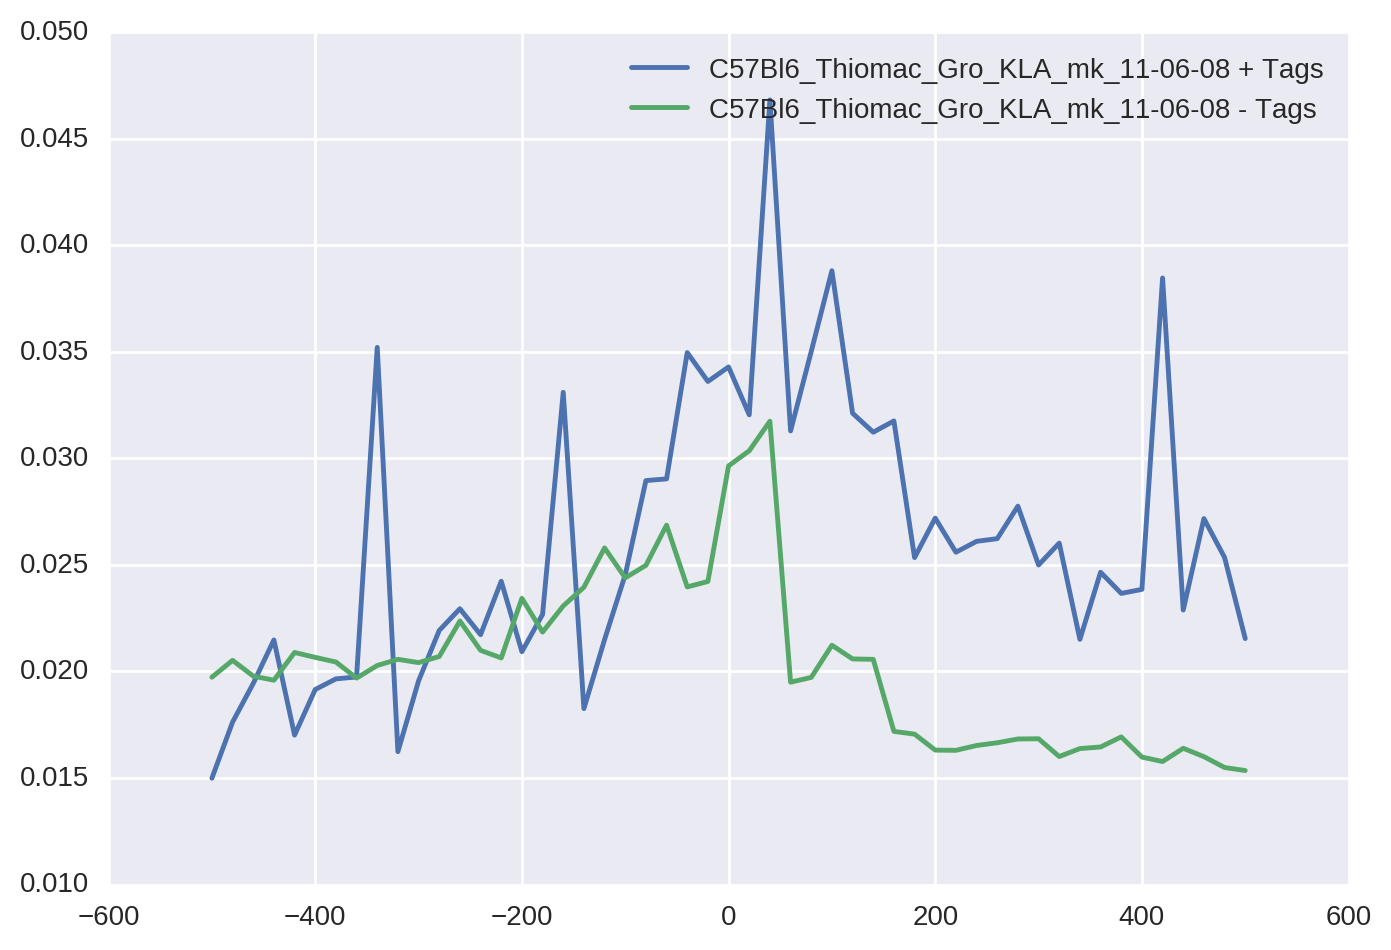

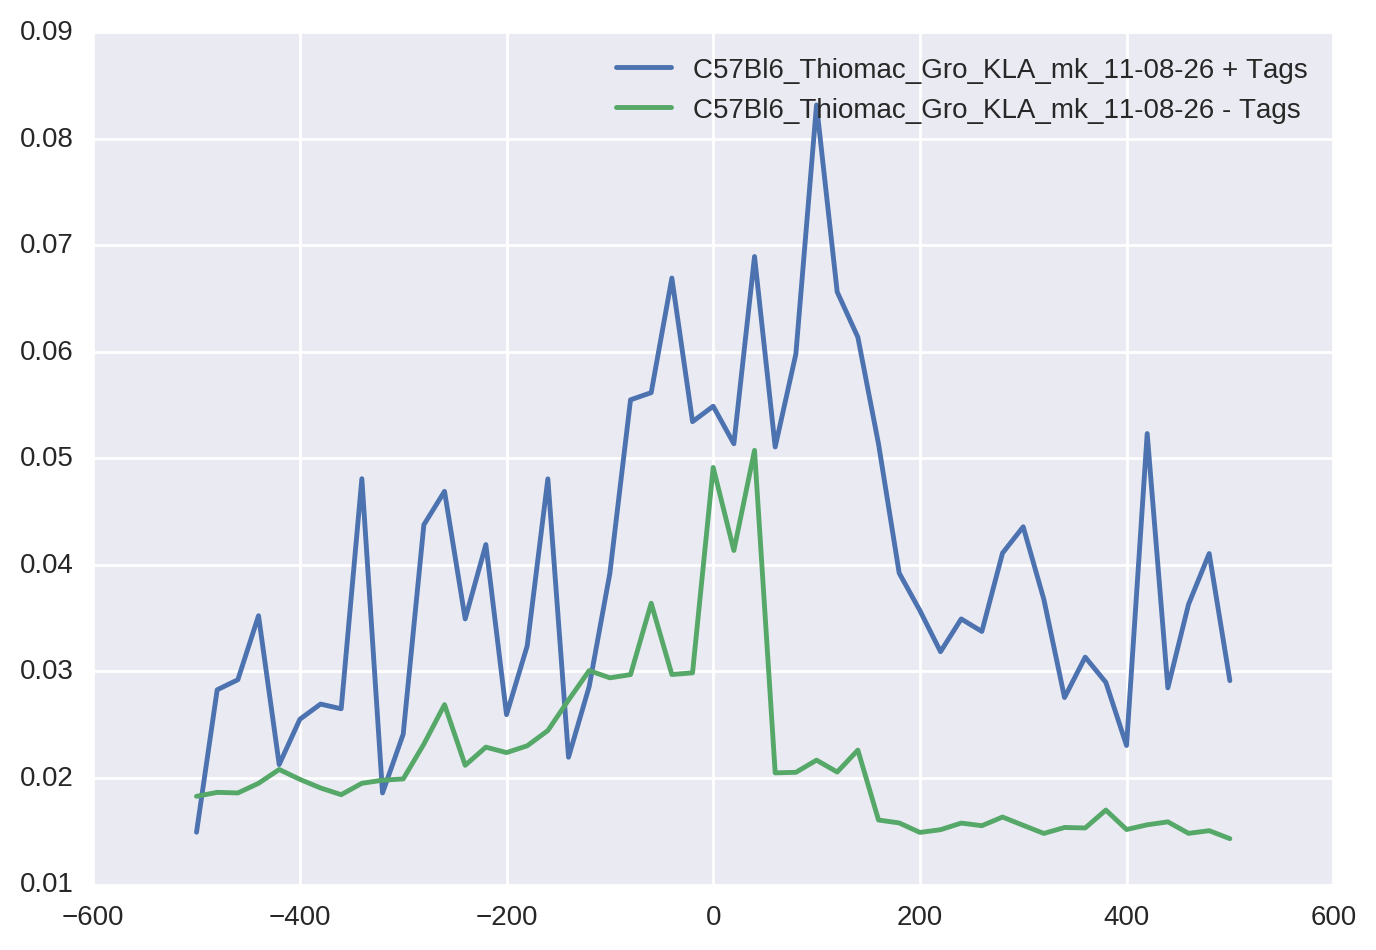

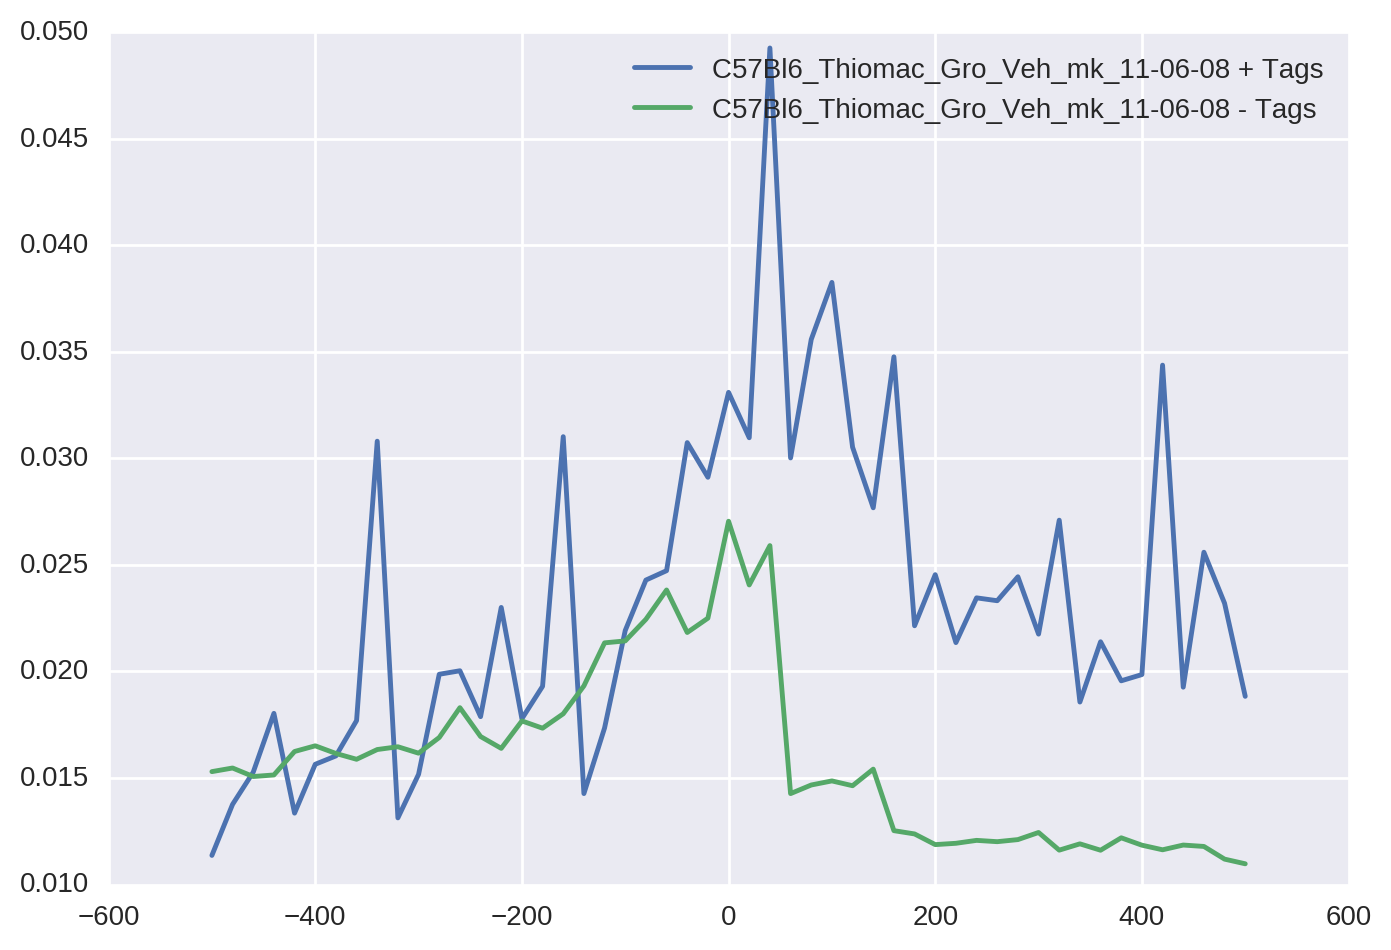

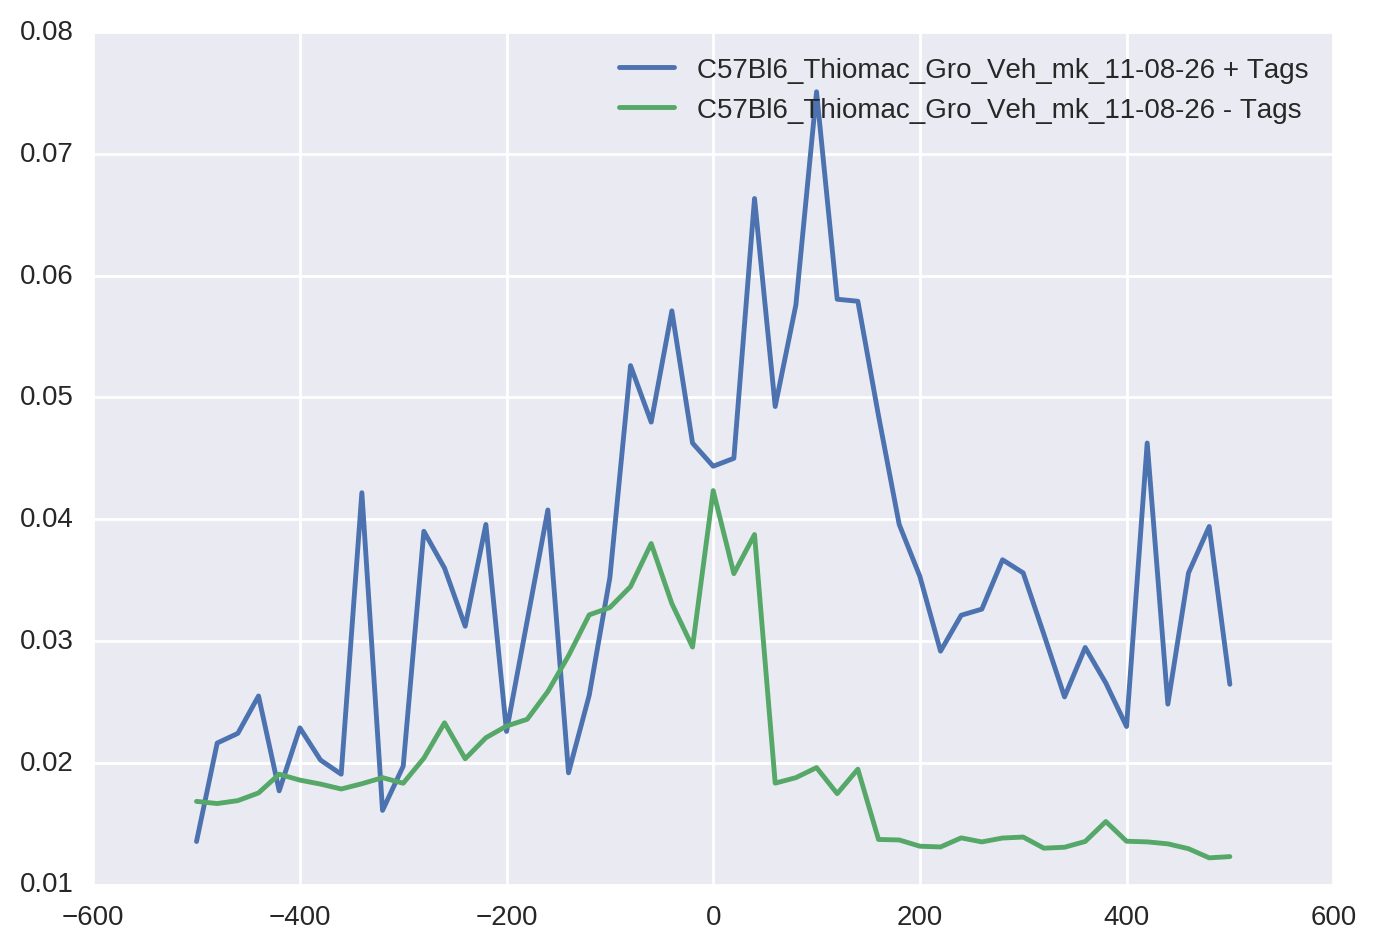

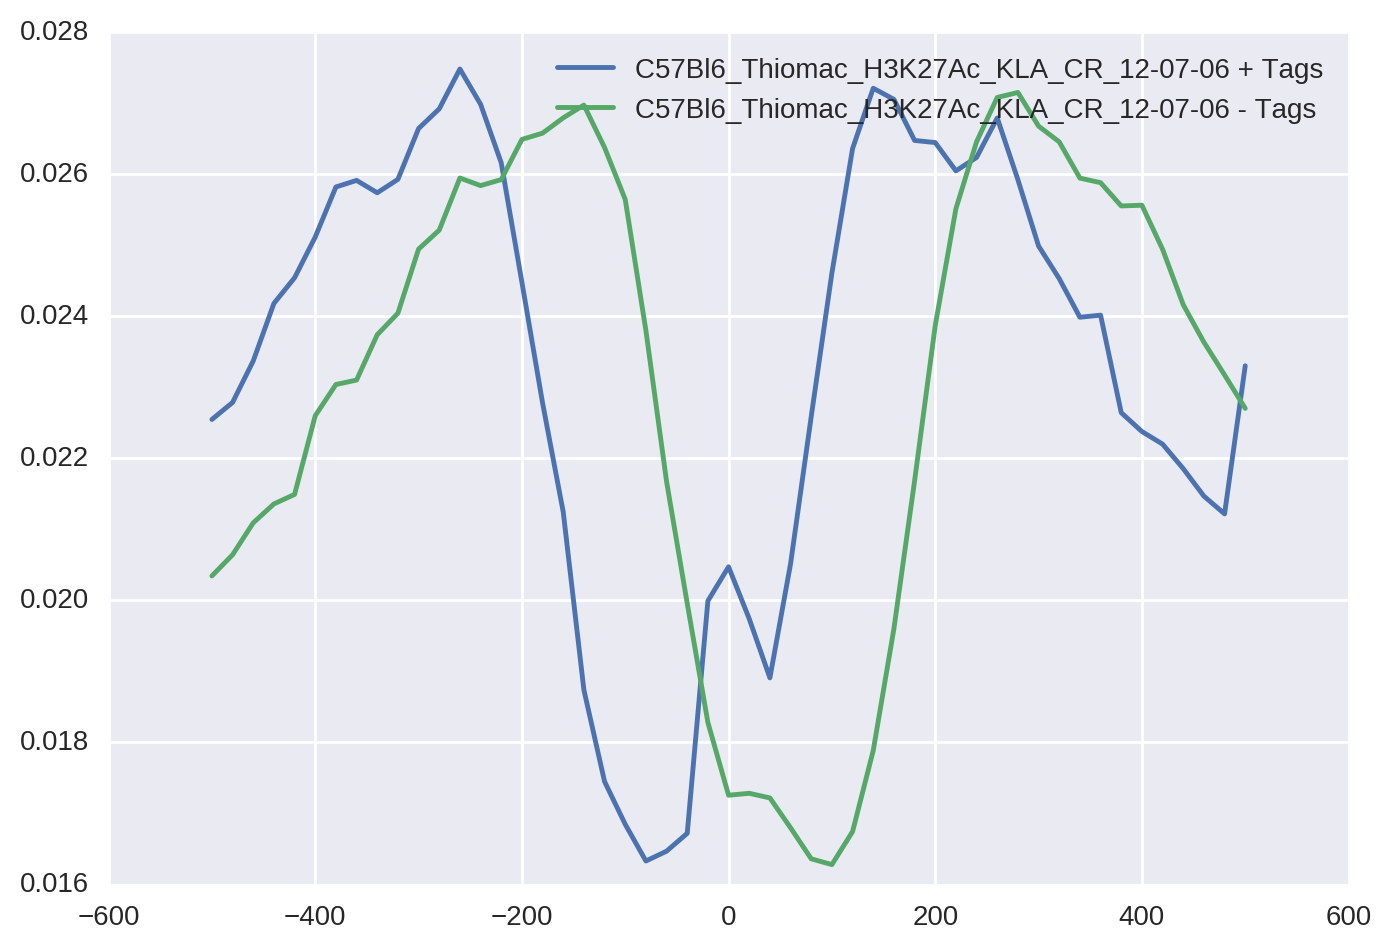

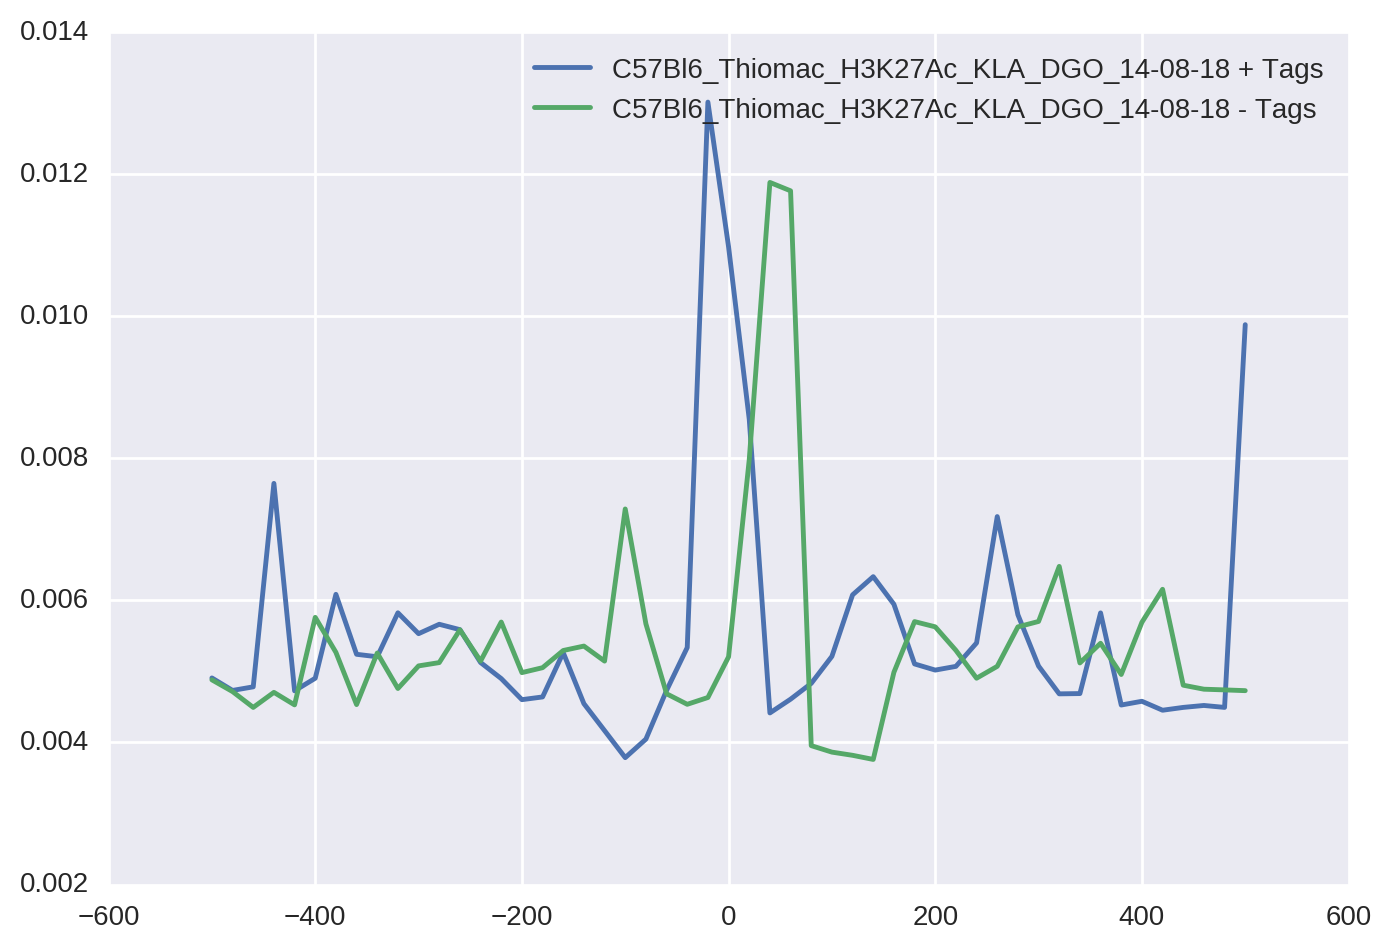

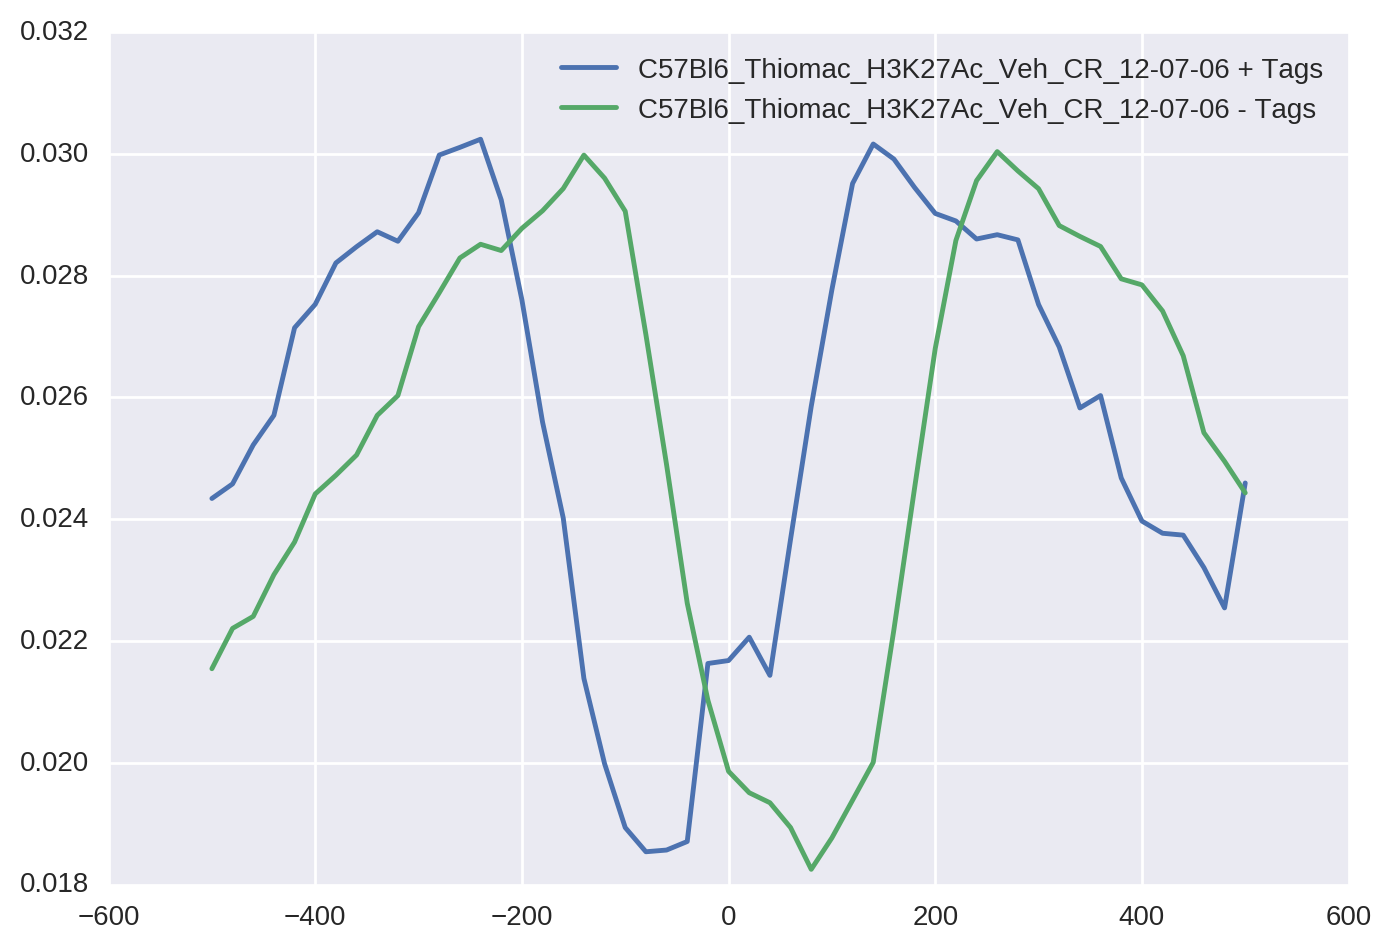

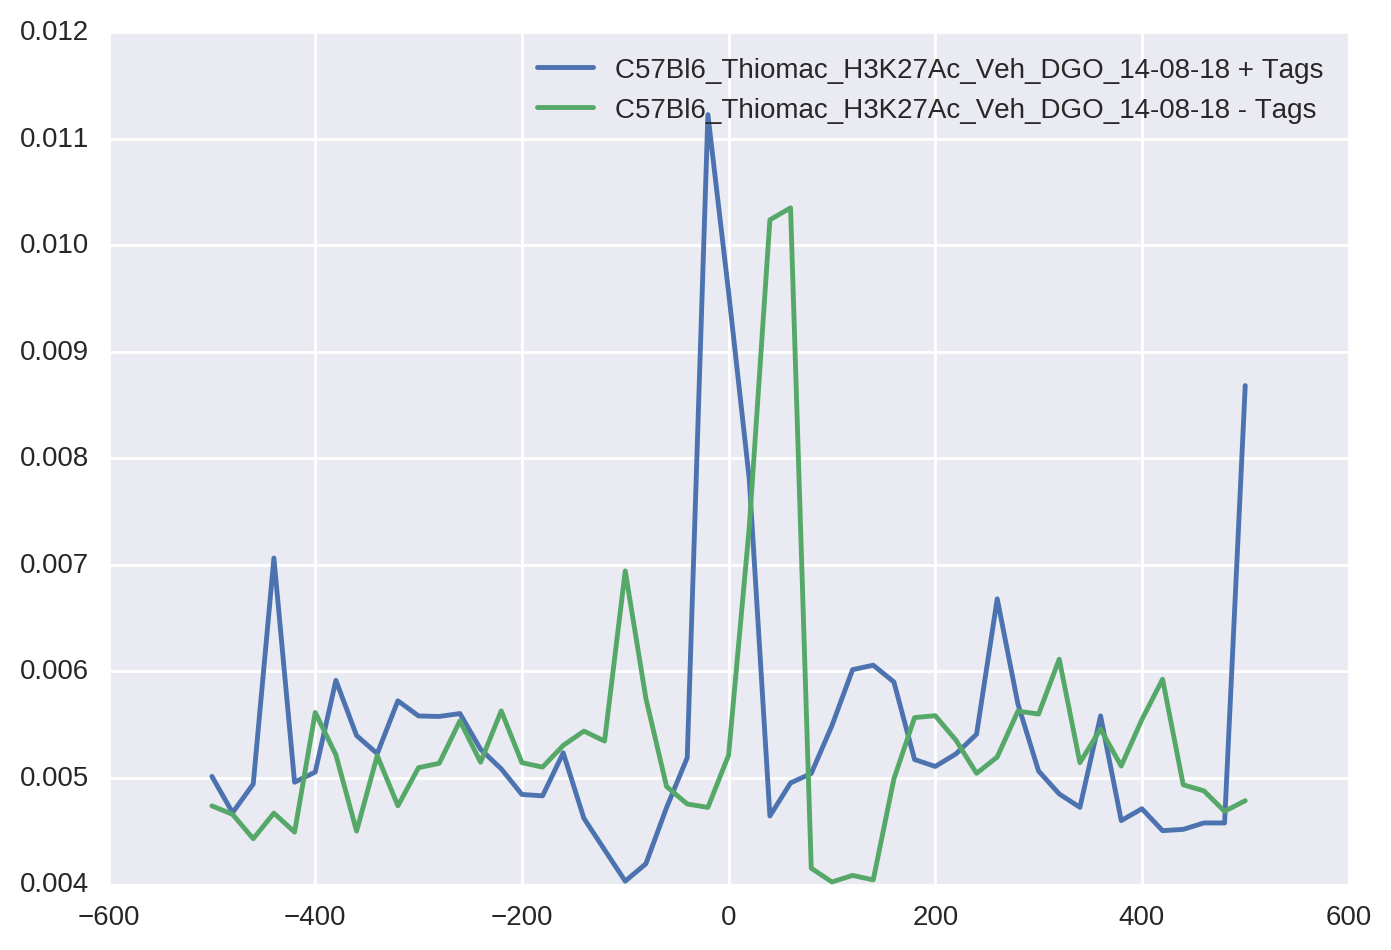

In [6]:
frame =pd.read_csv('hist.tsv',sep='\t')
columns = frame.columns.values
for i in range(int((frame.shape[1]-1)/3)):
    plt.plot(frame.ix[:,0],frame[columns[3*i+2]])
    plt.plot(frame.ix[:,0],frame[columns[3*i+3]])
    plt.legend([columns[3*i+2].split('/')[-1], columns[3*i+3].split('/')[-1]])
    plt.show()

### Retrieve sequences under peaks for finding motifs

In [7]:
# %%capture
# get sequences to scan for motifs
!/home/jenhan/code/motif_tools/getTargetSequencesWrapper.sh /home/jenhan/analysis/cobinding_motif_analysis/group/ /home/jenhan/analysis/cobinding_motif_analysis/group 0

python extendPeaks.py /home/jenhan/analysis/cobinding_motif_analysis/group//merged_peaks.tsv /home/jenhan/analysis/cobinding_motif_analysis/group//merged_extPeaks.tsv 0
homerTools extract /home/jenhan/analysis/cobinding_motif_analysis/group//merged_extPeaks.tsv /bioinformatics/homer/data/genomes/mm10 -fa > /home/jenhan/analysis/cobinding_motif_analysis/group/merged.fa

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 8917 sequences from chr1
	Extracting 10581 sequences from chr2
	Extracting 6696 sequences from chr3
	Extracting 7251 sequences from chr4
	Extracting 7471 sequences from chr5
	Extracting 7229 sequences from chr6
	Extracting 7238 sequences from chr7
	Extracting 5890 sequences from chr8
	Extracting 6396 sequences from chr9
	Extracting 7298 sequences from chr10
	Extracting 9300 sequences from chr11
	Extracting 5059 sequences from chr12
	Extracting 5895 sequences from chr13
	Extracting 4731 sequences from chr14
	Extracting 5290 sequences

In [8]:
### read in sequences as dictionary {peakID: sequence}
with open('./group/merged.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()
        

### Scan for motifs using FIMO

In [9]:
# create a script to scan for motifs using FIMO
! if [ ! -d /home/jenhan/analysis/cobinding_motif_analysis/fimo_out/ ]; then mkdir /home/jenhan/analysis/cobinding_motif_analysis/fimo_out/; fi
pthresh = 0.01
motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'

fimo_results_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_results'
p='/home/jenhan/analysis/cobinding_motif_analysis/group/merged.fa'
count = 0
scriptFile = open('scanMotifs.sh','w')
for m in os.listdir(motif_dir):
    if 'fimo' in m:
        fimo_out_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_out/' + m.replace('.fimo','')
        outPath = fimo_results_dir + '/merged_'+ m.replace('.fimo','') +'.txt'
    #     !echo fimo --max-stored-scores 2000000 --output-pthresh $pthresh --oc $fimo_out_dir $motif_dir/$m /home/jenhan/analysis/cobinding_motif_analysis/group/merged.fa   
        scriptFile.write(
#             '(sleep ' + str(15 * count) + 
            '(sleep ' + str(0 * count) + 
            's; fimo --text --max-stored-scores 2000000 --output-pthresh ' + 
            str(pthresh) +' --oc ' + fimo_out_dir + ' ' +
            motif_dir + '/' + m + ' /home/jenhan/analysis/cobinding_motif_analysis/group/merged.fa '+
            '> ' + outPath + ' ) & \n')
        count+=1
scriptFile.close()



In [ ]:
%%bash
chmod a+x ./scanMotifs.sh
./scanMotifs.sh

## Read in Score Files

### Generate main dictionaries from pickles

In [3]:
motif_score_frame=pd.read_pickle('motif_score_frame.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame.pickle')
motif_count_frame = pd.read_pickle('motif_count_frame.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

# normed_motif_frame = pd.DataFrame(preprocessing.normalize(merged_motif_frame.ix[:,3:], axis=0))
scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values
_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')
scaler = preprocessing.MinMaxScaler()
normed_summary_frame = pd.DataFrame(scaler.fit_transform(summary_frame.ix[:,5:]))
normed_summary_frame.columns = summary_frame.columns.values[5:]
normed_summary_frame.index = summary_frame.index.values

scaled_motif_frame = pd.DataFrame()
for m in motif_score_frame.columns[3:]:
    scaled_motif_frame[m] = motif_score_frame[m]/(2*motif_sequence_frame[m].str.len().max())
    
    
motif_interaction_frame = pd.DataFrame(
    sklearn.preprocessing.PolynomialFeatures(
        degree=2, interaction_only=True).fit_transform(motif_score_frame.ix[:,3:])
).ix[:,1:]
motifs = motif_score_frame.columns.values[3:]
interaction_term_columns = list(motifs)
for i in range(len(motifs)-1):
    for j in range(i+1,len(motifs)):
        interaction_term_columns.append(motifs[i]+'::'+motifs[j])
motif_interaction_frame.columns = interaction_term_columns
motif_interaction_frame.index = motif_score_frame.index.values

# significant_motifs_dict = pickle.load( open( "significant_motifs_dict.pickle", "rb" ) )
# motif_difference_dict = pickle.load( open( "motif_difference_dict.pickle", "rb" ) )


### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
motif_count_frame = motif_count_frame[motif_count_frame.index.isin(intergenic_ids)]
normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
scaled_motif_frame = scaled_motif_frame[scaled_motif_frame.index.isin(intergenic_ids)]
# motif_interaction_frame = motif_interaction_frame[motif_interaction_frame.index.isin(intergenic_ids)]
summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]





### read in sequences as dictionary {peakID: sequence}
with open('./group/merged.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()    

### Read in Peak scores as floating point values

In [11]:
# read in peak data data
summary_frame = pd.read_csv('/home/jenhan/analysis/cobinding_motif_analysis/group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.max([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]


_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
summary_frame.to_pickle('summary_frame.pickle')
scaler = sklearn.preprocessing.MinMaxScaler()
normed_summary_frame = pd.DataFrame(scaler.fit_transform(summary_frame.ix[:,5:]))
normed_summary_frame.columns = summary_frame.columns.values[5:]
normed_summary_frame.index = summary_frame.index.values

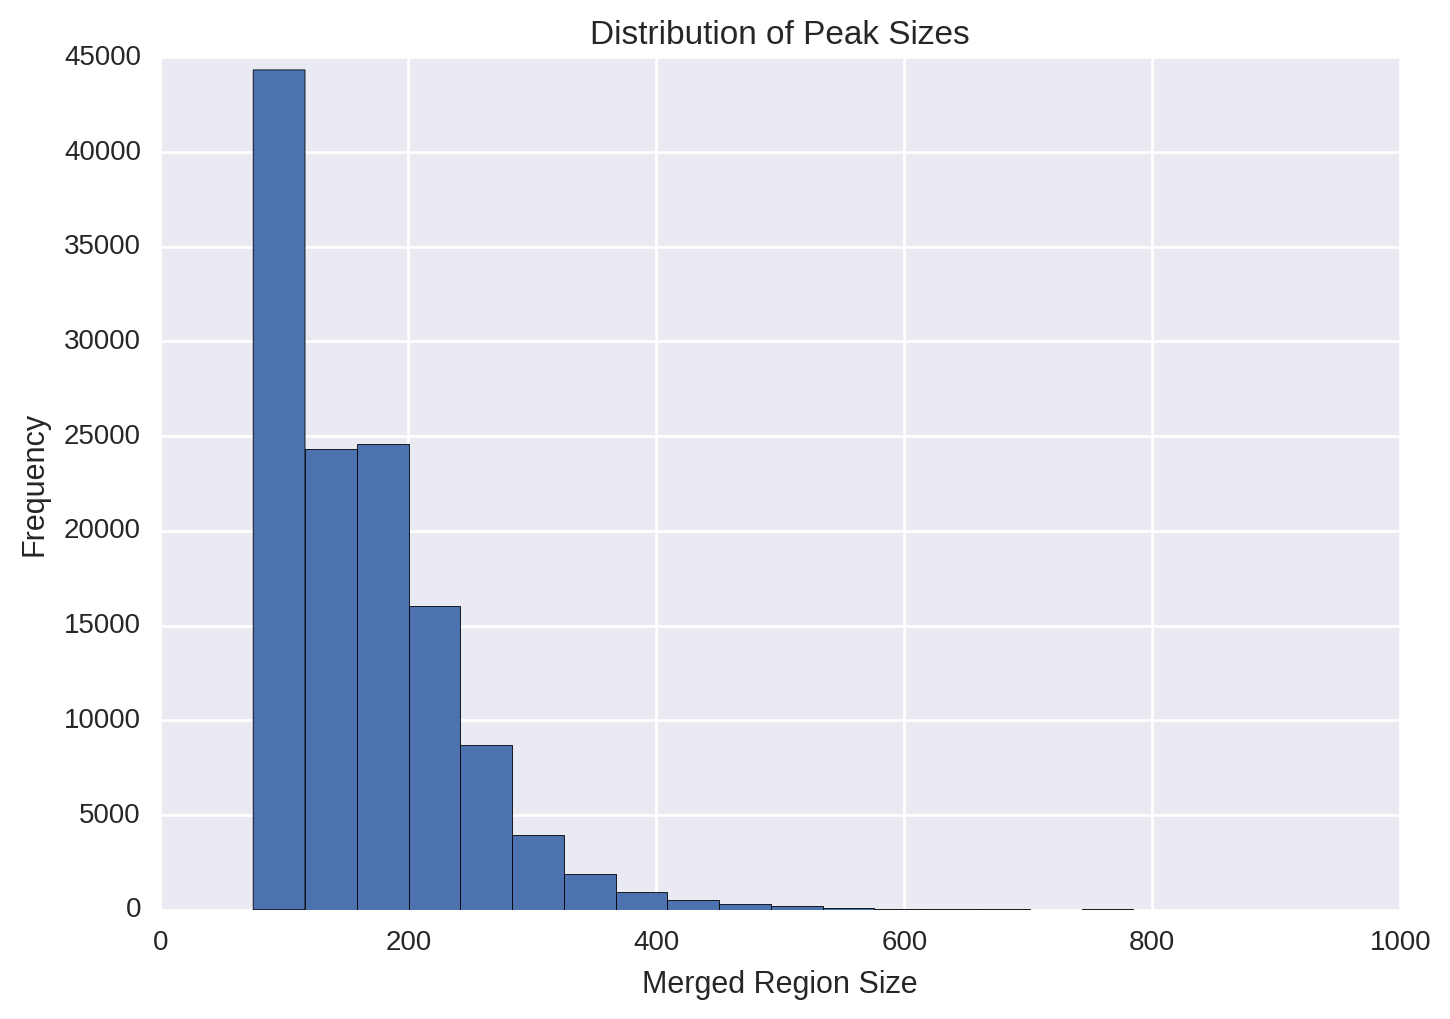

In [12]:

# plot motif positions to make sure that nothing went wrong with the merging
sizes = summary_frame['end'] - summary_frame['start']
plt.hist(sizes, bins = 20);
plt.xlabel('Merged Region Size')
plt.ylabel('Frequency')
plt.title('Distribution of Peak Sizes')

In [13]:
peakScores = summary_frame.ix[:,5:].values.flatten()
peakScores = peakScores[peakScores < 500]
peakScores = peakScores[peakScores > 0]

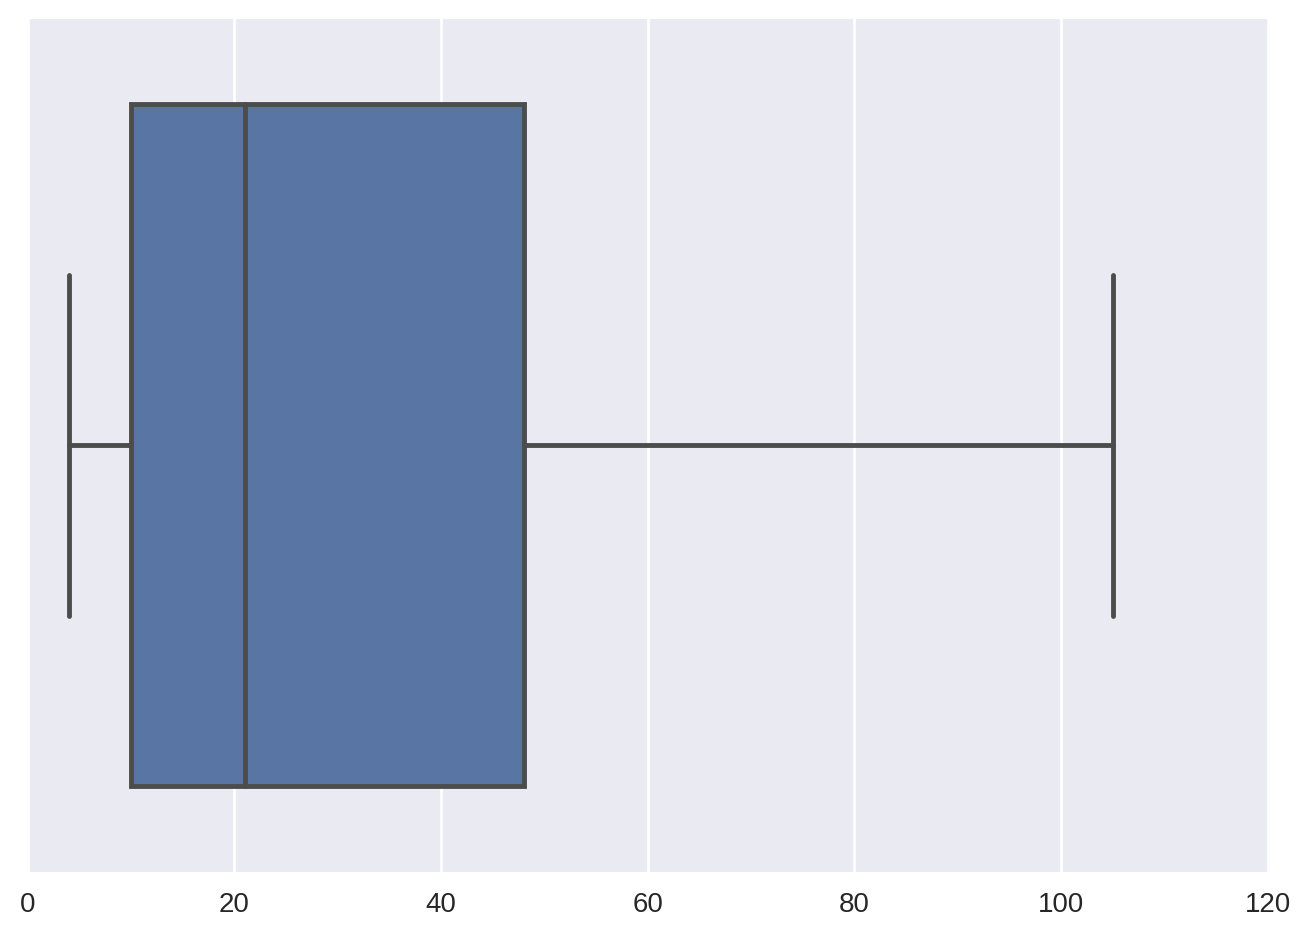

In [14]:
sns.boxplot(peakScores, showfliers=False)

### Read in Enhancer Marks

In [ ]:
### read in GRO and H3K27Ac scores

sense_frame = pd.read_csv('merged_annotated_peaks_sense.tsv', sep='\t')

antisense_frame = pd.read_csv('merged_annotated_peaks_antisense.tsv', sep='\t')

sense_frame.index=sense_frame.ix[:,0].values
columns = sense_frame.columns.values
columns[0] = 'ID'
columns = [x.split('/')[-1].split()[0] if '/' in x else x for x in columns]
sense_frame.columns = columns

antisense_frame.index=antisense_frame.ix[:,0].values
columns = antisense_frame.columns.values
columns[0] = 'ID'
columns = [x.split('/')[-1].split()[0] if '/' in x else x for x in columns]
antisense_frame.columns = columns

tagDirectories = sense_frame.columns[19:].values
experiment_tagDir_dict = {}
for td in tagDirectories:
    tokens = td.split('_')
    experiment = '_'.join(tokens[2:4])
    if experiment in experiment_tagDir_dict:
        experiment_tagDir_dict[experiment].append(td)
    else:
        experiment_tagDir_dict[experiment] = [td]

_enhancerMarks = sorted(experiment_tagDir_dict.keys())

annotation_frame = sense_frame[['Chr', 'Start', 'End', 'Strand']]
annotation_frame['Annotation'] = [str(x).split()[0] for x in sense_frame['Annotation'].values]

for experiment in _enhancerMarks:
    current_sense_frame = sense_frame[experiment_tagDir_dict[experiment]]
    current_antisense_frame = antisense_frame[experiment_tagDir_dict[experiment]]


    annotation_frame[experiment + ' +'] = np.mean(current_sense_frame, axis=1)
    annotation_frame[experiment + ' -'] = np.mean(current_antisense_frame, axis=1)
    print(experiment)

#     log_frame = np.log2(current_sense_frame+1)
#     log_frame.columns = [x + ' +' for x in log_frame.columns.values]
#     sns.pairplot(log_frame, size=7, kind= 'reg')
#     plt.savefig(experiment+'_sense_pairplot.png')
#     plt.close()
# #     plt.show()
    
#     log_frame = np.log2(current_antisense_frame+1)
#     log_frame.columns = [x + ' -' for x in log_frame.columns.values]
#     sns.pairplot(log_frame, size=7, kind= 'reg')
#     plt.savefig(experiment+'_antisense_pairplot.png')
#     plt.close()
# #     plt.show()
    


nonStrandSpecificExperiments = ['H3K27Ac_KLA', 'H3K27Ac_Veh']
for experiment in nonStrandSpecificExperiments:
    annotation_frame[experiment] = annotation_frame[experiment + ' +'] + annotation_frame[experiment + ' -']
    annotation_frame.drop(experiment + ' +', axis=1, inplace=True)
    annotation_frame.drop(experiment + ' -', axis=1, inplace=True)
    
# remove outlier GRO-seq values
annotation_frame.loc[annotation_frame['Gro_Veh +'] > 10000, 'Gro_Veh +' ] = 0
annotation_frame.loc[annotation_frame['Gro_KLA +'] > 10000, 'Gro_KLA +' ] = 0
annotation_frame.loc[annotation_frame['Gro_Veh -'] > 10000, 'Gro_Veh -' ] = 0
annotation_frame.loc[annotation_frame['Gro_KLA -'] > 10000, 'Gro_KLA -' ] = 0


sns.countplot(annotation_frame['Annotation'])
plt.title('Types of Peaks')
plt.xlabel('Peak Type')
plt.ylabel('Frequency')
plt.xticks(rotation=90);




In [16]:
### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]



## Classifying Enhancers

In [ ]:
sns.distplot(np.log2(annotation_frame['Gro_Veh -']+1))
plt.show()
sns.distplot(np.log2(annotation_frame['Gro_Veh +']+1))
plt.show()
sns.distplot(np.log2(annotation_frame['Gro_KLA -']+1))
plt.show()
sns.distplot(np.log2(annotation_frame['Gro_KLA +']+1))
plt.show()
sns.distplot(np.log2(annotation_frame['H3K27Ac_KLA']+1))
plt.show()
sns.distplot(np.log2(annotation_frame['H3K27Ac_Veh']+1))
plt.show()

In [ ]:
numClusters = 3
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
features = annotation_frame[[x for x in annotation_frame.columns.values if 'KLA' in x and not 'Active' in x]]
features = features[features.index.isin(intergenic_ids)]
scaler = preprocessing.MinMaxScaler()
normed_features = pd.DataFrame(scaler.fit_transform(np.log2(features + 1)))
normed_features.columns = features.columns
colorDict = dict(zip(range(numClusters+1),sns.color_palette("Set1") + sns.color_palette("Set2") + sns.color_palette("colorblind")))

cg = sns.clustermap(normed_features,yticklabels=False, col_cluster=False)
plt.close()
row_linkage = cg.dendrogram_row.linkage
            
row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numClusters, criterion="maxclust")
            
row_colors = [colorDict[row_flatCluster[i]] for i in range(len(cg.data.index))]
sns.clustermap(normed_features,
             row_linkage = row_linkage,
             row_colors = row_colors,
             col_cluster=False,
             cmap="Blues",
             yticklabels = False
             )

In [ ]:
numClusters = 3
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
features = annotation_frame[[x for x in annotation_frame.columns.values if 'Veh' in x and not 'Active' in x]]
features = features[features.index.isin(intergenic_ids)]
scaler = preprocessing.MinMaxScaler()
normed_features = pd.DataFrame(scaler.fit_transform(np.log2(features + 1)))
normed_features.columns = features.columns
colorDict = dict(zip(range(numClusters+1),sns.color_palette("Set1") + sns.color_palette("Set2") + sns.color_palette("colorblind")))

cg = sns.clustermap(normed_features,yticklabels=False, col_cluster=False)
plt.close()
row_linkage = cg.dendrogram_row.linkage
            
row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numClusters, criterion="maxclust")
            
row_colors = [colorDict[row_flatCluster[i]] for i in range(len(cg.data.index))]
sns.clustermap(normed_features,
             row_linkage = row_linkage,
             row_colors = row_colors,
             col_cluster=False,
             cmap="Blues",
             yticklabels = False
             )

In [ ]:
### Assign active versus inactive for KLA enhancers ###
numColors = 20
colorDict = dict(zip(range(numColors),sns.color_palette("Set2") + sns.color_palette("colorblind")))

# calculate k-means cluster for use in coloring
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
features = annotation_frame[[x for x in annotation_frame.columns.values if 'KLA ' in x]]
features = features[features.index.isin(intergenic_ids)]
normed_features = np.log2(features + 1)

print(features.shape)
# normed_features = sklearn.preprocessing.normalize(features, axis=1)
est = KMeans(n_clusters=2, n_jobs=4)
est.fit(normed_features)
colors = [colorDict[x] for x in est.labels_]

sns.jointplot(normed_features['Gro_KLA +'],
           normed_features['Gro_KLA -'],
           alpha=0.4, c=colors)


# sns.jointplot(normed_features['Gro_KLA +'],
#            normed_features['H3K27Ac_KLA'],
#            alpha=0.4, c=colors)


# sns.jointplot(normed_features['Gro_KLA -'],
#            normed_features['H3K27Ac_KLA'],
#            alpha=0.4, c=colors)


clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(normed_features.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_kla_sense = list(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values)
    gro_kla_antisense = list(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA -'].values)
    h3k27ac_kla = list(annotation_frame[annotation_frame.index.isin(current_indices)]['H3K27Ac_KLA'].values)
   
        
    reads = reads + gro_kla_sense
    treatments = treatments + len(current_indices) * ['Gro +'] 
        
    reads = reads + gro_kla_antisense
        
    treatments = treatments + len(current_indices) * ['Gro -'] 
        
    reads = reads + h3k27ac_kla

    treatments = treatments + len(current_indices) * ['H3K27Ac']

    clusters = clusters + 3 * len(current_indices) * [str(cluster)]
        
reads = np.log2(np.array(reads) + 1)
data_frame = pd.DataFrame({'reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})
print('cluster 0:',np.sum(data_frame['cluster']=='0')/3,
     'cluster 1:',np.sum(data_frame['cluster']=='1')/3)
sns.factorplot(x='cluster',y='reads', hue='treatment', 
                data= data_frame, 
                kind='box',
                size=10,
                width=0.4,
                whis=1,
                showfliers=False)
# plt.ylim([0,12])
plt.show()

### assign activity according to the mean H3K27Ac value of each cluster ###
cluster_mean_0 = np.mean(data_frame[(data_frame['cluster']=='0') & (data_frame['treatment']=='H3K27Ac')]['reads'])
cluster_mean_1 = np.mean(data_frame[(data_frame['cluster']=='1') & (data_frame['treatment']=='H3K27Ac')]['reads'])
if cluster_mean_0 < cluster_mean_1:
    # cluster 1 is considered the active cluster
    index_activity_dict = dict(zip(normed_features.index.values,
                                     [True if x == 1 else False for x in est.labels_]))
else:
    # cluster 0 is considered the active cluster
    index_activity_dict = dict(zip(normed_features.index.values,
                                     [True if x == 0 else False for x in est.labels_]))
annotation_frame['Active Enhancer KLA'] = [index_activity_dict[x] for x in annotation_frame.index.values]


In [ ]:
### Assign active versus inactive for VEH enhancers ###
numColors = 20
colorDict = dict(zip(range(numColors),sns.color_palette("Set2") + sns.color_palette("colorblind")))

# calculate k-means cluster for use in coloring
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
features = annotation_frame[[x for x in annotation_frame.columns.values if 'Veh ' in x]]
features = features[features.index.isin(intergenic_ids)]
normed_features = np.log2(features + 1)

print(features.shape)
# normed_features = sklearn.preprocessing.normalize(features, axis=1)
est = KMeans(n_clusters=2, n_jobs=4)
est.fit(normed_features)
colors = [colorDict[x] for x in est.labels_]

sns.jointplot(normed_features['Gro_Veh +'],
           normed_features['Gro_Veh -'],
           alpha=0.4, c=colors)


# sns.jointplot(normed_features['Gro_Veh +'],
#            normed_features['H3K27Ac_Veh'],
#            alpha=0.4, c=colors)


# sns.jointplot(normed_features['Gro_Veh -'],
#            normed_features['H3K27Ac_Veh'],
#            alpha=0.4, c=colors)


clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(normed_features.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh_sense = list(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values)
    gro_veh_antisense = list(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh -'].values)
    h3k27ac_veh = list(annotation_frame[annotation_frame.index.isin(current_indices)]['H3K27Ac_Veh'].values)
   
    
    reads = reads + gro_veh_sense
    treatments = treatments + len(current_indices) * ['Gro +']
    
    reads = reads + gro_veh_antisense
        
    treatments = treatments + len(current_indices) * ['Gro -']
    
    reads = reads + h3k27ac_veh

    treatments = treatments + len(current_indices) * ['H3K27Ac']

    clusters = clusters + 3 * len(current_indices) * [str(cluster)]
    
reads = np.log2(np.array(reads) + 1)
data_frame = pd.DataFrame({'reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})
print('cluster 0:',np.sum(data_frame['cluster']=='0')/3,
     'cluster 1:',np.sum(data_frame['cluster']=='1')/3)
sns.factorplot(x='cluster',y='reads', hue='treatment', 
                data= data_frame, 
                kind='box',
                size=10,
                width=0.4,
                whis=1,
                showfliers=False)
# plt.ylim([0,12])
plt.show()

### assign activity according to the mean H3K27Ac value of each cluster ###
cluster_mean_0 = np.mean(data_frame[(data_frame['cluster']=='0') & (data_frame['treatment']=='H3K27Ac')]['reads'])
cluster_mean_1 = np.mean(data_frame[(data_frame['cluster']=='1') & (data_frame['treatment']=='H3K27Ac')]['reads'])
if cluster_mean_0 < cluster_mean_1:
    # cluster 1 is considered the active cluster
    index_activity_dict = dict(zip(normed_features.index.values, 
                                     [True if x == 1 else False for x in est.labels_]))
else:
    # cluster 0 is considered the active cluster
    index_activity_dict = dict(zip(normed_features.index.values, 
                                     [True if x == 0 else False for x in est.labels_]))
annotation_frame['Active Enhancer Veh'] = [index_activity_dict[x] for x in annotation_frame.index.values]

In [22]:
annotation_frame.to_pickle('annotation_frame.pickle')

### Read in motif scores

In [ ]:
motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'
# motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs_jaspar_2014/'

peak_start_dict = dict(zip(summary_frame['ID'].values, summary_frame['start'].values))

motif_score_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_score_frame.index=motif_score_frame['ID'].values

motif_sequence_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_sequence_frame.index=motif_score_frame['ID'].values

motif_strand_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_strand_frame.index=motif_score_frame['ID'].values

motif_start_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_start_frame.index=motif_score_frame['ID'].values

motif_end_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_end_frame.index=motif_score_frame['ID'].values

motif_count_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_count_frame.index = motif_count_frame['ID'].values

counter=0
for m in sorted(os.listdir(motif_dir)):
    counter+=1
    if '.fimo' in m:
        print(counter,m)
        motif_results = './fimo_results//merged_' + m.replace('.fimo','') +'.txt'
        fimo_result_frame=pd.read_csv(motif_results, 
                                      skiprows=1,
                                      names=['motif_name', 
                                             'peak_id', 
                                             'start', 
                                             'stop', 
                                             'strand', 
                                             'score', 
                                             'pvalue', 
                                             'sequence'],
                                      sep='\t')
        motif_name = m.replace('.fimo','')
        id_score_dict = {}
        id_strand_dict = {}
        id_sequence_dict = {}
        id_start_dict = {}
        id_end_dict = {}
        id_count_dict = {}
        
        ids = fimo_result_frame['peak_id'].values
        scores = fimo_result_frame['score'].values
        strands = fimo_result_frame['strand'].values
        sequences = fimo_result_frame['sequence']
        starts = fimo_result_frame['start']
        ends = fimo_result_frame['stop']
        
        for i in range(len(ids)):
            currentScore = float(scores[i])
            currentSequence = sequences[i]
            currentStrand = strands[i]
            currentStart = int(starts[i])
            currentEnd = int(ends[i])
            if currentScore < 0.0:
                currentScore = 0.0
            if ids[i] in id_score_dict:
                if currentScore > id_score_dict[ids[i]]:
                    id_score_dict[ids[i]] = currentScore
                    id_sequence_dict[ids[i]] = currentSequence
                    id_strand_dict[ids[i]] = currentStrand
                    id_start_dict[ids[i]] = currentStart
                    id_end_dict[ids[i]] = currentEnd
                    id_count_dict[ids[i]] += 1
            else:
                id_score_dict[ids[i]] = currentScore
                id_sequence_dict[ids[i]] = currentSequence
                id_strand_dict[ids[i]] = currentStrand
                id_start_dict[ids[i]] = currentStart
                id_end_dict[ids[i]] = currentEnd
                id_count_dict[ids[i]] = 0
                
        motif_score_frame[motif_name] = [id_score_dict[x] if x in id_score_dict else 0 for x in motif_score_frame['ID'].values]
        motif_sequence_frame[motif_name] = [id_sequence_dict[x] if x in id_sequence_dict else '?' for x in motif_sequence_frame['ID'].values]
        motif_strand_frame[motif_name] = [id_strand_dict[x] if x in id_score_dict else '' for x in motif_strand_frame['ID'].values]
        motif_start_frame[motif_name] = [id_start_dict[x] + peak_start_dict[x] if x in id_start_dict else -1 for x in motif_start_frame['ID'].values]
        motif_end_frame[motif_name] = [id_end_dict[x] + peak_start_dict[x] if x in id_end_dict else -1 for x in motif_end_frame['ID'].values]
        motif_count_frame[motif_name] = [id_count_dict[x] if x in id_count_dict else 0 for x in motif_count_frame['ID'].values]


        
motif_score_frame.to_pickle('motif_score_frame.pickle')
motif_score_frame.to_csv('motif_scores.tsv', sep='\t', index=False)

motif_sequence_frame.to_pickle('motif_sequence_frame.pickle')
motif_sequence_frame.to_csv('motif_sequence.tsv', sep='\t', index=False)

motif_strand_frame.to_pickle('motif_strand_frame.pickle')
motif_strand_frame.to_csv('motif_strand.tsv', sep='\t', index=False)

motif_start_frame.to_pickle('motif_start_frame.pickle')
motif_start_frame.to_csv('motif_start_frame.tsv', sep='\t', index=False)

motif_end_frame.to_pickle('motif_end_frame.pickle')
motif_end_frame.to_csv('motif_end_frame.tsv', sep='\t', index=False)

motif_count_frame.to_pickle('motif_count_frame.pickle')
motif_count_frame.to_csv('motif_count_frame.tsv', sep='\t', index=False)

scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values

scaled_motif_frame = pd.DataFrame()
for m in motif_score_frame.columns[3:]:
    scaled_motif_frame[m] = motif_score_frame[m]/(2*motif_sequence_frame[m].str.len().max())
    
    
# motif_interaction_frame = pd.DataFrame(
#     sklearn.preprocessing.PolynomialFeatures(
#         degree=2, interaction_only=True).fit_transform(motif_score_frame.ix[:,3:])
# ).ix[:,1:]
# motifs = motif_score_frame.columns.values[3:]
# interaction_term_columns = list(motifs)
# for i in range(len(motifs)-1):
#     for j in range(i+1,len(motifs)):
#         interaction_term_columns.append(motifs[i]+'::'+motifs[j])
# motif_interaction_frame.columns = interaction_term_columns
# motif_interaction_frame.index = motif_score_frame.index.values

In [157]:
### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
motif_count_frame = motif_count_frame[motif_count_frame.index.isin(intergenic_ids)]
normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
scaled_motif_frame = scaled_motif_frame[scaled_motif_frame.index.isin(intergenic_ids)]
# motif_interaction_frame = motif_interaction_frame[motif_interaction_frame.index.isin(intergenic_ids)]
summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]




## Analysis of motif scores

In [ ]:
sns.distplot(motif_score_frame.ix[:,3:].max(axis=0))
plt.title('Distribution of max un-normalized motif score')
plt.xlabel('Un-normalized motif score')

In [27]:
### test motif scores for normality - which justifies the use of standardization
for motif in motif_score_frame.columns.values[3:]:
    w, pval = scipy.stats.mstats.normaltest(motif_score_frame[motif].values)
    if pval > 0.01:
        print(motif, pval)
    

ebox 1.0
homeobox-2 1.0


In [ ]:
### plot variance of motif scores

sns.distplot(motif_score_frame.ix[:,3:].var())
plt.title('Un-normalized motif score variance')
plt.show()



In [ ]:
### plot variance of motif scores

sns.distplot(normed_motif_frame.var())
plt.title('Normalized motif score variance')
plt.xlim(-0.2, 0.2)
plt.show()




### Plot Distributions of motif scores

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/seaborn-0.7.0-py3.4.egg/seaborn/categorical.py:2125: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


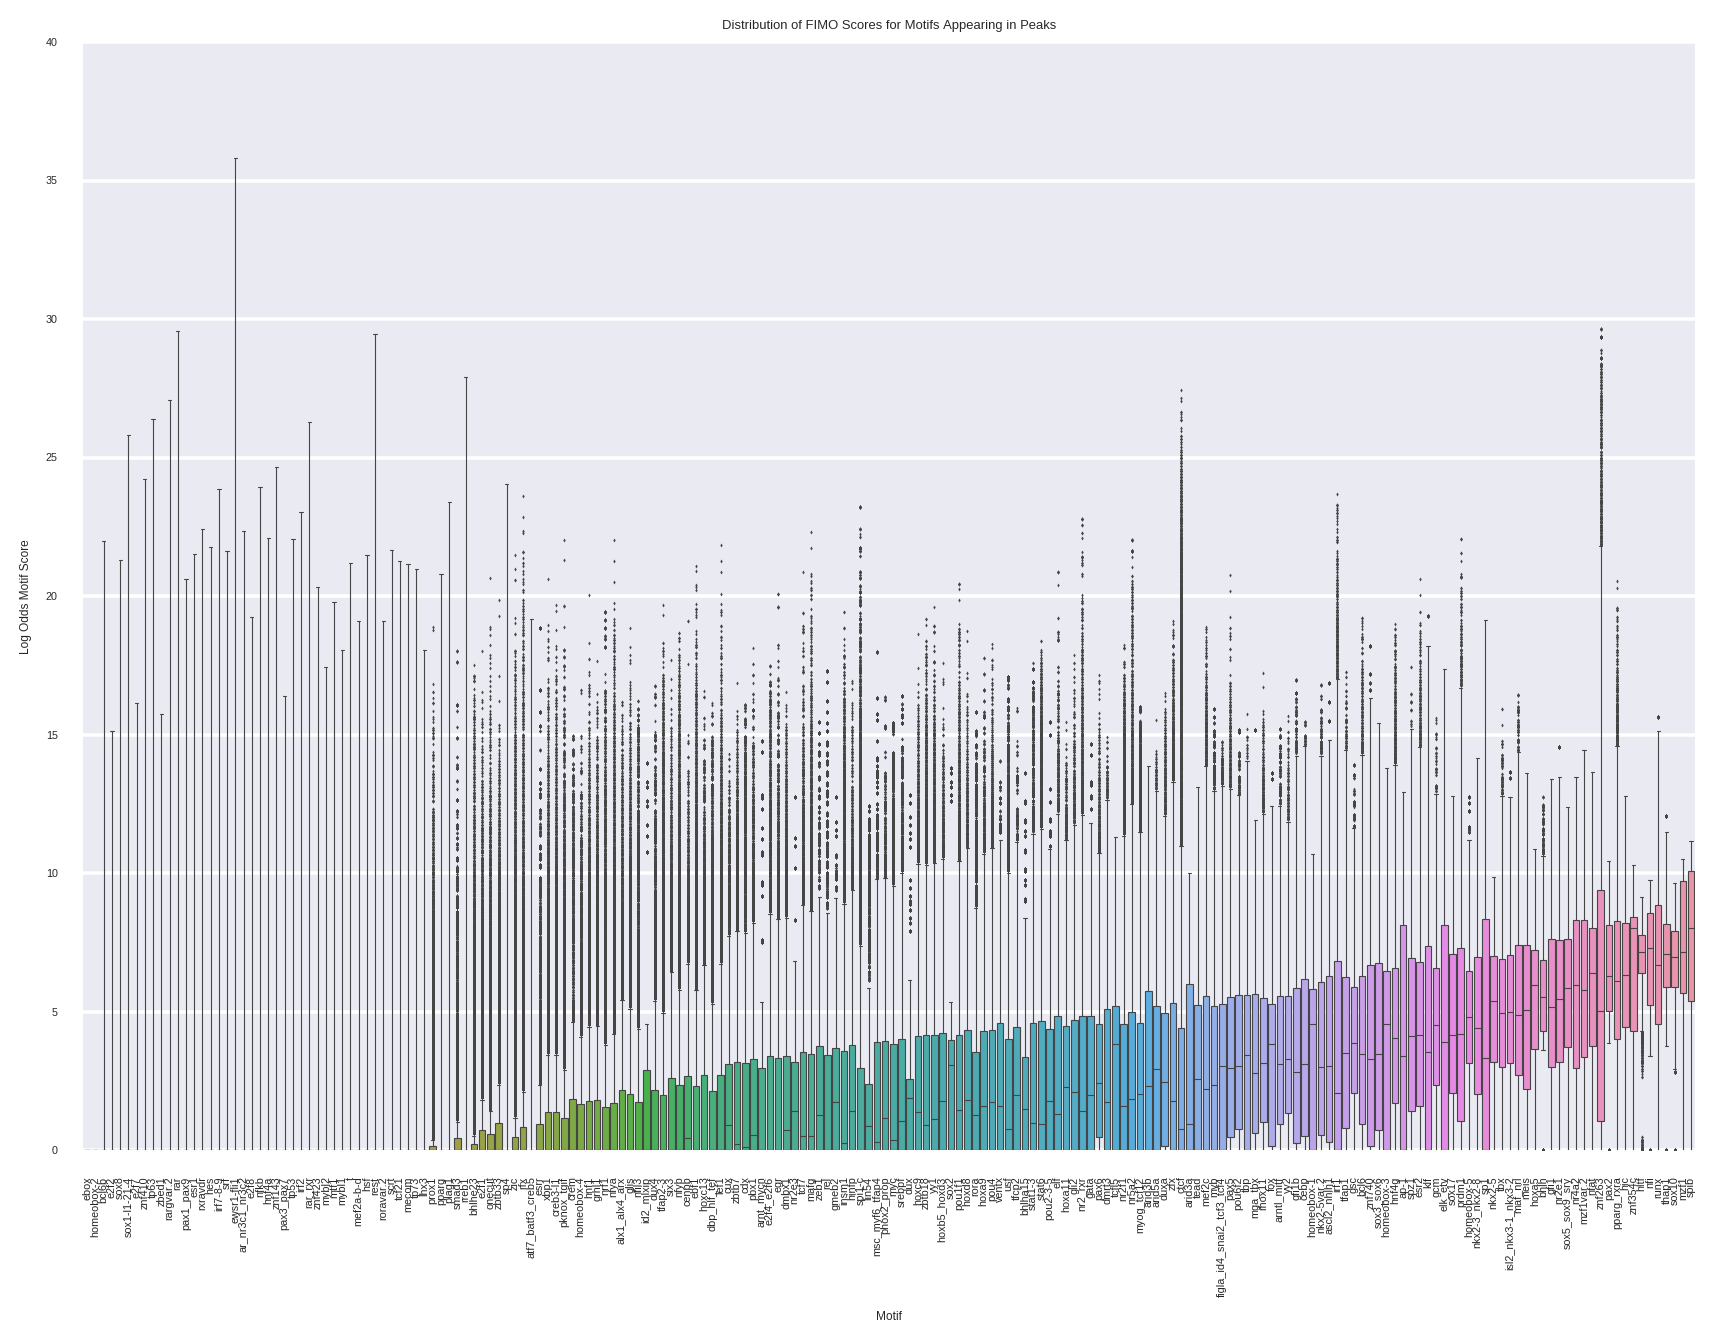

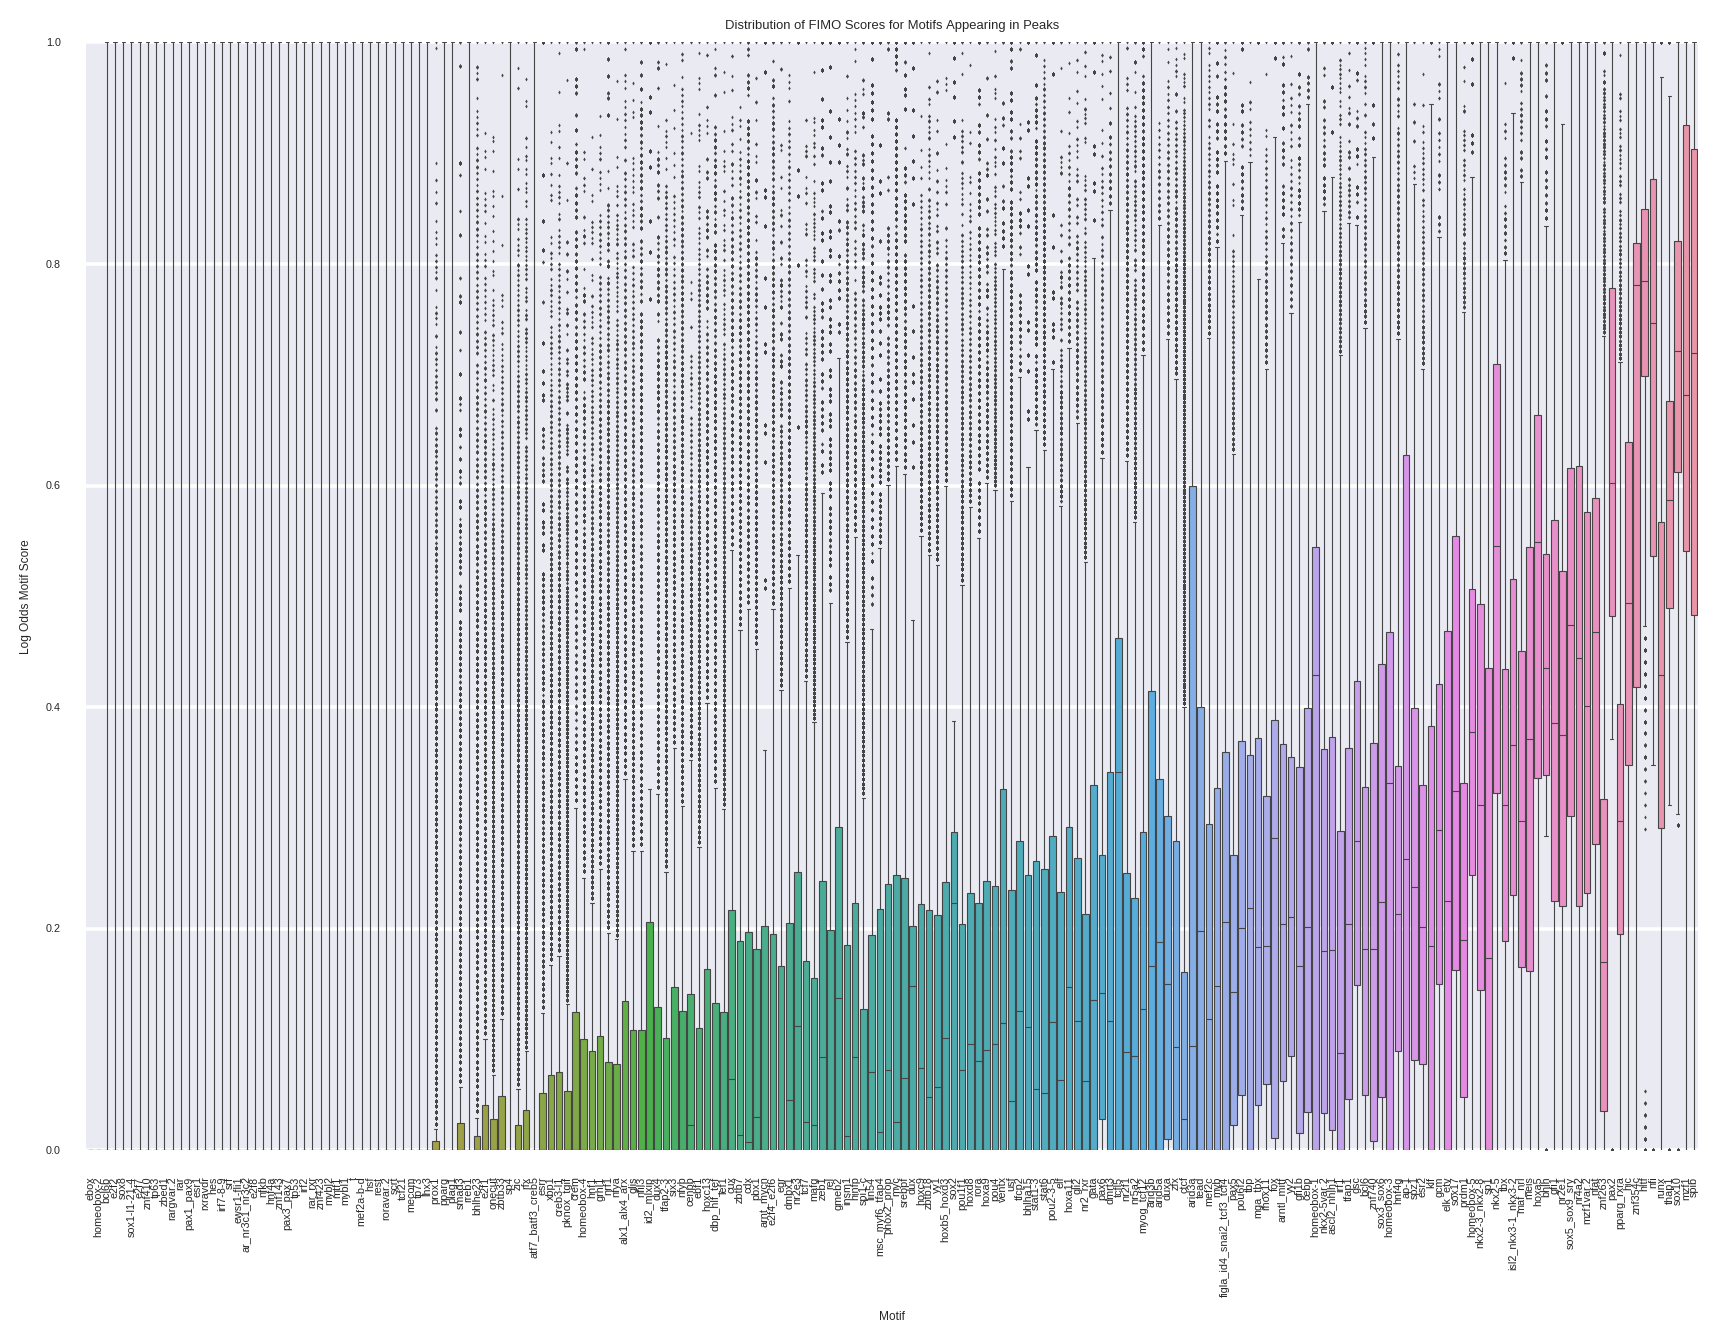

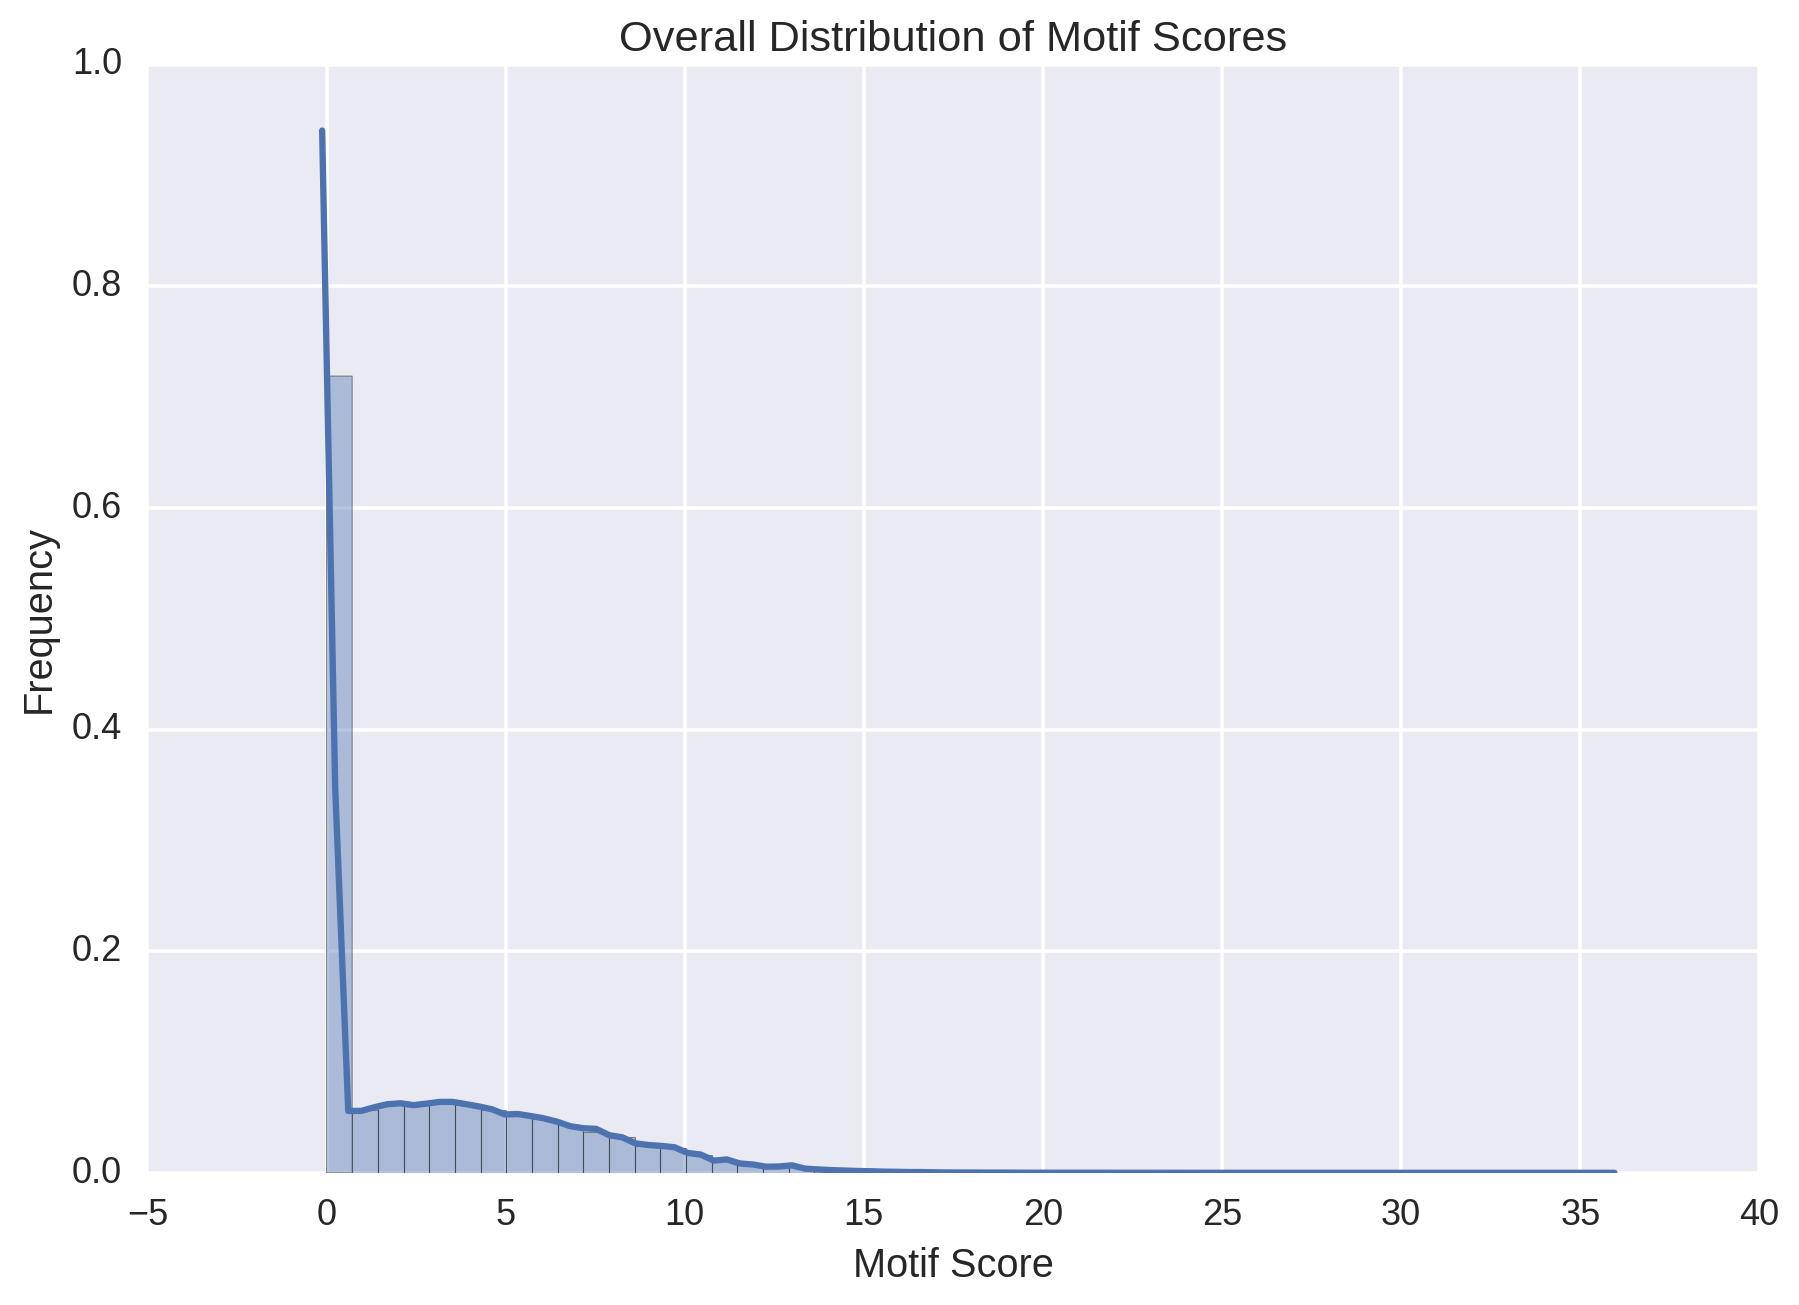

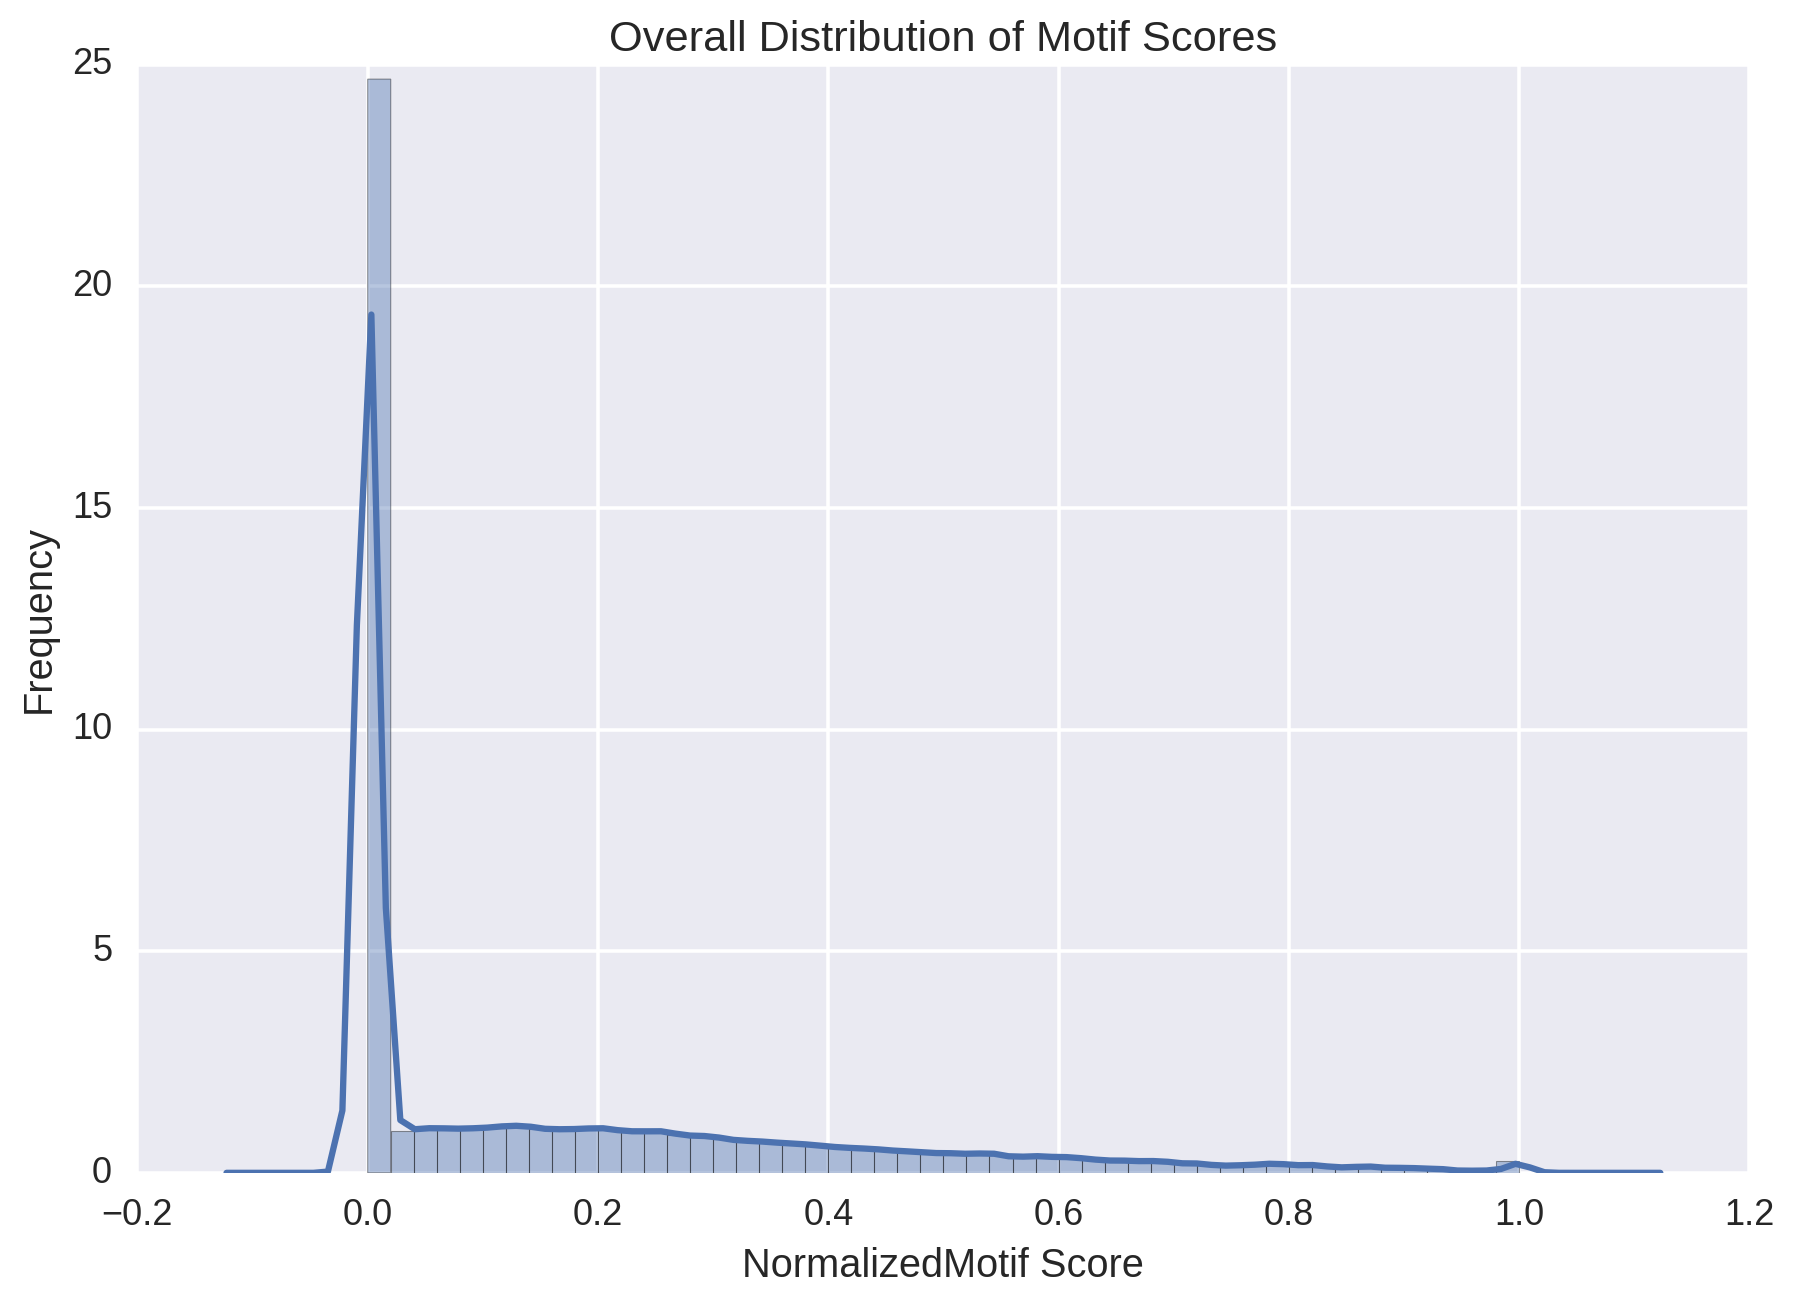

In [30]:
# plot distribution of motif scores
sns.set_context('talk', font_scale=0.3)
data_dict = {}
count = 0
sort_list = []
for col in motif_score_frame.columns[3:]:
    data_dict[col] = motif_score_frame[col].values
    sort_list.append((col, np.mean(motif_score_frame[col].values)))
sort_list = sorted(sort_list,key=lambda x:x[1])
order = [x[0] for x in sort_list]
sns.boxplot(pd.DataFrame(data_dict), 
            fliersize = 1.0,linewidth=0.4,
            order = order)
plt.xticks(rotation=90)
# plt.xticks([])
plt.xlabel("Motif")
plt.ylabel("Log Odds Motif Score")
plt.title("Distribution of FIMO Scores for Motifs Appearing in Peaks")
plt.savefig('motifScore_boxplot.pdf')
plt.show()
del data_dict
sns.set_context('talk', font_scale=1.0)

# plot distribution of normed motif scores
sns.set_context('talk', font_scale=0.3)
data_dict = {}
count = 0
sort_list = []
for col in normed_motif_frame.columns:
    data_dict[col] = normed_motif_frame[col].values
    sort_list.append((col, np.mean(motif_score_frame[col].values)))
sort_list = sorted(sort_list,key=lambda x:x[1])
order = [x[0] for x in sort_list]
sns.boxplot(pd.DataFrame(data_dict), 
            fliersize = 1.0,linewidth=0.4,
            order = order)
plt.xticks(rotation=90)
# plt.xticks([])
plt.xlabel("Motif")
plt.ylabel("Log Odds Motif Score")
plt.title("Distribution of FIMO Scores for Motifs Appearing in Peaks")
plt.savefig('motifScore_normed_boxplot.pdf')
del data_dict
plt.show()
sns.set_context('talk', font_scale=1.0)

sns.distplot(motif_score_frame.ix[:,3:].values.flatten())
plt.title('Overall Distribution of Motif Scores')
plt.xlabel('Motif Score')
plt.ylabel('Frequency')
plt.show()
sns.distplot(normed_motif_frame.ix[:,3:].values.flatten())
# plt.xlim(-0.05, 0.05)
plt.title('Overall Distribution of Motif Scores')
plt.xlabel('NormalizedMotif Score')
plt.ylabel('Frequency')

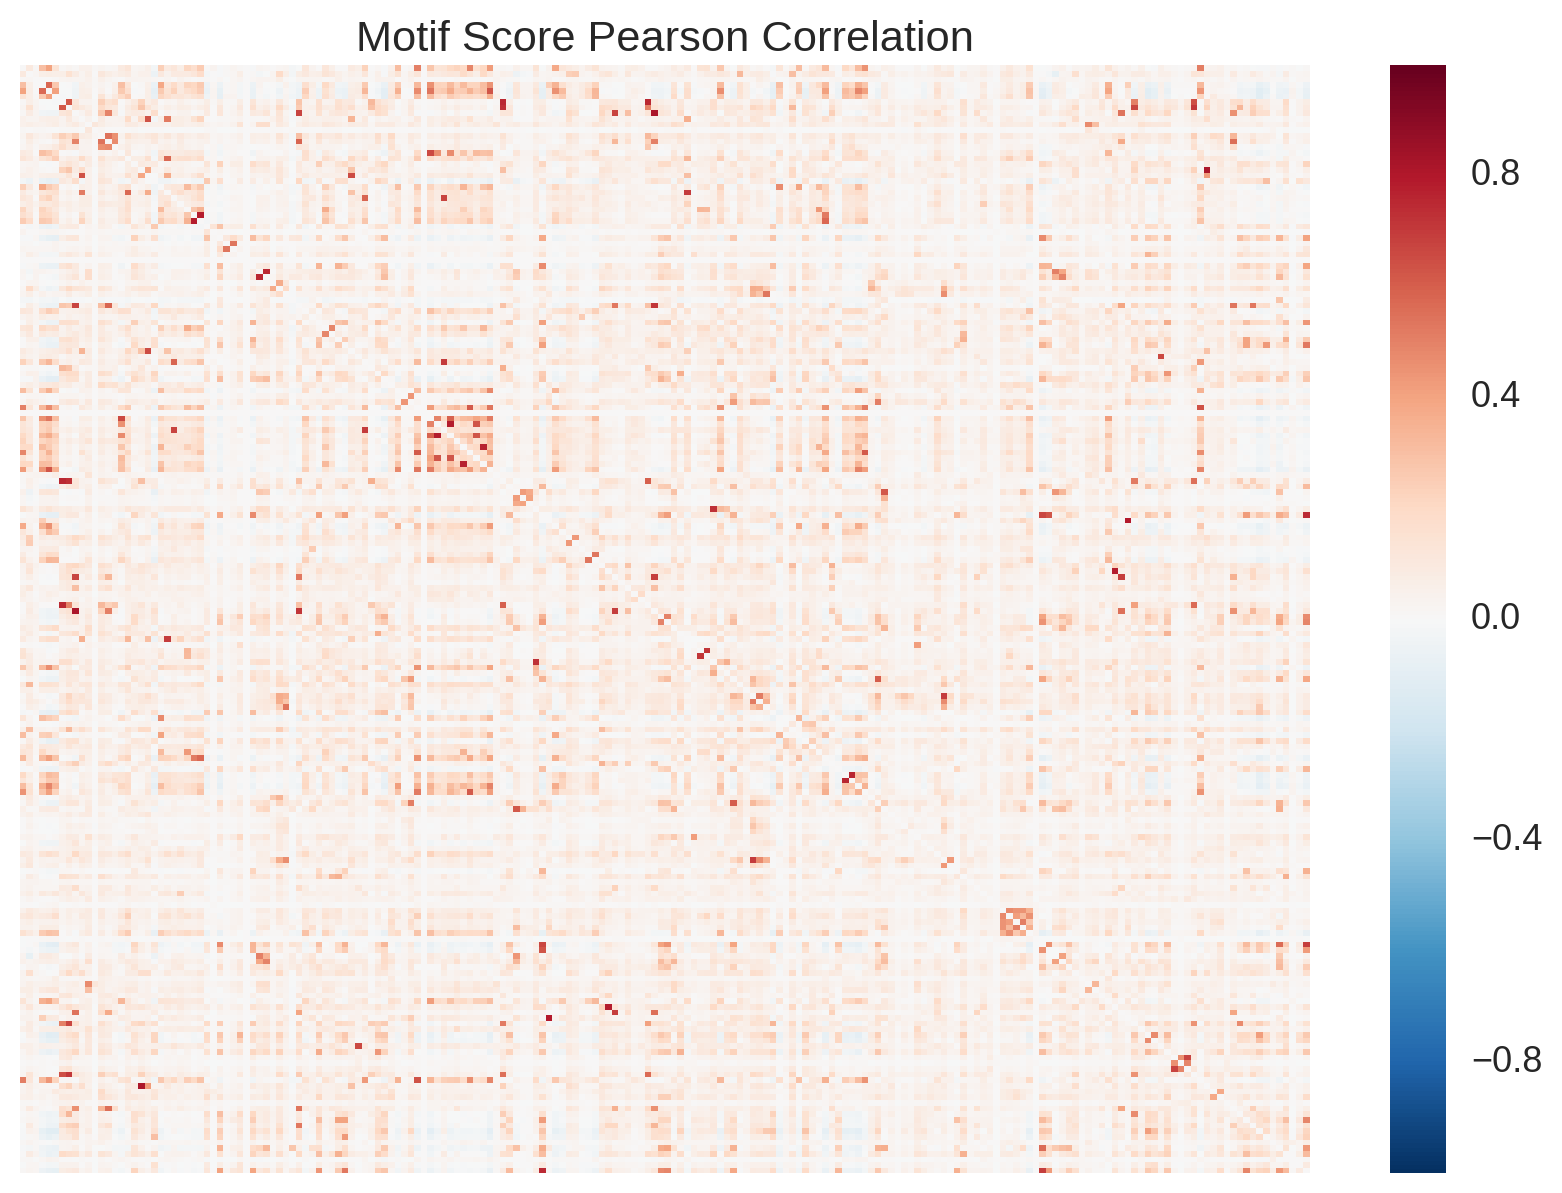

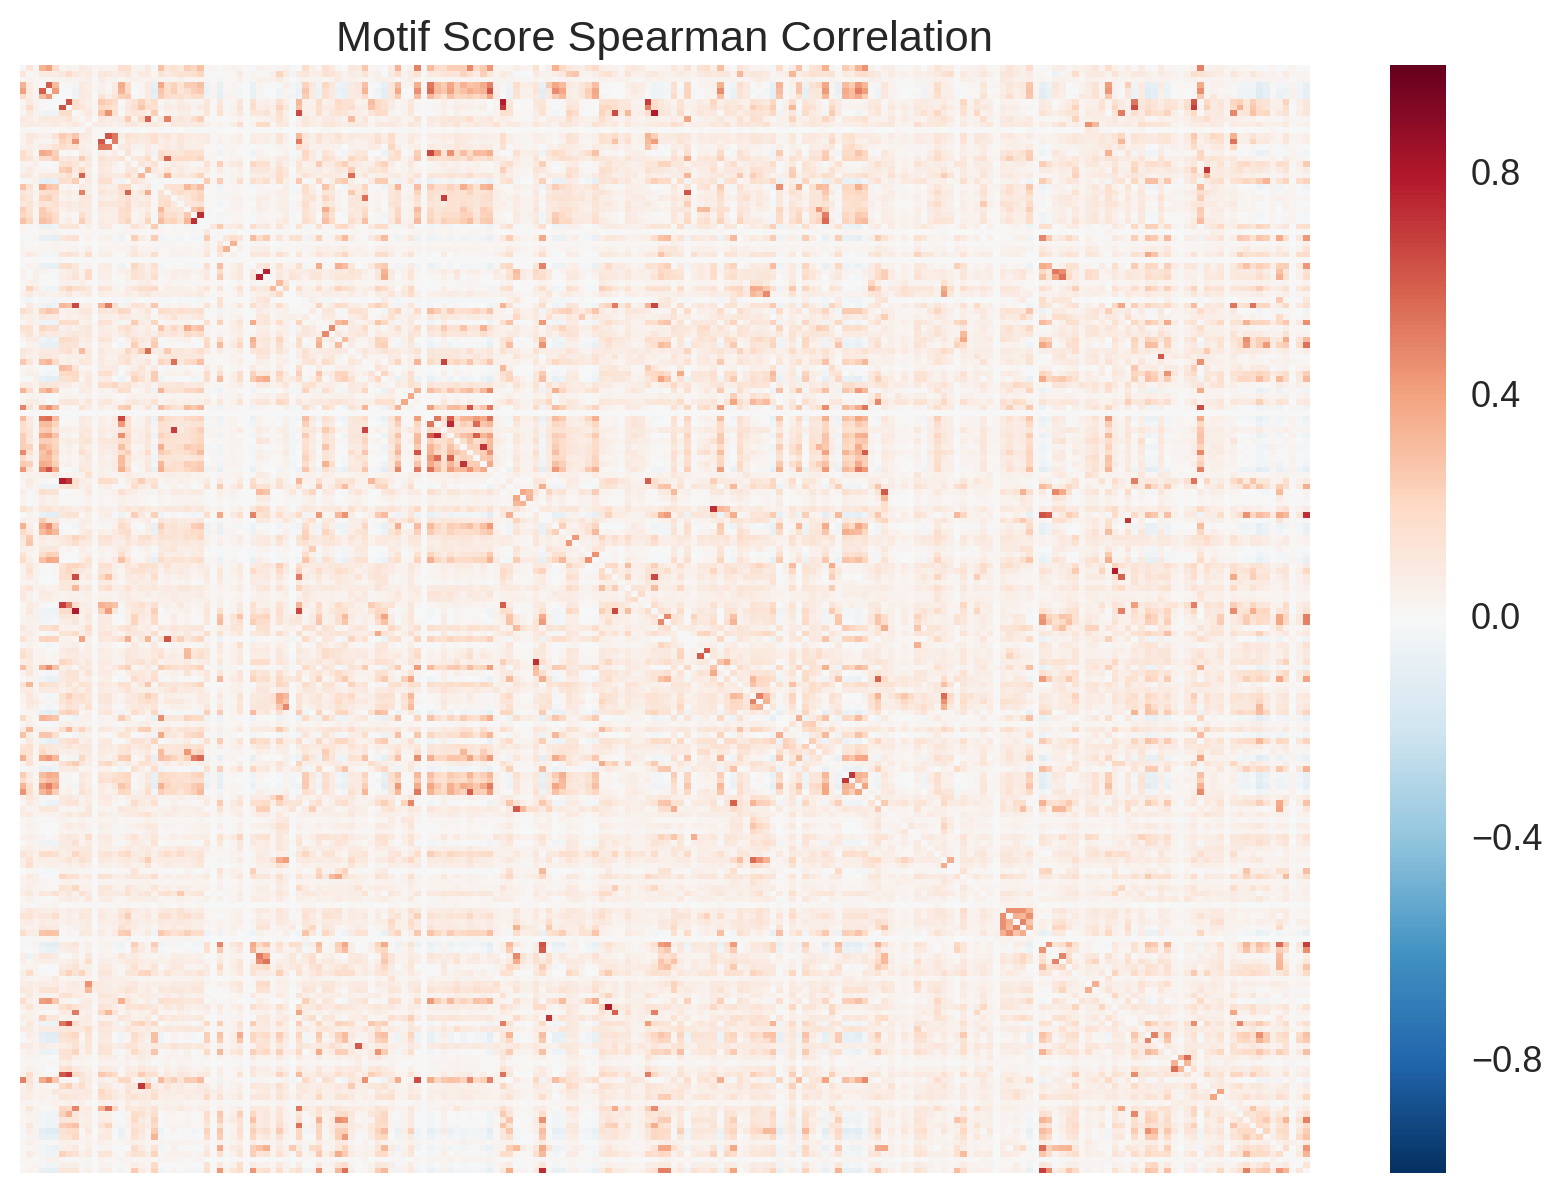

In [31]:
# Show how motif scores correlate to one another
# plot distribution of motif scores
data_dict = {}
count = 0
sort_list = []
motifs = motif_score_frame.columns[3:]
motif_corr_pearson_matrix = np.zeros((len(motifs), len(motifs)))
motif_corr_spearman_matrix = np.zeros((len(motifs), len(motifs)))
# for every pair of motifs
for i in range(len(motifs) -1 ):
    for j in range(i+1, len(motifs)):
        motif1 = motifs[i]
        motif2 = motifs[j]
        # get relevant motif scores
        motifScores1 = motif_score_frame[motif1].values
        motifScores2 = motif_score_frame[motif2].values
        # calculate spearman and peason correlation
        r, p_val_pearson = scipy.stats.pearsonr(motifScores1, motifScores2)
        rho, p_val_spearman = scipy.stats.spearmanr(motifScores1, motifScores2)
        # fill in position in matrix
        motif_corr_pearson_matrix[i][j] = r
        motif_corr_spearman_matrix[i][j] = rho
        motif_corr_pearson_matrix[j][i] = r
        motif_corr_spearman_matrix[j][i] = rho


# create data frames
motif_corr_pearson_frame = pd.DataFrame(motif_corr_pearson_matrix)
motif_corr_spearman_frame = pd.DataFrame(motif_corr_spearman_matrix)

motif_corr_pearson_frame = motif_corr_pearson_frame.fillna(0)
motif_corr_pearson_frame.columns = motifs
motif_corr_pearson_frame.index = motifs

motif_corr_spearman_frame = motif_corr_spearman_frame.fillna(0)
motif_corr_spearman_frame.columns = motifs
motif_corr_spearman_frame.index = motifs

sns.heatmap(motif_corr_pearson_frame,xticklabels = False, yticklabels = False, vmax=1.0)
plt.title('Motif Score Pearson Correlation')
plt.show()

sns.heatmap(motif_corr_spearman_frame,xticklabels = False, yticklabels = False, vmax=1.0)
plt.title('Motif Score Spearman Correlation')
plt.show()

In [ ]:
sns.distplot(motif_corr_pearson_frame.max(), bins=20)
plt.xlim(0,1)
plt.title('Distribution of Pearson Correlations')
plt.show()
sns.distplot(motif_corr_spearman_frame.max(), bins=20)
plt.xlim(0,1)
plt.title('Distribution of Spearman Correlations')

In [ ]:
### show difference between correlation matrices of normalized and un-normalized motif scores

threshold=0.5
current_frame = motif_corr_pearson_frame.copy()
# current_frame[current_frame > 0.65] = 0.0

idxmax_series = current_frame.idxmax(axis=1)
factors = idxmax_series.index.values
most_correlated_factors = idxmax_series.values

network = nx.DiGraph()
seen_factors = set()
for factor in factors:
    if current_frame[factor].max() > threshold:
        network.add_node(factor, factor=factor)
        seen_factors.add(factor)
for i in range(len(factors)):
    currentFactor = factors[i]
    current_mostCorrelated = most_correlated_factors[i]
    pearson_corr = current_frame.ix[currentFactor, current_mostCorrelated]
    if pearson_corr > threshold:
#         print(currentFactor, current_mostCorrelated, pearson_corr)
        if not current_mostCorrelated in seen_factors:
            network.add_node(current_mostCorrelated, factor=current_mostCorrelated)
            seen_factors.add(current_mostCorrelated)
        network.add_edge(currentFactor, 
                         current_mostCorrelated, 
                        pearson = pearson_corr)

edgewidth=[]
for (u,v,d) in network.edges(data=True):
    edgewidth.append(network.get_edge_data(u,v)['pearson'])
edgewidth = np.array(edgewidth)* 1.0

nx.draw_spring(network, 
                node_size=400, 
                node_color='lightblue',
                width=edgewidth,
               labels=dict(zip(seen_factors,seen_factors)),
               font_size=4
                )



plt.gca().set_aspect('equal')

## Clustering

In [ ]:
### hierarchically cluster peaks in vehicle conditions and do de novo motif analysis on each cluster ###
numClusters = 2
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + 
                     sns.color_palette("Set1") + 
                     sns.color_palette("Set2") + 
                     sns.color_palette("husl") +
                     sns.color_palette("Paired")
                    ))

indices = summary_frame[(summary_frame['Factors'].str.contains('_veh'))].index

data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
data = data[[x for x in data.columns if '_veh' in x and not 'atac' in x]]
data = data[data.max(axis=1) > 0.0]
logged_data = np.log2(data+1)

est = KMeans(n_clusters=numClusters, n_jobs=4)
est.fit(logged_data.ix[:,4:])
colors = [colorDict[x] for x in est.labels_]

cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=True,
          cmap='Blues',
          row_colors=colors)


In [ ]:
### hierarchically cluster peaks in KLA condition and do de novo motif analysis on each cluster ###
numClusters = 2
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))

indices = summary_frame[(summary_frame['Factors'].str.contains('_kla'))].index

data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
data = data[[x for x in data.columns if '_kla' in x and not 'atac' in x]]
data = data[data.max(axis=1) > 0.0]
logged_data = np.log2(data+1)

est = KMeans(n_clusters=numClusters, n_jobs=4)
est.fit(logged_data.ix[:,4:])
colors = [colorDict[x] for x in est.labels_]

cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=True,
          cmap='Reds',
          row_colors=colors)





In [ ]:
### hierarchically cluster peaks in all condition and do de novo motif analysis on each cluster ###
numClusters = 2
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))

indices = summary_frame.index

data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
data = data[[x for x in data.columns if not 'atac' in x]]
data = data[data.max(axis=1) > 0.0]
logged_data = np.log2(data+1)

est = KMeans(n_clusters=numClusters, n_jobs=4)
est.fit(logged_data.ix[:,4:])
colors = [colorDict[x] for x in est.labels_]

cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=True,
          col_cluster=False,
          row_colors=colors)





## De Novo Motif Analysis

In [ ]:
if not os.path.isdir('./denovo_motif_analysis'):
    os.mkdir('./denovo_motif_analysis')
else:
    ! rm -rf ./denovo_motif_analysis/*
    
if not os.path.isdir('./denovo_motif_analysis/veh_peaks'):
    os.mkdir('./denovo_motif_analysis/veh_peaks')
else:
    ! rm -rf ./denovo_motif_analysis/veh_peaks*
    
if not os.path.isdir('./denovo_motif_analysis/kla_peaks'):
    os.mkdir('./denovo_motif_analysis/kla_peaks')
else:
    ! rm -rf ./denovo_motif_analysis/kla_peaks*

In [ ]:
### for interesting vehicle groups ###
veh_groups = [
['pu1'],
['pu1', 'cebpa'],
['pu1', 'cebpa', 'cjun'],
['pu1', 'cjun'],
['cjun', 'atf3'],
['cjun'],
['cebpa'],
    ['atf3']
    ]

# get set of factors that appear in interesting groups
factors = set()
for group in veh_groups:
    for f in group:
        factors.add(f)
factors = sorted(list(factors))
index_factors_tuples = tuple(zip(summary_frame.index.values, summary_frame['Factors'].values))

# get summary frame subset with relevant columns and updated factors column
indices_with_targetFactors = []
updated_factors_list = []
for index, factorsAtPeak in index_factors_tuples:
    updated_factors = ','.join(sorted(set([x for x in factorsAtPeak.split(',') if not 'kla' in x and x.split('_')[0] in factors])))
    if updated_factors:
        indices_with_targetFactors.append(index)
        updated_factors_list.append(updated_factors)
index_updatedFactors_dict = dict(zip(indices_with_targetFactors, updated_factors_list))
current_frame = summary_frame[summary_frame.index.isin(indices_with_targetFactors)]\
[['chr', 'Position','ID'] + [x+'_veh' for x in factors]]
current_frame['Factors'] = [index_updatedFactors_dict[x] for x in current_frame['ID'].values]

for factor_group in sorted(set(current_frame['Factors'])):
    current_peak_frame = current_frame[current_frame['Factors']==factor_group]
    current_peak_frame['start'] = [x.split(':')[1].split('-')[0] for x in current_peak_frame['Position'].values]
    current_peak_frame['end'] = [x.split(':')[1].split('-')[1] for x in current_peak_frame['Position'].values]
    current_peak_frame = current_peak_frame.drop('Position', axis=1)
    current_peak_frame = current_peak_frame.drop('Factors', axis=1)
    current_peak_frame['strand'] = '+'
    current_peak_frame = current_peak_frame[['ID', 'chr', 'start', 'end', 'strand'] + [x+'_veh' for x in factors]]
    columns = current_peak_frame.columns.values
    columns[0]='#PeakID'
    current_peak_frame.columns = columns
    if current_peak_frame.shape[0]  > 100:
        print(factor_group.replace('_veh','').replace(',','_'), current_peak_frame.shape)
        current_peak_frame.to_csv('./denovo_motif_analysis/veh_peaks/'+factor_group.replace('_veh','').replace(',','_')
                                  +'_veh_peaks.tsv',
                                 index=False,
                                 sep='\t')
    

In [ ]:
### for interesting KLA groups ###
kla_groups = [
['p65'],
['cebpa'],
['pu1', 'p65'],
['pu1', 'fos', 'p65'],
['pu1'],
['pu1', 'fos'],
['fos'],
['fos', 'cjun', 'junb'],
['fos', 'p65', 'cjun', 'jund', 'junb'],
['pu1', 'fos', 'p65', 'cjun', 'jund', 'junb'],
['pu1', 'fos', 'cjun', 'jund', 'atf3', 'junb'],
['pu1', 'fos', 'cebpa', 'p65', 'jund']
]
# get set of factors that appear in interesting groups
factors = set()
for group in kla_groups:
    for f in group:
        factors.add(f)
factors = sorted(list(factors))
index_factors_tuples = tuple(zip(summary_frame.index.values, summary_frame['Factors'].values))

# get summary frame subset with relevant columns and updated factors column
indices_with_targetFactors = []
updated_factors_list = []
for index, factorsAtPeak in index_factors_tuples:
    updated_factors = ','.join(sorted(set([x for x in factorsAtPeak.split(',') if not 'veh' in x and x.split('_')[0] in factors])))
    if updated_factors:
        indices_with_targetFactors.append(index)
        updated_factors_list.append(updated_factors)
index_updatedFactors_dict = dict(zip(indices_with_targetFactors, updated_factors_list))
current_frame = summary_frame[summary_frame.index.isin(indices_with_targetFactors)]\
[['chr', 'Position','ID'] + [x+'_kla' for x in factors]]
current_frame['Factors'] = [index_updatedFactors_dict[x] for x in current_frame['ID'].values]

for factor_group in sorted(set(current_frame['Factors'])):
    current_peak_frame = current_frame[current_frame['Factors']==factor_group]
    current_peak_frame['start'] = [x.split(':')[1].split('-')[0] for x in current_peak_frame['Position'].values]
    current_peak_frame['end'] = [x.split(':')[1].split('-')[1] for x in current_peak_frame['Position'].values]
    current_peak_frame = current_peak_frame.drop('Position', axis=1)
    current_peak_frame = current_peak_frame.drop('Factors', axis=1)
    current_peak_frame['strand'] = '+'
    current_peak_frame = current_peak_frame[['ID', 'chr', 'start', 'end', 'strand'] + [x+'_kla' for x in factors]]
    columns = current_peak_frame.columns.values
    columns[0]='#PeakID'
    current_peak_frame.columns = columns
    if current_peak_frame.shape[0]  > 100:
        print(factor_group.replace('_kla','').replace(',','_'), current_peak_frame.shape)
        current_peak_frame.to_csv('./denovo_motif_analysis/kla_peaks/'+factor_group.replace('_kla','').replace(',','_')
                                  +'_kla_peaks.tsv',
                                 index=False,
                                 sep='\t')
    
    

In [ ]:
### generate bash command for running denovo motif analysis ###
!echo findMotifsWrapper.sh /home/jenhan/analysis/cobinding_motif_analysis/denovo_motif_analysis/veh_peaks/ /home/jenhan/analysis/cobinding_motif_analysis/denovo_motif_analysis/veh_motif_analysis mm10 200
!echo findMotifsWrapper.sh /home/jenhan/analysis/cobinding_motif_analysis/denovo_motif_analysis/kla_peaks/ /home/jenhan/analysis/cobinding_motif_analysis/denovo_motif_analysis/kla_motif_analysis mm10 200

## Elbow Plot for K-means Clustering

In [ ]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist

data = normed_motif_frame.values        
K = range(1,10)

# scipy.cluster.vq.kmeans
KM = [kmeans(data,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/data.shape[0] for d in dist]

# elbow curve
plt.plot(K, avgWithinSS, 'b*-')

plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

plt.show()

## PCA on Peak Scores

In [ ]:
### PCA on all peaks
numRowClusters = 2

numColors = 20
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))


# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(normed_summary_frame)
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(normed_summary_frame)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on all Peaks (Normalized Peak Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(normed_summary_frame.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh -'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values + 1))
    gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA -'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values + 1))
    
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']
    
    reads = reads + gro_kla
    treatments = treatments + len(current_indices) * ['kla']
    
    clusters = clusters + 2 * len(current_indices) * [str(cluster)]
    
    factor = factor + 2 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads', hue='treatment', 
                data= data_frame, 
                kind='box',
                size=10,
                width=0.4,
                whis=1,
                showfliers=False)
plt.ylim([0,12])
plt.show()

In [ ]:
### PCA on all peaks
numRowClusters = 2
numColClusters = 8

numColors = 20
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))

# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(np.log2(summary_frame.ix[:,4:] + 1))
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(summary_frame.ix[:,4:])
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on all Peaks (Un-normalized Peak Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(normed_summary_frame.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values + 1))
    gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values + 1))
    
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']
    
    reads = reads + gro_kla
    treatments = treatments + len(current_indices) * ['kla']
    
    clusters = clusters + 2 * len(current_indices) * [str(cluster)]
    
    factor = factor + 2 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads', hue='treatment', 
           data= data_frame, 
           kind='box',
           size=10,
           width=0.4,
           whis=1,
              showfliers=False)
plt.ylim([0,12])
plt.show()

## PCA on Motifs Scores

In [ ]:
### PCA on all peaks
numRowClusters = 2

numColors = 20
colorDict = dict(zip(range(numColors),sns.color_palette("Set2") + sns.color_palette("colorblind")))

# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(motif_score_frame.ix[:,3:])
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(motif_score_frame.ix[:,3:])
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on all Peaks (Un-normalized Motif Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(motif_score_frame.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh -'].values + 1))
    gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA -'].values+ 1))
    
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']
    
    reads = reads + gro_kla
    treatments = treatments + len(current_indices) * ['kla']
    
    clusters = clusters + 2 * len(current_indices) * [str(cluster)]
    
    factor = factor + 2 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads', hue='treatment', 
           data= data_frame, 
           kind='box',
           size=10,
           width=0.4,
           whis=1,
              showfliers=False)
plt.ylim([0,12])
plt.show()

In [ ]:
### PCA on all normed peaks
numRowClusters = 2
numColClusters = 8

# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(normed_motif_frame)
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(normed_motif_frame)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on all Peaks (Normalized Motif Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(normed_motif_frame.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh -'].values + 1))
    gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA -'].values+ 1))

   
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']
    
    reads = reads + gro_kla
    treatments = treatments + len(current_indices) * ['kla']
    
    clusters = clusters + 2 * len(current_indices) * [str(cluster)]
    
    factor = factor + 2 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads', hue='treatment', 
           data= data_frame, 
           kind='box',
           size=10,
           width=0.5,
           whis=1,
              showfliers=False)
# plt.ylim(0,12)
plt.show()

In [ ]:
### PCA on all normed vehicle peaks
numRowClusters = 2
numColClusters = 8

# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)

data = normed_motif_frame[normed_motif_frame.index.isin(
    summary_frame[summary_frame['Factors'].str.contains('veh')].index.values)]
est.fit(data)
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(data)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on Vehicle Peaks (Normalized Motif Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(data.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh -'].values+ 1))   
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']

    clusters = clusters + 1 * len(current_indices) * [str(cluster)]
    
    factor = factor + 1 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads',
           data= data_frame, 
           kind='box',
           size=10,
           width=0.5,
           whis=1,
              showfliers=False)
plt.show()

In [ ]:
### PCA on all normed KLA peaks
numRowClusters = 2
numColClusters = 8

# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)

data = normed_motif_frame[normed_motif_frame.index.isin(
    summary_frame[summary_frame['Factors'].str.contains('kla')].index.values)]
est.fit(data)
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(data)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on KLA Peaks (Normalized Motif Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(data.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA -'].values+ 1))   
    reads = reads + gro_kla
    treatments = treatments + len(current_indices) * ['kla']

    clusters = clusters + 1 * len(current_indices) * [str(cluster)]
    
    factor = factor + 1 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads',
           data= data_frame, 
           kind='box',
           size=10,
           width=0.5,
           whis=1,
              showfliers=False)
plt.show()

## Finding significant motifs

In [ ]:
# find significant motifs with significantly different scores depending on binding or no binding of a factor in notx conditions
#
# use the following tests:
# t-test
# mann-whitney u-test
# Kolmogorov–Smirnov test
# p_threshold = 0.01 / (merged_motif_frame.shape[1] * merged_motif_frame.shape[0])
p_threshold = 0.01 / (merged_motif_frame.shape[1])


columns = summary_frame.columns[3:]
ttest_dict = {x:[] for x in columns}
mannwhitney_dict = {x:[] for x in columns}
median_dict = {x:[] for x in columns}
kruskal_dict = {x:[] for x in columns}
ks_dict = {x:[] for x in columns}
enriched_dict = {x:[] for x in columns}

ttest_stat_dict = {x:[] for x in columns}
mannwhitney_stat_dict = {x:[] for x in columns}
median_stat_dict = {x:[] for x in columns}
kruskal_stat_dict = {x:[] for x in columns}
ks_stat_dict = {x:[] for x in columns}

for f in columns:
    print(f)
    binding_positions = summary_frame[f] > 0
    null_positions = summary_frame[f] == 0
    
    current_ttest = ttest_dict[f]
    current_mwu = mannwhitney_dict[f]
    current_ks = ks_dict[f]
    current_med = median_dict[f]
    current_krus = kruskal_dict[f]
    
    current_ttest_stat = ttest_stat_dict[f]
    current_mwu_stat = mannwhitney_stat_dict[f]
    current_ks_stat = ks_stat_dict[f]
    current_med_stat = median_stat_dict[f]
    current_krus_stat = kruskal_stat_dict[f]
    
    current_enriched = enriched_dict[f]
    for col in merged_motif_frame.columns[3:]:
        
        binding_scores = normed_motif_frame[col][binding_positions].values
#         null_scores = merged_motif_frame[col][null_positions].values       
        null_scores = normed_motif_frame[col].values
    
        ttest_stat, ttest_pval = scipy.stats.ttest_ind(binding_scores,null_scores,equal_var=False)
        mwu_stat, mwu_pval = scipy.stats.mannwhitneyu(binding_scores, null_scores)
        ks_stat, ks_pval = scipy.stats.ks_2samp(binding_scores,null_scores)
        med_stat, med_pval, m, table = scipy.stats.median_test(binding_scores, null_scores)
        kru_stat, kru_pval = scipy.stats.kruskal(binding_scores, null_scores)
        
        current_ttest.append(ttest_pval)
        current_mwu.append(mwu_pval/2.0) # correct for one tailed test
        current_ks.append(ks_pval)
        current_med.append(med_pval)
        current_krus.append(kru_pval)
        
        current_ttest_stat.append(ttest_stat)
        current_mwu_stat.append(mwu_stat) # correct for one tailed test
        current_ks_stat.append(ks_stat)
        current_med_stat.append(med_stat)
        current_krus_stat.append(kru_stat)
        
        if np.mean(binding_scores) > np.mean(null_scores) and np.median(binding_scores) > 0:
            current_enriched.append(1)
        else:
            current_enriched.append(0)

# convert dictionaries to data frames for plotting
ttest_frame = pd.DataFrame(ttest_dict)
ttest_frame = ttest_frame.fillna(1)
ttest_frame.index = merged_motif_frame.columns[3:]

mannwhitney_frame = pd.DataFrame(mannwhitney_dict)
mannwhitney_frame =mannwhitney_frame.fillna(1)
mannwhitney_frame.index = merged_motif_frame.columns[3:]

ks_frame = pd.DataFrame(ks_dict)
ks_frame = ks_frame.fillna(1)
ks_frame.index = merged_motif_frame.columns[3:]

median_frame = pd.DataFrame(median_dict)
median_frame = median_frame.fillna(1)
median_frame.index = merged_motif_frame.columns[3:]

kruskal_frame = pd.DataFrame(kruskal_dict)
kruskal_frame = kruskal_frame.fillna(1)
kruskal_frame.index = merged_motif_frame.columns[3:]

ttest_stat_frame = pd.DataFrame(ttest_stat_dict)
ttest_stat_frame.index = normed_motif_frame.columns

mannwhitney_stat_frame = pd.DataFrame(mannwhitney_stat_dict)
mannwhitney_stat_frame.index = normed_motif_frame.columns

ks_stat_frame = pd.DataFrame(ks_stat_dict)
ks_stat_frame.index = normed_motif_frame.columns

median_stat_frame = pd.DataFrame(median_stat_dict)
median_stat_frame.index = normed_motif_frame.columns

kruskal_stat_frame = pd.DataFrame(kruskal_stat_dict)
kruskal_stat_frame.index = normed_motif_frame.columns

bool_ttest_frame = pd.DataFrame(ttest_frame < p_threshold) + 0
bool_ks_frame = pd.DataFrame(ks_frame < p_threshold) + 0
bool_mannwhitney_frame = pd.DataFrame(mannwhitney_frame < p_threshold) + 0
bool_median_frame = pd.DataFrame(median_frame < p_threshold) + 0
bool_kruskal_frame = pd.DataFrame(kruskal_frame < p_threshold) + 0

enriched_frame=pd.DataFrame(enriched_dict)
enriched_frame.index = normed_motif_frame.columns

In [ ]:
vals = (bool_ks_frame 
        + bool_ttest_frame 
        + bool_mannwhitney_frame 
        + bool_median_frame 
        + bool_kruskal_frame).values.flatten()
sns.distplot(vals, kde=False)
plt.xticks(range(6));
plt.ylabel('Frequency')
plt.xlabel('Number of Tests Passed')
plt.title('Agreement between Statistical Tests')

In [ ]:
### plot distribution of ks statistic ###
vals = ks_stat_frame.values.flatten()
sns.distplot(vals, kde=True)
plt.xlim([-0.1,0.5])
plt.title('Distribution of KS Statistic (small values are bad)')
plt.xlabel('KS Statistic')
plt.ylabel('Frequency')
mean=np.mean(vals)
sigma=1
confidence_interval = scipy.stats.norm.interval(0.68, loc=mean, scale=sigma/np.sqrt(normed_motif_frame.shape[1]))
plt.plot([mean, mean], [0,10], color ='red', linestyle='--')
plt.plot([confidence_interval[0], confidence_interval[0]], [0,10], color ='red', linestyle='--')
plt.plot([confidence_interval[1], confidence_interval[1]], [0,10], color ='red', linestyle='--')
plt.show()

### plot ks statistic vs p-value
plt.scatter(ks_stat_frame.values.flatten(), ks_frame.values.flatten(), marker='.')
plt.plot([0,1], [0.05,0.05], color ='red', linestyle='--') # p_threshold
plt.plot([confidence_interval[0], confidence_interval[0]], [0,1], color ='red', linestyle='--') # confidence interval
plt.plot([confidence_interval[1], confidence_interval[1]], [0,1], color ='red', linestyle='--') # confidence interval
plt.title('KS Statistic vs. Pvalue')
plt.ylabel('Pvalue')
plt.xlabel('KS Statistic')
plt.xlim([0,0.3])
plt.show

In [ ]:
p_threshold = 0.01 / (merged_motif_frame.shape[1]) # of motifs
ks_threshold = confidence_interval[0]
bool_ks_p_frame = pd.DataFrame(ks_frame < p_threshold) + 0
bool_ks_stat_frame = pd.DataFrame(ks_stat_frame > ks_threshold) + 0

bool_motif_frame = bool_ks_p_frame + bool_ks_stat_frame + enriched_frame
# bool_frame = bool_ks_p_frame + enriched_frame


bool_motif_frame = pd.DataFrame(bool_motif_frame >= 3) + 0.0 # has to path both ks_threshold and p_value threshold

In [ ]:
### elbow plot for heatmap representation ###
data = bool_frame.values
K = range(1,10)

# scipy.cluster.vq.kmeans
KM = [kmeans(data,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/data.shape[0] for d in dist]

# elbow curve
plt.plot(K, avgWithinSS, 'b*-')

plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering for Heatmap of Significant Motifs')

plt.show()

In [ ]:
numColors = 20
colorDict = dict(zip(range(numColors),sns.color_palette("Set2") + sns.color_palette("colorblind")))


### heatmap representation of significant values ###  
current_frame = bool_frame.copy()
current_frame = current_frame[current_frame.sum(axis=1) >= 2] # motifs have to be significant to at least 2 factors 

numClusters = int(np.sqrt(current_frame.shape[0]/2))
print(numClusters)
est = KMeans(n_clusters=numClusters)
est.fit(current_frame)
current_frame['cluster'] = est.labels_

current_frame = current_frame.sort('cluster')
colors = [colorDict[x] for x in current_frame['cluster']]

# change coloring of kla columns
for col in current_frame.columns:
    if 'kla' in col:
        current_frame[col] = [x + 1 if x==1 else x for x in current_frame[col].values]

cg = sns.clustermap(current_frame.ix[:,:-1], # exclude cluster column 
                    cmap="Blues",
                    linewidths=0.05,
                    col_cluster=False,
                    row_cluster=False,
                    row_colors=colors
                   )

# adjust heatmap positioning
hm = cg.ax_heatmap.get_position()
cg.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*0.5, hm.height*2.25])

# adjust row dendrogram positioning
row = cg.ax_row_dendrogram.get_position()
cg.ax_row_dendrogram.set_position([row.x0, row.y0, row.width, row.height*2.25])

# adjust row color positioning
rc = cg.ax_row_colors.get_position()
cg.ax_row_colors.set_position([rc.x0, rc.y0, rc.width, rc.height*2.25])
# hide color bar
cg.cax.set_visible(False)

# adjust fontscale for tic labels
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=5, rotation=0)
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10, rotation=90)

# hide color bar
cg.cax.set_visible(False)
plt.savefig('motif_heatmap.pdf',bbox_inches='tight')

In [ ]:
# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=9)
est.fit(bool_kruskal_frame)
est.labels_
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(bool_ttest_frame)
explained_variance_ratios = model.explained_variance_ratio_
ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors, s=30)
ax.set_title("PCA of Motifs")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')
classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)


## Finding Significant Motifs in each Cluster

In [ ]:
! if [ ! -d /home/jenhan/analysis/cobinding_motif_analysis/motif_clustering/ ]; then mkdir /home/jenhan/analysis/cobinding_motif_analysis/motif_clustering/; fi

significant_motifs_dict = {}
motif_difference_dict = {}
p_threshold = 0.05/ len(normed_motif_frame.columns.values)

In [ ]:
colorDict = {'high':(0.40000000596046448, 0.7607843279838562, 0.64705884456634521),
            'low':(0.98131487965583808, 0.55538641635109398, 0.38740485135246722),
            'all':(0.55432528607985565, 0.62711267120697922, 0.79595541393055635)}

### PCA on all veh peaks ###
numRowClusters = 2
numColClusters = 8

# calculate k-means cluster for use in coloring
data = normed_motif_frame[normed_motif_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('veh')].index.values)]

est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(data)

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(data.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh'].values + 1))
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']

    clusters = clusters + 1* len(current_indices) * [str(cluster)]

    factor = factor + 1 * len(current_indices) * ['gro']
    for ind in current_indices:
        indices.append(ind)
data_frame = pd.DataFrame({'log2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters,
                          'index': indices})

current_frame = data_frame

# rename clusters
clusterMed_0 = np.median(current_frame[current_frame['cluster']=='0']['log2 reads'])
clusterMed_1 = np.median(current_frame[current_frame['cluster']=='1']['log2 reads'])

highColor = colorDict['high']
lowColor = colorDict['low']

if  clusterMed_0 < clusterMed_1:
    data_frame['cluster'] = ['high' if x == '1' else 'low' for x in data_frame['cluster'].values]
    cluster_colors = [highColor if x == 1 else lowColor for x in est.labels_]
    index_cluster_dict = dict(zip(data.index.values, ['high' if x == 1 else 'low' for x in est.labels_] ))



else:
    data_frame['cluster'] = ['low' if x == '1' else 'high' for x in data_frame['cluster'].values]
    cluster_colors = [highColor if x == 0 else lowColor for x in est.labels_]
    index_cluster_dict = dict(zip(data.index.values, ['high' if x == 0 else 'low' for x in est.labels_] ))

# determine colors for plots
classes = ['low', 'high', 'all']
class_colours = [colorDict[x] for x in classes]


### create all cluster ###
all_cluster_frame = data_frame.copy()
all_cluster_frame['cluster'] = 'all'
data_frame = pd.concat([data_frame, all_cluster_frame])

### plot gro-seq activity ###
sns.factorplot(x='cluster',y='log2 reads', 
                data= data_frame, 
                kind='box',
                size=10,
                width=0.3,
                palette=class_colours,
                order = ['low', 'high', 'all']
                )
plt.title('Groseq in 1kbp window for veh peaks')
plt.savefig('./motif_clustering/groseq_cluster_all_veh.pdf')
plt.show()


### plot clustering ###
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(data)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=cluster_colors)
ax.set_title("PCA on all vehicle Peaks")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

recs = []
for i in range(0,2):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))

plt.legend(recs,['low', 'high'],loc=4)
plt.savefig('./motif_clustering/clustering_all_veh.pdf')
plt.show()



### plot motif scores ###
plotting_frame = pd.DataFrame(data.stack())
plotting_frame['cluster'] = [index_cluster_dict[x[0]] for x in plotting_frame.index.values]
plotting_frame.columns = ['motif score', 'cluster']
plotting_frame['motif name'] = [x[1] for x in plotting_frame.index.values]
plotting_frame['peak id'] = [x[0] for x in plotting_frame.index.values]

all_cluster_frame = plotting_frame.copy()
all_cluster_frame['cluster'] = 'all'
plotting_frame = pd.concat([plotting_frame, all_cluster_frame])

significant_motifs = []
order_tuples= []
for motif in set(plotting_frame['motif name'].values):
    current_motif_frame = plotting_frame[plotting_frame['motif name'] == motif]
    scores1 = current_motif_frame[current_motif_frame['cluster'] == 'high']['motif score'].values
    scores2 = current_motif_frame[current_motif_frame['cluster'] == 'low']['motif score'].values
    stat, pval = scipy.stats.ks_2samp(scores1, scores2)
    mean = max(np.mean(scores1), np.mean(scores2))
    if pval < p_threshold and mean >0.0:
        significant_motifs.append(motif)
        order_tuples.append((motif, np.mean(scores1) - np.mean(scores2)))

significant_motifs_dict['all_veh'] = significant_motifs
if len(significant_motifs) > 0:
    # sort motifs by mean difference between the two clusters and plot the differences
    motif_difference_dict['all_veh'] = order_tuples
    order = [x[0] for x in sorted(order_tuples, key=lambda x: x[1])]
    differences = [x[1] for x in sorted(order_tuples, key=lambda x: x[1])]
    frame = pd.DataFrame({'Motif Name': order, 'Motif Score Difference': differences})
    sns.factorplot(data=frame, x='Motif Name', y='Motif Score Difference', kind='bar', size =10, aspect =3)
    plt.xticks(rotation=90);
    plt.savefig('./motif_clustering/motif_differences_all_veh.pdf', bbox_inches='tight')
    plt.close()

    significant_frame = plotting_frame[plotting_frame['motif name'].isin(significant_motifs)]
    sns.factorplot(y='motif score', 
                   x='motif name', 
                   hue='cluster', 
                   data=significant_frame,
                   kind='box',
                   size=10,
                   aspect=10,
                   order=order,
                   palette=class_colours
    )
    plt.xticks(rotation=90)
    plt.savefig('./motif_clustering/motifs_all_veh.pdf', bbox_inches='tight')
    plt.close()



In [ ]:
colorDict = {'high':(0.40000000596046448, 0.7607843279838562, 0.64705884456634521),
            'low':(0.98131487965583808, 0.55538641635109398, 0.38740485135246722),
            'all':(0.55432528607985565, 0.62711267120697922, 0.79595541393055635)}

### PCA on all kla peaks ###
numRowClusters = 2
numColClusters = 8

# calculate k-means cluster for use in coloring
data = normed_motif_frame[normed_motif_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('kla')].index.values)]

est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(data)

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(data.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA'].values + 1))
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['kla']

    clusters = clusters + 1* len(current_indices) * [str(cluster)]

    factor = factor + 1 * len(current_indices) * ['gro']
    for ind in current_indices:
        indices.append(ind)
data_frame = pd.DataFrame({'log2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters,
                          'index': indices})

current_frame = data_frame

# rename clusters
clusterMed_0 = np.median(current_frame[current_frame['cluster']=='0']['log2 reads'])
clusterMed_1 = np.median(current_frame[current_frame['cluster']=='1']['log2 reads'])

highColor = colorDict['high']
lowColor = colorDict['low']

if  clusterMed_0 < clusterMed_1:
    data_frame['cluster'] = ['high' if x == '1' else 'low' for x in data_frame['cluster'].values]
    cluster_colors = [highColor if x == 1 else lowColor for x in est.labels_]
    index_cluster_dict = dict(zip(data.index.values, ['high' if x == 1 else 'low' for x in est.labels_] ))



else:
    data_frame['cluster'] = ['low' if x == '1' else 'high' for x in data_frame['cluster'].values]
    cluster_colors = [highColor if x == 0 else lowColor for x in est.labels_]
    index_cluster_dict = dict(zip(data.index.values, ['high' if x == 0 else 'low' for x in est.labels_] ))

# determine colors for plots
classes = ['low', 'high', 'all']
class_colours = [colorDict[x] for x in classes]


### create all cluster ###
all_cluster_frame = data_frame.copy()
all_cluster_frame['cluster'] = 'all'
data_frame = pd.concat([data_frame, all_cluster_frame])

### plot gro-seq activity ###
sns.factorplot(x='cluster',y='log2 reads', 
                data= data_frame, 
                kind='box',
                size=10,
                width=0.3,
                palette=class_colours,
                order = ['low', 'high', 'all']
                )
plt.title('Groseq in 1kbp window for kla peaks')
plt.savefig('./motif_clustering/groseq_cluster_all_kla.pdf')
plt.show()


### plot clustering ###
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(data)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=cluster_colors)
ax.set_title("PCA on all KLA Peaks")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

recs = []
for i in range(0,2):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))

plt.legend(recs,['low', 'high'],loc=4)
plt.savefig('./motif_clustering/clustering_all_kla.pdf')
plt.show()



### plot motif scores ###
plotting_frame = pd.DataFrame(data.stack())
plotting_frame['cluster'] = [index_cluster_dict[x[0]] for x in plotting_frame.index.values]
plotting_frame.columns = ['motif score', 'cluster']
plotting_frame['motif name'] = [x[1] for x in plotting_frame.index.values]
plotting_frame['peak id'] = [x[0] for x in plotting_frame.index.values]

all_cluster_frame = plotting_frame.copy()
all_cluster_frame['cluster'] = 'all'
plotting_frame = pd.concat([plotting_frame, all_cluster_frame])

significant_motifs = []
order_tuples= []
for motif in set(plotting_frame['motif name'].values):
    current_motif_frame = plotting_frame[plotting_frame['motif name'] == motif]
    scores1 = current_motif_frame[current_motif_frame['cluster'] == 'high']['motif score'].values
    scores2 = current_motif_frame[current_motif_frame['cluster'] == 'low']['motif score'].values
    stat, pval = scipy.stats.ks_2samp(scores1, scores2)
    mean = max(np.mean(scores1), np.mean(scores2))
    if pval < p_threshold and mean >0.0:
        significant_motifs.append(motif)
        order_tuples.append((motif, np.mean(scores1) - np.mean(scores2)))

significant_motifs_dict['all_kla'] = significant_motifs
if len(significant_motifs) > 0:
    # sort motifs by mean difference between the two clusters and plot the differences
    motif_difference_dict['all_kla'] = order_tuples
    order = [x[0] for x in sorted(order_tuples, key=lambda x: x[1])]
    differences = [x[1] for x in sorted(order_tuples, key=lambda x: x[1])]
    frame = pd.DataFrame({'Motif Name': order, 'Motif Score Difference': differences})
    sns.factorplot(data=frame, x='Motif Name', y='Motif Score Difference', kind='bar', size =10, aspect =3)
    plt.xticks(rotation=90);
    plt.savefig('./motif_clustering/motif_differences_all_kla.pdf', bbox_inches='tight')
    plt.close()

    significant_frame = plotting_frame[plotting_frame['motif name'].isin(significant_motifs)]
    sns.factorplot(y='motif score', 
                   x='motif name', 
                   hue='cluster', 
                   data=significant_frame,
                   kind='box',
                   size=10,
                   aspect=10,
                   order=order,
                   palette=class_colours
    )
    plt.xticks(rotation=90)
    plt.savefig('./motif_clustering/motifs_all_kla.pdf', bbox_inches='tight')
    plt.close()




In [ ]:
colorDict = {'high':(0.40000000596046448, 0.7607843279838562, 0.64705884456634521),
            'low':(0.98131487965583808, 0.55538641635109398, 0.38740485135246722),
            'all':(0.55432528607985565, 0.62711267120697922, 0.79595541393055635)}
### PCA on VEH peaks for each factor ###
numRowClusters = 2
numColClusters = 8

for f in _factors:
    # calculate k-means cluster for use in coloring
    data = normed_motif_frame[normed_motif_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains(f + '_veh')].index.values)]

    est = KMeans(n_clusters=numRowClusters, n_jobs=4)
    est.fit(data)
   
    clusters = []
    indices = []
    reads = []
    factor = []
    treatments = []
    index_cluster_tuples = tuple(zip(data.index.values, est.labels_))

    for cluster in sorted(set(est.labels_)):
        current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
        gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh'].values + 1))
        gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA'].values + 1))

        reads = reads + gro_veh
        treatments = treatments + len(current_indices) * ['veh']

        reads = reads + gro_kla
        treatments = treatments + len(current_indices) * ['kla']

        clusters = clusters + 2 * len(current_indices) * [str(cluster)]

        factor = factor + 2 * len(current_indices) * ['gro']
        for ind in current_indices:
            indices.append(ind)
            indices.append(ind)
    data_frame = pd.DataFrame({'log2 reads': reads, 
                              'treatment':treatments,
                              'cluster':clusters,
                              'index': indices})
    
    current_frame = data_frame[data_frame['treatment'] == 'veh']
    
    # rename clusters
    clusterMed_0 = np.median(current_frame[current_frame['cluster']=='0']['log2 reads'])
    clusterMed_1 = np.median(current_frame[current_frame['cluster']=='1']['log2 reads'])
    
    highColor = colorDict['high']
    lowColor = colorDict['low']
    
    if  clusterMed_0 < clusterMed_1:
        data_frame['cluster'] = ['high' if x == '1' else 'low' for x in data_frame['cluster'].values]
        cluster_colors = [highColor if x == 1 else lowColor for x in est.labels_]
        index_cluster_dict = dict(zip(data.index.values, ['high' if x == 1 else 'low' for x in est.labels_] ))



    else:
        data_frame['cluster'] = ['low' if x == '1' else 'high' for x in data_frame['cluster'].values]
        cluster_colors = [highColor if x == 0 else lowColor for x in est.labels_]
        index_cluster_dict = dict(zip(data.index.values, ['high' if x == 0 else 'low' for x in est.labels_] ))

    # determine colors for plots
    classes = ['low', 'high', 'all']
    class_colours = [colorDict[x] for x in classes]


    ### create all cluster ###
    all_cluster_frame = data_frame.copy()
    all_cluster_frame['cluster'] = 'all'
    data_frame = pd.concat([data_frame, all_cluster_frame])
    
    ### plot gro-seq activity ###
    sns.factorplot(x='cluster',y='log2 reads', 
                    data= data_frame[data_frame['treatment']=='veh'], 
                    kind='box',
                    size=10,
                    width=0.3,
                    palette=class_colours,
                    order = ['low', 'high', 'all']
                    )
    plt.title(f + ' veh Groseq in 1kbp window')
    plt.savefig('./motif_clustering/groseq_cluster_' + f + '_veh.pdf')
    plt.show()

    
    ### plot clustering ###
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    model = sklearn.decomposition.PCA(n_components=3)
    reduced_features = model.fit_transform(data)
    explained_variance_ratios = model.explained_variance_ratio_

    ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
                alpha=1.0, c=cluster_colors)
    ax.set_title("PCA on VEH Peaks " +f)
    ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

    ax.w_zaxis.set_ticklabels([])
    ax.set_axis_bgcolor('white')

    recs = []
    for i in range(0,2):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))

    plt.legend(recs,['low', 'high'],loc=4)
    plt.savefig('./motif_clustering/clusters_' + f + '_veh.pdf')
    plt.show()

    
    
    ### plot motif scores ###
    plotting_frame = pd.DataFrame(data.stack())
    plotting_frame['cluster'] = [index_cluster_dict[x[0]] for x in plotting_frame.index.values]
    plotting_frame.columns = ['motif score', 'cluster']
    plotting_frame['motif name'] = [x[1] for x in plotting_frame.index.values]
    plotting_frame['peak id'] = [x[0] for x in plotting_frame.index.values]

    all_cluster_frame = plotting_frame.copy()
    all_cluster_frame['cluster'] = 'all'
    plotting_frame = pd.concat([plotting_frame, all_cluster_frame])
    
    significant_motifs = []
    order_tuples= []
    for motif in set(plotting_frame['motif name'].values):
        current_motif_frame = plotting_frame[plotting_frame['motif name'] == motif]
        scores1 = current_motif_frame[current_motif_frame['cluster'] == 'high']['motif score'].values
        scores2 = current_motif_frame[current_motif_frame['cluster'] == 'low']['motif score'].values
        stat, pval = scipy.stats.ks_2samp(scores1, scores2)
        mean = max(np.mean(scores1), np.mean(scores2))
        if pval < p_threshold and mean >0.0:
            significant_motifs.append(motif)
            order_tuples.append((motif, np.mean(scores1) - np.mean(scores2)))

    significant_motifs_dict[f+'_veh'] = significant_motifs
    
    if len(significant_motifs) > 0:
        # sort motifs by mean difference between the two clusters and plot the differences
        motif_difference_dict[f+'_veh'] = order_tuples
        order = [x[0] for x in sorted(order_tuples, key=lambda x: x[1])]
        differences = [x[1] for x in sorted(order_tuples, key=lambda x: x[1])]
        frame = pd.DataFrame({'Motif Name': order, 'Motif Score Difference': differences})
        sns.factorplot(data=frame, x='Motif Name', y='Motif Score Difference', kind='bar', size =10, aspect =3)
        plt.xticks(rotation=90);
        plt.savefig('./motif_clustering/motif_differences_' + f + '_veh.pdf', bbox_inches='tight')
        plt.close()
    
        significant_frame = plotting_frame[plotting_frame['motif name'].isin(significant_motifs)]
        sns.factorplot(y='motif score', 
                       x='motif name', 
                       hue='cluster', 
                       data=significant_frame,
                       kind='box',
                       size=10,
                       aspect=10,
                       order=order,
                       palette=class_colours
        )
        plt.xticks(rotation=90)
        plt.savefig('./motif_clustering/motifs_' + f + '_veh.pdf', bbox_inches='tight')
        plt.close()

In [ ]:
colorDict = {'high':(0.40000000596046448, 0.7607843279838562, 0.64705884456634521),
            'low':(0.98131487965583808, 0.55538641635109398, 0.38740485135246722),
            'all':(0.55432528607985565, 0.62711267120697922, 0.79595541393055635)}

### PCA on KLA peaks for each factor ###
numRowClusters = 2
numColClusters = 8

for f in _factors:
    # calculate k-means cluster for use in coloring
    data = normed_motif_frame[normed_motif_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains(f + '_kla')].index.values)]

    est = KMeans(n_clusters=numRowClusters, n_jobs=4)
    est.fit(data)
   
    clusters = []
    indices = []
    reads = []
    factor = []
    treatments = []
    index_cluster_tuples = tuple(zip(data.index.values, est.labels_))
    for cluster in sorted(set(est.labels_)):
        current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
        gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh'].values + 1))
        gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA'].values + 1))

        reads = reads + gro_veh
        treatments = treatments + len(current_indices) * ['veh']

        reads = reads + gro_kla
        treatments = treatments + len(current_indices) * ['kla']

        clusters = clusters + 2 * len(current_indices) * [str(cluster)]

        factor = factor + 2 * len(current_indices) * ['gro']
        for ind in current_indices:
            indices.append(ind)
            indices.append(ind)
    data_frame = pd.DataFrame({'log2 reads': reads, 
                              'treatment':treatments,
                              'cluster':clusters,
                              'index': indices})
    
    current_frame = data_frame[data_frame['treatment'] == 'kla']
    
    # rename clusters
    clusterMed_0 = np.median(current_frame[current_frame['cluster']=='0']['log2 reads'])
    clusterMed_1 = np.median(current_frame[current_frame['cluster']=='1']['log2 reads'])
    
    highColor = colorDict['high']
    lowColor = colorDict['low']
    
    if  clusterMed_0 < clusterMed_1:
        data_frame['cluster'] = ['high' if x == '1' else 'low' for x in data_frame['cluster'].values]
        cluster_colors = [highColor if x == 1 else lowColor for x in est.labels_]
        index_cluster_dict = dict(zip(data.index.values, ['high' if x == 1 else 'low' for x in est.labels_] ))



    else:
        data_frame['cluster'] = ['low' if x == '1' else 'high' for x in data_frame['cluster'].values]
        cluster_colors = [highColor if x == 0 else lowColor for x in est.labels_]
        index_cluster_dict = dict(zip(data.index.values, ['high' if x == 0 else 'low' for x in est.labels_] ))

    # determine colors for plots
    classes = ['low', 'high', 'all']
    class_colours = [colorDict[x] for x in classes]


    ### create all cluster ###
    all_cluster_frame = data_frame.copy()
    all_cluster_frame['cluster'] = 'all'
    data_frame = pd.concat([data_frame, all_cluster_frame])
    
    ### plot gro-seq activity ###
    sns.factorplot(x='cluster',y='log2 reads', 
                    data= data_frame[data_frame['treatment']=='kla'], 
                    kind='box',
                    size=10,
                    width=0.3,
                    palette=class_colours,
                    order = ['low', 'high', 'all']
                    )
    plt.title(f + ' KLA Groseq in 1kbp window')
    plt.savefig('./motif_clustering/groseq_cluster_' + f + '_kla.pdf')
    plt.show()

    
    ### plot clustering ###
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    model = sklearn.decomposition.PCA(n_components=3)
    reduced_features = model.fit_transform(data)
    explained_variance_ratios = model.explained_variance_ratio_

    ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
                alpha=1.0, c=cluster_colors)
    ax.set_title("PCA on KLA Peaks " +f)
    ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

    ax.w_zaxis.set_ticklabels([])
    ax.set_axis_bgcolor('white')

    recs = []
    for i in range(0,2):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))

    plt.legend(recs,['low', 'high'],loc=4)
    plt.savefig('./motif_clustering/clusters_' + f + '_kla.pdf')
    plt.show()

    
    
    ### plot motif scores ###
    plotting_frame = pd.DataFrame(data.stack())
    

    plotting_frame['cluster'] = [index_cluster_dict[x[0]] for x in plotting_frame.index.values]
    plotting_frame.columns = ['motif score', 'cluster']
    plotting_frame['motif name'] = [x[1] for x in plotting_frame.index.values]
    plotting_frame['peak id'] = [x[0] for x in plotting_frame.index.values]

    all_cluster_frame = plotting_frame.copy()
    all_cluster_frame['cluster'] = 'all'
    plotting_frame = pd.concat([plotting_frame, all_cluster_frame])
    
    significant_motifs = []
    order_tuples= []
    for motif in set(plotting_frame['motif name'].values):
        current_motif_frame = plotting_frame[plotting_frame['motif name'] == motif]
        scores1 = current_motif_frame[current_motif_frame['cluster'] == 'high']['motif score'].values
        scores2 = current_motif_frame[current_motif_frame['cluster'] == 'low']['motif score'].values
        stat, pval = scipy.stats.ks_2samp(scores1, scores2)
        mean = max(np.mean(scores1), np.mean(scores2))
        if pval < p_threshold and mean >0.0:
            significant_motifs.append(motif)
            order_tuples.append((motif, np.mean(scores1) - np.mean(scores2)))
    
    significant_motifs_dict[f+'_kla'] = significant_motifs
    if len(significant_motifs) > 0:
        # sort motifs by mean difference between the two clusters and plot the differences
        motif_difference_dict[f + '_kla'] = order_tuples
        order = [x[0] for x in sorted(order_tuples, key=lambda x: x[1])]
        differences = [x[1] for x in sorted(order_tuples, key=lambda x: x[1])]
        frame = pd.DataFrame({'Motif Name': order, 'Motif Score Difference': differences})
        sns.factorplot(data=frame, x='Motif Name', y='Motif Score Difference', kind='bar', size =10, aspect =3)
        plt.xticks(rotation=90);
        plt.savefig('./motif_clustering/motif_differences_' + f + '_kla.pdf', bbox_inches='tight')
        plt.close()
    
        significant_frame = plotting_frame[plotting_frame['motif name'].isin(significant_motifs)]
        sns.factorplot(y='motif score', 
                       x='motif name', 
                       hue='cluster', 
                       data=significant_frame,
                       kind='box',
                       size=10,
                       aspect=10,
                       order=order,
                       palette=class_colours
        )
        plt.xticks(rotation=90)
        plt.savefig('./motif_clustering/motifs_' + f + '_kla.pdf', bbox_inches='tight')
        plt.close()


In [ ]:
pickle.dump( significant_motifs_dict, open( "significant_motifs_dict.pickle", "wb" ) )
pickle.dump( motif_difference_dict, open( "motif_difference_dict.pickle", "wb" ) )
for x in significant_motifs_dict:
    print(x, len(significant_motifs_dict[x]))

# Prediction of GRO-seq Levels

## SVR Predicions of GRO-seq Levels

In [ ]:
significant_motifs_dict = pickle.load( open( "significant_motifs_dict.pickle", "rb" ) )
motif_difference_dict = pickle.load( open( "motif_difference_dict.pickle", "rb" ) )

In [ ]:
features = normed_motif_frame[normed_motif_frame.index.isin(
        summary_frame[summary_frame['Factors'].str.contains('veh')].index)
                   ]
# features = features[[x for x in features.columns if x in significant_motifs_dict['ncor_veh']]]
# features = features[[x for x in features.columns if x in feature_motifs]]


logged_labels = np.log2(annotation_frame[annotation_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('veh')].index
                                                                        )]['Gro_Veh +']+1)
labels = annotation_frame[annotation_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('veh')].index
                                                                        )]['Gro_Veh +']
labels = logged_labels

In [ ]:
from sklearn.svm import SVR

In [ ]:
num_samples = int(len(labels))

split = int(0.90*num_samples)
training_features, prediction_features = features[:split], features[split:]
training_labels, prediction_labels = labels[:split], labels[split:]

# Fit regression model

svr_rbf = SVR(kernel='rbf')
svr_lin = SVR(kernel='linear')
svr_poly = SVR(kernel='poly', degree=2)
rfr =  sklearn.ensemble.RandomForestRegressor(n_estimators=200, n_jobs=-1)

# predictions = svr_rbf.fit(training_features, training_labels).predict(prediction_features)
# predictions = sklearn.linear_model.LogisticRegression().fit(training_features, training_labels).predict(prediction_features)


predictions = svr_lin.fit(training_features, training_labels).predict(prediction_features)
# predictions = svr_poly.fit(training_features, training_labels).predict(prediction_features)
# predictions = rfr.fit(X=training_features, y=training_labels, sample_weight=None).predict(prediction_features)

In [ ]:
scipy.stats.pearsonr(prediction_labels, predictions)

In [ ]:
plt.scatter(prediction_labels, predictions)
plt.xlabel('Actual')
plt.ylabel('Prediction')

## Classification of High vs Low Activity

In [ ]:
factor = 'veh'

# sorted_difference_tuples = sorted(motif_difference_dict[factor], key=lambda x:x[1])
sorted_difference_tuples = sorted(motif_difference_dict['all_veh'], key=lambda x:x[1])

num_motifs = 10
top_motifs = [x[0] for x in sorted_difference_tuples[:num_motifs]]
bottom_motifs = [x[0] for x in sorted_difference_tuples[-num_motifs:]]
# feature_motifs = top_motifs + bottom_motifs
feature_motifs = top_motifs
# feature_motifs = [x[0] for x in sorted_difference_tuples]


features = normed_motif_frame[normed_motif_frame.index.isin(
        summary_frame[summary_frame['Factors'].str.contains(factor)].index.values)
                   ]
# feature_motifs = [x[0] for x in sorted_difference_tuples]
features = features[[x for x in features.columns if x in feature_motifs]]


labels = annotation_frame[annotation_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains(factor)].index
                                                                        )]['Active Enhancer Veh']

print('num_samples, num_features', features.shape)
print('num class 1:', np.sum(labels))
print('num class 2:', features.shape[0] - np.sum(labels))



In [ ]:
random_state = np.random.RandomState(0)

x = features
y = labels

n_samples = x.shape[0]
n_features = x.shape[1]

# shuffle and split training and test sets
x, y = shuffle(x, y, random_state=random_state)
split = int(0.80*n_samples)
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

# Run classifier
# classifier = svm.SVC(kernel='linear', probability=True)
classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
# classifier = neighbors.KNeighborsClassifier()
# classifier = sklearn.linear_model.LogisticRegression()
probas_ = classifier.fit(x_train, y_train).predict_proba(x_test)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.axes().set_aspect('equal')
plt.show()




## Classification of Peak Identity

In [22]:

def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/true_length
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/false_length
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    print('total:',features.shape[0], 'filtered:',filtered_features.shape[0], 'true gc:',np.round(true_gc_content,5), 'false gc:', np.round(false_gc_content,5), 'difference:',np.round(abs(true_gc_content - false_gc_content),5))

#     training_features, test_features, training_labels, test_labels = train_test_split(
#         filtered_features, filtered_labels, 
#         test_size =test_size, 
#         random_state=np.random.RandomState(0),
#         )
    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    
#     n_samples = filtered_features.shape[0]
#     n_features = filtered_features.shape[1]

#     # shuffle and split training and test sets
#     filtered_features, filtered_labels = shuffle(filtered_features, filtered_labels, random_state=np.random.RandomState(0))
#     split = int(0.80*n_samples)
#     training_features, test_features = filtered_features[:split], filtered_features[split:]
#     training_labels, test_labels = filtered_labels[:split], filtered_labels[split:]
    
    return training_features, test_features, training_labels, test_labels
    

c57bl6_atf3
total samples: 27753
true gc: 0.4729837027077151 false gc: 0.4834900724052681 difference: 0.010506369697552975
filtered samples: 27468
training set| num samples: 21974 num True: 1033
test set    | num samples: 5494 num True: 237
0.683979327543 0.803678278269 0.854529504161
c57bl6_cebpa
total samples: 27753
true gc: 0.4633662939744501 false gc: 0.48733016931678386 difference: 0.02396387534233374
filtered samples: 22528
training set| num samples: 18021 num True: 3541
test set    | num samples: 4507 num True: 891
0.89630045539 0.873892874169 0.899573413585
c57bl6_cjun
total samples: 27753
true gc: 0.4944627084228076 false gc: 0.4781379933014465 difference: 0.016324715121361077
filtered samples: 25331
training set| num samples: 20264 num True: 4957
test set    | num samples: 5067 num True: 1272
0.828201000986 0.823036662772 0.833181693887
c57bl6_fos
total samples: 27753
true gc: 0.4802416880664409 false gc: 0.4843465997247348 difference: 0.004104911658293908
filtered samples: 2

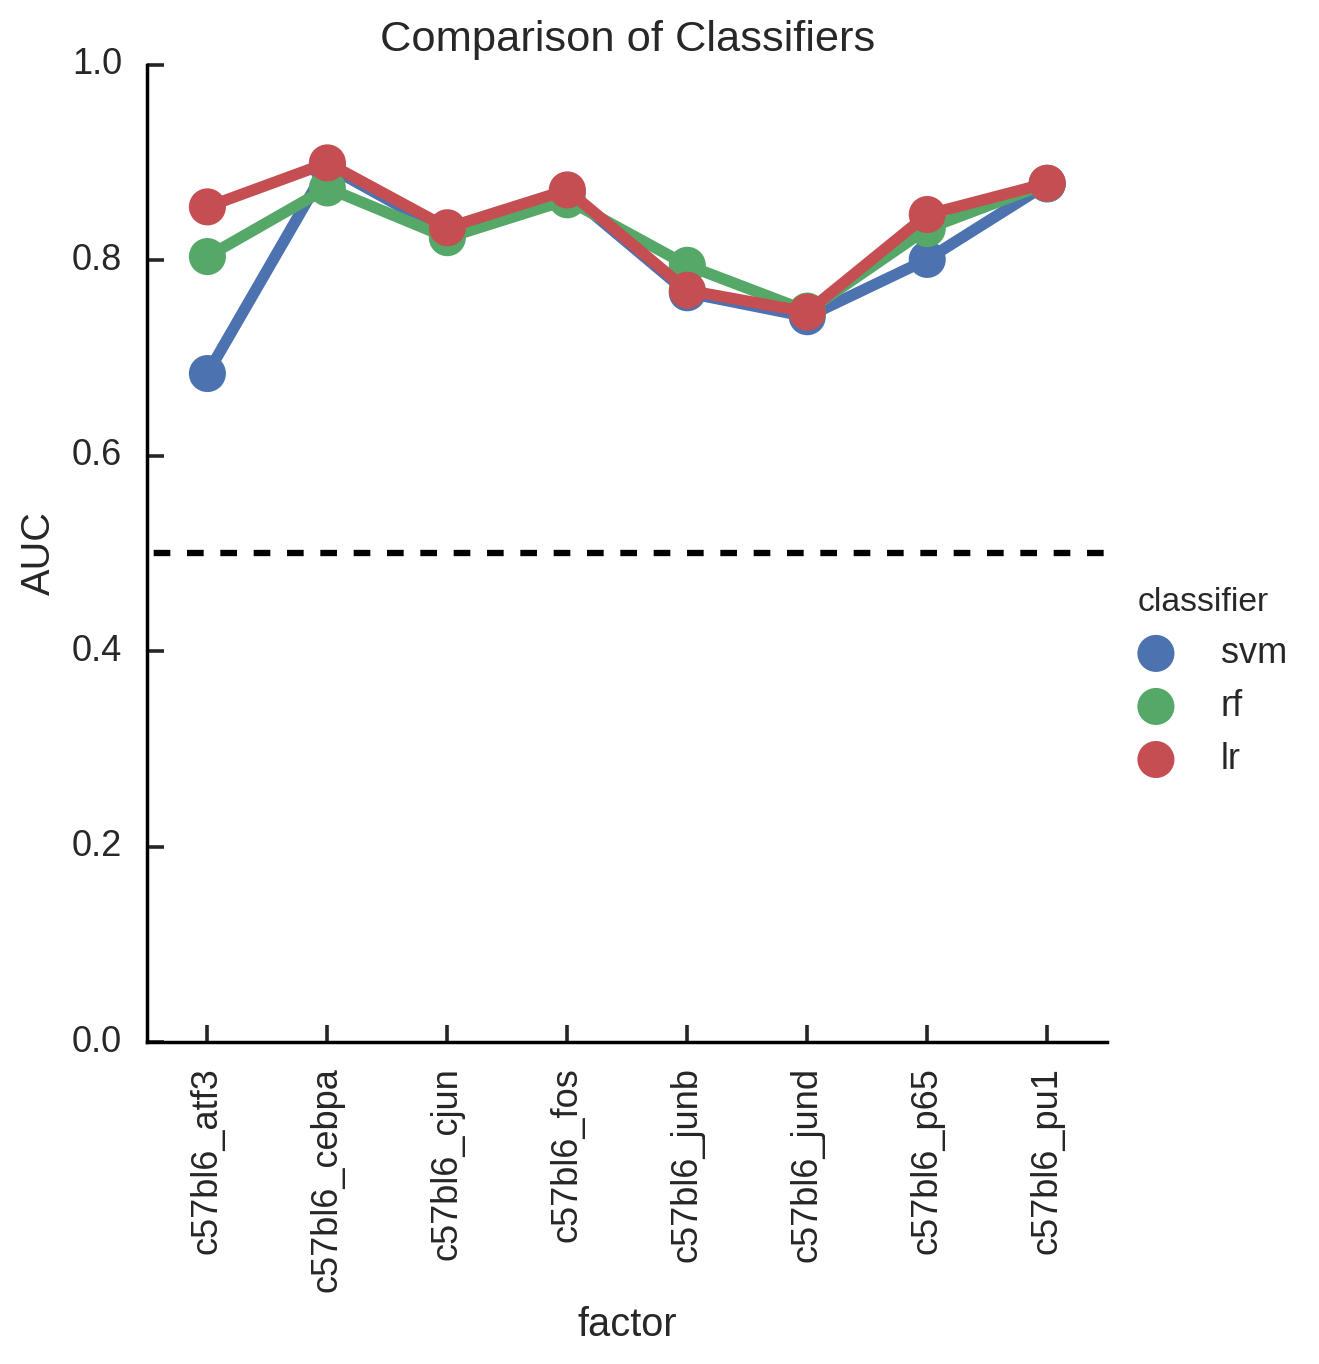

In [38]:
### compare different classifiers ###
aucs = []
classifiers = []
metrics = []
factors = []
c67bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values
for factor in sorted(set([x.replace('_veh','').replace('_kla','') for x in summary_frame.columns[5:] if 'c57' in x and not 'atac' in x])):
    print(factor)
    
    features = normed_motif_frame[normed_motif_frame.index.isin(c67bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c67bl6_indices)]['Factors'].str.contains(factor)
    
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
    

    # Run classifier
    svm_classifier = svm.SVC(kernel='linear', probability=True, cache_size = 5000)
    rf_classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1)
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    svm_classifier.fit(training_features, training_labels)
    rf_classifier.fit(training_features, training_labels)
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_svm = svm_classifier.predict_proba(test_features)
    probas_rf = rf_classifier.predict_proba(test_features)
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    predictions_svm = svm_classifier.predict(test_features)
    predictions_rf = rf_classifier.predict(test_features)
    predictions_lr = lr_classifier.predict(test_features)
    
    # roc curv for svm
    fpr_svm, tpr_svm, thresholds_roc_svm = sklearn.metrics.roc_curve(test_labels, probas_svm[:, 1])
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    aucs.append(roc_auc_svm)
    
    # roc curv for rf
    fpr_rf, tpr_rf, thresholds_roc_rf = sklearn.metrics.roc_curve(test_labels, probas_rf[:, 1])
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    aucs.append(roc_auc_rf)

    # roc curv for lr
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    aucs.append(roc_auc_lr)

    classifiers = classifiers + ['svm', 'rf', 'lr']
    factors = factors + [factor] * 3
    
    print('training set|', 'num samples:', len(training_labels), 'num True:', np.sum(training_labels))
    print('test set    |', 'num samples:', len(test_labels), 'num True:', np.sum(test_labels))
    print(roc_auc_svm, roc_auc_rf, roc_auc_lr)

classifier_frame = pd.DataFrame({'factor':factors, 
                                 'AUC':aucs,
                                'classifier':classifiers})
              
    
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                       'xtick.direction': 'in',
                       'ytick.direction': 'in', 
                         }):
    sns.factorplot(data = classifier_frame, 
                   x='factor', 
                   y='AUC', 
                   hue='classifier',
                  kind='point', 
                  size=6)
    plt.xticks(rotation=90);
    plt.title('Comparison of Classifiers')
    plt.ylim(0,1)
    plt.hlines(y=0.5, xmin=-1, xmax=8, color='black', linestyle='--')
    plt.show()

## Logistic Regression Binding Predictions

### Different Test Fraction Sizes

In [ ]:
### test predictive ability with different test fraction sizes
factor_auc_dict = {}
c67bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor in [x for x in _factors if not 'atac' in x]:
    factor_auc_dict[factor] = []
    print(factor)
    for test_size in np.arange(0.1,1.0,0.1):
        features = normed_motif_frame[normed_motif_frame.index.isin(c67bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c67bl6_indices)]['Factors'].str.contains(factor)


        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = test_size, tolerance = 0.01)
        print('test fraction:',test_size, 'num training features', len(training_features), 'num test features', len(test_features))


        #  Run classifier
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
      
        fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        roc_auc_lr = auc(fpr_lr, tpr_lr)
        factor_auc_dict[factor].append(roc_auc_lr)

auc_frame = pd.DataFrame(factor_auc_dict)
auc_frame.index = np.arange(0.1,1.0,0.1)



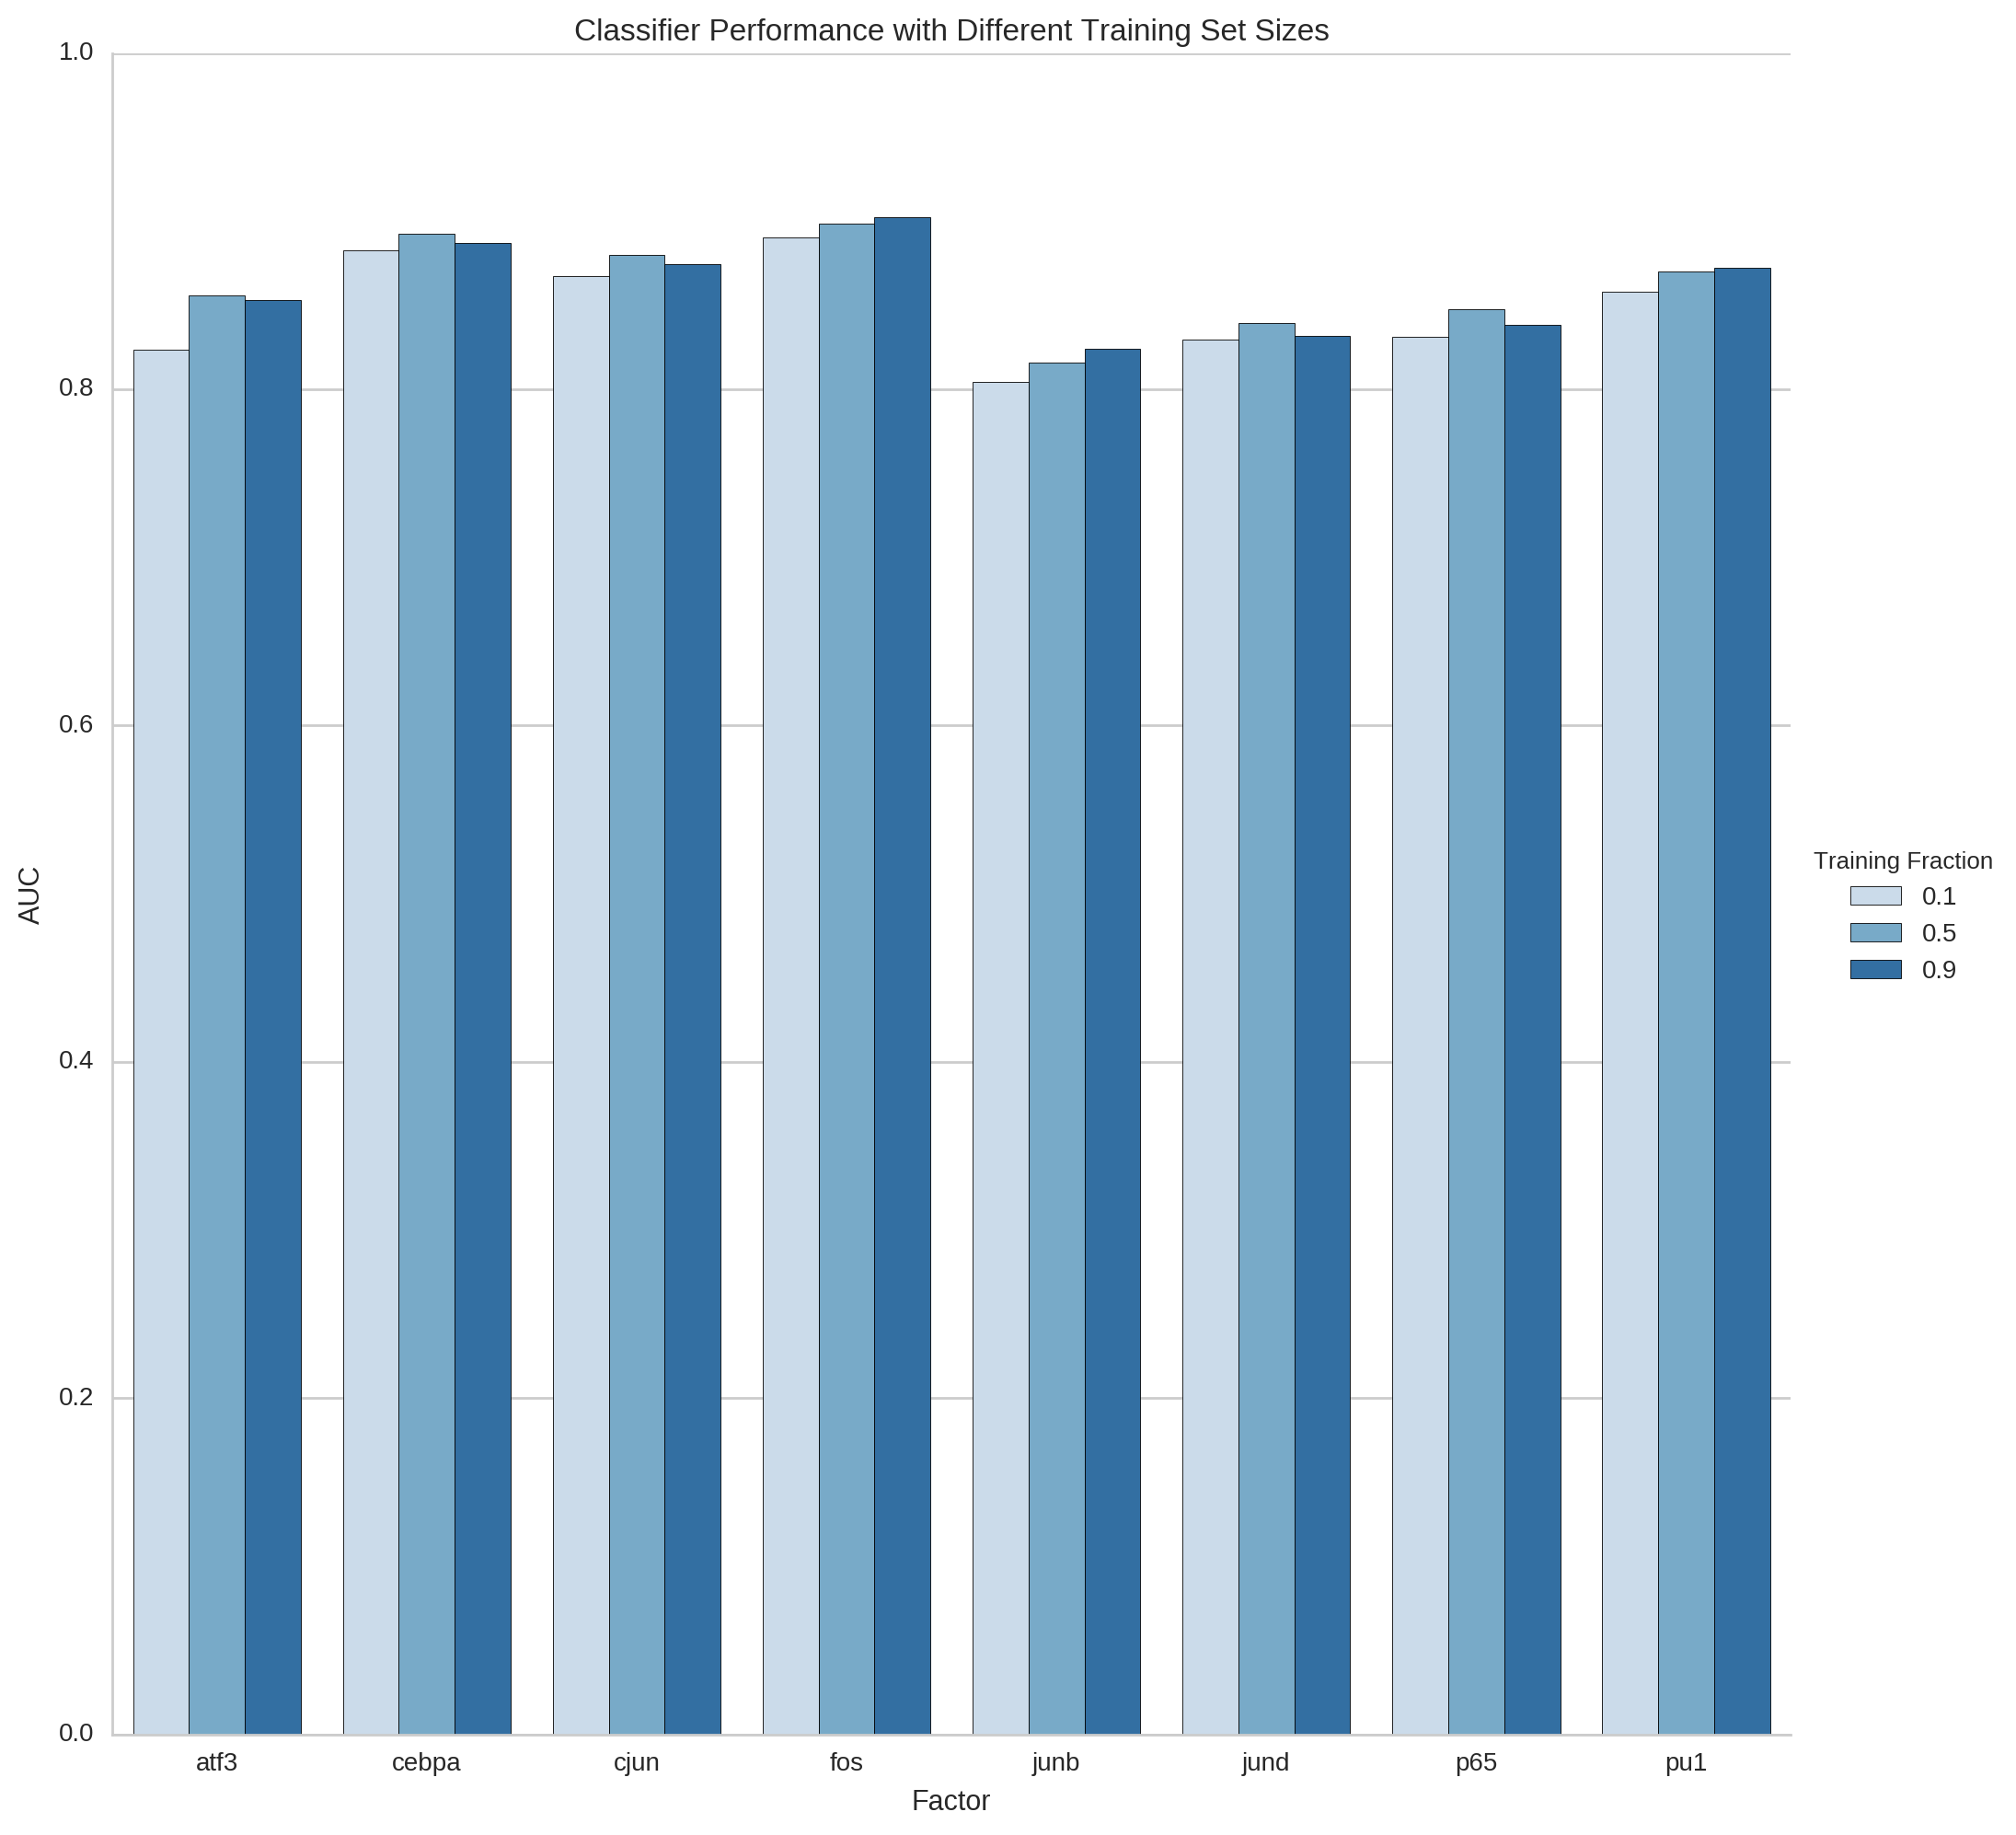

In [342]:
stacked_frame = pd.DataFrame(auc_frame.stack())
stacked_frame['Factor'] = [x[1] for x in stacked_frame.index.values]
stacked_frame['Training Fraction'] = [np.round(1- x[0],3) for x in stacked_frame.index.values]
stacked_frame.columns = ['AUC', 'Factor', 'Training Fraction']
stacked_frame.index = range(stacked_frame.shape[0])
with sns.axes_style('whitegrid'):
    sns.factorplot(data=stacked_frame[stacked_frame['Training Fraction'].isin([0.1,0.5, 0.9])], 
                   x='Factor', y='AUC', hue='Training Fraction', size=10, kind='bar', palette='Blues')
    plt.ylim(0,1)
    plt.title('Classifier Performance with Different Training Set Sizes')

### Regressing on Individual Motifs

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
### for all peaks in vehicle and KLA
factor_coeff_dict = {}
factor_auc_dict = {}
c67bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values
motifs = sorted(normed_motif_frame.columns.values)
for factor in _factors:
    print(factor)
    factor_coeff_dict[factor] = []
    factor_auc_dict[factor] = []
    current_coeffs = factor_coeff_dict[factor]
    current_aucs = factor_auc_dict[factor]
    for motif in motifs:
        # get features and labels
        features = normed_motif_frame[normed_motif_frame.index.isin(c67bl6_indices)][motif]
        labels = summary_frame[summary_frame.index.isin(c67bl6_indices)]['Factors'].str.contains(factor)
        # split test and training data
        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = 0.5, tolerance = 0.01)
        training_features = training_features.reshape(training_features.shape[0],1)
        test_features = test_features.reshape(test_features.shape[0],1)
        training_labels = training_labels.reshape(training_labels.shape[0],1)
        test_labels = test_labels.reshape(test_labels.shape[0],1)
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
        
        #  Run classifier        
        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
        # retrieve coefficient
        coefficient = lr_classifier.coef_[0][0]

        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        roc_auc = auc(fpr, tpr)

        current_coeffs.append(coefficient)
        current_aucs.append(roc_auc)
        print(motif,coefficient,roc_auc)

coefficients_frame_ind = pd.DataFrame(factor_coeff_dict)
coefficients_frame_ind = coefficients_frame_ind[sorted(_factors)]
coefficients_frame_ind.index = motifs

auc_frame_ind = pd.DataFrame(factor_auc_dict)
auc_frame_ind = auc_frame_ind[sorted(_factors)]
auc_frame_ind.index = motifs

atf3
total: 27753 filtered: 27511 true gc: 0.47298 false gc: 0.48298 difference: 0.01
alx1_alx4_arx 1.29942598256 0.581445941806
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27510 true gc: 0.47298 false gc: 0.48298 difference: 0.01
ap-1 2.09714307935 0.73950587572
total: 27753 filtered: 27488 true gc: 0.47298 false gc: 0.48298 difference: 0.01
ar_nr3c1_nr3c2 0.694959701906 0.525177540162
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27479 true gc: 0.47298 false gc: 0.48298 difference: 0.01
arid3a 0.552884587712 0.578448652539
total: 27753 filtered: 27533 true gc: 0.47298 false gc: 0.48298 difference: 0.01
arid3b 1.16499046306 0.573570449488
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27487 true gc: 0.47298 false gc: 0.48298 difference: 0.01
arid5a 1.43733825595 0.585768838232
total: 27753 filtered: 27492 true gc: 0.47298 false gc: 0.48298 difference: 0.01
arnt_mycn 0.639063991124 0.575654054615
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27486 true gc: 0.47298 false gc: 0.48298 difference: 0.01
arntl_mitf 1.55446661576 0.630010562134
total: 27753 filtered: 27486 true gc: 0.47298 false gc: 0.48298 difference: 0.01
ascl2_nhlh1 1.28447597369 0.56801248835
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27503 true gc: 0.47298 false gc: 0.48298 difference: 0.01
atf7_batf3_creb5 2.4277608554 0.668814384646
total: 27753 filtered: 27502 true gc: 0.47298 false gc: 0.48298 difference: 0.01
bcl6 1.62722600669 0.586695966153
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27500 true gc: 0.47298 false gc: 0.48298 difference: 0.01
bcl6b 0.226768358589 0.503307824762
total: 27753 filtered: 27501 true gc: 0.47298 false gc: 0.48298 difference: 0.01
bhlh 2.02925283071 0.602842936754
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27511 true gc: 0.47298 false gc: 0.48298 difference: 0.01
bhlha15 0.829304410899 0.606920841973
total: 27753 filtered: 27476 true gc: 0.47298 false gc: 0.48298 difference: 0.01
bhlhe23 1.45591124521 0.557874101353
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27504 true gc: 0.47298 false gc: 0.48298 difference: 0.01
cdx 0.997241271066 0.58812943449
total: 27753 filtered: 27493 true gc: 0.47298 false gc: 0.48298 difference: 0.01
cebp 2.3102148358 0.64978065156
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27488 true gc: 0.47298 false gc: 0.48298 difference: 0.01
cenpb 1.19154677318 0.554887264583
total: 27753 filtered: 27493 true gc: 0.47298 false gc: 0.48298 difference: 0.01
creb3-l1 1.80434418671 0.592397611392
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27487 true gc: 0.47298 false gc: 0.48298 difference: 0.01
crem 2.1118921333 0.660931201124
total: 27753 filtered: 27531 true gc: 0.47298 false gc: 0.48298 difference: 0.01
ctcf -1.01113557924 0.482208694216
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27512 true gc: 0.47298 false gc: 0.48298 difference: 0.01
cux 1.70696730452 0.621836015775
total: 27753 filtered: 27490 true gc: 0.47298 false gc: 0.48298 difference: 0.01
dbp_hlf_tef 2.04682548375 0.665491773328
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27533 true gc: 0.47298 false gc: 0.48298 difference: 0.01
dmbx1 1.61921747745 0.608377537665
total: 27753 filtered: 27508 true gc: 0.47298 false gc: 0.48298 difference: 0.01
dmrt3 1.2745536369 0.615501477346
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27513 true gc: 0.47298 false gc: 0.48298 difference: 0.01
dux 0.97727146014 0.595887671236
total: 27753 filtered: 27524 true gc: 0.47298 false gc: 0.48298 difference: 0.00999
dux4 1.88818607712 0.617311233951
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27503 true gc: 0.47298 false gc: 0.48298 difference: 0.01
duxa 2.37855295059 0.668430651459
total: 27753 filtered: 27476 true gc: 0.47298 false gc: 0.48298 difference: 0.01
e2f1 0.246568422111 0.519921218888
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27507 true gc: 0.47298 false gc: 0.48298 difference: 0.01
e2f2 0.0 0.5
total: 27753 filtered: 27491 true gc: 0.47298 false gc: 0.48298 difference: 0.01
e2f4_e2f6 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27495 true gc: 0.47298 false gc: 0.48298 difference: 0.01
e2f7 0.210225436942 0.504787868628
total: 27753 filtered: 27493 true gc: 0.47298 false gc: 0.48298 difference: 0.00999
e2f8 1.11002472189 0.510293920297
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27530 true gc: 0.47298 false gc: 0.48298 difference: 0.01
ebf1 1.07699740698 0.574969657152
total: 27753 filtered: 27565 true gc: 0.47298 false gc: 0.48298 difference: 0.01
ebox 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27492 true gc: 0.47298 false gc: 0.48298 difference: 0.01
egr 0.295849869603 0.553774878018
total: 27753 filtered: 27493 true gc: 0.47298 false gc: 0.48298 difference: 0.01
elf 0.302204932901 0.519088358951
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27527 true gc: 0.47298 false gc: 0.48298 difference: 0.01
elk_etv 0.160311628605 0.536074665012
total: 27753 filtered: 27508 true gc: 0.47298 false gc: 0.48298 difference: 0.01
esr1 1.82930605185 0.518209237344
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27484 true gc: 0.47298 false gc: 0.48298 difference: 0.01
esr2 2.09857815763 0.640537021703
total: 27753 filtered: 27546 true gc: 0.47298 false gc: 0.48298 difference: 0.01
esrr 1.12056427206 0.583703255571
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27480 true gc: 0.47298 false gc: 0.48298 difference: 0.01
ewsr1-fli1 -0.335364969865 0.504710710284
total: 27753 filtered: 27487 true gc: 0.47298 false gc: 0.48298 difference: 0.01
figla_id4_snai2_tcf3_tcf4 1.33990967033 0.553716656405
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27505 true gc: 0.47298 false gc: 0.48298 difference: 0.01
fox 1.24703302659 0.602783481796
total: 27753 filtered: 27509 true gc: 0.47298 false gc: 0.48298 difference: 0.01
gata 1.17837535338 0.586465683927
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27508 true gc: 0.47298 false gc: 0.48298 difference: 0.01
gcm 0.975942678525 0.568240291207
total: 27753 filtered: 27533 true gc: 0.47298 false gc: 0.48298 difference: 0.01
gfi1 1.49434467303 0.61646580626
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27494 true gc: 0.47298 false gc: 0.48298 difference: 0.01
gfi1b 1.30932342816 0.614725129443
total: 27753 filtered: 27478 true gc: 0.47298 false gc: 0.48298 difference: 0.01
gli2 1.3991299816 0.586037563243
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27485 true gc: 0.47298 false gc: 0.48298 difference: 0.01
glis 0.760489608624 0.547715653003
total: 27753 filtered: 27526 true gc: 0.47298 false gc: 0.48298 difference: 0.01
gmeb2 1.84640190826 0.604253858319
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27488 true gc: 0.47298 false gc: 0.48298 difference: 0.01
grhl1 1.24233992105 0.570270482442
total: 27753 filtered: 27506 true gc: 0.47298 false gc: 0.48298 difference: 0.01
gsc 1.63156127367 0.63131204125
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27526 true gc: 0.47298 false gc: 0.48298 difference: 0.01
hes 0.0 0.5
total: 27753 filtered: 27504 true gc: 0.47298 false gc: 0.48298 difference: 0.01
hic 1.33142281181 0.584805156683
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27522 true gc: 0.47298 false gc: 0.48297 difference: 0.00999
hinfp 0.288554065398 0.523038501453
total: 27753 filtered: 27518 true gc: 0.47298 false gc: 0.48298 difference: 0.01
hltf 2.25854781701 0.590512122083
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27519 true gc: 0.47298 false gc: 0.48298 difference: 0.01
hnf1 1.92387713105 0.615705570301
total: 27753 filtered: 27487 true gc: 0.47298 false gc: 0.48298 difference: 0.01
hnf4a 1.33007182763 0.519374037655
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27500 true gc: 0.47298 false gc: 0.48298 difference: 0.01
hnf4g 1.39855589934 0.575113246746
total: 27753 filtered: 27504 true gc: 0.47298 false gc: 0.48298 difference: 0.01
homeobox-1 1.30774879285 0.620623546626
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27482 true gc: 0.47298 false gc: 0.48298 difference: 0.01
homeobox-2 0.0 0.5
total: 27753 filtered: 27516 true gc: 0.47298 false gc: 0.48298 difference: 0.00999
homeobox-3 1.50815641626 0.593645537229
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27517 true gc: 0.47298 false gc: 0.48298 difference: 0.01
homeobox-4 1.29289164749 0.583964250729
total: 27753 filtered: 27509 true gc: 0.47298 false gc: 0.48298 difference: 0.01
homeobox-5 1.84520235032 0.599444577611
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27518 true gc: 0.47298 false gc: 0.48298 difference: 0.01
hoxa11 1.86589783835 0.597174927836
total: 27753 filtered: 27520 true gc: 0.47298 false gc: 0.48298 difference: 0.01
hoxa5 1.42120801252 0.611638441179
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27491 true gc: 0.47298 false gc: 0.48298 difference: 0.01
hoxa9 1.55320112517 0.642728958022
total: 27753 filtered: 27509 true gc: 0.47298 false gc: 0.48298 difference: 0.00999
hoxb5_hoxd3 2.04749691464 0.644195589371
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27494 true gc: 0.47298 false gc: 0.48298 difference: 0.01
hoxc13 1.27399747435 0.570265326844
total: 27753 filtered: 27513 true gc: 0.47298 false gc: 0.48298 difference: 0.01
hoxc9 1.91728492228 0.62796921078
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27512 true gc: 0.47298 false gc: 0.48297 difference: 0.00999
hoxd8 1.51794257448 0.614034123477
total: 27753 filtered: 27512 true gc: 0.47298 false gc: 0.48298 difference: 0.01
hsf 0.585475594812 0.538013223366
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27510 true gc: 0.47298 false gc: 0.48298 difference: 0.01
id2_mlxip 0.929956707597 0.549423003244
total: 27753 filtered: 27510 true gc: 0.47298 false gc: 0.48298 difference: 0.01
insm1 1.1999389091 0.581978054708
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27492 true gc: 0.47298 false gc: 0.48298 difference: 0.01
irf1 0.178368845258 0.525292142914
total: 27753 filtered: 27493 true gc: 0.47298 false gc: 0.48298 difference: 0.01
irf2 0.603524698041 0.517631979875
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27487 true gc: 0.47298 false gc: 0.48298 difference: 0.00999
irf7-8-9 0.663686886577 0.504488046958
total: 27753 filtered: 27506 true gc: 0.47298 false gc: 0.48298 difference: 0.01
isl2_nkx3-1_nkx3-2 1.42697911631 0.568470475334
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27495 true gc: 0.47298 false gc: 0.48298 difference: 0.01
klf 0.390216830684 0.569285478484
total: 27753 filtered: 27471 true gc: 0.47298 false gc: 0.48298 difference: 0.01
lef1 1.00604556393 0.577012785572
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27504 true gc: 0.47298 false gc: 0.48298 difference: 0.01
lhx3 1.18739438226 0.538117570875
total: 27753 filtered: 27508 true gc: 0.47298 false gc: 0.48298 difference: 0.01
lin54 0.645705194784 0.573659192988
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27487 true gc: 0.47298 false gc: 0.48298 difference: 0.01
maf_nrl 2.84446869627 0.666965840768
total: 27753 filtered: 27497 true gc: 0.47298 false gc: 0.48298 difference: 0.01
mafg 2.6836610272 0.645379177999
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27494 true gc: 0.47298 false gc: 0.48298 difference: 0.01
mecom 1.41482055165 0.551778725309
total: 27753 filtered: 27488 true gc: 0.47298 false gc: 0.48298 difference: 0.01
mef2a-b-d 0.792401528975 0.528362939401
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27514 true gc: 0.47298 false gc: 0.48298 difference: 0.00999
mef2c 1.20543611643 0.576043453503
total: 27753 filtered: 27486 true gc: 0.47298 false gc: 0.48298 difference: 0.01
meis 1.70727340867 0.628717960425
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27488 true gc: 0.47298 false gc: 0.48298 difference: 0.00999
mga_tbx 1.85644623755 0.641247863164
total: 27753 filtered: 27489 true gc: 0.47298 false gc: 0.48298 difference: 0.01
msc_myf6_tfap4 0.817942241159 0.569269574088
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27514 true gc: 0.47298 false gc: 0.48298 difference: 0.01
mtf1 1.14539364573 0.537832729425
total: 27753 filtered: 27489 true gc: 0.47298 false gc: 0.48297 difference: 0.00999
myb 1.11677871068 0.588229261355
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27488 true gc: 0.47298 false gc: 0.48298 difference: 0.01
mybl1 0.89759812616 0.544030346055
total: 27753 filtered: 27489 true gc: 0.47298 false gc: 0.48298 difference: 0.01
mybl2 0.171218757466 0.551918186297
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27498 true gc: 0.47298 false gc: 0.48298 difference: 0.01
myc 1.0556925524 0.556961073094
total: 27753 filtered: 27505 true gc: 0.47298 false gc: 0.48298 difference: 0.01
myog_tcf12 0.892009269324 0.581036898511
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27505 true gc: 0.47298 false gc: 0.48298 difference: 0.01
mzf1 1.04402725856 0.55355723137
total: 27753 filtered: 27544 true gc: 0.47298 false gc: 0.48298 difference: 0.01
mzf1var.2 1.02526027944 0.561163514193
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27513 true gc: 0.47298 false gc: 0.48298 difference: 0.01
nfat 1.22038072077 0.593760374284
total: 27753 filtered: 27519 true gc: 0.47298 false gc: 0.48298 difference: 0.01
nfi 1.5590534361 0.589168938166
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27496 true gc: 0.47298 false gc: 0.48298 difference: 0.01
nfil3 1.54326456798 0.633788220738
total: 27753 filtered: 27486 true gc: 0.47298 false gc: 0.48298 difference: 0.01
nfkb 0.763356473229 0.510759462663
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27489 true gc: 0.47298 false gc: 0.48298 difference: 0.01
nfya 1.53926357412 0.549054903977
total: 27753 filtered: 27497 true gc: 0.47298 false gc: 0.48298 difference: 0.01
nfyb 1.3892075259 0.580554211324
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27497 true gc: 0.47298 false gc: 0.48298 difference: 0.01
nkx2-3_nkx2-8 1.45664842024 0.559961315393
total: 27753 filtered: 27518 true gc: 0.47298 false gc: 0.48298 difference: 0.00999
nkx2-5 1.41134598253 0.591820524066
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27522 true gc: 0.47298 false gc: 0.48298 difference: 0.01
nkx2-5var.2 0.8708460659 0.580019808239
total: 27753 filtered: 27516 true gc: 0.47298 false gc: 0.48298 difference: 0.01
nr2_rxr 1.15217728596 0.566652753156
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27480 true gc: 0.47298 false gc: 0.48298 difference: 0.00999
nr2e1 2.12067705652 0.667912914062
total: 27753 filtered: 27479 true gc: 0.47298 false gc: 0.48298 difference: 0.01
nr2e3 0.662346349811 0.590121072409
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27501 true gc: 0.47298 false gc: 0.48298 difference: 0.01
nr2f1 1.55206316232 0.60876652567
total: 27753 filtered: 27483 true gc: 0.47298 false gc: 0.48298 difference: 0.01
nr4a2 1.79963075637 0.613751656744
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27484 true gc: 0.47298 false gc: 0.48298 difference: 0.01
nr5a2 1.72282135583 0.591966127043
total: 27753 filtered: 27506 true gc: 0.47298 false gc: 0.48298 difference: 0.01
nrf1 0.268645642626 0.531122535778
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27509 true gc: 0.47298 false gc: 0.48298 difference: 0.01
onecut 1.14439610923 0.54083390727
total: 27753 filtered: 27501 true gc: 0.47298 false gc: 0.48298 difference: 0.01
pax1_pax9 2.18007769971 0.534007777619
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27494 true gc: 0.47298 false gc: 0.48298 difference: 0.01
pax2 4.21792434414 0.678508137437
total: 27753 filtered: 27498 true gc: 0.47298 false gc: 0.48298 difference: 0.01
pax3_pax7 1.00302598169 0.538418598616
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27498 true gc: 0.47298 false gc: 0.48298 difference: 0.01
pax5 2.04005448403 0.59038956044
total: 27753 filtered: 27473 true gc: 0.47298 false gc: 0.48298 difference: 0.01
pax6 2.27675513308 0.622310580754
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27492 true gc: 0.47298 false gc: 0.48298 difference: 0.01
pbx1 1.51374192214 0.622026204738
total: 27753 filtered: 27510 true gc: 0.47298 false gc: 0.48298 difference: 0.01
phox2_prop 1.72316761212 0.62554795928
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27522 true gc: 0.47298 false gc: 0.48298 difference: 0.01
pknox_tgif 2.00431716094 0.589169810575
total: 27753 filtered: 27499 true gc: 0.47298 false gc: 0.48298 difference: 0.00999
plag1 0.477122371252 0.521415114793
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27510 true gc: 0.47298 false gc: 0.48298 difference: 0.00999
pou1f1 1.46448602084 0.604469641782
total: 27753 filtered: 27497 true gc: 0.47298 false gc: 0.48298 difference: 0.01
pou2-3-5 0.970519456276 0.598386468346
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27494 true gc: 0.47298 false gc: 0.48298 difference: 0.01
pou4 1.85366148753 0.61682586689
total: 27753 filtered: 27514 true gc: 0.47298 false gc: 0.48298 difference: 0.01
pou6f2 1.81973384596 0.638047091075
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27499 true gc: 0.47298 false gc: 0.48298 difference: 0.01
pparg 1.69541262417 0.567592772918
total: 27753 filtered: 27496 true gc: 0.47298 false gc: 0.48298 difference: 0.01
pparg_rxra 1.73435018168 0.5940754288
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27510 true gc: 0.47298 false gc: 0.48298 difference: 0.01
prdm1 0.884231168919 0.575425197697
total: 27753 filtered: 27469 true gc: 0.47298 false gc: 0.48298 difference: 0.01
prox1 1.6377001703 0.581434639605
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27534 true gc: 0.47298 false gc: 0.48298 difference: 0.01
rar 0.0 0.5
total: 27753 filtered: 27516 true gc: 0.47298 false gc: 0.48298 difference: 0.01
rar_rxr 2.08189441635 0.53316965087
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27509 true gc: 0.47298 false gc: 0.48298 difference: 0.01
rargvar.2 0.669122834035 0.506642979429
total: 27753 filtered: 27507 true gc: 0.47298 false gc: 0.48298 difference: 0.01
rel 0.709234582854 0.55806930717
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27500 true gc: 0.47298 false gc: 0.48298 difference: 0.00999
rest 1.77026751726 0.526242252974
total: 27753 filtered: 27488 true gc: 0.47298 false gc: 0.48298 difference: 0.01
rfx 1.71907726886 0.587643205319
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27498 true gc: 0.47298 false gc: 0.48298 difference: 0.01
rhox11 1.40772956583 0.604799758416
total: 27753 filtered: 27502 true gc: 0.47298 false gc: 0.48298 difference: 0.01
rora 1.39089014995 0.630619434262
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27464 true gc: 0.47298 false gc: 0.48298 difference: 0.01
roravar.2 1.8232781085 0.570285015994
total: 27753 filtered: 27516 true gc: 0.47298 false gc: 0.48298 difference: 0.00999
rreb1 0.602008804476 0.518421442435
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27469 true gc: 0.47298 false gc: 0.48298 difference: 0.01
runx 1.67629677754 0.580633276166
total: 27753 filtered: 27485 true gc: 0.47298 false gc: 0.48298 difference: 0.01
rxravdr 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27491 true gc: 0.47298 false gc: 0.48298 difference: 0.01
scrt 1.54261444201 0.562440751779
total: 27753 filtered: 27486 true gc: 0.47298 false gc: 0.48298 difference: 0.01
six3 2.37046391148 0.608894367015
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27495 true gc: 0.47298 false gc: 0.48298 difference: 0.01
smad3 1.37861755986 0.558243895859
total: 27753 filtered: 27491 true gc: 0.47298 false gc: 0.48298 difference: 0.01
sox1-l1-21-4 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27482 true gc: 0.47298 false gc: 0.48298 difference: 0.01
sox10 2.0249296765 0.601727050814
total: 27753 filtered: 27506 true gc: 0.47298 false gc: 0.48298 difference: 0.01
sox17 1.46841371404 0.635197019902
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27470 true gc: 0.47298 false gc: 0.48298 difference: 0.01
sox2 0.808677249258 0.569850845491
total: 27753 filtered: 27503 true gc: 0.47298 false gc: 0.48298 difference: 0.01
sox3_sox6 0.831049003839 0.576974207861
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27510 true gc: 0.47298 false gc: 0.48298 difference: 0.01
sox5_sox9_sry 1.5451651279 0.598714864936
total: 27753 filtered: 27530 true gc: 0.47298 false gc: 0.48298 difference: 0.01
sox8 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27513 true gc: 0.47298 false gc: 0.48298 difference: 0.01
sp1 0.389851966514 0.530536579036
total: 27753 filtered: 27513 true gc: 0.47298 false gc: 0.48298 difference: 0.01
sp4 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27508 true gc: 0.47298 false gc: 0.48298 difference: 0.01
spi1-c -0.053740566531 0.499127052705
total: 27753 filtered: 27519 true gc: 0.47298 false gc: 0.48298 difference: 0.01
spib 0.65574247841 0.545046292911
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27495 true gc: 0.47298 false gc: 0.48298 difference: 0.01
spz1 1.16627255177 0.569488846295
total: 27753 filtered: 27510 true gc: 0.47298 false gc: 0.48298 difference: 0.01
srebpf 1.57639579401 0.634567060676
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27514 true gc: 0.47298 false gc: 0.48298 difference: 0.01
srf 0.451003071123 0.516303509044
total: 27753 filtered: 27485 true gc: 0.47298 false gc: 0.48298 difference: 0.01
stat1-3 0.991857495975 0.565691830018
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27491 true gc: 0.47298 false gc: 0.48298 difference: 0.01
stat6 0.873145966971 0.587742412392
total: 27753 filtered: 27500 true gc: 0.47298 false gc: 0.48298 difference: 0.01
t 1.65057713362 0.561094275954
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27514 true gc: 0.47298 false gc: 0.48298 difference: 0.00999
tbp 0.906560603242 0.566368419957
total: 27753 filtered: 27475 true gc: 0.47298 false gc: 0.48298 difference: 0.01
tbx 2.24214031522 0.630097704568
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27507 true gc: 0.47298 false gc: 0.48298 difference: 0.01
tcf21 0.956558612705 0.526346952458
total: 27753 filtered: 27508 true gc: 0.47298 false gc: 0.48298 difference: 0.01
tcf7 1.46351193067 0.587945112621
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27502 true gc: 0.47298 false gc: 0.48298 difference: 0.01
tcfl5 1.06296208775 0.581978996076
total: 27753 filtered: 27478 true gc: 0.47298 false gc: 0.48298 difference: 0.01
tead 1.30187882264 0.587562161946
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27529 true gc: 0.47298 false gc: 0.48298 difference: 0.01
tfap1 0.982930628507 0.548426216365
total: 27753 filtered: 27498 true gc: 0.47298 false gc: 0.48298 difference: 0.01
tfap2-3 0.423446594071 0.542163558811
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27510 true gc: 0.47298 false gc: 0.48298 difference: 0.01
tfcp2 1.48891027839 0.572085743843
total: 27753 filtered: 27473 true gc: 0.47298 false gc: 0.48298 difference: 0.01
thap1 1.42422033432 0.5664764604
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27533 true gc: 0.47298 false gc: 0.48298 difference: 0.01
tp53 1.27782322775 0.537946066048
total: 27753 filtered: 27509 true gc: 0.47298 false gc: 0.48298 difference: 0.01
tp63 0.491628510894 0.525436319643
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27504 true gc: 0.47298 false gc: 0.48298 difference: 0.01
tp73 1.5317410834 0.564689670114
total: 27753 filtered: 27500 true gc: 0.47298 false gc: 0.48298 difference: 0.01
usf 1.14973682389 0.609043417294
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27479 true gc: 0.47298 false gc: 0.48298 difference: 0.01
ventx 1.09731915377 0.603211352721
total: 27753 filtered: 27489 true gc: 0.47298 false gc: 0.48298 difference: 0.01
xbp1 1.84486251134 0.616486449674
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27490 true gc: 0.47298 false gc: 0.48298 difference: 0.01
yy1 1.31873743762 0.58119258243
total: 27753 filtered: 27503 true gc: 0.47298 false gc: 0.48298 difference: 0.01
yy2 1.20737513213 0.575940661469
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27501 true gc: 0.47298 false gc: 0.48298 difference: 0.01
zbed1 0.745814797604 0.524553586996
total: 27753 filtered: 27506 true gc: 0.47298 false gc: 0.48298 difference: 0.01
zbtb18 1.65137194158 0.600456654818
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27537 true gc: 0.47298 false gc: 0.48298 difference: 0.00999
zbtb33 1.25055695802 0.557960073037
total: 27753 filtered: 27525 true gc: 0.47298 false gc: 0.48298 difference: 0.01
zbtb7 0.689461182804 0.539437357284
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27517 true gc: 0.47298 false gc: 0.48298 difference: 0.01
zeb1 1.17101085518 0.558229103274
total: 27753 filtered: 27492 true gc: 0.47298 false gc: 0.48298 difference: 0.01
zfx 0.963105407076 0.564099392613
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27520 true gc: 0.47298 false gc: 0.48298 difference: 0.01
zic 0.423397537092 0.525682067179
total: 27753 filtered: 27479 true gc: 0.47298 false gc: 0.48298 difference: 0.01
znf143 1.36430310721 0.528140271493
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27477 true gc: 0.47298 false gc: 0.48298 difference: 0.01
znf263 0.687892624527 0.53487238374
total: 27753 filtered: 27472 true gc: 0.47298 false gc: 0.48298 difference: 0.01
znf354c 1.14328783456 0.582408335937
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27491 true gc: 0.47298 false gc: 0.48298 difference: 0.01
znf410 0.0 0.5
total: 27753 filtered: 27519 true gc: 0.47298 false gc: 0.48298 difference: 0.01
znf423 0.238904888682 0.494601303704
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27504 true gc: 0.47298 false gc: 0.48298 difference: 0.01
znf740 0.693019350195 0.556273852767
cebpa
total: 27753 filtered: 22510 true gc: 0.46337 false gc: 0.47337 difference: 0.01
alx1_alx4_arx 1.05253182348 0.542169601596
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22441 true gc: 0.46337 false gc: 0.47337 difference: 0.01
ap-1 0.117690391532 0.522391499621
total: 27753 filtered: 22493 true gc: 0.46337 false gc: 0.47337 difference: 0.01
ar_nr3c1_nr3c2 0.734535038175 0.514983862709
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22461 true gc: 0.46337 false gc: 0.47336 difference: 0.01
arid3a 0.306264606047 0.548119081923
total: 27753 filtered: 22521 true gc: 0.46337 false gc: 0.47335 difference: 0.00998
arid3b 0.800873359561 0.540574461075
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22484 true gc: 0.46337 false gc: 0.47336 difference: 0.01
arid5a 1.78857228056 0.598260962159
total: 27753 filtered: 22389 true gc: 0.46337 false gc: 0.47337 difference: 0.01
arnt_mycn 0.694439506784 0.530750735991
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22468 true gc: 0.46337 false gc: 0.47337 difference: 0.01
arntl_mitf 0.763853592756 0.549179819563
total: 27753 filtered: 22411 true gc: 0.46337 false gc: 0.47337 difference: 0.01
ascl2_nhlh1 0.545314687652 0.545559167559
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22504 true gc: 0.46337 false gc: 0.47336 difference: 0.01
atf7_batf3_creb5 0.858773751162 0.559453057431
total: 27753 filtered: 22412 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
bcl6 0.690664029942 0.536277378547
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22503 true gc: 0.46337 false gc: 0.47337 difference: 0.01
bcl6b 0.0 0.5
total: 27753 filtered: 22480 true gc: 0.46337 false gc: 0.47336 difference: 0.01
bhlh 1.34215074731 0.570389252178
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22492 true gc: 0.46337 false gc: 0.47337 difference: 0.01
bhlha15 0.599060347164 0.54761752544
total: 27753 filtered: 22502 true gc: 0.46337 false gc: 0.47336 difference: 0.01
bhlhe23 0.972149444722 0.539124036325
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22512 true gc: 0.46337 false gc: 0.47337 difference: 0.01
cdx 0.804441052526 0.551394022234
total: 27753 filtered: 22577 true gc: 0.46337 false gc: 0.47337 difference: 0.01
cebp 8.05978485031 0.885080894664
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22444 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
cenpb 0.949964868647 0.544195950913
total: 27753 filtered: 22446 true gc: 0.46337 false gc: 0.47336 difference: 0.01
creb3-l1 0.924029900283 0.526334280747
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22506 true gc: 0.46337 false gc: 0.47337 difference: 0.01
crem 0.718030008031 0.550977303427
total: 27753 filtered: 22398 true gc: 0.46337 false gc: 0.47337 difference: 0.01
ctcf -1.31416081111 0.521551736604
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22490 true gc: 0.46337 false gc: 0.47336 difference: 0.01
cux 1.47327539145 0.588868750004
total: 27753 filtered: 22557 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
dbp_hlf_tef 3.39974172501 0.742289375766
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22516 true gc: 0.46337 false gc: 0.47337 difference: 0.01
dmbx1 1.12710898183 0.568069859956
total: 27753 filtered: 22524 true gc: 0.46337 false gc: 0.47337 difference: 0.01
dmrt3 0.995708209425 0.589445266076
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22491 true gc: 0.46337 false gc: 0.47336 difference: 0.01
dux 1.08249786604 0.612078294018
total: 27753 filtered: 22413 true gc: 0.46337 false gc: 0.47336 difference: 0.01
dux4 1.01759473976 0.560820539738
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22448 true gc: 0.46337 false gc: 0.47337 difference: 0.01
duxa 1.35165153825 0.569939559541
total: 27753 filtered: 22565 true gc: 0.46337 false gc: 0.47337 difference: 0.01
e2f1 -0.387035334685 0.499025719518
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22480 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
e2f2 0.0 0.5
total: 27753 filtered: 22535 true gc: 0.46337 false gc: 0.47337 difference: 0.01
e2f4_e2f6 -0.00582221657157 0.504253363099
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22496 true gc: 0.46337 false gc: 0.47336 difference: 0.01
e2f7 -0.197569486077 0.495587893794
total: 27753 filtered: 22465 true gc: 0.46337 false gc: 0.47336 difference: 0.01
e2f8 0.185303029627 0.508068025439
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22520 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
ebf1 0.554116648349 0.53127198238
total: 27753 filtered: 22427 true gc: 0.46337 false gc: 0.47336 difference: 0.01
ebox 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22581 true gc: 0.46337 false gc: 0.47337 difference: 0.01
egr 0.121138356535 0.513054342665
total: 27753 filtered: 22540 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
elf -0.145382876439 0.503057844361
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22558 true gc: 0.46337 false gc: 0.47336 difference: 0.01
elk_etv -0.072445416666 0.49998368985
total: 27753 filtered: 22563 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
esr1 0.469947763672 0.505427184738
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22450 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
esr2 0.602775775422 0.539795391114
total: 27753 filtered: 22568 true gc: 0.46337 false gc: 0.47337 difference: 0.01
esrr 0.838422871821 0.532028466502
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22462 true gc: 0.46337 false gc: 0.47336 difference: 0.01
ewsr1-fli1 -0.373061296381 0.505553027458
total: 27753 filtered: 22469 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
figla_id4_snai2_tcf3_tcf4 0.588777689936 0.524059996311
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22428 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
fox 0.934546368119 0.564866282045
total: 27753 filtered: 22476 true gc: 0.46337 false gc: 0.47337 difference: 0.01
gata 0.334604930024 0.533903156127
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22488 true gc: 0.46337 false gc: 0.47336 difference: 0.01
gcm 0.268278799554 0.528634611217
total: 27753 filtered: 22528 true gc: 0.46337 false gc: 0.47337 difference: 0.01
gfi1 1.20485651318 0.592719241383
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22465 true gc: 0.46337 false gc: 0.47336 difference: 0.01
gfi1b 0.958807174796 0.569964235061
total: 27753 filtered: 22526 true gc: 0.46337 false gc: 0.47337 difference: 0.01
gli2 0.429511649229 0.531045798045
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22552 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
glis 0.274034292705 0.510151425414
total: 27753 filtered: 22468 true gc: 0.46337 false gc: 0.47336 difference: 0.01
gmeb2 1.19110780226 0.568630010083
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22569 true gc: 0.46337 false gc: 0.47336 difference: 0.01
grhl1 0.847839145378 0.553754658888
total: 27753 filtered: 22582 true gc: 0.46337 false gc: 0.47336 difference: 0.01
gsc 1.17759440702 0.575428267273
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22508 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
hes 0.0 0.5
total: 27753 filtered: 22549 true gc: 0.46337 false gc: 0.47337 difference: 0.01
hic 0.776745125996 0.548970401634
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22484 true gc: 0.46337 false gc: 0.47336 difference: 0.01
hinfp -0.140747073958 0.503989199271
total: 27753 filtered: 22525 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
hltf 1.24899663703 0.538707063077
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22566 true gc: 0.46337 false gc: 0.47337 difference: 0.01
hnf1 1.24666036235 0.562725686389
total: 27753 filtered: 22572 true gc: 0.46337 false gc: 0.47337 difference: 0.01
hnf4a 0.528741174036 0.513940038171
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22471 true gc: 0.46337 false gc: 0.47336 difference: 0.01
hnf4g 0.674918216727 0.53132845754
total: 27753 filtered: 22475 true gc: 0.46337 false gc: 0.47337 difference: 0.01
homeobox-1 1.42952633365 0.600072359079
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22534 true gc: 0.46337 false gc: 0.47337 difference: 0.01
homeobox-2 0.0 0.5
total: 27753 filtered: 22465 true gc: 0.46337 false gc: 0.47337 difference: 0.01
homeobox-3 0.940104147474 0.570264928842
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22590 true gc: 0.46337 false gc: 0.47336 difference: 0.01
homeobox-4 0.933559203736 0.549159244973
total: 27753 filtered: 22439 true gc: 0.46337 false gc: 0.47337 difference: 0.01
homeobox-5 1.08703122314 0.560284380697
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22501 true gc: 0.46337 false gc: 0.47337 difference: 0.01
hoxa11 1.29801352902 0.558874998224
total: 27753 filtered: 22606 true gc: 0.46337 false gc: 0.47337 difference: 0.01
hoxa5 0.995131553634 0.566844632452
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22521 true gc: 0.46337 false gc: 0.47337 difference: 0.01
hoxa9 0.771443759522 0.549917995463
total: 27753 filtered: 22549 true gc: 0.46337 false gc: 0.47336 difference: 0.01
hoxb5_hoxd3 1.85273540896 0.585481241186
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22565 true gc: 0.46337 false gc: 0.47336 difference: 0.01
hoxc13 0.910950553392 0.545706862068
total: 27753 filtered: 22496 true gc: 0.46337 false gc: 0.47336 difference: 0.01
hoxc9 0.67262896345 0.554563378393
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22435 true gc: 0.46337 false gc: 0.47337 difference: 0.01
hoxd8 1.29224874432 0.565007123273
total: 27753 filtered: 22447 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
hsf 0.459689573162 0.530354308132
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22489 true gc: 0.46337 false gc: 0.47336 difference: 0.01
id2_mlxip 0.495244312569 0.537918455834
total: 27753 filtered: 22401 true gc: 0.46337 false gc: 0.47336 difference: 0.01
insm1 0.250390561165 0.527686955943
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22516 true gc: 0.46337 false gc: 0.47336 difference: 0.01
irf1 -0.469461009105 0.501520969249
total: 27753 filtered: 22535 true gc: 0.46337 false gc: 0.47336 difference: 0.01
irf2 -0.415820759851 0.502806202692
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22569 true gc: 0.46337 false gc: 0.47336 difference: 0.01
irf7-8-9 -0.492877065394 0.50410463392
total: 27753 filtered: 22577 true gc: 0.46337 false gc: 0.47336 difference: 0.01
isl2_nkx3-1_nkx3-2 0.72864771343 0.54534321511
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22499 true gc: 0.46337 false gc: 0.47337 difference: 0.01
klf 0.254679171259 0.50892026891
total: 27753 filtered: 22508 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
lef1 0.688485402282 0.51605855102
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22551 true gc: 0.46337 false gc: 0.47336 difference: 0.01
lhx3 0.342623873756 0.5279044097
total: 27753 filtered: 22603 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
lin54 0.447873075928 0.550131821636
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22452 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
maf_nrl 0.933304734757 0.554462822255
total: 27753 filtered: 22509 true gc: 0.46337 false gc: 0.47337 difference: 0.01
mafg 0.793773155211 0.559581869936
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22478 true gc: 0.46337 false gc: 0.47336 difference: 0.01
mecom 0.411995329562 0.530307575311
total: 27753 filtered: 22478 true gc: 0.46337 false gc: 0.47337 difference: 0.01
mef2a-b-d 0.385265598239 0.516134697832
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22446 true gc: 0.46337 false gc: 0.47336 difference: 0.01
mef2c 0.596515164483 0.534730798784
total: 27753 filtered: 22535 true gc: 0.46337 false gc: 0.47337 difference: 0.01
meis 0.671044932714 0.545847479027
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22466 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
mga_tbx 0.465890688596 0.546110907578
total: 27753 filtered: 22565 true gc: 0.46337 false gc: 0.47337 difference: 0.01
msc_myf6_tfap4 0.549936016203 0.541731511011
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22439 true gc: 0.46337 false gc: 0.47337 difference: 0.01
mtf1 1.03042589207 0.53671592682
total: 27753 filtered: 22507 true gc: 0.46337 false gc: 0.47336 difference: 0.01
myb 0.796087967594 0.558548578976
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22450 true gc: 0.46337 false gc: 0.47336 difference: 0.01
mybl1 0.764793939915 0.532698382819
total: 27753 filtered: 22527 true gc: 0.46337 false gc: 0.47336 difference: 0.01
mybl2 1.12622445852 0.527420802875
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22440 true gc: 0.46337 false gc: 0.47336 difference: 0.01
myc 0.569187340056 0.546016096143
total: 27753 filtered: 22534 true gc: 0.46337 false gc: 0.47336 difference: 0.01
myog_tcf12 0.386360451855 0.527190025966
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22459 true gc: 0.46337 false gc: 0.47337 difference: 0.01
mzf1 0.15984156866 0.507148150955
total: 27753 filtered: 22497 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
mzf1var.2 0.224239272633 0.5242869921
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22441 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
nfat 0.66662104893 0.540297622286
total: 27753 filtered: 22568 true gc: 0.46337 false gc: 0.47336 difference: 0.01
nfi 0.984458982491 0.562111546122
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22524 true gc: 0.46337 false gc: 0.47337 difference: 0.01
nfil3 1.84248818821 0.616158688572
total: 27753 filtered: 22558 true gc: 0.46337 false gc: 0.47336 difference: 0.01
nfkb 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22463 true gc: 0.46337 false gc: 0.47334 difference: 0.00997
nfya 0.890218579523 0.545343411479
total: 27753 filtered: 22546 true gc: 0.46337 false gc: 0.47336 difference: 0.01
nfyb 0.622799197389 0.568128208452
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22574 true gc: 0.46337 false gc: 0.47337 difference: 0.01
nkx2-3_nkx2-8 0.578584491893 0.543564346549
total: 27753 filtered: 22450 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
nkx2-5 1.1854681625 0.593238237956
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22536 true gc: 0.46337 false gc: 0.47337 difference: 0.01
nkx2-5var.2 0.532050700846 0.540095395958
total: 27753 filtered: 22479 true gc: 0.46337 false gc: 0.47336 difference: 0.01
nr2_rxr 0.416017762094 0.51340471237
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22500 true gc: 0.46337 false gc: 0.47337 difference: 0.01
nr2e1 0.711077143957 0.530733748312
total: 27753 filtered: 22467 true gc: 0.46337 false gc: 0.47336 difference: 0.01
nr2e3 0.774901579203 0.574057406421
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22485 true gc: 0.46337 false gc: 0.47337 difference: 0.01
nr2f1 0.590174226472 0.530383691172
total: 27753 filtered: 22521 true gc: 0.46337 false gc: 0.47336 difference: 0.01
nr4a2 0.617502306184 0.545741083843
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22530 true gc: 0.46337 false gc: 0.47336 difference: 0.01
nr5a2 0.945563764954 0.549312924364
total: 27753 filtered: 22598 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
nrf1 0.284439605715 0.52805021802
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22519 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
onecut 0.871727473402 0.544415211459
total: 27753 filtered: 22460 true gc: 0.46337 false gc: 0.47337 difference: 0.01
pax1_pax9 0.546803782099 0.508707268645
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22556 true gc: 0.46337 false gc: 0.47336 difference: 0.01
pax2 0.99091726059 0.545240312048
total: 27753 filtered: 22578 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
pax3_pax7 1.01510254557 0.527783788641
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22539 true gc: 0.46337 false gc: 0.47337 difference: 0.01
pax5 0.639947117735 0.534567336322
total: 27753 filtered: 22422 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
pax6 1.3146074802 0.561689731512
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22590 true gc: 0.46337 false gc: 0.47336 difference: 0.01
pbx1 1.01283438964 0.573745963079
total: 27753 filtered: 22583 true gc: 0.46337 false gc: 0.47336 difference: 0.01
phox2_prop 1.6170464587 0.588155727982
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22577 true gc: 0.46337 false gc: 0.47337 difference: 0.01
pknox_tgif 1.09539381458 0.530437711806
total: 27753 filtered: 22486 true gc: 0.46337 false gc: 0.47337 difference: 0.01
plag1 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22517 true gc: 0.46337 false gc: 0.47336 difference: 0.01
pou1f1 1.03692722941 0.566637537614
total: 27753 filtered: 22452 true gc: 0.46337 false gc: 0.47337 difference: 0.01
pou2-3-5 0.927208080844 0.582914120508
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22508 true gc: 0.46337 false gc: 0.47337 difference: 0.01
pou4 1.21459398598 0.57394038936
total: 27753 filtered: 22489 true gc: 0.46337 false gc: 0.47336 difference: 0.01
pou6f2 0.922173179056 0.56486808248
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22567 true gc: 0.46337 false gc: 0.47337 difference: 0.01
pparg 0.484026419914 0.519146360418
total: 27753 filtered: 22520 true gc: 0.46337 false gc: 0.47337 difference: 0.01
pparg_rxra 0.760482245628 0.527381088434
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22532 true gc: 0.46337 false gc: 0.47336 difference: 0.01
prdm1 0.136201596667 0.505190890058
total: 27753 filtered: 22558 true gc: 0.46337 false gc: 0.47335 difference: 0.00998
prox1 1.01537051491 0.522938208031
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22466 true gc: 0.46337 false gc: 0.47336 difference: 0.01
rar 0.0 0.5
total: 27753 filtered: 22577 true gc: 0.46337 false gc: 0.47336 difference: 0.01
rar_rxr 0.128061499608 0.513715954326
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22572 true gc: 0.46337 false gc: 0.47337 difference: 0.01
rargvar.2 -0.227477940609 0.498293565915
total: 27753 filtered: 22518 true gc: 0.46337 false gc: 0.47337 difference: 0.01
rel 0.258489393587 0.520058947964
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22495 true gc: 0.46337 false gc: 0.47337 difference: 0.01
rest 0.651327407311 0.513225416771
total: 27753 filtered: 22511 true gc: 0.46337 false gc: 0.47336 difference: 0.01
rfx 1.03309398591 0.538499295565
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22487 true gc: 0.46337 false gc: 0.47336 difference: 0.01
rhox11 1.29827851791 0.575977076495
total: 27753 filtered: 22499 true gc: 0.46337 false gc: 0.47337 difference: 0.01
rora 0.588586077046 0.546581221896
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22500 true gc: 0.46337 false gc: 0.47336 difference: 0.01
roravar.2 1.00299122367 0.524616047889
total: 27753 filtered: 22479 true gc: 0.46337 false gc: 0.47336 difference: 0.01
rreb1 0.235113930897 0.508077733328
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22504 true gc: 0.46337 false gc: 0.47337 difference: 0.01
runx 1.02120933087 0.556253251688
total: 27753 filtered: 22428 true gc: 0.46337 false gc: 0.47336 difference: 0.01
rxravdr 0.12903877528 0.508176564019
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22517 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
scrt 2.09031072159 0.549935527269
total: 27753 filtered: 22445 true gc: 0.46337 false gc: 0.47337 difference: 0.01
six3 1.12398437711 0.554523018009
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22520 true gc: 0.46337 false gc: 0.47337 difference: 0.01
smad3 0.604975670457 0.516477682584
total: 27753 filtered: 22448 true gc: 0.46337 false gc: 0.47336 difference: 0.01
sox1-l1-21-4 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22466 true gc: 0.46337 false gc: 0.47336 difference: 0.01
sox10 1.58633354778 0.573939945481
total: 27753 filtered: 22555 true gc: 0.46337 false gc: 0.47336 difference: 0.01
sox17 1.39252978207 0.610390990199
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22409 true gc: 0.46337 false gc: 0.47335 difference: 0.00999
sox2 0.730367469298 0.556632309009
total: 27753 filtered: 22562 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
sox3_sox6 0.346803670276 0.537902193557
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22570 true gc: 0.46337 false gc: 0.47337 difference: 0.01
sox5_sox9_sry 1.79320200783 0.590758204294
total: 27753 filtered: 22471 true gc: 0.46337 false gc: 0.47336 difference: 0.01
sox8 0.287085389225 0.503305117479
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22571 true gc: 0.46337 false gc: 0.47336 difference: 0.01
sp1 -0.10951214144 0.49548124384
total: 27753 filtered: 22521 true gc: 0.46337 false gc: 0.47336 difference: 0.01
sp4 -0.19893104419 0.493148610595
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22490 true gc: 0.46337 false gc: 0.47337 difference: 0.01
spi1-c -0.644565161085 0.518546855907
total: 27753 filtered: 22549 true gc: 0.46337 false gc: 0.47336 difference: 0.01
spib 0.160451178693 0.502698062716
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22624 true gc: 0.46337 false gc: 0.47337 difference: 0.01
spz1 0.820063775662 0.550037477913
total: 27753 filtered: 22500 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
srebpf 0.57850378163 0.545450324593
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22549 true gc: 0.46337 false gc: 0.47337 difference: 0.01
srf 0.334071836671 0.505745668456
total: 27753 filtered: 22500 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
stat1-3 0.529711212202 0.539023550128
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22430 true gc: 0.46337 false gc: 0.47337 difference: 0.01
stat6 0.546206041709 0.547975790023
total: 27753 filtered: 22483 true gc: 0.46337 false gc: 0.47337 difference: 0.01
t 1.10699622605 0.534202347618
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22371 true gc: 0.46337 false gc: 0.47336 difference: 0.01
tbp 0.724921734756 0.533414161166
total: 27753 filtered: 22430 true gc: 0.46337 false gc: 0.47336 difference: 0.01
tbx 1.17525632667 0.549017702052
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22522 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
tcf21 0.970040685486 0.522880698307
total: 27753 filtered: 22563 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
tcf7 0.562974060644 0.537215947249
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22444 true gc: 0.46337 false gc: 0.47336 difference: 0.01
tcfl5 0.43932630534 0.532050944698
total: 27753 filtered: 22491 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
tead 0.600762999674 0.556076490919
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22573 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
tfap1 0.364275784394 0.518012440953
total: 27753 filtered: 22564 true gc: 0.46337 false gc: 0.47336 difference: 0.01
tfap2-3 0.141364487154 0.508887879358
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22415 true gc: 0.46337 false gc: 0.47336 difference: 0.01
tfcp2 1.09578495888 0.560814790214
total: 27753 filtered: 22512 true gc: 0.46337 false gc: 0.47337 difference: 0.01
thap1 0.539716943476 0.522678209359
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22601 true gc: 0.46337 false gc: 0.47336 difference: 0.01
tp53 1.43392520083 0.522944028206
total: 27753 filtered: 22463 true gc: 0.46337 false gc: 0.47336 difference: 0.01
tp63 2.76073819569 0.508247644021
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22469 true gc: 0.46337 false gc: 0.47336 difference: 0.01
tp73 1.09718444184 0.532052632165
total: 27753 filtered: 22401 true gc: 0.46337 false gc: 0.47337 difference: 0.01
usf 0.574173289725 0.545812839529
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22474 true gc: 0.46337 false gc: 0.47337 difference: 0.01
ventx 1.0152258735 0.566532280125
total: 27753 filtered: 22486 true gc: 0.46337 false gc: 0.47336 difference: 0.01
xbp1 0.720944392077 0.534824785461
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22495 true gc: 0.46337 false gc: 0.47335 difference: 0.00998
yy1 0.666876885862 0.548731482571
total: 27753 filtered: 22488 true gc: 0.46337 false gc: 0.47336 difference: 0.01
yy2 0.543225441807 0.541833226731
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22553 true gc: 0.46337 false gc: 0.47336 difference: 0.01
zbed1 2.2327147564 0.522159622827
total: 27753 filtered: 22489 true gc: 0.46337 false gc: 0.47335 difference: 0.00998
zbtb18 1.17650983376 0.564906715782
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22501 true gc: 0.46337 false gc: 0.47336 difference: 0.01
zbtb33 0.306363050903 0.516748176765
total: 27753 filtered: 22504 true gc: 0.46337 false gc: 0.47336 difference: 0.01
zbtb7 0.294433405937 0.533959304966
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22425 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
zeb1 0.384936606026 0.52300912265
total: 27753 filtered: 22537 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
zfx 0.284335713799 0.518875525202
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22608 true gc: 0.46337 false gc: 0.47335 difference: 0.00999
zic -0.159238983945 0.488520941841
total: 27753 filtered: 22531 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
znf143 0.706329276094 0.518724145667
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22443 true gc: 0.46337 false gc: 0.47336 difference: 0.00999
znf263 -0.256247007127 0.491822113577
total: 27753 filtered: 22490 true gc: 0.46337 false gc: 0.47337 difference: 0.01
znf354c 0.355917191928 0.535807333432
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22541 true gc: 0.46337 false gc: 0.47336 difference: 0.01
znf410 0.0 0.5
total: 27753 filtered: 22498 true gc: 0.46337 false gc: 0.47337 difference: 0.01
znf423 0.0125166899065 0.503353707181
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 22587 true gc: 0.46337 false gc: 0.47336 difference: 0.01
znf740 -0.054795066903 0.482710914233
cjun
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
alx1_alx4_arx 1.67025564709 0.585232440029
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
ap-1 2.39424258467 0.719415258006
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
ar_nr3c1_nr3c2 1.45317713919 0.522199312908
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
arid3a 0.71268081343 0.593962538004
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
arid3b 1.42147264744 0.595945120541
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
arid5a 1.74167539646 0.599105247645
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
arnt_mycn 1.20534540726 0.586084613131
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
arntl_mitf 2.25852446571 0.62887598857
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
ascl2_nhlh1 1.15681304504 0.581872963823
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
atf7_batf3_creb5 3.39472726886 0.611975392459
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
bcl6 1.88143536123 0.595074483446
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
bcl6b 0.9906781626 0.500422039439
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
bhlh 2.133202787 0.604357988007
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
bhlha15 0.968391089607 0.595635440419
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
bhlhe23 1.26490454779 0.554512863477
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
cdx 1.4719119642 0.578940934438
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
cebp 1.85736793357 0.633370857341
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
cenpb 1.69790289912 0.580659742898
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
creb3-l1 2.43924269913 0.592940098631
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
crem 2.96750403589 0.644699986438
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
ctcf -1.33225064716 0.506925710132
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
cux 2.04870301971 0.608018438122
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
dbp_hlf_tef 2.00834706881 0.613758209276
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
dmbx1 2.03824019186 0.601968943392
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
dmrt3 1.44515068436 0.609443309949
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
dux 0.951182306462 0.601794973774
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
dux4 2.12918616317 0.601627306535
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
duxa 2.73613430082 0.63662895134
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
e2f1 -0.0213698778172 0.478672349525
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
e2f2 0.118740898773 0.501445654622
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
e2f4_e2f6 0.937054466068 0.554949015109
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
e2f7 1.24964496376 0.505715369506
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
e2f8 1.73073397418 0.524816911928
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
ebf1 1.79331235211 0.574687175695
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
ebox 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
egr 1.74245806955 0.595270253824
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
elf 0.582773872161 0.546976830215
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
elk_etv 0.722977438658 0.555312290343
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
esr1 2.08850724495 0.518110042568
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
esr2 2.89914429068 0.62738276905
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
esrr 1.7497864994 0.570596984646
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
ewsr1-fli1 0.136488924741 0.502849884134
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
figla_id4_snai2_tcf3_tcf4 1.01049715203 0.578438700326
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
fox 1.61930603017 0.626811626766
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
gata 1.22008529136 0.596980301715
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
gcm 1.9544603717 0.597192894994
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
gfi1 1.98814327337 0.607877045999
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
gfi1b 1.54100846638 0.604417047061
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
gli2 1.82221293407 0.587284524371
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
glis 1.49639380216 0.56580701451
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
gmeb2 2.12171764912 0.607844576759
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
grhl1 1.65942839495 0.56544345686
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
gsc 2.08836558598 0.617023277364
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
hes 1.52686732698 0.517695171178
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
hic 1.47254019148 0.581407101725
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
hinfp 0.765345091778 0.54643546239
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
hltf 1.70757944619 0.599261404454
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
hnf1 2.72379512355 0.598399387137
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
hnf4a 1.64819181285 0.521596694401
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
hnf4g 1.72024606641 0.590486137968
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
homeobox-1 1.44111860152 0.616514607538
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
homeobox-2 0.0 0.5
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
homeobox-3 1.64583680587 0.607707265601
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
homeobox-4 1.8450839482 0.585106331632
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
homeobox-5 1.88746495509 0.615765667167
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
hoxa11 2.16167829453 0.621941963953
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
hoxa5 1.60334679985 0.609567531865
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
hoxa9 2.23763206132 0.627896108877
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
hoxb5_hoxd3 2.38665626489 0.641423169085
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
hoxc13 1.75692131762 0.584242768306
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
hoxc9 2.41043485709 0.62768626245
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
hoxd8 2.45467166844 0.610103623979
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
hsf 1.60730190599 0.53800939999
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
id2_mlxip 1.33652250381 0.583347022592
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
insm1 1.59158334515 0.584600752908
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
irf1 0.745781486397 0.564406809239
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
irf2 0.87880610594 0.516679043945
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
irf7-8-9 1.07948721012 0.513435412801
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
isl2_nkx3-1_nkx3-2 1.68110697417 0.593042420085
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
klf 1.24121721639 0.593328719454
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
lef1 1.56993958427 0.582121523071
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
lhx3 1.71527495707 0.54796532769
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
lin54 0.885478923175 0.588947351802
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
maf_nrl 2.82877173954 0.661429402554
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
mafg 2.89688979063 0.639824388057
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
mecom 1.77342243869 0.553891136529
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
mef2a-b-d 1.98355004674 0.539049481291
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
mef2c 1.96935170896 0.604827137824
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
meis 1.84698465999 0.63091676308
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
mga_tbx 1.93041472658 0.623055450365
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
msc_myf6_tfap4 1.15699966313 0.571888592267
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
mtf1 1.74943734284 0.53428197535
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
myb 1.55244175429 0.601122436943
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
mybl1 1.70456811991 0.537442588561
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
mybl2 1.34321562119 0.531497906277
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
myc 1.15457638924 0.585532518101
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
myog_tcf12 0.986709257518 0.581001543583
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
mzf1 1.28749369072 0.593085169883
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
mzf1var.2 1.50901382531 0.581937532804
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nfat 1.88684887687 0.618297200323
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nfi 1.64405972265 0.586443448671
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nfil3 1.61793494121 0.600890486229
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nfkb 1.54289590907 0.525589455579
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nfya 1.36921783183 0.568071476856
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nfyb 1.23210415286 0.582419661445
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nkx2-3_nkx2-8 1.4130189212 0.590083873784
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nkx2-5 1.37647714494 0.608608460288
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nkx2-5var.2 1.34636568235 0.589570210773
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nr2_rxr 1.71128850634 0.584765745341
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nr2e1 2.90097514679 0.657777569205
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nr2e3 0.953237706385 0.596605111994
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nr2f1 1.84014476288 0.627774698258
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nr4a2 1.84970228917 0.615619960646
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nr5a2 1.67003797943 0.600822969273
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
nrf1 0.564548914082 0.540867745072
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
onecut 2.0345929056 0.560008825619
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
pax1_pax9 3.02631048346 0.519590896841
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
pax2 3.43826818939 0.679897077583
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
pax3_pax7 1.84550606052 0.530348315876
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
pax5 2.18413837086 0.584246057339
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
pax6 2.51905159206 0.622433952938
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
pbx1 1.84651103778 0.606818392936
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
phox2_prop 2.28492498166 0.616021619375
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
pknox_tgif 2.69543521975 0.588318056924
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
plag1 1.21118836153 0.537861020374
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
pou1f1 2.23266557714 0.611746350266
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
pou2-3-5 1.57990176496 0.608274959877
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
pou4 2.42953305319 0.63280619173
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
pou6f2 2.10432409692 0.635057668993
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
pparg 1.92871740443 0.561228166677
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
pparg_rxra 2.50040011792 0.593152881073
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
prdm1 1.54385423439 0.586576067013
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
prox1 2.35586257721 0.556911146176
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
rar 1.36253950706 0.508750254404
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
rar_rxr 2.252889462 0.536065097436
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
rargvar.2 1.42679559586 0.508550236725
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
rel 1.3167844102 0.592794994574
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
rest 1.95394491801 0.538826174849
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
rfx 2.17713798832 0.575532999146
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
rhox11 1.87940679449 0.595049528524
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
rora 1.87536166848 0.625185560317
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
roravar.2 2.22494865797 0.560133078917
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
rreb1 1.67723663868 0.53566319694
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
runx 2.17808787996 0.604773124829
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
rxravdr 2.19250899476 0.519148363379
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
scrt 1.72602783319 0.545024346074
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
six3 2.40465493472 0.610735219287
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
smad3 1.18864427122 0.548676025612
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
sox1-l1-21-4 2.10087491049 0.503163830246
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
sox10 2.11874527903 0.610150371091
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
sox17 1.65318923301 0.617209006331
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
sox2 1.17357193959 0.585068123055
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
sox3_sox6 1.0563612116 0.589435656276
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
sox5_sox9_sry 1.87310449414 0.61253824086
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
sox8 2.58812686341 0.502784841788
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
sp1 0.843050223789 0.571805695774
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
sp4 0.759773020489 0.54117354452
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
spi1-c -0.225838289835 0.487422569585
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
spib 1.00701184968 0.565184939297
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
spz1 1.56417596613 0.582385360839
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
srebpf 2.01385564972 0.640385541381
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
srf 1.76728359698 0.518173883046
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
stat1-3 1.6542756323 0.586629419375
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
stat6 1.58786883862 0.604529011723
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
t 1.98777620057 0.553061938289
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
tbp 1.54601460203 0.59249524687
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
tbx 2.39280793513 0.618947921964
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
tcf21 1.03616312528 0.541283768139
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
tcf7 1.97375642648 0.585860581815
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
tcfl5 1.20170469913 0.586981379504
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
tead 1.20120331894 0.613988974001
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
tfap1 1.30860935637 0.575142890601
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
tfap2-3 0.97505123698 0.537013699499
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
tfcp2 1.63600074287 0.585193687661
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
thap1 1.8688424528 0.58246119194
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
tp53 2.29154508912 0.531898208712
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
tp63 2.96754392032 0.509065091979
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
tp73 2.02800065718 0.556470474826
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
usf 1.51282180101 0.619481587047
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
ventx 1.45155801546 0.601783770218
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
xbp1 2.71378529854 0.605713068639
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
yy1 1.13065868214 0.57237983424
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
yy2 1.37516093321 0.579623930341
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
zbed1 1.5856265793 0.510687877922
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
zbtb18 1.81831936579 0.600825750663
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
zbtb33 1.74754237139 0.56130537095
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
zbtb7 1.39200642745 0.570858676583
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
zeb1 1.48153859266 0.579525837426
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
zfx 1.07831240443 0.580521628245
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
zic 0.412503220028 0.53514620434
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
znf143 1.47009303015 0.52614199653
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
znf263 1.24558225895 0.571628075836
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
znf354c 1.16543695115 0.578680282271
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
znf410 1.86714389941 0.50369242168
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
znf423 0.494635577352 0.512994208842
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
znf740 1.52510403111 0.585101032493
fos
total: 27753 filtered: 27362 true gc: 0.47855 false gc: 0.48855 difference: 0.01
alx1_alx4_arx 1.682019134 0.597646371586
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27309 true gc: 0.47855 false gc: 0.48855 difference: 0.01
ap-1 3.16715343395 0.781702009837
total: 27753 filtered: 27353 true gc: 0.47855 false gc: 0.48854 difference: 0.01
ar_nr3c1_nr3c2 0.75294237649 0.519628412117
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27336 true gc: 0.47855 false gc: 0.48855 difference: 0.01
arid3a 0.811037180764 0.595618874975
total: 27753 filtered: 27315 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
arid3b 1.47102779639 0.596815614318
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27367 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
arid5a 1.77959289628 0.594327054075
total: 27753 filtered: 27335 true gc: 0.47855 false gc: 0.48854 difference: 0.01
arnt_mycn 0.92702926833 0.577836464447
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27379 true gc: 0.47855 false gc: 0.48852 difference: 0.00998
arntl_mitf 1.9722403514 0.62403844141
total: 27753 filtered: 27337 true gc: 0.47855 false gc: 0.48854 difference: 0.01
ascl2_nhlh1 1.08694309551 0.573681754791
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27320 true gc: 0.47855 false gc: 0.48854 difference: 0.01
atf7_batf3_creb5 2.10736142579 0.585587924149
total: 27753 filtered: 27368 true gc: 0.47855 false gc: 0.48849 difference: 0.00995
bcl6 1.77629493904 0.58498163474
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27317 true gc: 0.47855 false gc: 0.48855 difference: 0.01
bcl6b 1.55086086392 0.501296535625
total: 27753 filtered: 27372 true gc: 0.47855 false gc: 0.48855 difference: 0.01
bhlh 1.96356062367 0.602892440015
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27360 true gc: 0.47855 false gc: 0.48854 difference: 0.01
bhlha15 0.833411738373 0.586328234583
total: 27753 filtered: 27335 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
bhlhe23 1.20573955713 0.542516932728
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27310 true gc: 0.47855 false gc: 0.48854 difference: 0.01
cdx 1.39208904305 0.587721081483
total: 27753 filtered: 27331 true gc: 0.47855 false gc: 0.48854 difference: 0.01
cebp 1.82468756738 0.637265330634
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27330 true gc: 0.47855 false gc: 0.48854 difference: 0.01
cenpb 1.60601131333 0.576439951661
total: 27753 filtered: 27317 true gc: 0.47855 false gc: 0.48854 difference: 0.01
creb3-l1 1.9647106994 0.583085999134
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27335 true gc: 0.47855 false gc: 0.48855 difference: 0.01
crem 2.08156976637 0.606276073101
total: 27753 filtered: 27378 true gc: 0.47855 false gc: 0.48854 difference: 0.01
ctcf -1.68252557986 0.528141270908
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27370 true gc: 0.47855 false gc: 0.48854 difference: 0.01
cux 2.0591912218 0.619335884434
total: 27753 filtered: 27376 true gc: 0.47855 false gc: 0.48852 difference: 0.00997
dbp_hlf_tef 1.58846362761 0.593505024066
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27364 true gc: 0.47855 false gc: 0.48854 difference: 0.01
dmbx1 1.96715149338 0.601943350477
total: 27753 filtered: 27318 true gc: 0.47855 false gc: 0.48855 difference: 0.01
dmrt3 1.45286020435 0.599896458622
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27299 true gc: 0.47855 false gc: 0.48854 difference: 0.01
dux 1.24407833366 0.606653805897
total: 27753 filtered: 27333 true gc: 0.47855 false gc: 0.48854 difference: 0.01
dux4 1.8391254519 0.608141111261
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27350 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
duxa 2.53644378956 0.64449362417
total: 27753 filtered: 27376 true gc: 0.47855 false gc: 0.48853 difference: 0.00999
e2f1 -0.338902294635 0.49334217701
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27323 true gc: 0.47855 false gc: 0.48855 difference: 0.01
e2f2 0.0 0.5
total: 27753 filtered: 27353 true gc: 0.47855 false gc: 0.48854 difference: 0.01
e2f4_e2f6 0.856536528772 0.544624402447
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27318 true gc: 0.47855 false gc: 0.48854 difference: 0.01
e2f7 0.818700128946 0.504139759325
total: 27753 filtered: 27372 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
e2f8 1.61795816841 0.527396634919
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27299 true gc: 0.47855 false gc: 0.48853 difference: 0.00998
ebf1 1.80721149986 0.582012988049
total: 27753 filtered: 27368 true gc: 0.47855 false gc: 0.48855 difference: 0.01
ebox 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27371 true gc: 0.47855 false gc: 0.48855 difference: 0.01
egr 2.08823929054 0.585738352315
total: 27753 filtered: 27305 true gc: 0.47855 false gc: 0.48854 difference: 0.01
elf 0.46942269663 0.546315114801
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27369 true gc: 0.47855 false gc: 0.48854 difference: 0.01
elk_etv 0.729282562294 0.543552362798
total: 27753 filtered: 27334 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
esr1 1.46906158774 0.513750474027
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27310 true gc: 0.47855 false gc: 0.48854 difference: 0.01
esr2 2.5355847591 0.624783347379
total: 27753 filtered: 27365 true gc: 0.47855 false gc: 0.48854 difference: 0.01
esrr 1.47419753664 0.565420045163
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27365 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
ewsr1-fli1 -0.268782242891 0.501036430549
total: 27753 filtered: 27340 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
figla_id4_snai2_tcf3_tcf4 0.872785572224 0.57516157034
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27369 true gc: 0.47855 false gc: 0.48854 difference: 0.01
fox 1.56279582283 0.612857218708
total: 27753 filtered: 27363 true gc: 0.47855 false gc: 0.48854 difference: 0.01
gata 1.05743689796 0.593681887571
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27341 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
gcm 1.94619907245 0.599939683243
total: 27753 filtered: 27336 true gc: 0.47855 false gc: 0.48854 difference: 0.01
gfi1 2.01488187316 0.624102687885
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27332 true gc: 0.47855 false gc: 0.48854 difference: 0.01
gfi1b 1.62564549713 0.614213045328
total: 27753 filtered: 27338 true gc: 0.47855 false gc: 0.48853 difference: 0.00998
gli2 1.88113933743 0.591568749436
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27345 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
glis 1.48281975156 0.567875243799
total: 27753 filtered: 27354 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
gmeb2 1.53481378677 0.598820422982
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27358 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
grhl1 1.65144020737 0.559707169175
total: 27753 filtered: 27347 true gc: 0.47855 false gc: 0.48854 difference: 0.01
gsc 2.0108463195 0.623886041334
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27332 true gc: 0.47855 false gc: 0.48855 difference: 0.01
hes 0.842924805235 0.512967882487
total: 27753 filtered: 27384 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
hic 1.50295809409 0.569071152464
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27373 true gc: 0.47855 false gc: 0.48854 difference: 0.01
hinfp 0.709143465908 0.539293934739
total: 27753 filtered: 27371 true gc: 0.47855 false gc: 0.48855 difference: 0.01
hltf 1.67134110138 0.594294385875
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27328 true gc: 0.47855 false gc: 0.48854 difference: 0.01
hnf1 3.28268295716 0.606716598424
total: 27753 filtered: 27350 true gc: 0.47855 false gc: 0.48853 difference: 0.00999
hnf4a 1.09258555049 0.522396612601
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27366 true gc: 0.47855 false gc: 0.48852 difference: 0.00998
hnf4g 1.53799651867 0.585119672203
total: 27753 filtered: 27335 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
homeobox-1 1.45971545499 0.623090793923
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27352 true gc: 0.47855 false gc: 0.48853 difference: 0.00999
homeobox-2 0.0 0.5
total: 27753 filtered: 27311 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
homeobox-3 1.70465058739 0.603608734322
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27355 true gc: 0.47855 false gc: 0.48854 difference: 0.01
homeobox-4 1.88721008224 0.583184251763
total: 27753 filtered: 27342 true gc: 0.47855 false gc: 0.48855 difference: 0.01
homeobox-5 2.12731981839 0.607523693396
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27323 true gc: 0.47855 false gc: 0.48854 difference: 0.01
hoxa11 2.20441793944 0.615300530449
total: 27753 filtered: 27363 true gc: 0.47855 false gc: 0.48853 difference: 0.00998
hoxa5 1.60711870899 0.605112736831
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27318 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
hoxa9 2.35972643125 0.637793699978
total: 27753 filtered: 27329 true gc: 0.47855 false gc: 0.48855 difference: 0.01
hoxb5_hoxd3 2.4862703397 0.633752283173
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27381 true gc: 0.47855 false gc: 0.48855 difference: 0.01
hoxc13 1.73594847178 0.584019548207
total: 27753 filtered: 27338 true gc: 0.47855 false gc: 0.48854 difference: 0.01
hoxc9 2.70200680479 0.640111206046
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27338 true gc: 0.47855 false gc: 0.48854 difference: 0.01
hoxd8 2.46391456176 0.610119851005
total: 27753 filtered: 27335 true gc: 0.47855 false gc: 0.48854 difference: 0.01
hsf 1.34597257751 0.541579235734
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27347 true gc: 0.47855 false gc: 0.48854 difference: 0.01
id2_mlxip 1.08178785132 0.570322491977
total: 27753 filtered: 27320 true gc: 0.47855 false gc: 0.48855 difference: 0.01
insm1 1.42582780879 0.580148080408
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27349 true gc: 0.47855 false gc: 0.48854 difference: 0.01
irf1 0.681751628015 0.553524592281
total: 27753 filtered: 27338 true gc: 0.47855 false gc: 0.48854 difference: 0.01
irf2 0.436898959587 0.515014473658
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27333 true gc: 0.47855 false gc: 0.48855 difference: 0.01
irf7-8-9 1.03151219201 0.506762675577
total: 27753 filtered: 27318 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
isl2_nkx3-1_nkx3-2 1.7332410791 0.594390061151
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27351 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
klf 1.42077369098 0.586633798704
total: 27753 filtered: 27325 true gc: 0.47855 false gc: 0.48855 difference: 0.01
lef1 1.51742845099 0.572296681395
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27322 true gc: 0.47855 false gc: 0.48854 difference: 0.01
lhx3 1.39857755553 0.557573695362
total: 27753 filtered: 27339 true gc: 0.47855 false gc: 0.48853 difference: 0.00999
lin54 0.827780606182 0.598955850748
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27336 true gc: 0.47855 false gc: 0.48854 difference: 0.01
maf_nrl 2.83399795804 0.651881189506
total: 27753 filtered: 27347 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
mafg 3.07616454514 0.639723484944
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27350 true gc: 0.47855 false gc: 0.48854 difference: 0.01
mecom 1.47987198198 0.545404637719
total: 27753 filtered: 27349 true gc: 0.47855 false gc: 0.48854 difference: 0.01
mef2a-b-d 1.17392894073 0.530245285348
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27340 true gc: 0.47855 false gc: 0.48854 difference: 0.01
mef2c 1.61820943846 0.589691431736
total: 27753 filtered: 27310 true gc: 0.47855 false gc: 0.48854 difference: 0.01
meis 1.96431853365 0.61432904493
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27381 true gc: 0.47855 false gc: 0.48854 difference: 0.01
mga_tbx 2.05646237011 0.625579317581
total: 27753 filtered: 27341 true gc: 0.47855 false gc: 0.48855 difference: 0.01
msc_myf6_tfap4 0.927926255983 0.563121082665
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27343 true gc: 0.47855 false gc: 0.48855 difference: 0.01
mtf1 1.07194310664 0.53006729355
total: 27753 filtered: 27343 true gc: 0.47855 false gc: 0.48854 difference: 0.01
myb 1.39585715541 0.597984352469
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27318 true gc: 0.47855 false gc: 0.48854 difference: 0.01
mybl1 1.65770230047 0.538271582232
total: 27753 filtered: 27361 true gc: 0.47855 false gc: 0.48855 difference: 0.01
mybl2 1.37616243833 0.531732139072
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27356 true gc: 0.47855 false gc: 0.48854 difference: 0.01
myc 1.04568449483 0.570367243947
total: 27753 filtered: 27338 true gc: 0.47855 false gc: 0.48853 difference: 0.00999
myog_tcf12 0.858617735264 0.577605436882
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27355 true gc: 0.47855 false gc: 0.48854 difference: 0.01
mzf1 1.59702356903 0.595209187655
total: 27753 filtered: 27344 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
mzf1var.2 1.44082339355 0.592040557199
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27342 true gc: 0.47855 false gc: 0.48854 difference: 0.01
nfat 2.08537581346 0.616699163009
total: 27753 filtered: 27329 true gc: 0.47855 false gc: 0.48854 difference: 0.01
nfi 1.56494171647 0.581853956163
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27361 true gc: 0.47855 false gc: 0.48855 difference: 0.01
nfil3 1.48027457181 0.582650359019
total: 27753 filtered: 27357 true gc: 0.47855 false gc: 0.48855 difference: 0.01
nfkb 2.46643794428 0.529290041551
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27377 true gc: 0.47855 false gc: 0.48854 difference: 0.01
nfya 1.32806402905 0.571773320299
total: 27753 filtered: 27326 true gc: 0.47855 false gc: 0.48854 difference: 0.01
nfyb 1.65762232511 0.583112715944
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27332 true gc: 0.47855 false gc: 0.48854 difference: 0.01
nkx2-3_nkx2-8 1.40695662463 0.592401346497
total: 27753 filtered: 27330 true gc: 0.47855 false gc: 0.48853 difference: 0.00998
nkx2-5 1.29858345003 0.612654953725
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27362 true gc: 0.47855 false gc: 0.48854 difference: 0.01
nkx2-5var.2 1.32855661268 0.588854218528
total: 27753 filtered: 27320 true gc: 0.47855 false gc: 0.48854 difference: 0.01
nr2_rxr 1.57010520354 0.585368486191
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27312 true gc: 0.47855 false gc: 0.48853 difference: 0.00999
nr2e1 2.89637059714 0.665170971162
total: 27753 filtered: 27360 true gc: 0.47855 false gc: 0.48853 difference: 0.00999
nr2e3 1.17106876042 0.578565774067
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27380 true gc: 0.47855 false gc: 0.48854 difference: 0.01
nr2f1 1.51492615962 0.597194198347
total: 27753 filtered: 27320 true gc: 0.47855 false gc: 0.48854 difference: 0.01
nr4a2 1.58460369085 0.597653074793
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27350 true gc: 0.47855 false gc: 0.48853 difference: 0.00998
nr5a2 1.52492949449 0.584460999329
total: 27753 filtered: 27340 true gc: 0.47855 false gc: 0.48855 difference: 0.01
nrf1 0.138947844455 0.538527475938
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27346 true gc: 0.47855 false gc: 0.48854 difference: 0.01
onecut 2.18033627811 0.559039379546
total: 27753 filtered: 27313 true gc: 0.47855 false gc: 0.48854 difference: 0.01
pax1_pax9 2.63697761449 0.517039124371
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27355 true gc: 0.47855 false gc: 0.48855 difference: 0.01
pax2 3.44513124728 0.69207587493
total: 27753 filtered: 27352 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
pax3_pax7 1.91624876705 0.535413389141
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27331 true gc: 0.47855 false gc: 0.48854 difference: 0.01
pax5 1.93735990747 0.583686398522
total: 27753 filtered: 27351 true gc: 0.47855 false gc: 0.48855 difference: 0.01
pax6 2.317314686 0.624031158016
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27254 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
pbx1 2.25249892294 0.607659031472
total: 27753 filtered: 27358 true gc: 0.47855 false gc: 0.48854 difference: 0.01
phox2_prop 2.15018739752 0.619250488596
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27357 true gc: 0.47855 false gc: 0.48855 difference: 0.01
pknox_tgif 2.53623443906 0.588926009203
total: 27753 filtered: 27356 true gc: 0.47855 false gc: 0.48854 difference: 0.01
plag1 1.25321636331 0.537521031777
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27316 true gc: 0.47855 false gc: 0.48853 difference: 0.00999
pou1f1 2.39004192419 0.608117302104
total: 27753 filtered: 27369 true gc: 0.47855 false gc: 0.48854 difference: 0.01
pou2-3-5 1.56347454883 0.606131400745
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27341 true gc: 0.47855 false gc: 0.48854 difference: 0.01
pou4 2.74756563506 0.627293275527
total: 27753 filtered: 27367 true gc: 0.47855 false gc: 0.48854 difference: 0.01
pou6f2 2.22555852112 0.623483033469
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27350 true gc: 0.47855 false gc: 0.48852 difference: 0.00998
pparg 1.99653734545 0.559058494445
total: 27753 filtered: 27316 true gc: 0.47855 false gc: 0.48854 difference: 0.01
pparg_rxra 2.12905091744 0.59522755958
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27343 true gc: 0.47855 false gc: 0.48855 difference: 0.01
prdm1 1.44665527817 0.588105640751
total: 27753 filtered: 27296 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
prox1 1.93696073907 0.559227196911
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27395 true gc: 0.47855 false gc: 0.48854 difference: 0.01
rar 0.563620668708 0.506697371977
total: 27753 filtered: 27352 true gc: 0.47855 false gc: 0.48853 difference: 0.00999
rar_rxr 2.15516773428 0.530374831155
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27320 true gc: 0.47855 false gc: 0.48849 difference: 0.00994
rargvar.2 0.941717757442 0.5031454251
total: 27753 filtered: 27364 true gc: 0.47855 false gc: 0.48854 difference: 0.01
rel 1.71426182298 0.608933065969
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27343 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
rest 1.3297027267 0.539876701308
total: 27753 filtered: 27329 true gc: 0.47855 false gc: 0.48854 difference: 0.01
rfx 2.04949232942 0.567764880801
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27302 true gc: 0.47855 false gc: 0.48854 difference: 0.01
rhox11 1.59518941896 0.590423475103
total: 27753 filtered: 27314 true gc: 0.47855 false gc: 0.48855 difference: 0.01
rora 1.530666414 0.605742699245
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27357 true gc: 0.47855 false gc: 0.48854 difference: 0.01
roravar.2 1.81432948567 0.560369692882
total: 27753 filtered: 27317 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
rreb1 1.92683900601 0.536362590243
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27344 true gc: 0.47855 false gc: 0.48855 difference: 0.01
runx 2.06839685018 0.608831048925
total: 27753 filtered: 27325 true gc: 0.47855 false gc: 0.48855 difference: 0.01
rxravdr 1.44722835446 0.518372458608
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27326 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
scrt 1.55349060577 0.540447056098
total: 27753 filtered: 27365 true gc: 0.47855 false gc: 0.48854 difference: 0.01
six3 2.57571052068 0.598601981381
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27324 true gc: 0.47855 false gc: 0.48853 difference: 0.00999
smad3 1.01788235741 0.540157782587
total: 27753 filtered: 27364 true gc: 0.47855 false gc: 0.48854 difference: 0.01
sox1-l1-21-4 2.05065853564 0.502789177881
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27333 true gc: 0.47855 false gc: 0.48854 difference: 0.01
sox10 2.11000396527 0.607008214209
total: 27753 filtered: 27331 true gc: 0.47855 false gc: 0.48854 difference: 0.01
sox17 1.79637249777 0.622490371906
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27318 true gc: 0.47855 false gc: 0.48854 difference: 0.01
sox2 1.2095066989 0.583104742624
total: 27753 filtered: 27342 true gc: 0.47855 false gc: 0.48851 difference: 0.00996
sox3_sox6 1.00605853532 0.583635343435
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27304 true gc: 0.47855 false gc: 0.48855 difference: 0.01
sox5_sox9_sry 1.89036603187 0.616013257425
total: 27753 filtered: 27366 true gc: 0.47855 false gc: 0.48855 difference: 0.01
sox8 0.787541762554 0.502374363049
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27353 true gc: 0.47855 false gc: 0.48854 difference: 0.01
sp1 0.813916280636 0.574228551571
total: 27753 filtered: 27322 true gc: 0.47855 false gc: 0.48854 difference: 0.01
sp4 0.623939168669 0.541977278273
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27346 true gc: 0.47855 false gc: 0.48853 difference: 0.00999
spi1-c -0.203461817098 0.493881847604
total: 27753 filtered: 27373 true gc: 0.47855 false gc: 0.48854 difference: 0.01
spib 1.12140087343 0.556482873255
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27348 true gc: 0.47855 false gc: 0.48854 difference: 0.01
spz1 1.31576642542 0.58418493139
total: 27753 filtered: 27338 true gc: 0.47855 false gc: 0.48855 difference: 0.01
srebpf 2.04286281919 0.633110800793
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27370 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
srf 1.56754958216 0.514911882631
total: 27753 filtered: 27327 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
stat1-3 1.37850355841 0.592514881335
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27348 true gc: 0.47855 false gc: 0.48855 difference: 0.01
stat6 1.55164801735 0.604615428979
total: 27753 filtered: 27347 true gc: 0.47855 false gc: 0.48855 difference: 0.01
t 2.34397563816 0.544067171283
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27353 true gc: 0.47855 false gc: 0.48854 difference: 0.01
tbp 1.4178998487 0.581715647581
total: 27753 filtered: 27333 true gc: 0.47855 false gc: 0.48854 difference: 0.01
tbx 2.79287736029 0.613031114109
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27317 true gc: 0.47855 false gc: 0.48853 difference: 0.00999
tcf21 0.901932897743 0.534501657943
total: 27753 filtered: 27343 true gc: 0.47855 false gc: 0.48855 difference: 0.01
tcf7 1.52866242019 0.584174237524
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27322 true gc: 0.47855 false gc: 0.48855 difference: 0.01
tcfl5 0.967780057943 0.577606557299
total: 27753 filtered: 27350 true gc: 0.47855 false gc: 0.48854 difference: 0.01
tead 1.22983686288 0.613595445166
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27356 true gc: 0.47855 false gc: 0.48854 difference: 0.01
tfap1 1.2615793717 0.564011552838
total: 27753 filtered: 27330 true gc: 0.47855 false gc: 0.48854 difference: 0.01
tfap2-3 0.536977315631 0.535711007184
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27349 true gc: 0.47855 false gc: 0.48854 difference: 0.01
tfcp2 1.512350116 0.586341219106
total: 27753 filtered: 27319 true gc: 0.47855 false gc: 0.48854 difference: 0.01
thap1 1.78239538755 0.574162510868
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27335 true gc: 0.47855 false gc: 0.48854 difference: 0.01
tp53 1.95318885317 0.526605336884
total: 27753 filtered: 27356 true gc: 0.47855 false gc: 0.48854 difference: 0.01
tp63 2.01132598171 0.507608215905
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27302 true gc: 0.47855 false gc: 0.48854 difference: 0.01
tp73 1.54557752862 0.550063652654
total: 27753 filtered: 27342 true gc: 0.47855 false gc: 0.48854 difference: 0.01
usf 1.34239910929 0.602802534572
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27379 true gc: 0.47855 false gc: 0.48854 difference: 0.01
ventx 1.62445396231 0.607773362767
total: 27753 filtered: 27374 true gc: 0.47855 false gc: 0.48853 difference: 0.00999
xbp1 2.27366843767 0.592894759587
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27356 true gc: 0.47855 false gc: 0.48854 difference: 0.01
yy1 1.1611329762 0.558778542911
total: 27753 filtered: 27395 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
yy2 1.24838385888 0.574298376012
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27338 true gc: 0.47855 false gc: 0.48854 difference: 0.01
zbed1 1.31388435026 0.508688387073
total: 27753 filtered: 27311 true gc: 0.47855 false gc: 0.48854 difference: 0.01
zbtb18 1.68737089015 0.595300269834
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27313 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
zbtb33 1.10980457987 0.552049025725
total: 27753 filtered: 27398 true gc: 0.47855 false gc: 0.48855 difference: 0.01
zbtb7 1.54572023112 0.572736105896
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27334 true gc: 0.47855 false gc: 0.48855 difference: 0.01
zeb1 1.36250078642 0.581851909373
total: 27753 filtered: 27331 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
zfx 1.02196191439 0.559563293853
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27374 true gc: 0.47855 false gc: 0.48854 difference: 0.01
zic 0.45564599653 0.524710987283
total: 27753 filtered: 27345 true gc: 0.47855 false gc: 0.48852 difference: 0.00998
znf143 1.46669224268 0.527735882168
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27373 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
znf263 1.13166618077 0.574420046286
total: 27753 filtered: 27326 true gc: 0.47855 false gc: 0.48854 difference: 0.00999
znf354c 1.11339081008 0.586287555027
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27376 true gc: 0.47855 false gc: 0.48854 difference: 0.01
znf410 0.764811033615 0.507708054258
total: 27753 filtered: 27331 true gc: 0.47855 false gc: 0.48854 difference: 0.01
znf423 0.276910009679 0.505503519039
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27350 true gc: 0.47855 false gc: 0.48853 difference: 0.00998
znf740 1.52296153055 0.600340016734
junb
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
alx1_alx4_arx 0.988011181154 0.556507218621
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
ap-1 2.40533867366 0.725144739463
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
ar_nr3c1_nr3c2 0.933278783487 0.513010692737
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
arid3a 0.474081149316 0.559271015881
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
arid3b 0.758147115796 0.548217258812
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
arid5a 0.968658299003 0.555071666966
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
arnt_mycn 0.938135639833 0.568593159118
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
arntl_mitf 1.6732623071 0.608121502432
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
ascl2_nhlh1 0.868994733505 0.560135564979
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
atf7_batf3_creb5 2.62809267675 0.589238508972
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
bcl6 1.13384987654 0.561287422982
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
bcl6b 0.406604904066 0.502096264313
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
bhlh 1.44418016945 0.568143273435
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
bhlha15 0.717182936025 0.573134953906
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
bhlhe23 0.96824753622 0.533992932448
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
cdx 0.845539173233 0.547147591975
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
cebp 1.34500775627 0.590022050763
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
cenpb 1.22375091132 0.549159622202
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
creb3-l1 1.88275791365 0.570872167326
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
crem 2.18121673875 0.602047356612
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
ctcf -1.67813635423 0.537980478896
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
cux 1.47022638287 0.579473089161
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
dbp_hlf_tef 1.29847736328 0.57855688607
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
dmbx1 1.44507787864 0.578090893409
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
dmrt3 0.973372960144 0.572231045254
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
dux 0.697887358692 0.569104070536
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
dux4 1.48088872678 0.578560068866
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
duxa 1.98405287627 0.607215764373
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
e2f1 -0.574810377473 0.497329874311
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
e2f2 0.353468621765 0.501041200463
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
e2f4_e2f6 0.39207157235 0.524665516278
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
e2f7 0.154000444141 0.500944174583
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
e2f8 1.01220516156 0.521524967743
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
ebf1 1.5376600642 0.567978669527
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
ebox 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
egr 1.5123351249 0.55933801412
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
elf -0.245120032704 0.506860059769
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
elk_etv 0.0282598822233 0.504093208215
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
esr1 1.57536880069 0.513212697151
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
esr2 2.20609654989 0.607098718946
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
esrr 1.15266463993 0.554292535691
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
ewsr1-fli1 -0.481512796818 0.503062066944
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
figla_id4_snai2_tcf3_tcf4 0.97859177047 0.568080450036
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
fox 0.995591652102 0.577364700376
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
gata 0.688483105019 0.554119631647
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
gcm 1.55156360256 0.580564147455
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
gfi1 1.22659675878 0.585247076766
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
gfi1b 1.24787317668 0.580521849686
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
gli2 1.37233951851 0.574009462581
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
glis 1.39602222448 0.553886886483
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
gmeb2 1.36102928481 0.56368972996
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
grhl1 1.19560376424 0.540170211314
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
gsc 1.44647164157 0.589489154205
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
hes 1.00532531426 0.512951089132
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
hic 1.15862463033 0.553823936704
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
hinfp 0.0819859600625 0.514887807902
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
hltf 0.873538197437 0.561596144868
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
hnf1 2.05961824873 0.570966340441
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
hnf4a 1.12204976401 0.515384020916
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
hnf4g 1.13197836135 0.569281672011
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
homeobox-1 0.945495036786 0.575938557717
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
homeobox-2 0.0 0.5
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
homeobox-3 0.995877949019 0.556601499849
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
homeobox-4 0.97212945481 0.550259573072
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
homeobox-5 1.27873440211 0.58491973505
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
hoxa11 1.42528749339 0.572856677847
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
hoxa5 0.883632079369 0.569594597142
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
hoxa9 1.8150130828 0.600490875226
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
hoxb5_hoxd3 1.81535929361 0.596094138582
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
hoxc13 1.11104177676 0.556032533555
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
hoxc9 1.87421360508 0.593887868477
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
hoxd8 1.46762801509 0.561150936552
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
hsf 0.982044907536 0.527131191819
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
id2_mlxip 1.05926205359 0.564143565644
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
insm1 1.11704595288 0.574916371877
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
irf1 0.0 0.5
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
irf2 0.148128311455 0.509316142605
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
irf7-8-9 0.465153977693 0.506955148581
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
isl2_nkx3-1_nkx3-2 0.903541367529 0.55306898171
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
klf 0.908150604169 0.572829352022
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
lef1 0.990939579786 0.543396866514
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
lhx3 0.818079911022 0.531552365772
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
lin54 0.527607234919 0.559672361149
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
maf_nrl 2.23972895205 0.624967321355
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
mafg 2.6714534484 0.601542237583
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
mecom 1.00825188286 0.529743023577
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
mef2a-b-d 0.797488631525 0.517549314725
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
mef2c 0.96579254091 0.548002413328
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
meis 1.43318710967 0.605463524183
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
mga_tbx 1.59614300312 0.593672290753
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
msc_myf6_tfap4 0.788119046284 0.548510959587
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
mtf1 1.00446634466 0.523843818298
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
myb 0.955410130338 0.57934713912
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
mybl1 0.81986482755 0.530942279177
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
mybl2 0.705619615918 0.523573943714
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
myc 0.86404320646 0.571992172975
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
myog_tcf12 0.80008331777 0.558761670509
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
mzf1 0.974263071609 0.566621747013
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
mzf1var.2 0.996682852371 0.557783348103
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nfat 1.06868013142 0.571682279528
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nfi 1.30389522287 0.565026731836
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nfil3 1.01390085973 0.565552799905
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nfkb 1.79936010229 0.522119680032
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nfya 0.878483682667 0.545655989049
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nfyb 0.930902796116 0.553601087794
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nkx2-3_nkx2-8 0.814409267064 0.556704738397
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nkx2-5 0.79896688075 0.568140303644
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nkx2-5var.2 1.02205653866 0.563678206305
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nr2_rxr 1.21761863377 0.559718417531
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nr2e1 2.14405717681 0.615945266966
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nr2e3 0.660756534462 0.555977160816
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nr2f1 1.30527334998 0.578570221791
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nr4a2 1.23037739266 0.579327527841
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nr5a2 1.28622037543 0.574156325324
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
nrf1 0.0965401410464 0.528500498694
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
onecut 0.878302115415 0.542037126704
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
pax1_pax9 1.41777931872 0.519923414625
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
pax2 2.44467945992 0.654818613646
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
pax3_pax7 0.786048509225 0.525037622509
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
pax5 1.1751308566 0.569938735033
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
pax6 1.69817097422 0.583635982511
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
pbx1 1.5085311583 0.581956180357
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
phox2_prop 1.50766377697 0.579114116033
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
pknox_tgif 2.17249144597 0.569130198594
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
plag1 0.796464276275 0.520118474745
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
pou1f1 1.4051775439 0.572566587075
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
pou2-3-5 1.14056923176 0.56263520575
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
pou4 1.644431858 0.5856495454
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
pou6f2 1.46192680633 0.589915989342
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
pparg 1.52777342517 0.547398527099
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
pparg_rxra 1.53104792209 0.568080336899
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
prdm1 0.773764340448 0.53298792537
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
prox1 1.26970627865 0.547110477588
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
rar 1.13496981922 0.506251280908
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
rar_rxr 1.45597144726 0.528871601791
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
rargvar.2 0.776232112096 0.505104458732
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
rel 1.23899687275 0.580930986109
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
rest 1.77048023541 0.530405485067
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
rfx 1.69565220384 0.555074365347
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
rhox11 1.15169905423 0.550029290878
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
rora 1.15259518184 0.592730005474
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
roravar.2 1.55583105309 0.550206011029
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
rreb1 1.35155211844 0.532596999851
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
runx 1.54011204459 0.585648911372
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
rxravdr 1.39157268944 0.512282243479
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
scrt 1.32534223184 0.531697328872
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
six3 1.65371836047 0.582137898841
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
smad3 0.889495731134 0.536270513667
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
sox1-l1-21-4 0.755300187664 0.501809820988
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
sox10 1.23374820858 0.577161409635
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
sox17 1.08280439894 0.585797780143
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
sox2 0.806291451975 0.550649921124
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
sox3_sox6 0.607838835469 0.542910328574
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
sox5_sox9_sry 1.1322220793 0.569356098769
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
sox8 0.637462974337 0.500551753642
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
sp1 0.58700399274 0.5440803593
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
sp4 0.436593686124 0.517880042242
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
spi1-c -0.883003986117 0.544895927075
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
spib 0.164936927408 0.509125999909
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
spz1 0.945787689557 0.553642897842
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
srebpf 1.6565289465 0.617491283225
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
srf 1.0780565354 0.512278602309
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
stat1-3 1.05641355755 0.564767953912
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
stat6 1.11296506628 0.562230966548
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
t 2.08881177508 0.535567065476
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
tbp 0.799521073488 0.543892255721
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
tbx 1.74095547094 0.589786754868
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
tcf21 0.616758604469 0.528857238642
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
tcf7 1.11230905117 0.549338437524
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
tcfl5 0.843535356185 0.563894438185
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
tead 1.02831932945 0.586336260555
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
tfap1 1.01582715895 0.559746057439
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
tfap2-3 0.537544993626 0.524631639044
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
tfcp2 0.929971419655 0.560683533546
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
thap1 1.14202358917 0.546217653223
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
tp53 1.62647579736 0.522228332544
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
tp63 2.50358608178 0.504801265414
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
tp73 1.48234044382 0.540820071494
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
usf 1.13685848901 0.588357963819
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
ventx 1.00536912939 0.563645123594
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
xbp1 2.10709883659 0.58301261363
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
yy1 0.800080974973 0.539879586742
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
yy2 0.78668240651 0.549073972568
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
zbed1 0.770336021472 0.508362399995
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
zbtb18 1.44779399915 0.582361226895
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
zbtb33 0.744902262041 0.540328936035
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
zbtb7 1.16135195137 0.562756414265
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
zeb1 1.34968562001 0.583260051977
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
zfx 0.879514477707 0.562908111034
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
zic 0.263761660655 0.518313781319
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
znf143 1.31830879519 0.521806477943
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
znf263 0.512124668752 0.532571877581
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
znf354c 0.855979142411 0.567713980491
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
znf410 0.340711507226 0.501975679184
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
znf423 0.133802984544 0.504410452535
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
znf740 1.22446875755 0.574436668967
jund
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
alx1_alx4_arx 1.32133489823 0.568320274426
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
ap-1 1.71589295939 0.683115754562
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
ar_nr3c1_nr3c2 1.21565102375 0.521069351016
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
arid3a 0.508731304518 0.575589030651
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
arid3b 1.08453394268 0.569676393358
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
arid5a 1.32154360135 0.569921810912
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
arnt_mycn 1.1438326672 0.588267886074
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
arntl_mitf 2.15902700245 0.627731287512
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
ascl2_nhlh1 1.27400082406 0.58220951403
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
atf7_batf3_creb5 2.61152722446 0.585249206453
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
bcl6 1.69904946887 0.591049367678
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
bcl6b 1.47967854741 0.500767612589
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
bhlh 1.9578077765 0.595307557613
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
bhlha15 0.805194996366 0.588876845894
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
bhlhe23 1.16026442934 0.546220997613
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
cdx 1.02629251281 0.574692211393
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
cebp 1.42805932262 0.604697992696
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
cenpb 1.83462472846 0.584564523855
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
creb3-l1 2.25278394897 0.590054309059
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
crem 2.21786418601 0.618033767858
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
ctcf -1.23478399967 0.49688265438
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
cux 1.39379724513 0.585554646789
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
dbp_hlf_tef 1.44913280227 0.586428789374
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
dmbx1 1.58359810419 0.588749454464
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
dmrt3 1.06171729973 0.588838272301
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
dux 1.0097522685 0.576680354826
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
dux4 1.52909392186 0.583655070615
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
duxa 2.07134636378 0.610633316967
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
e2f1 0.385063596982 0.52724234284
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
e2f2 0.234064767461 0.499761436797
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
e2f4_e2f6 1.23702227104 0.574517273049
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
e2f7 0.70637740113 0.505132624066
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
e2f8 1.48652080817 0.524991064512
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
ebf1 1.6561355851 0.581907379526
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
ebox 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
egr 2.26353412663 0.597175035209
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
elf 0.881398898722 0.556488286698
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
elk_etv 0.987535987358 0.567768777801
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
esr1 1.46877481634 0.515424525652
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
esr2 2.48551954489 0.620557463889
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
esrr 1.5594062463 0.564364099325
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
ewsr1-fli1 0.187653991566 0.505916602273
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
figla_id4_snai2_tcf3_tcf4 1.11623491121 0.57886053848
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
fox 1.30874604391 0.59346468289
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
gata 1.04750788672 0.581839135532
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
gcm 1.96386733374 0.60482903722
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
gfi1 1.62806301218 0.593209222549
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
gfi1b 1.46250276212 0.590899410451
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
gli2 2.02865138276 0.602251473894
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
glis 1.75443975025 0.581558970332
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
gmeb2 1.76512069913 0.596277563349
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
grhl1 1.27637947678 0.562329102458
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
gsc 1.67013473802 0.598761181367
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
hes 1.73451582228 0.518213927535
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
hic 1.50841405548 0.582618430422
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
hinfp 1.29946109283 0.569943421769
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
hltf 1.30883356823 0.58198996527
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
hnf1 2.03573885597 0.572427914951
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
hnf4a 1.63809843073 0.517947075261
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
hnf4g 1.71887367336 0.58330860375
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
homeobox-1 1.05881310819 0.585392464902
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
homeobox-2 0.0 0.5
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
homeobox-3 1.31234577689 0.583743233533
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
homeobox-4 1.53353929233 0.565225035637
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
homeobox-5 1.73056876963 0.596331934481
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
hoxa11 1.74419436607 0.591258717107
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
hoxa5 1.20591796963 0.585408160772
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
hoxa9 1.796878299 0.596046161437
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
hoxb5_hoxd3 2.13979558088 0.604044597077
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
hoxc13 1.34073848384 0.576136723426
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
hoxc9 2.04889077265 0.597120964986
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
hoxd8 1.7725235613 0.576454148964
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
hsf 1.60003763179 0.533481201478
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
id2_mlxip 1.31568170229 0.581049135227
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
insm1 1.69643152798 0.588565861654
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
irf1 0.708609987568 0.554707094837
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
irf2 0.905911803676 0.516918787018
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
irf7-8-9 0.541889015565 0.513031362575
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
isl2_nkx3-1_nkx3-2 1.49426523813 0.584477219171
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
klf 1.51293005759 0.600138897422
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
lef1 1.45633058024 0.56320340052
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
lhx3 0.908065863036 0.536709500406
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
lin54 0.686258995496 0.572242979879
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
maf_nrl 2.47431515205 0.633122015819
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
mafg 2.58405355683 0.61979209319
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
mecom 1.19010231702 0.5470509612
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
mef2a-b-d 1.35708658161 0.536038114042
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
mef2c 1.72436032765 0.581699186116
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
meis 1.75763581819 0.619859557555
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
mga_tbx 1.78630103662 0.599542510702
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
msc_myf6_tfap4 1.05397130417 0.569705680219
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
mtf1 1.58205603093 0.536210846903
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
myb 1.208741528 0.598976064732
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
mybl1 1.56042059527 0.537111483506
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
mybl2 1.54271796349 0.5296556479
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
myc 1.20942240917 0.579154962876
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
myog_tcf12 1.0904458865 0.582876734399
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
mzf1 1.46128133048 0.585070406354
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
mzf1var.2 1.45990625035 0.592005702127
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nfat 1.58339626827 0.594447542186
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nfi 1.75274685146 0.587233758558
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nfil3 1.32896512212 0.568897262748
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nfkb 1.46347793742 0.52091598414
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nfya 1.28213895794 0.568257266832
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nfyb 1.33118748593 0.576517143835
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nkx2-3_nkx2-8 1.44298568473 0.588983398897
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nkx2-5 0.975542628542 0.590499588532
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nkx2-5var.2 1.42079341318 0.584102963075
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nr2_rxr 1.89059115842 0.591588959922
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nr2e1 2.3369710848 0.627169768022
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nr2e3 0.862221321031 0.578676053749
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nr2f1 1.90180764478 0.612370734107
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nr4a2 1.64128876616 0.613864398638
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nr5a2 1.85095669004 0.597566351204
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
nrf1 1.01154006443 0.559554759086
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
onecut 1.62929233156 0.543457160555
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
pax1_pax9 2.38650771361 0.518122249214
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
pax2 2.77841412401 0.660632987401
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
pax3_pax7 1.03173398322 0.524904425191
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
pax5 2.06856007141 0.599322725987
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
pax6 2.1384019231 0.608925925741
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
pbx1 1.71395315413 0.585815895248
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
phox2_prop 1.50352340343 0.593297931984
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
pknox_tgif 2.31068581665 0.581069996419
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
plag1 1.56266868137 0.544322442638
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
pou1f1 1.68494872797 0.584825181773
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
pou2-3-5 1.14396935394 0.58056242554
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
pou4 1.7322077918 0.593123613233
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
pou6f2 1.60179076087 0.604538370476
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
pparg 1.58503808597 0.553428373271
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
pparg_rxra 2.37838472689 0.598128739147
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
prdm1 1.30924897249 0.579888749568
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
prox1 1.74386825584 0.554857248533
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
rar 1.42141761697 0.511997133735
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
rar_rxr 3.13214432573 0.533984697531
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
rargvar.2 1.5462170782 0.510622689323
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
rel 1.21363842073 0.58050268374
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
rest 2.09380707512 0.543981144497
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
rfx 2.18664639282 0.56455922538
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
rhox11 1.47353365378 0.581639101906
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
rora 1.56562501733 0.615358683405
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
roravar.2 1.78350388809 0.553410236338
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
rreb1 2.0378796849 0.536527090692
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
runx 2.12568346006 0.615199950717
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
rxravdr 1.51191635067 0.516389992389
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
scrt 1.62378272719 0.541818618652
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
six3 1.99573053411 0.588020509911
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
smad3 1.49980396054 0.547271028503
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
sox1-l1-21-4 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
sox10 1.8432197995 0.59135201508
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
sox17 1.3194115643 0.610025477325
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
sox2 1.08815511828 0.579763132015
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
sox3_sox6 0.963207037526 0.582156449086
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
sox5_sox9_sry 1.41042002407 0.587264616628
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
sox8 0.650157799399 0.502292194938
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
sp1 1.15715168639 0.5836200432
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
sp4 1.25895180811 0.553947749927
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
spi1-c -0.0753203521854 0.489143162903
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
spib 1.00198138899 0.557776733634
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
spz1 1.57713468163 0.5760896582
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
srebpf 1.96744514458 0.625481986244
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
srf 1.66893064598 0.512420536445
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
stat1-3 1.27287597102 0.589382540219
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
stat6 1.46778239648 0.587363120157
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
t 1.54814811765 0.546855836181
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
tbp 1.31097820543 0.580502812424
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
tbx 2.21357432029 0.598377333605
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
tcf21 1.30600498506 0.535621370262
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
tcf7 1.50672337938 0.575778669702
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
tcfl5 1.33428145 0.598453633966
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
tead 1.04111554487 0.591105662459
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
tfap1 1.66316156271 0.585136787686
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
tfap2-3 1.25175897128 0.552882850226
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
tfcp2 1.35545423036 0.580407533488
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
thap1 2.33777796293 0.585641183122
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
tp53 1.74375713494 0.533076410839
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
tp63 1.99068960176 0.509505170118
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
tp73 1.81828378639 0.554570617041
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
usf 1.49029802492 0.609221597951
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
ventx 1.1407254867 0.578730739519
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
xbp1 2.6050232302 0.600738174782
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
yy1 1.16759667989 0.569084524963
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
yy2 1.45519428399 0.56911325842
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
zbed1 1.32014162638 0.510348508356
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
zbtb18 1.65463499588 0.596516690584
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
zbtb33 2.11886729621 0.565169820622
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
zbtb7 1.44323123475 0.589969644257
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
zeb1 1.40474584925 0.583865430541
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
zfx 1.53736908344 0.588618998872
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
zic 0.76241013118 0.541891577185
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
znf143 1.37501451545 0.52247587836
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
znf263 1.35889398997 0.582404832776
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
znf354c 1.32829401251 0.587511479981
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
znf410 1.57503538735 0.502964974559
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
znf423 0.761964354585 0.513317071193
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
znf740 1.68725676301 0.601635766492
p65
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
alx1_alx4_arx 0.877983246963 0.546826168991
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
ap-1 0.89406522613 0.5950150442
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
ar_nr3c1_nr3c2 0.985461720125 0.519225805093
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
arid3a 0.358633500611 0.544744191504
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
arid3b 0.650415844435 0.546736243835
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
arid5a 0.991707851102 0.575370515963
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
arnt_mycn 0.732020934783 0.559110033304
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
arntl_mitf 1.22338097698 0.581513126069
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
ascl2_nhlh1 1.01656735109 0.571150385387
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
atf7_batf3_creb5 0.829523086661 0.550905094543
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
bcl6 1.862612208 0.611769326131
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
bcl6b 0.971287406063 0.502824414726
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
bhlh 1.88035515382 0.585537201516
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
bhlha15 0.801612696451 0.588880505157
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
bhlhe23 0.655004306936 0.54292782497
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
cdx 0.805040468056 0.542312003127
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
cebp 1.6150857505 0.61933959532
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
cenpb 2.13783178546 0.59926756304
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
creb3-l1 1.19220311122 0.551709937744
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
crem 1.02855036955 0.557505748729
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
ctcf -0.537613296799 0.467742263097
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
cux 0.80660718962 0.547450744062
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
dbp_hlf_tef 0.872790423392 0.568128010803
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
dmbx1 1.15894199346 0.576866158839
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
dmrt3 0.740358117057 0.571934744732
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
dux 0.685441277245 0.567093855174
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
dux4 1.03150738458 0.558173914403
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
duxa 1.16084940742 0.57304740842
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
e2f1 0.578110020049 0.537648966183
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
e2f2 0.0 0.5
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
e2f4_e2f6 1.42142066075 0.582804251372
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
e2f7 1.85064976344 0.505224144828
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
e2f8 1.6793966315 0.535257148631
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
ebf1 2.12143132831 0.62470697687
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
ebox 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
egr 1.88636277621 0.611049852066
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
elf 0.703074594902 0.54752210419
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
elk_etv 0.736584224842 0.570118313653
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
esr1 1.49316406519 0.510798674157
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
esr2 1.68963942808 0.601482490711
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
esrr 1.03254828743 0.554467189192
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
ewsr1-fli1 0.0 0.5
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
figla_id4_snai2_tcf3_tcf4 1.007868408 0.570702324523
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
fox 0.811352682161 0.572742995146
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
gata 0.949713386511 0.561992302786
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
gcm 2.14964926438 0.612118112277
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
gfi1 1.50209628322 0.594388870452
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
gfi1b 1.21135058465 0.593336357698
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
gli2 1.62316718477 0.619535324805
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
glis 2.09128158724 0.592677723406
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
gmeb2 0.88431160935 0.559961797176
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
grhl1 0.834987405552 0.562957172533
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
gsc 1.34823485258 0.572431706028
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
hes 1.16287214615 0.511057317223
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
hic 1.85363199626 0.605500078935
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
hinfp 1.30471243589 0.574170120831
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
hltf 1.64098775329 0.585552497572
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
hnf1 1.34036750849 0.540926477223
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
hnf4a 2.10268827684 0.523634873246
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
hnf4g 1.59699269067 0.591482857447
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
homeobox-1 0.743955409883 0.574663788376
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
homeobox-2 0.0 0.5
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
homeobox-3 0.831144948199 0.550780813651
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
homeobox-4 1.01717674302 0.546908240801
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
homeobox-5 1.55485041507 0.590957662612
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
hoxa11 1.07165358584 0.567107381205
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
hoxa5 1.26399092989 0.565735916909
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
hoxa9 0.874638912066 0.559431049925
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
hoxb5_hoxd3 1.59159142333 0.5849632836
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
hoxc13 1.13771665655 0.559106047534
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
hoxc9 0.936970245541 0.570000365659
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
hoxd8 1.05358192197 0.545475084345
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
hsf 1.859257392 0.561989686511
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
id2_mlxip 0.72433280453 0.557634729215
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
insm1 1.66050509933 0.61686141469
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
irf1 0.705264291058 0.562125095568
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
irf2 1.00419404629 0.515913261271
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
irf7-8-9 1.24964405689 0.498981372971
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
isl2_nkx3-1_nkx3-2 1.25263401973 0.575264889774
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
klf 1.5532867917 0.617375601137
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
lef1 1.02073919411 0.543735383143
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
lhx3 0.264899824632 0.524060967415
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
lin54 0.572677401802 0.562059394898
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
maf_nrl 1.36600052918 0.589215981149
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
mafg 1.58153564919 0.575138216982
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
mecom 0.765304359382 0.530056955028
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
mef2a-b-d 0.454792600564 0.518842571748
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
mef2c 0.941832694044 0.557078365584
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
meis 1.06907351651 0.589590604869
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
mga_tbx 1.2238943548 0.591842858074
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
msc_myf6_tfap4 0.703449211242 0.558664759731
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
mtf1 1.23777577094 0.532606671104
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
myb 0.768987780563 0.578073083715
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
mybl1 0.673351267574 0.530204264968
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
mybl2 0.483784250019 0.519735603377
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
myc 0.824330607514 0.566241881337
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
myog_tcf12 0.839731510456 0.576959755838
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
mzf1 2.38470760876 0.636288147814
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
mzf1var.2 1.85393009052 0.627437636464
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nfat 3.01823100092 0.652615444377
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nfi 1.80292497927 0.583410876009
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nfil3 0.795640810009 0.545516209392
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nfkb 4.15502038065 0.591215357498
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nfya 0.805340677834 0.554279581728
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nfyb 0.86086509562 0.563782823748
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nkx2-3_nkx2-8 1.23083848297 0.5820968462
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nkx2-5 0.862579949032 0.561300070214
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nkx2-5var.2 1.25747127071 0.573231649066
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nr2_rxr 1.67074337783 0.591096889889
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nr2e1 1.37907730536 0.584752918144
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nr2e3 0.896999481381 0.568946422092
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nr2f1 1.17792273937 0.591296068199
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nr4a2 1.13079859378 0.593209339519
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nr5a2 1.57017389333 0.579852576567
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
nrf1 0.705658039729 0.550591824532
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
onecut 0.754518763967 0.523819778306
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
pax1_pax9 1.63890661363 0.510307172366
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
pax2 1.67605602352 0.591293347727
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
pax3_pax7 0.640843862666 0.514090399864
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
pax5 1.64850631607 0.592095258384
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
pax6 1.66584539235 0.587919054772
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
pbx1 0.989182689351 0.558046099397
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
phox2_prop 0.992829186908 0.561524110323
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
pknox_tgif 1.03992027322 0.552752105815
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
plag1 1.74748596992 0.570750603346
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
pou1f1 1.40991852817 0.586079890848
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
pou2-3-5 1.28609332661 0.578795752535
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
pou4 0.88974507249 0.553285671035
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
pou6f2 0.9723592086 0.573963939081
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
pparg 1.38283391761 0.557447175661
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
pparg_rxra 2.28609723025 0.600721521195
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
prdm1 1.5728079596 0.603150188952
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
prox1 0.97608504848 0.550309677687
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
rar 0.500207677743 0.509502313728
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
rar_rxr 1.72429424683 0.536310427135
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
rargvar.2 0.755539546779 0.511931737077
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
rel 3.31345646111 0.737729922852
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
rest 1.61134658199 0.557051452354
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
rfx 1.48240748304 0.555816224849
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
rhox11 1.08937375262 0.561143036378
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
rora 1.08098219727 0.576042202218
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
roravar.2 0.79739560747 0.54183615812
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
rreb1 1.59516698394 0.557600399176
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
runx 2.02525609021 0.61265892826
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
rxravdr 1.61927799905 0.511572298641
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
scrt 0.384296894684 0.542146556599
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
six3 1.70193552332 0.573919269508
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
smad3 0.87430594904 0.555733019549
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
sox1-l1-21-4 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
sox10 1.64218740498 0.585246927189
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
sox17 1.10120465757 0.589514208652
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
sox2 0.949788694869 0.567585557595
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
sox3_sox6 0.814082470368 0.560975750431
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
sox5_sox9_sry 1.07716498758 0.565506924673
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
sox8 0.180578119111 0.501203922761
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
sp1 1.19419813738 0.613031504017
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
sp4 0.83401720192 0.56314051799
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
spi1-c 0.24482017185 0.515189776619
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
spib 1.27506750349 0.582268717498
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
spz1 1.54084838959 0.580853019833
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
srebpf 1.30726834914 0.599710594062
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
srf 1.04940670228 0.516565509483
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
stat1-3 1.64505110944 0.603468744811
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
stat6 1.41609511518 0.59935000851
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
t 1.11264671701 0.526816387726
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
tbp 0.746995929443 0.55167077889
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
tbx 1.67460930159 0.585150935652
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
tcf21 1.1066367748 0.531998751113
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
tcf7 0.962277914463 0.559675681073
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
tcfl5 1.05634335409 0.5630211947
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
tead 1.3742352649 0.623475397722
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
tfap1 1.77860645062 0.602907071315
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
tfap2-3 1.3459329023 0.575762252804
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
tfcp2 1.51611727706 0.575502770071
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
thap1 2.77628828718 0.601406529085
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
tp53 1.70079923123 0.513906633918
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
tp63 0.18334720811 0.502798179276
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
tp73 1.19486606369 0.539057292801
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
usf 0.84212398213 0.57746162872
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
ventx 0.704230260564 0.567035142854
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
xbp1 1.14614855068 0.553131378381
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
yy1 0.729624552622 0.554962939375
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
yy2 1.16969652461 0.583557217207
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
zbed1 1.05194767865 0.51055829276
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
zbtb18 1.50414045332 0.580513651449
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
zbtb33 1.18300919202 0.556556452626
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
zbtb7 1.48740508475 0.59951800308
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
zeb1 0.738607240825 0.58284450002
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
zfx 1.25743455527 0.591308037168
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
zic 1.25106188849 0.55548831525
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
znf143 1.57022303747 0.522552445905
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
znf263 1.28913619762 0.603684524684
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
znf354c 1.50243797647 0.595186751351
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
znf410 0.0 0.5
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
znf423 0.515590323218 0.53086194233
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
znf740 1.96490604645 0.620771583449
pu1
total: 27753 filtered: 26012 true gc: 0.47627 false gc: 0.48627 difference: 0.01
alx1_alx4_arx 0.83912103908 0.541708942654
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26025 true gc: 0.47627 false gc: 0.48626 difference: 0.01
ap-1 -0.0373593547927 0.488831272407
total: 27753 filtered: 26066 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
ar_nr3c1_nr3c2 1.18336167489 0.516790322078
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26048 true gc: 0.47627 false gc: 0.48626 difference: 0.01
arid3a 0.578824228116 0.573704818518
total: 27753 filtered: 26009 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
arid3b 1.11349141446 0.575968173766
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26010 true gc: 0.47627 false gc: 0.48627 difference: 0.01
arid5a 1.11995061969 0.566504478931
total: 27753 filtered: 26051 true gc: 0.47627 false gc: 0.48626 difference: 0.01
arnt_mycn 0.348847339186 0.526827054116
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26041 true gc: 0.47627 false gc: 0.48627 difference: 0.01
arntl_mitf 0.662362841551 0.53343606275
total: 27753 filtered: 26087 true gc: 0.47627 false gc: 0.48626 difference: 0.01
ascl2_nhlh1 0.761895216816 0.543994696847
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26045 true gc: 0.47627 false gc: 0.48625 difference: 0.00998
atf7_batf3_creb5 0.145243558158 0.515295611137
total: 27753 filtered: 26086 true gc: 0.47627 false gc: 0.48627 difference: 0.01
bcl6 1.9518268444 0.601033890994
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26041 true gc: 0.47627 false gc: 0.48627 difference: 0.01
bcl6b 0.0 0.5
total: 27753 filtered: 26023 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
bhlh 0.677889985928 0.541725801581
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26012 true gc: 0.47627 false gc: 0.48626 difference: 0.01
bhlha15 0.322595297048 0.540556959963
total: 27753 filtered: 26036 true gc: 0.47627 false gc: 0.48626 difference: 0.01
bhlhe23 0.573456440162 0.520593003822
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26011 true gc: 0.47627 false gc: 0.48625 difference: 0.00998
cdx 1.15823118801 0.565937611211
total: 27753 filtered: 26012 true gc: 0.47627 false gc: 0.48625 difference: 0.00998
cebp 0.64186220967 0.553622418616
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26036 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
cenpb 1.43741580337 0.57072829337
total: 27753 filtered: 26150 true gc: 0.47627 false gc: 0.48627 difference: 0.01
creb3-l1 0.912457008763 0.547066423639
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 25948 true gc: 0.47627 false gc: 0.48627 difference: 0.01
crem 0.40979666783 0.534166732693
total: 27753 filtered: 26085 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
ctcf -1.68639098088 0.528233278442
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26062 true gc: 0.47627 false gc: 0.48625 difference: 0.00998
cux 0.736073299367 0.54434637213
total: 27753 filtered: 26059 true gc: 0.47627 false gc: 0.48626 difference: 0.01
dbp_hlf_tef 0.258989946303 0.526791536605
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26018 true gc: 0.47627 false gc: 0.48627 difference: 0.01
dmbx1 0.957685965213 0.563331919228
total: 27753 filtered: 26085 true gc: 0.47627 false gc: 0.48627 difference: 0.01
dmrt3 0.918787931418 0.553105188266
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26049 true gc: 0.47627 false gc: 0.48625 difference: 0.00998
dux 0.356527185351 0.540187154493
total: 27753 filtered: 26010 true gc: 0.47627 false gc: 0.48626 difference: 0.01
dux4 0.663938050157 0.537570181925
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26076 true gc: 0.47627 false gc: 0.48626 difference: 0.01
duxa 0.782294391404 0.550397558336
total: 27753 filtered: 26007 true gc: 0.47627 false gc: 0.48627 difference: 0.01
e2f1 -0.59717580178 0.504143740329
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26094 true gc: 0.47627 false gc: 0.48626 difference: 0.01
e2f2 0.0 0.5
total: 27753 filtered: 26061 true gc: 0.47627 false gc: 0.48625 difference: 0.00998
e2f4_e2f6 0.957893228664 0.560510144798
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26036 true gc: 0.47627 false gc: 0.48625 difference: 0.00999
e2f7 0.0953632536348 0.502445382392
total: 27753 filtered: 26103 true gc: 0.47627 false gc: 0.48626 difference: 0.01
e2f8 1.24732471458 0.522346056918
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26003 true gc: 0.47627 false gc: 0.48625 difference: 0.00999
ebf1 1.07078500317 0.544440939244
total: 27753 filtered: 26047 true gc: 0.47627 false gc: 0.48626 difference: 0.01
ebox 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26127 true gc: 0.47627 false gc: 0.48624 difference: 0.00997
egr 1.01507926341 0.541634065593
total: 27753 filtered: 26046 true gc: 0.47627 false gc: 0.48627 difference: 0.01
elf 4.81845111489 0.735175924195
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26037 true gc: 0.47627 false gc: 0.48624 difference: 0.00998
elk_etv 3.35244330492 0.716429819563
total: 27753 filtered: 26025 true gc: 0.47627 false gc: 0.48625 difference: 0.00999
esr1 0.593512220344 0.50198343498
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26068 true gc: 0.47627 false gc: 0.48627 difference: 0.01
esr2 0.875684539029 0.537788915378
total: 27753 filtered: 25998 true gc: 0.47627 false gc: 0.48626 difference: 0.01
esrr 0.875054572786 0.534279570343
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26021 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
ewsr1-fli1 4.8356019906 0.525441085332
total: 27753 filtered: 26028 true gc: 0.47627 false gc: 0.48627 difference: 0.01
figla_id4_snai2_tcf3_tcf4 0.250390811323 0.515074986646
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26054 true gc: 0.47627 false gc: 0.48627 difference: 0.01
fox 1.15409370571 0.578276132966
total: 27753 filtered: 26012 true gc: 0.47627 false gc: 0.48627 difference: 0.01
gata 1.52678733016 0.61110649543
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26021 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
gcm 0.768761677428 0.555817981113
total: 27753 filtered: 26124 true gc: 0.47627 false gc: 0.48627 difference: 0.01
gfi1 0.880213226012 0.551763633553
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26023 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
gfi1b 0.926024476198 0.563770346969
total: 27753 filtered: 26038 true gc: 0.47627 false gc: 0.48627 difference: 0.01
gli2 0.81250581633 0.535531642614
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26077 true gc: 0.47627 false gc: 0.48626 difference: 0.01
glis 0.659513795192 0.533586698801
total: 27753 filtered: 26062 true gc: 0.47627 false gc: 0.48627 difference: 0.01
gmeb2 0.781641566974 0.556754118916
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26033 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
grhl1 1.40950089404 0.565410964278
total: 27753 filtered: 25972 true gc: 0.47627 false gc: 0.48627 difference: 0.01
gsc 0.969733268772 0.553724138992
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 25990 true gc: 0.47627 false gc: 0.48627 difference: 0.01
hes 0.836281033269 0.502572253309
total: 27753 filtered: 26078 true gc: 0.47627 false gc: 0.48624 difference: 0.00997
hic 0.612039501336 0.529295164895
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26067 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
hinfp 2.33134228775 0.620387966927
total: 27753 filtered: 26023 true gc: 0.47627 false gc: 0.48627 difference: 0.01
hltf 1.59216616246 0.589031106602
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26099 true gc: 0.47627 false gc: 0.48626 difference: 0.01
hnf1 0.781793941093 0.537278617861
total: 27753 filtered: 26051 true gc: 0.47627 false gc: 0.48627 difference: 0.01
hnf4a 0.80344534677 0.52216328697
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26020 true gc: 0.47627 false gc: 0.48626 difference: 0.01
hnf4g 1.4055936192 0.567155747935
total: 27753 filtered: 26053 true gc: 0.47627 false gc: 0.48625 difference: 0.00999
homeobox-1 0.739302331824 0.553268388014
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26093 true gc: 0.47627 false gc: 0.48627 difference: 0.01
homeobox-2 0.0 0.5
total: 27753 filtered: 26035 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
homeobox-3 1.31944216852 0.58243384412
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26047 true gc: 0.47627 false gc: 0.48625 difference: 0.00998
homeobox-4 1.16591211509 0.553210947292
total: 27753 filtered: 26076 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
homeobox-5 0.903756203287 0.562596799905
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26087 true gc: 0.47627 false gc: 0.48625 difference: 0.00998
hoxa11 1.23594648774 0.564129535692
total: 27753 filtered: 26045 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
hoxa5 1.18783402486 0.571227395988
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26070 true gc: 0.47627 false gc: 0.48627 difference: 0.01
hoxa9 0.527918155384 0.553755781806
total: 27753 filtered: 26025 true gc: 0.47627 false gc: 0.48626 difference: 0.01
hoxb5_hoxd3 1.18259938591 0.557104308255
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26024 true gc: 0.47627 false gc: 0.48626 difference: 0.01
hoxc13 1.38674388712 0.565645364404
total: 27753 filtered: 26118 true gc: 0.47627 false gc: 0.48624 difference: 0.00997
hoxc9 0.797784053497 0.552378282166
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26023 true gc: 0.47627 false gc: 0.48627 difference: 0.01
hoxd8 1.28274830442 0.56580900745
total: 27753 filtered: 26074 true gc: 0.47627 false gc: 0.48627 difference: 0.01
hsf 0.99594990007 0.542766819305
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26090 true gc: 0.47627 false gc: 0.48627 difference: 0.01
id2_mlxip 0.454237507011 0.522499927128
total: 27753 filtered: 26056 true gc: 0.47627 false gc: 0.48627 difference: 0.01
insm1 1.26186197303 0.565466522371
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26000 true gc: 0.47627 false gc: 0.48626 difference: 0.01
irf1 4.26671436513 0.72162349205
total: 27753 filtered: 26032 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
irf2 1.40002910078 0.53711380669
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26102 true gc: 0.47627 false gc: 0.48627 difference: 0.01
irf7-8-9 1.38641203419 0.513956252743
total: 27753 filtered: 26067 true gc: 0.47627 false gc: 0.48623 difference: 0.00996
isl2_nkx3-1_nkx3-2 2.13811172777 0.606973447685
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 25989 true gc: 0.47627 false gc: 0.48626 difference: 0.01
klf 0.999369800168 0.55513322769
total: 27753 filtered: 26055 true gc: 0.47627 false gc: 0.48625 difference: 0.00999
lef1 2.09030120259 0.590213676964
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26053 true gc: 0.47627 false gc: 0.48626 difference: 0.01
lhx3 0.811579563336 0.532123106691
total: 27753 filtered: 26055 true gc: 0.47627 false gc: 0.48627 difference: 0.01
lin54 0.790274351847 0.580605006452
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26063 true gc: 0.47627 false gc: 0.48626 difference: 0.01
maf_nrl 1.017222317 0.558254631929
total: 27753 filtered: 26066 true gc: 0.47627 false gc: 0.48627 difference: 0.01
mafg 1.09290572236 0.544012982031
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26062 true gc: 0.47627 false gc: 0.48627 difference: 0.01
mecom 1.44801163006 0.540329502402
total: 27753 filtered: 26033 true gc: 0.47627 false gc: 0.48627 difference: 0.01
mef2a-b-d 1.49718690732 0.536712113315
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26056 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
mef2c 2.0136393332 0.6147731354
total: 27753 filtered: 26052 true gc: 0.47627 false gc: 0.48627 difference: 0.01
meis 0.800485443568 0.54841960428
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26014 true gc: 0.47627 false gc: 0.48627 difference: 0.01
mga_tbx 0.792613177487 0.541790952236
total: 27753 filtered: 26086 true gc: 0.47627 false gc: 0.48627 difference: 0.01
msc_myf6_tfap4 0.662694042383 0.531620410976
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26047 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
mtf1 0.818410023732 0.514755149753
total: 27753 filtered: 26039 true gc: 0.47627 false gc: 0.48626 difference: 0.01
myb 0.950049395415 0.560516601249
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26046 true gc: 0.47627 false gc: 0.48626 difference: 0.01
mybl1 0.854788160406 0.534511425979
total: 27753 filtered: 26057 true gc: 0.47627 false gc: 0.48627 difference: 0.01
mybl2 1.34205416954 0.532129708894
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26031 true gc: 0.47627 false gc: 0.48626 difference: 0.01
myc 0.512332826617 0.520206246844
total: 27753 filtered: 25989 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
myog_tcf12 0.407689988386 0.542630976449
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26033 true gc: 0.47627 false gc: 0.48625 difference: 0.00998
mzf1 1.85667032712 0.618862958308
total: 27753 filtered: 26018 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
mzf1var.2 1.53070667255 0.597933342419
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26089 true gc: 0.47627 false gc: 0.48627 difference: 0.01
nfat 2.29514122195 0.624163185556
total: 27753 filtered: 26019 true gc: 0.47627 false gc: 0.48624 difference: 0.00997
nfi 0.722042970177 0.554904343101
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26027 true gc: 0.47627 false gc: 0.48627 difference: 0.01
nfil3 0.373425377817 0.536924042047
total: 27753 filtered: 25960 true gc: 0.47627 false gc: 0.48627 difference: 0.01
nfkb 0.540721238983 0.508899305254
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26031 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
nfya 0.389893836473 0.524784329739
total: 27753 filtered: 26018 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
nfyb 0.34860788745 0.52667616551
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26036 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
nkx2-3_nkx2-8 1.49944327771 0.599912930048
total: 27753 filtered: 26030 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
nkx2-5 0.815757389152 0.57552589151
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26086 true gc: 0.47627 false gc: 0.48624 difference: 0.00997
nkx2-5var.2 0.765916696399 0.55657517753
total: 27753 filtered: 26062 true gc: 0.47627 false gc: 0.48626 difference: 0.01
nr2_rxr 1.72149552326 0.587860209369
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26020 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
nr2e1 1.36518155145 0.584080930295
total: 27753 filtered: 26023 true gc: 0.47627 false gc: 0.48627 difference: 0.01
nr2e3 0.909206308079 0.572707024759
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26037 true gc: 0.47627 false gc: 0.48627 difference: 0.01
nr2f1 0.88684448636 0.555689415888
total: 27753 filtered: 26033 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
nr4a2 1.01158839806 0.561885457352
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26082 true gc: 0.47627 false gc: 0.48627 difference: 0.01
nr5a2 1.0305820794 0.563784060054
total: 27753 filtered: 26095 true gc: 0.47627 false gc: 0.48627 difference: 0.01
nrf1 -0.0949483353026 0.489060571081
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26088 true gc: 0.47627 false gc: 0.48627 difference: 0.01
onecut 1.30854859011 0.545063584425
total: 27753 filtered: 26013 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
pax1_pax9 0.84512987553 0.508574491787
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26038 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
pax2 0.882638095409 0.538780461675
total: 27753 filtered: 26069 true gc: 0.47627 false gc: 0.48626 difference: 0.01
pax3_pax7 1.01353140621 0.513977488821
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 25962 true gc: 0.47627 false gc: 0.48627 difference: 0.01
pax5 1.22779290679 0.55367382564
total: 27753 filtered: 26019 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
pax6 1.56719181736 0.570675891155
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26083 true gc: 0.47627 false gc: 0.48627 difference: 0.01
pbx1 0.884828188618 0.544323970953
total: 27753 filtered: 26033 true gc: 0.47627 false gc: 0.48626 difference: 0.01
phox2_prop 0.928484586331 0.558772749842
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 25961 true gc: 0.47627 false gc: 0.48624 difference: 0.00997
pknox_tgif 0.988316629239 0.531262681781
total: 27753 filtered: 25994 true gc: 0.47627 false gc: 0.48627 difference: 0.01
plag1 1.12222691674 0.541490847029
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26046 true gc: 0.47627 false gc: 0.48625 difference: 0.00999
pou1f1 1.41167190489 0.572075085498
total: 27753 filtered: 26064 true gc: 0.47627 false gc: 0.48626 difference: 0.01
pou2-3-5 0.924318476263 0.563704527219
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26146 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
pou4 1.02238555113 0.559138303041
total: 27753 filtered: 26059 true gc: 0.47627 false gc: 0.48624 difference: 0.00997
pou6f2 1.19380463934 0.572170900192
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 25974 true gc: 0.47627 false gc: 0.48626 difference: 0.01
pparg 0.882529846037 0.54255632813
total: 27753 filtered: 26003 true gc: 0.47627 false gc: 0.48626 difference: 0.01
pparg_rxra 2.51286422201 0.605853517203
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26026 true gc: 0.47627 false gc: 0.48625 difference: 0.00998
prdm1 3.76841850284 0.682450618844
total: 27753 filtered: 26043 true gc: 0.47627 false gc: 0.48624 difference: 0.00998
prox1 1.1026488832 0.539962886793
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26058 true gc: 0.47627 false gc: 0.48627 difference: 0.01
rar 0.0877503660882 0.506062194895
total: 27753 filtered: 26001 true gc: 0.47627 false gc: 0.48626 difference: 0.01
rar_rxr 1.08617421428 0.516366669474
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26013 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
rargvar.2 0.586648350563 0.500758929138
total: 27753 filtered: 26070 true gc: 0.47627 false gc: 0.48621 difference: 0.00995
rel 0.542269529403 0.567863636654
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26022 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
rest 0.735167846305 0.527971828411
total: 27753 filtered: 26046 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
rfx 0.955905496461 0.539823140679
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26070 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
rhox11 1.05341799436 0.562283890184
total: 27753 filtered: 26035 true gc: 0.47627 false gc: 0.48627 difference: 0.01
rora 0.909143782273 0.560689059953
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26095 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
roravar.2 1.03212060007 0.524880867585
total: 27753 filtered: 26082 true gc: 0.47627 false gc: 0.48624 difference: 0.00997
rreb1 1.36034440084 0.528654971182
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26022 true gc: 0.47627 false gc: 0.48623 difference: 0.00997
runx 1.26403467436 0.576953332296
total: 27753 filtered: 26094 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
rxravdr 1.12994175517 0.513102587949
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 25991 true gc: 0.47627 false gc: 0.48627 difference: 0.01
scrt 0.856702743224 0.523330445908
total: 27753 filtered: 26073 true gc: 0.47627 false gc: 0.48627 difference: 0.01
six3 0.984359663786 0.543266613151
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26017 true gc: 0.47627 false gc: 0.48627 difference: 0.01
smad3 0.957041209222 0.536855914087
total: 27753 filtered: 26053 true gc: 0.47627 false gc: 0.48626 difference: 0.01
sox1-l1-21-4 0.0 0.5
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26001 true gc: 0.47627 false gc: 0.48627 difference: 0.01
sox10 1.65291972941 0.585304208176
total: 27753 filtered: 26040 true gc: 0.47627 false gc: 0.48627 difference: 0.01
sox17 0.97124885012 0.566494146689
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 25980 true gc: 0.47627 false gc: 0.48626 difference: 0.01
sox2 1.0493008444 0.588549783735
total: 27753 filtered: 26059 true gc: 0.47627 false gc: 0.48626 difference: 0.01
sox3_sox6 1.6266420071 0.622601601144
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26077 true gc: 0.47627 false gc: 0.48626 difference: 0.01
sox5_sox9_sry 1.59038731975 0.583680657125
total: 27753 filtered: 26014 true gc: 0.47627 false gc: 0.48626 difference: 0.01
sox8 0.265098991319 0.501610093991
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26094 true gc: 0.47627 false gc: 0.48627 difference: 0.01
sp1 1.25965463159 0.601357379848
total: 27753 filtered: 26077 true gc: 0.47627 false gc: 0.48626 difference: 0.01
sp4 0.386805731176 0.529467429359
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26075 true gc: 0.47627 false gc: 0.48626 difference: 0.01
spi1-c 6.79312234127 0.753474319173
total: 27753 filtered: 26051 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
spib 3.88001460065 0.753107140284
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26070 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
spz1 1.89335570091 0.607623513109
total: 27753 filtered: 26030 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
srebpf 0.569802412823 0.530372813746
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26035 true gc: 0.47627 false gc: 0.48626 difference: 0.01
srf 1.40602658334 0.509332477
total: 27753 filtered: 26054 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
stat1-3 1.44506549454 0.582032319566
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26026 true gc: 0.47627 false gc: 0.48626 difference: 0.01
stat6 1.88356552926 0.606443617481
total: 27753 filtered: 26037 true gc: 0.47627 false gc: 0.48627 difference: 0.01
t 0.262249863248 0.508596805695
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26004 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
tbp 1.70619626456 0.591647963256
total: 27753 filtered: 25998 true gc: 0.47627 false gc: 0.48627 difference: 0.01
tbx 1.20068934422 0.556157284838
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26046 true gc: 0.47627 false gc: 0.48624 difference: 0.00998
tcf21 0.746979152022 0.5211577846
total: 27753 filtered: 26027 true gc: 0.47627 false gc: 0.48625 difference: 0.00999
tcf7 1.83891060072 0.591699384919
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26038 true gc: 0.47627 false gc: 0.48627 difference: 0.01
tcfl5 0.1550420145 0.52399593186
total: 27753 filtered: 26063 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
tead 0.574373347773 0.538525087113
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26030 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
tfap1 0.811929024918 0.547275172598
total: 27753 filtered: 26035 true gc: 0.47627 false gc: 0.48626 difference: 0.01
tfap2-3 0.532011651773 0.525000218797
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26073 true gc: 0.47627 false gc: 0.48624 difference: 0.00998
tfcp2 1.4349054896 0.569867289408
total: 27753 filtered: 26057 true gc: 0.47627 false gc: 0.48627 difference: 0.01
thap1 1.51845409678 0.567507046245
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26026 true gc: 0.47627 false gc: 0.48626 difference: 0.01
tp53 0.493596766359 0.516513277215
total: 27753 filtered: 26079 true gc: 0.47627 false gc: 0.48626 difference: 0.01
tp63 -0.0638354163225 0.497567635808
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26086 true gc: 0.47627 false gc: 0.48626 difference: 0.01
tp73 0.70550235159 0.524548146763
total: 27753 filtered: 26049 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
usf 0.374018244662 0.53122214427
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26057 true gc: 0.47627 false gc: 0.48625 difference: 0.00998
ventx 0.655424916644 0.555877723114
total: 27753 filtered: 26046 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
xbp1 0.523554798718 0.533446224589
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26032 true gc: 0.47627 false gc: 0.48626 difference: 0.01
yy1 0.694219747293 0.534052691666
total: 27753 filtered: 25987 true gc: 0.47627 false gc: 0.48624 difference: 0.00997
yy2 1.10847152858 0.556982813533
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26062 true gc: 0.47627 false gc: 0.48626 difference: 0.01
zbed1 0.0 0.5
total: 27753 filtered: 26029 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
zbtb18 0.878122029886 0.549934121963
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26008 true gc: 0.47627 false gc: 0.48625 difference: 0.00998
zbtb33 0.556568223582 0.524236715367
total: 27753 filtered: 26034 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
zbtb7 0.914737166016 0.538919557523
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 25985 true gc: 0.47627 false gc: 0.48626 difference: 0.01
zeb1 0.290003542204 0.530664589073
total: 27753 filtered: 26055 true gc: 0.47627 false gc: 0.48626 difference: 0.01
zfx 0.603135808895 0.547259177686
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26059 true gc: 0.47627 false gc: 0.48626 difference: 0.01
zic -0.403564433541 0.497947693588
total: 27753 filtered: 26001 true gc: 0.47627 false gc: 0.48626 difference: 0.01
znf143 0.237711426163 0.511147185195
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26073 true gc: 0.47627 false gc: 0.48626 difference: 0.00999
znf263 3.70503515879 0.685870450809
total: 27753 filtered: 26027 true gc: 0.47627 false gc: 0.48626 difference: 0.01
znf354c 0.548071993086 0.552200669738
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 26022 true gc: 0.47627 false gc: 0.48626 difference: 0.01
znf410 1.21331025904 0.500247151492
total: 27753 filtered: 26081 true gc: 0.47627 false gc: 0.48623 difference: 0.00997
znf423 0.0657166191005 0.500063768328
total:

/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jenhan/.local/lib/python3.4/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 27753 filtered: 25992 true gc: 0.47627 false gc: 0.48627 difference: 0.01
znf740 1.35458741128 0.570858909317


In [ ]:
### roc curve for best motif ###
c67bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor, motif in tuple(zip(auc_frame_ind.idxmax().index.values,auc_frame_ind.idxmax())):
    features = normed_motif_frame[normed_motif_frame.index.isin(c67bl6_indices)][motif]
    labels = summary_frame[summary_frame.index.isin(c67bl6_indices)]['Factors'].str.contains(factor)
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    training_features = training_features.reshape(training_features.shape[0],1)
    test_features = test_features.reshape(test_features.shape[0],1)
    training_labels = training_labels.reshape(training_labels.shape[0],1)
    test_labels = test_labels.reshape(test_labels.shape[0],1)
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    with sns.axes_style('whitegrid'):
        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1],linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(factor+' AUC='+str(np.round(roc_auc,3)))
        plt.gca().set_aspect('equal') 
        plt.show()

In [8]:
### for all peaks in vehicle and KLA
factor_coeff_dict = {}
factor_auc_dict_all = {}
c67bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor in _factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c67bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c67bl6_indices)]['Factors'].str.contains(factor)
    

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all[factor] = roc_auc
    print(factor, roc_auc)
    
coefficients_frame_all = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all = coefficients_frame_all[sorted(_factors)]
coefficients_frame_all.index = motif_score_frame.columns.values[3:]


total: 27753 filtered: 27506 true gc: 0.47298 false gc: 0.48298 difference: 0.01
atf3 0.84736486222
total: 27753 filtered: 22514 true gc: 0.46337 false gc: 0.47336 difference: 0.01
cebpa 0.891781938658
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
cjun 0.875304489892
total: 27753 filtered: 27362 true gc: 0.47855 false gc: 0.48854 difference: 0.01
fos 0.895372719703
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
junb 0.817625694609
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
jund 0.842491520484
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
p65 0.847748562866
total: 27753 filtered: 26105 true gc: 0.47627 false gc: 0.48627 difference: 0.01
pu1 0.872199299087


In [31]:
### for all peaks in vehicle and KLA using significant motifs


threshold = 2.0
factor_motifs_dict = {}
significant_motifs = set()
for factor in coefficients_frame_all.columns.values:
    weights = coefficients_frame_all[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    for m in motif_hits:
        significant_motifs.add(m)
    print(factor, mean-threshold*std, mean+threshold*std)

    factor_motifs_dict[factor] = motif_hits
significant_motifs = sorted(significant_motifs)
    
factor_coeff_dict = {}
factor_auc_dict_all_best = {}
c67bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor in _factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c67bl6_indices)][significant_motifs]
    labels = summary_frame[summary_frame.index.isin(c67bl6_indices)]['Factors'].str.contains(factor)
    

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all_best[factor] = roc_auc
    print(factor, roc_auc)
    
coefficients_frame_all_best = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all_best = coefficients_frame_all_best[sorted(_factors)]
coefficients_frame_all_best.index = significant_motifs



atf3 -0.643504493526 0.874871202153
cebpa -1.24340113109 1.41907427715
cjun -0.464163268829 0.892669256822
fos -0.662400437729 0.991829449107
junb -0.613714628284 0.785906903167
jund -0.431659366556 0.773900475039
p65 -0.631474298536 0.841971019972
pu1 -0.840483577715 1.08790507574
total: 27753 filtered: 27500 true gc: 0.47298 false gc: 0.48298 difference: 0.01
atf3 0.844025383916
total: 27753 filtered: 22431 true gc: 0.46337 false gc: 0.47337 difference: 0.01
cebpa 0.897462148219
total: 27753 filtered: 27753 true gc: 0.47958 false gc: 0.48802 difference: 0.00844
cjun 0.854190631668
total: 27753 filtered: 27357 true gc: 0.47855 false gc: 0.48854 difference: 0.01
fos 0.878314075346
total: 27753 filtered: 27753 true gc: 0.48119 false gc: 0.4854 difference: 0.00422
junb 0.804413089458
total: 27753 filtered: 27753 true gc: 0.484 false gc: 0.48095 difference: 0.00305
jund 0.811683784966
total: 27753 filtered: 27753 true gc: 0.48844 false gc: 0.48167 difference: 0.00677
p65 0.832779315704
to

In [32]:
auc_frame_ind.idxmax()

atf3       ap-1
cebpa      cebp
cjun       ap-1
fos        ap-1
junb       ap-1
jund       ap-1
p65         rel
pu1      spi1-c
dtype: object

In [33]:
motif_status = []
peak_status = []
counts = []
factors = []
for factor,motif in tuple(zip(auc_frame_ind.idxmax().index.values,auc_frame_ind.idxmax().values)):
    for hasPeak in [True, False]:
        for hasMotif in [True,False]:
#             print(factor,motif)
            peak_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_'+factor) == hasPeak].index.values
            motif_indices = normed_motif_frame[(normed_motif_frame[motif] > 0.5) == hasMotif].index.values
            count = len(set(peak_indices).intersection(motif_indices))
            
            motif_status.append(hasMotif)
            peak_status.append(hasPeak)
            counts.append(count)
            factors.append(factor)
countFrame = pd.DataFrame({'Binding':peak_status,
                           'Motif Present':motif_status,
                           'Number of Loci':counts,
                           'Factor':factors})
countFrame[['Factor', 'Binding', 'Motif Present', 'Number of Loci']]

Factor Binding Motif Present  Number of Loci
0    atf3    True          True             914
1    atf3    True         False             356
2    atf3   False          True           13697
3    atf3   False         False           30474
4   cebpa    True          True            2950
5   cebpa    True         False            1482
6   cebpa   False          True            3898
7   cebpa   False         False           37111
8    cjun    True          True            3547
9    cjun    True         False            2682
10   cjun   False          True           11064
11   cjun   False         False           28148
12    fos    True          True            5718
13    fos    True         False            2674
14    fos   False          True            8893
15    fos   False         False           28156
16   junb    True          True            5660
17   junb    True         False            5309
18   junb   False          True            8951
19   junb   False         False           25521
20   jund    True          True            2168
21   jund    True         False            2804
22   jund   False          True           12443
23   jund   False         False           28026
24    p65    True          True            1144
25    p65    True         False            2450
26    p65   False          True            2485
27    p65   False         False           39362
28    pu1    True          True            2077
29    pu1    True         False           10923
30    pu1   False          True             477
31    pu1   False         False           31964

(-2, 2)

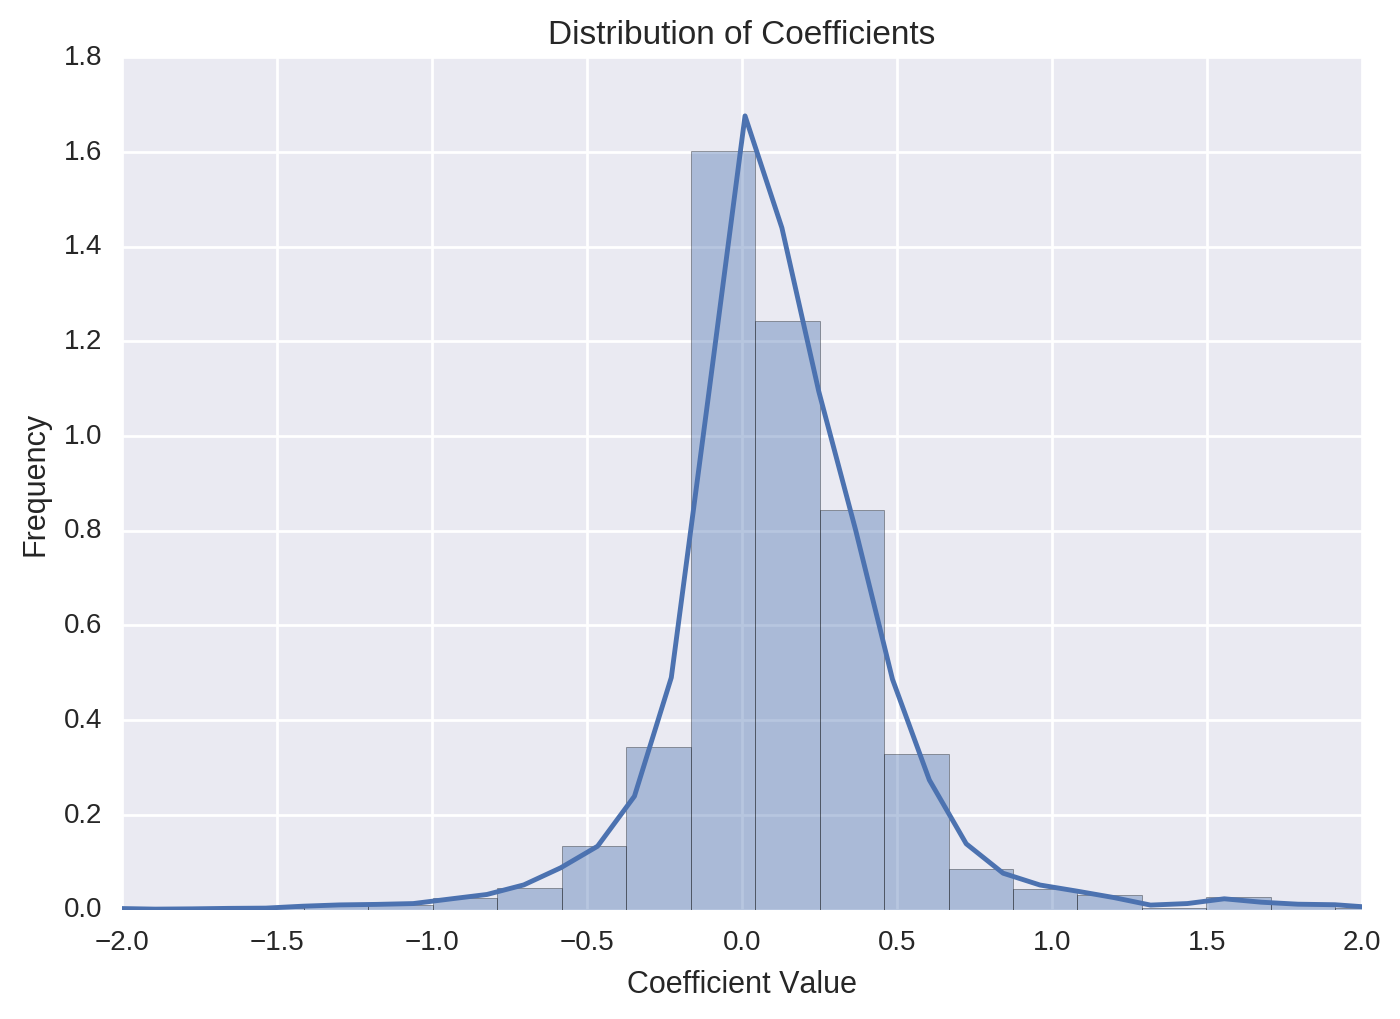

In [40]:
sns.distplot(coefficients_frame_all.values.flatten())
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.title('Distribution of Coefficients')
plt.xlim(-2,2)

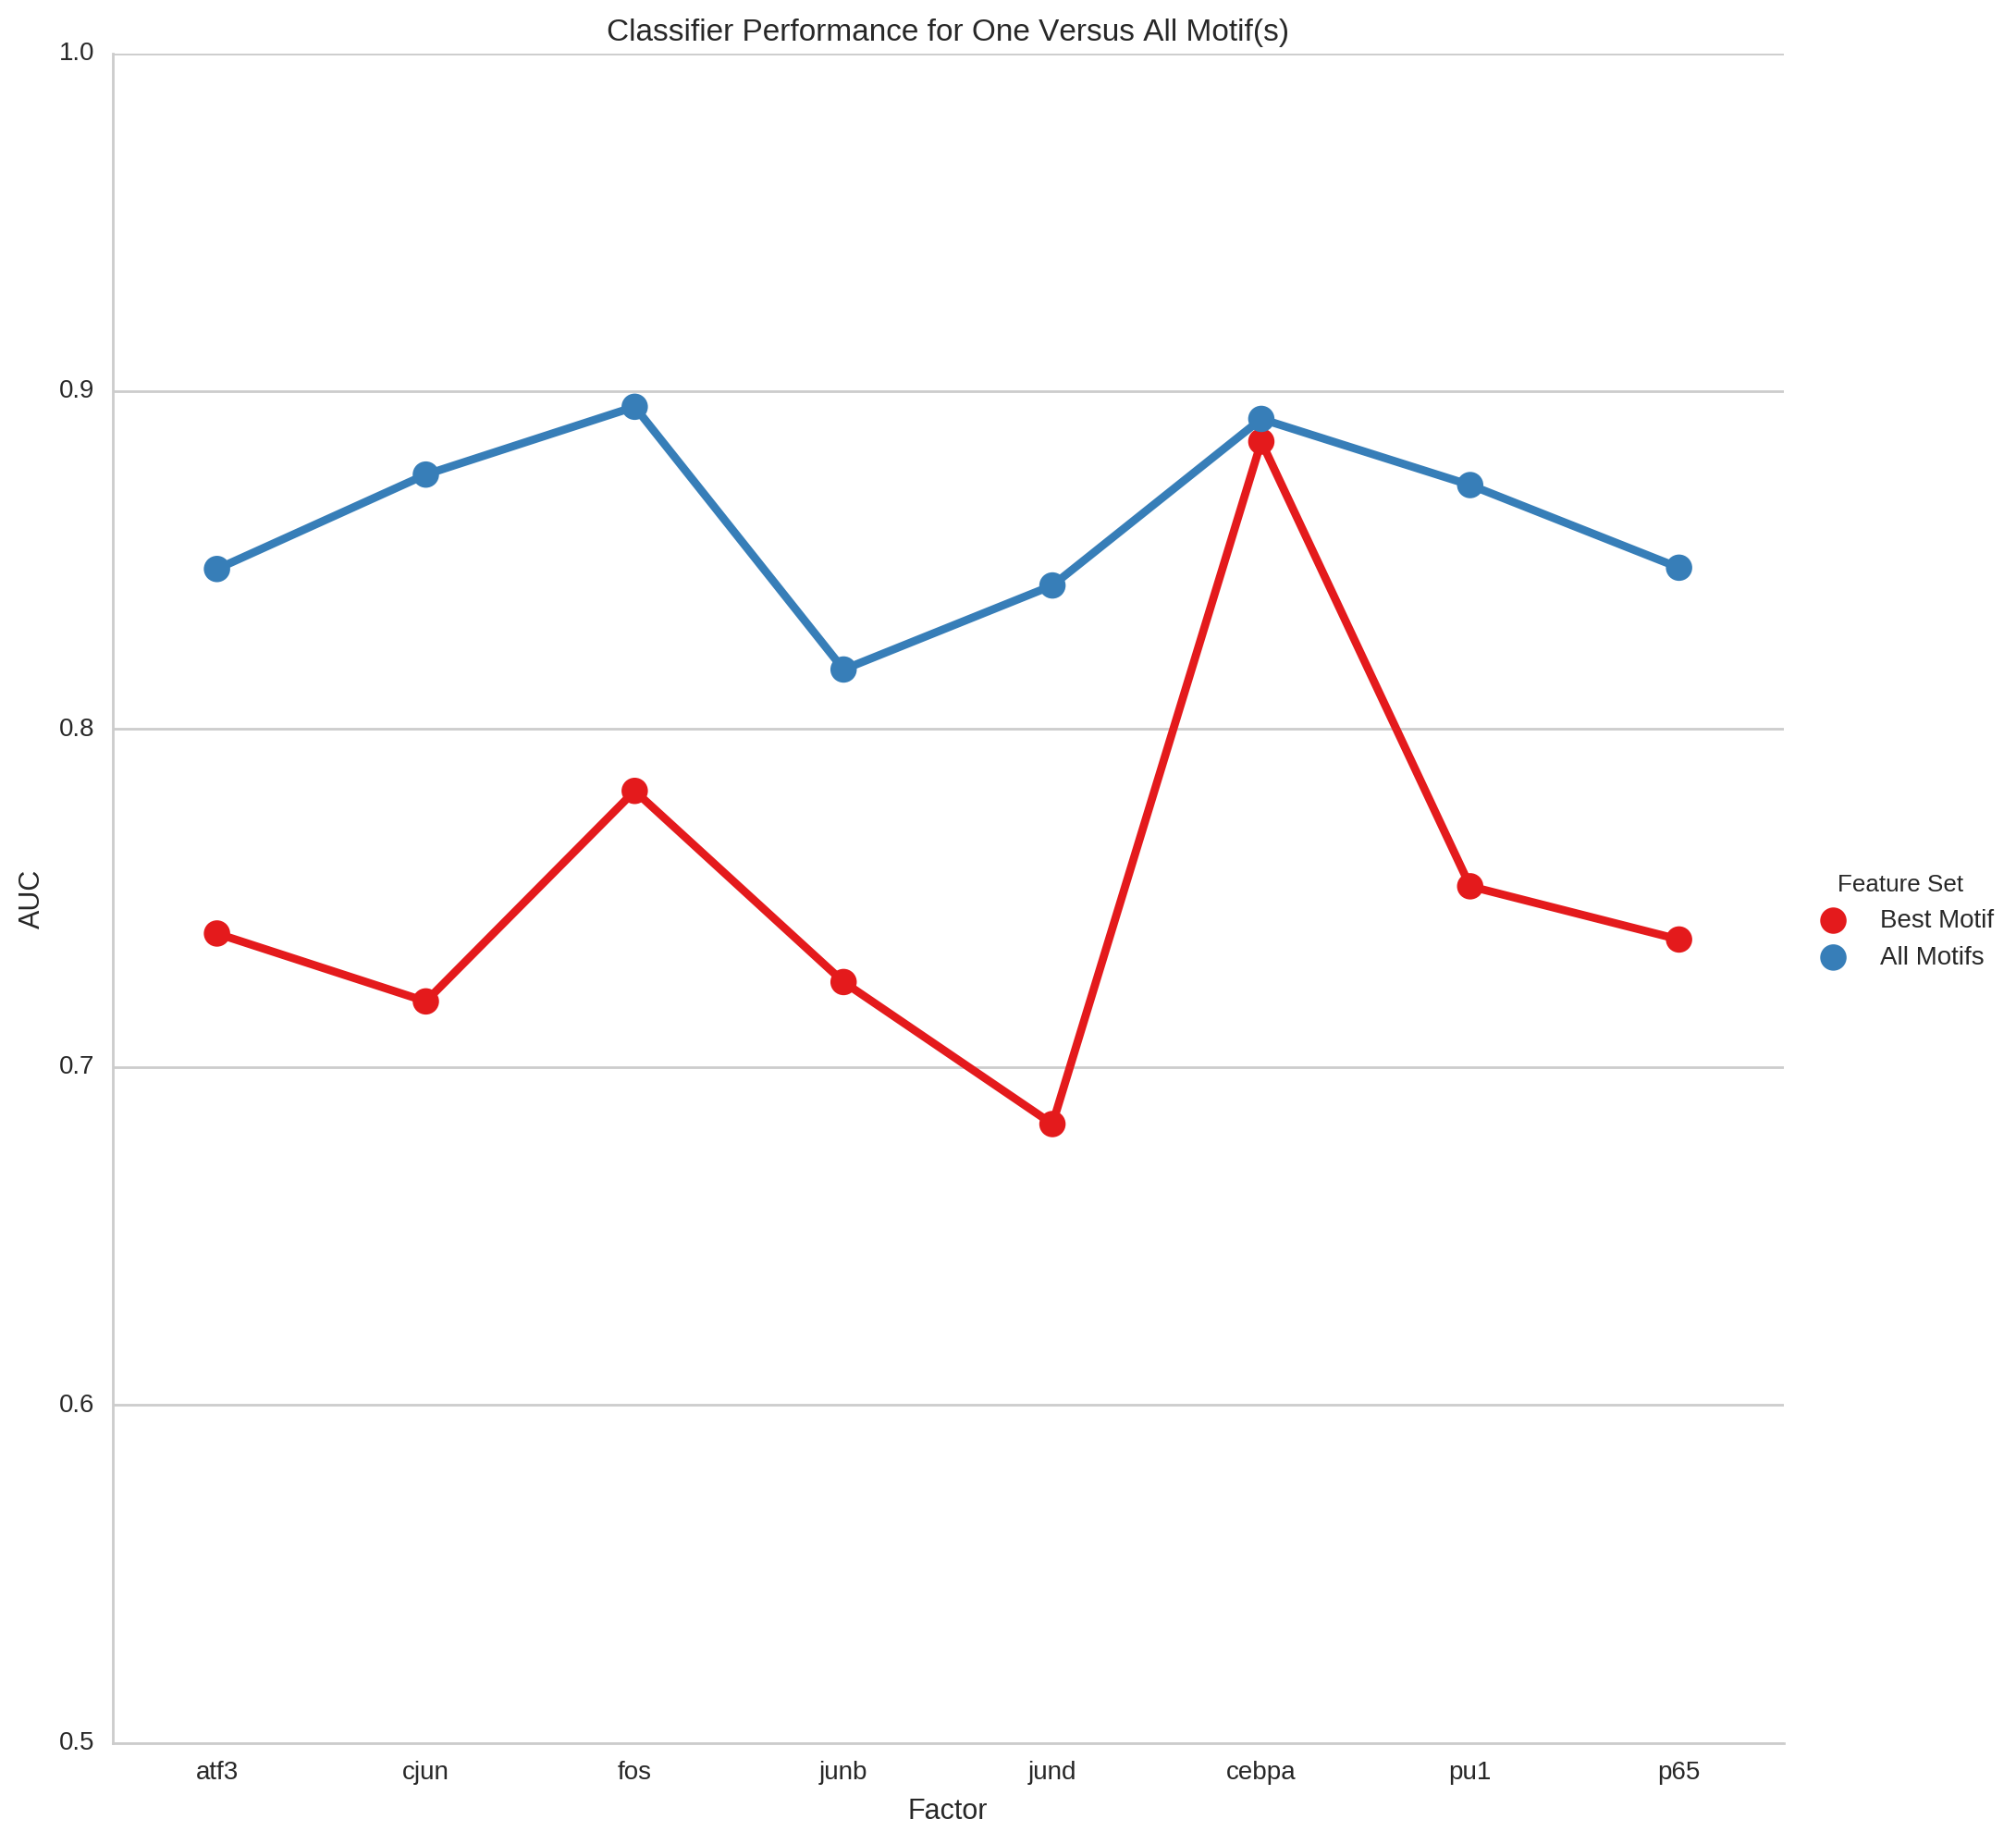

In [41]:
ind_max_aucs = auc_frame_ind.max()
factors = []
aucs = []
features = []
for factor in sorted(factor_auc_dict_all.keys()):
    factors = factors + 2 * [factor]
    features = features + ['Best Motif', 'All Motifs']
    aucs.append(ind_max_aucs[factor])
    aucs.append(factor_auc_dict_all[factor])
with sns.axes_style('whitegrid'):
    plottingFrame = sns.factorplot(data = pd.DataFrame({'Factor':factors,
                                                         'AUC':aucs,
                                                         'Feature Set':features}),
                                    x='Factor',
                                    y='AUC',
                                    hue='Feature Set',
                                    palette='Set1',
                                    size=10,
                                    order = ['atf3', 'cjun', 'fos', 'junb','jund','cebpa','pu1','p65']
                                  )
    plt.ylim(0.5,1)
    plt.title('Classifier Performance for One Versus All Motif(s)')

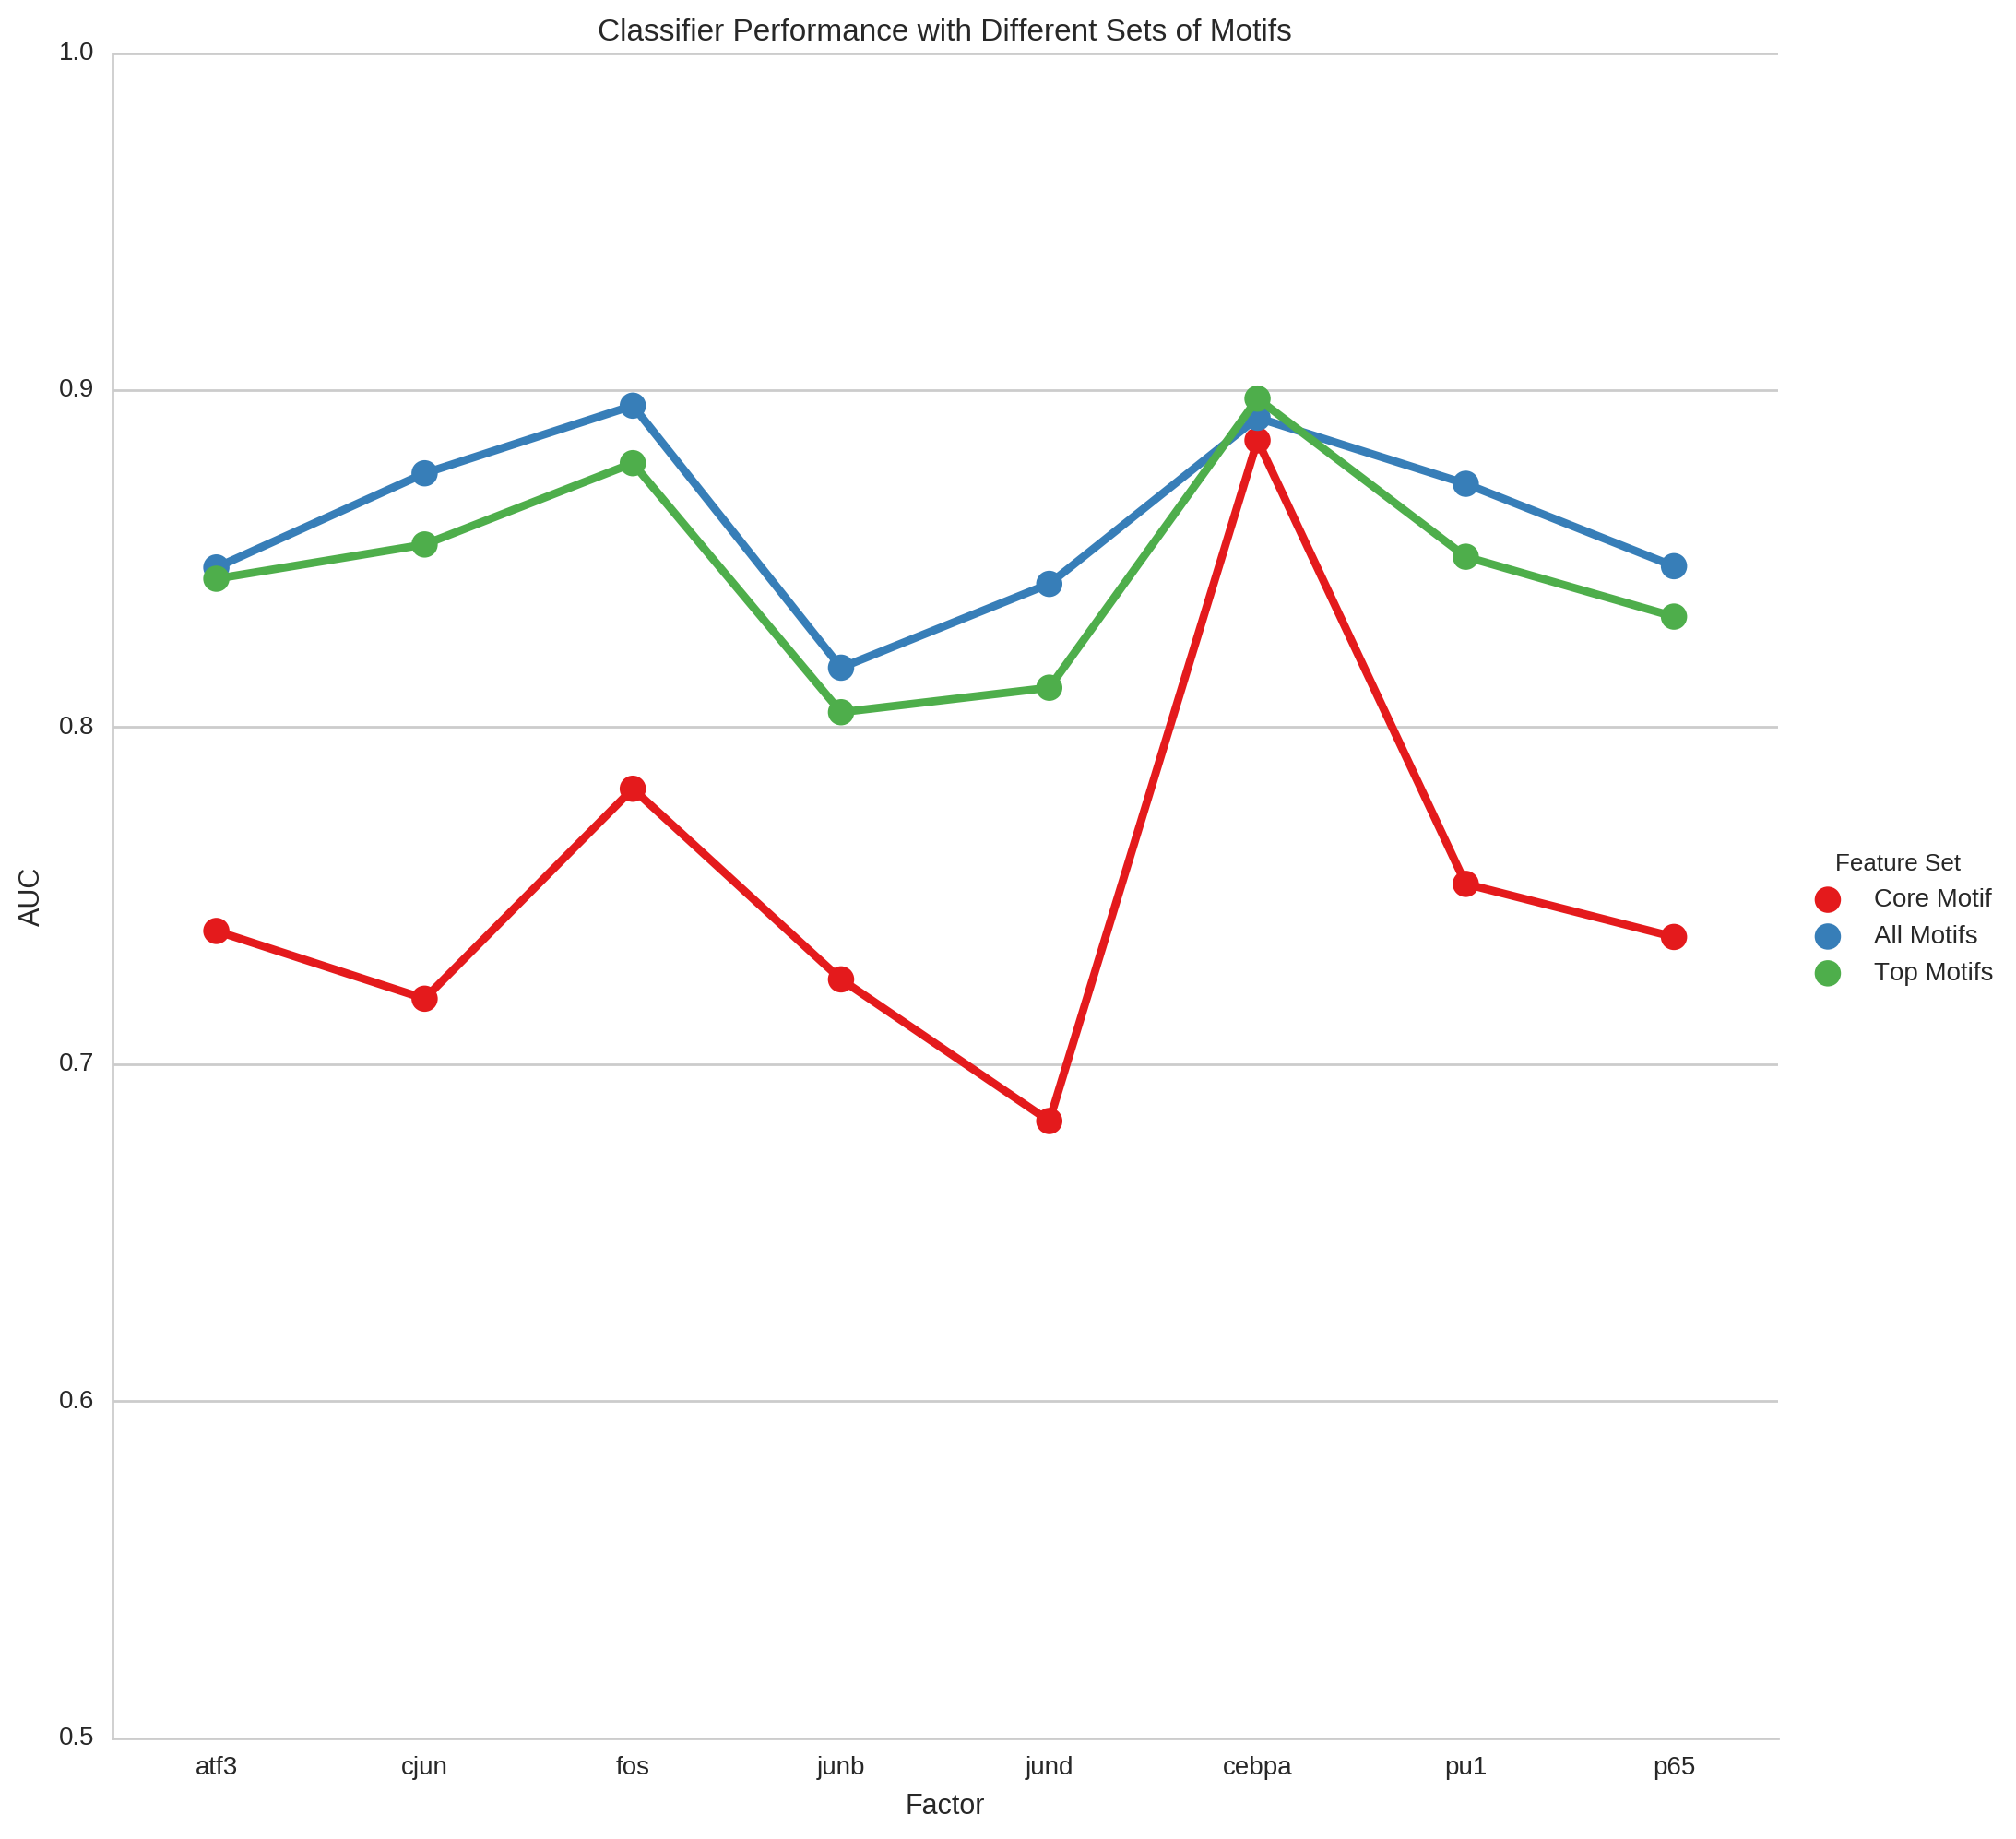

In [70]:
ind_max_aucs = auc_frame_ind.max()
factors = []
aucs = []
features = []
for factor in sorted(factor_auc_dict_all.keys()):
    factors = factors + 3 * [factor]
    features = features + ['Core Motif', 'All Motifs', 'Top Motifs']
    aucs.append(ind_max_aucs[factor])
    aucs.append(factor_auc_dict_all[factor])
    aucs.append(factor_auc_dict_all_best[factor])
with sns.axes_style('whitegrid'):
    plottingFrame = sns.factorplot(data = pd.DataFrame({'Factor':factors,
                                                         'AUC':aucs,
                                                         'Feature Set':features}),
                                x='Factor',
                                y='AUC',
                                hue='Feature Set',
                                palette='Set1',
                                size=10,
                                order = ['atf3', 'cjun', 'fos', 'junb','jund','cebpa','pu1','p65'])
    plt.ylim(0.5,1)
    plt.title('Classifier Performance with Different Sets of Motifs')

In [41]:
### for all vehicle peaks
factor_coeff_dict = {}
c67bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor in _factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c67bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c67bl6_indices)]['Factors'].str.contains(factor + '_veh')
    
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    predictions_lr = lr_classifier.predict(test_features)
    
    coefficients = lr_classifier.coef_
    intercept = lr_classifier.intercept_
    
    factor_coeff_dict[factor] = coefficients.flatten()
coefficients_frame_veh = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh = coefficients_frame_veh[sorted(_factors)]
coefficients_frame_veh.index = motif_score_frame.columns.values[3:]



total samples: 27753
true gc: 0.5095158798831584 false gc: 0.47374493471409274 difference: 0.03577094516906565
filtered samples: 19235
total samples: 27753
true gc: 0.4706346932071542 false gc: 0.4831521152016443 difference: 0.01251742199449013
filtered samples: 26501
total samples: 27753
true gc: 0.46476457976991026 false gc: 0.4854204700039951 difference: 0.020655890234084817
filtered samples: 23341
total samples: 27753
true gc: 0.48004020954163235 false gc: 0.4839957120404135 difference: 0.003955502498781127
filtered samples: 27753
total samples: 27753
true gc: 0.494721395290148 false gc: 0.4823339474284233 difference: 0.012387447861724743
filtered samples: 26495
total samples: 27753
true gc: 0.4772919342843621 false gc: 0.4829454380562703 difference: 0.005653503771908208
filtered samples: 27753
total samples: 27753
true gc: 0.48934012023058765 false gc: 0.4779082315083452 difference: 0.011431888722242434
filtered samples: 27278
total samples: 27753
true gc: 0.5195252837977297 false

In [42]:
### for all KLA peaks
factor_coeff_dict = {}
c67bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor in _factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c67bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c67bl6_indices)]['Factors'].str.contains(factor + '_kla')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    predictions_lr = lr_classifier.predict(test_features)
    
    coefficients = lr_classifier.coef_
    intercept = lr_classifier.intercept_
    
    factor_coeff_dict[factor] = coefficients.flatten()
coefficients_frame_kla = pd.DataFrame(factor_coeff_dict)
coefficients_frame_kla = coefficients_frame_kla[sorted(_factors)]
coefficients_frame_kla.index = motif_score_frame.columns.values[3:]




total samples: 27753
true gc: 0.48682085400712266 false gc: 0.47467212444999624 difference: 0.012148729557126425
filtered samples: 27326
total samples: 27753
true gc: 0.4751494916205539 false gc: 0.4832362407523248 difference: 0.008086749131770876
filtered samples: 27753
total samples: 27753
true gc: 0.4620860052089635 false gc: 0.4863285561291876 difference: 0.024242550920224093
filtered samples: 22155
total samples: 27753
true gc: 0.48000610213220374 false gc: 0.48666639074831236 difference: 0.006660288616108623
filtered samples: 27753
total samples: 27753
true gc: 0.47845893655029825 false gc: 0.49053896026735605 difference: 0.012080023717057797
filtered samples: 27314
total samples: 27753
true gc: 0.48132975537148076 false gc: 0.485145595768049 difference: 0.0038158403965682375
filtered samples: 27753
total samples: 27753
true gc: 0.48168363867936187 false gc: 0.4840719169997052 difference: 0.002388278320343329
filtered samples: 27753
total samples: 27753
true gc: 0.488179745298855

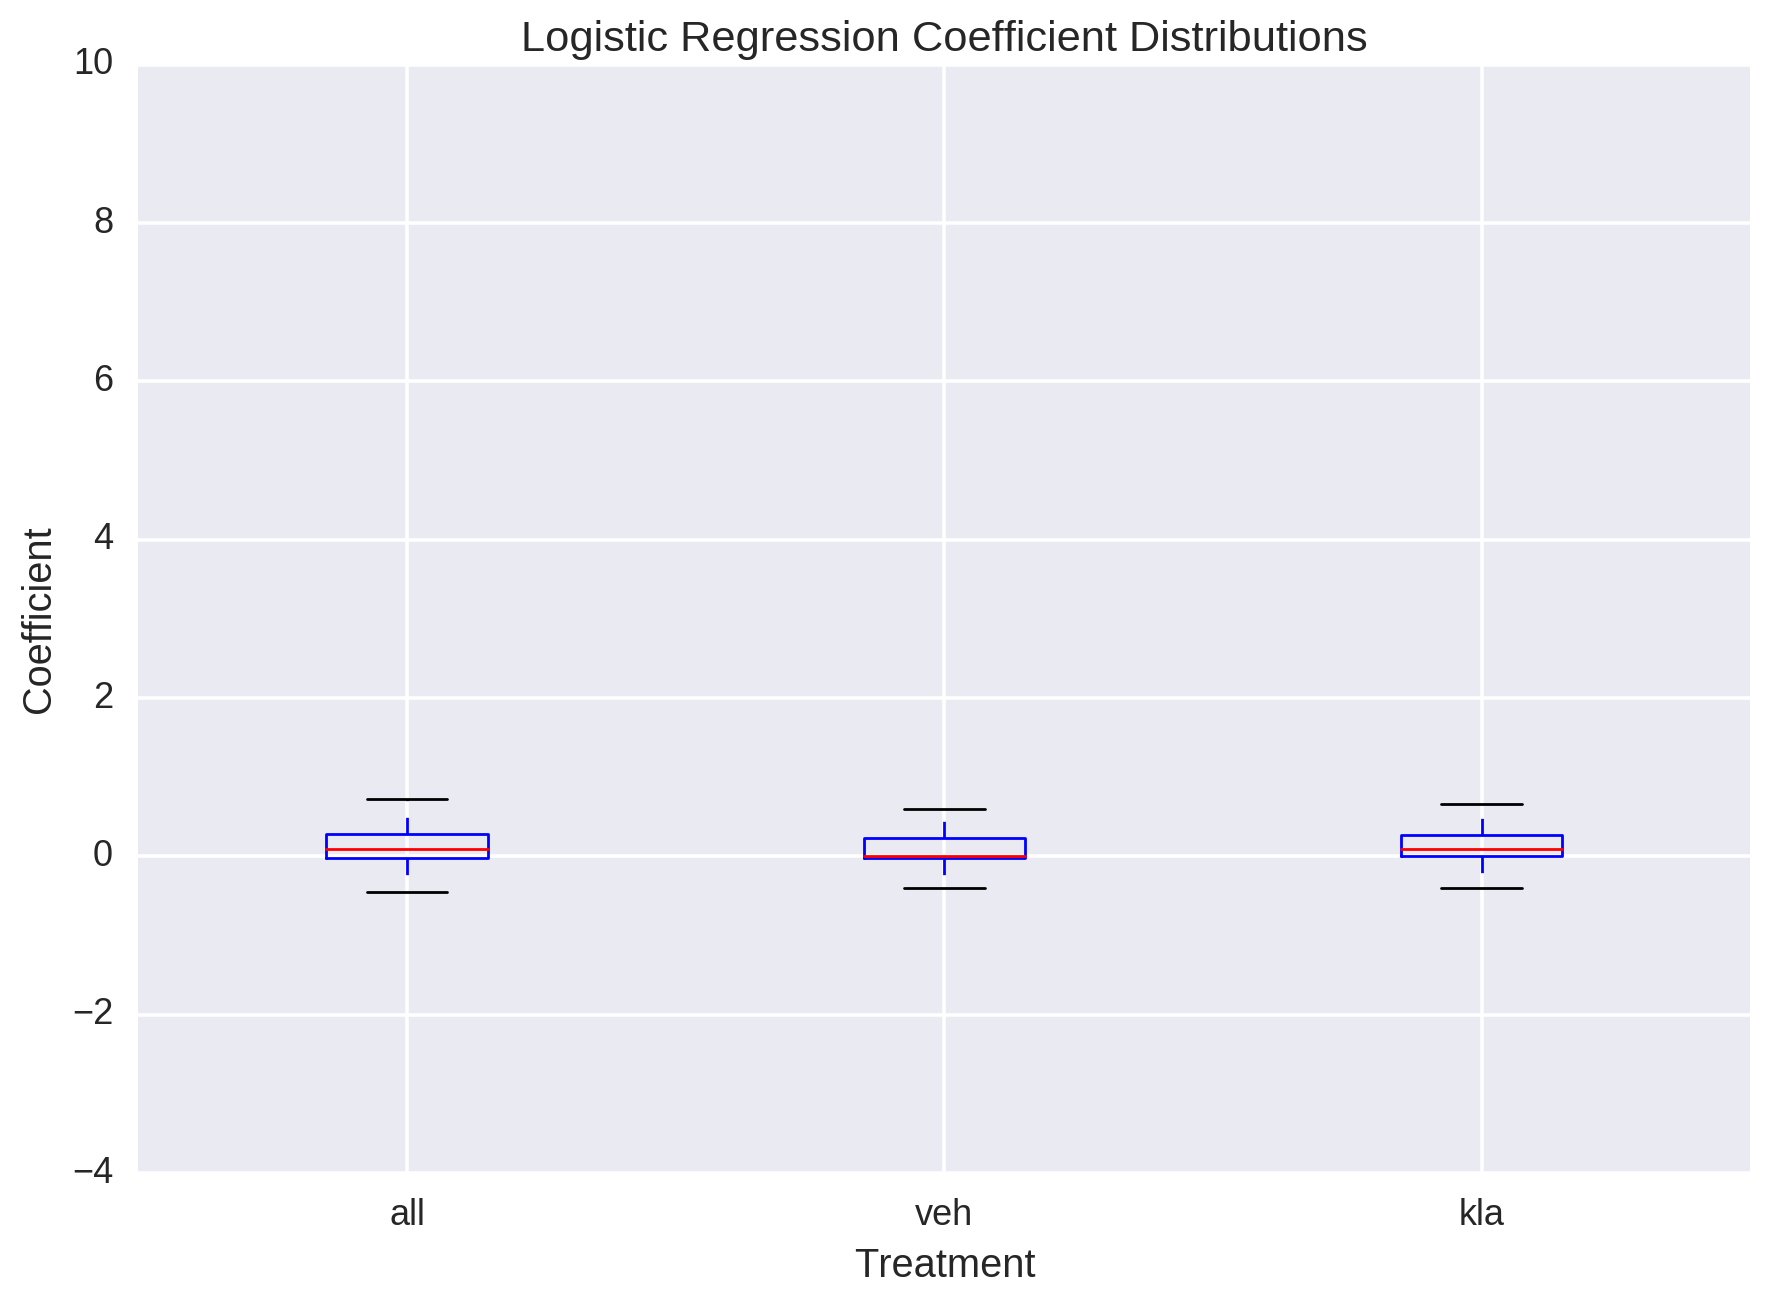

In [43]:
plt.boxplot([coefficients_frame_all.values.flatten(),
            coefficients_frame_veh.values.flatten(),
            coefficients_frame_kla.values.flatten()], labels=['all', 'veh', 'kla']);
plt.xlabel('Treatment')
plt.ylabel('Coefficient')
plt.title('Logistic Regression Coefficient Distributions')
# plt.ylim(-0.2, 0.2)
# plt.xticks

In [44]:
scipy.stats.describe(coefficients_frame_veh.values.flatten())

DescribeResult(nobs=1764, minmax=(-2.8254579430442015, 7.8651886209748127), mean=0.08242787385377065, variance=0.15637398213109638, skewness=4.659077153600538, kurtosis=91.4955104161544)

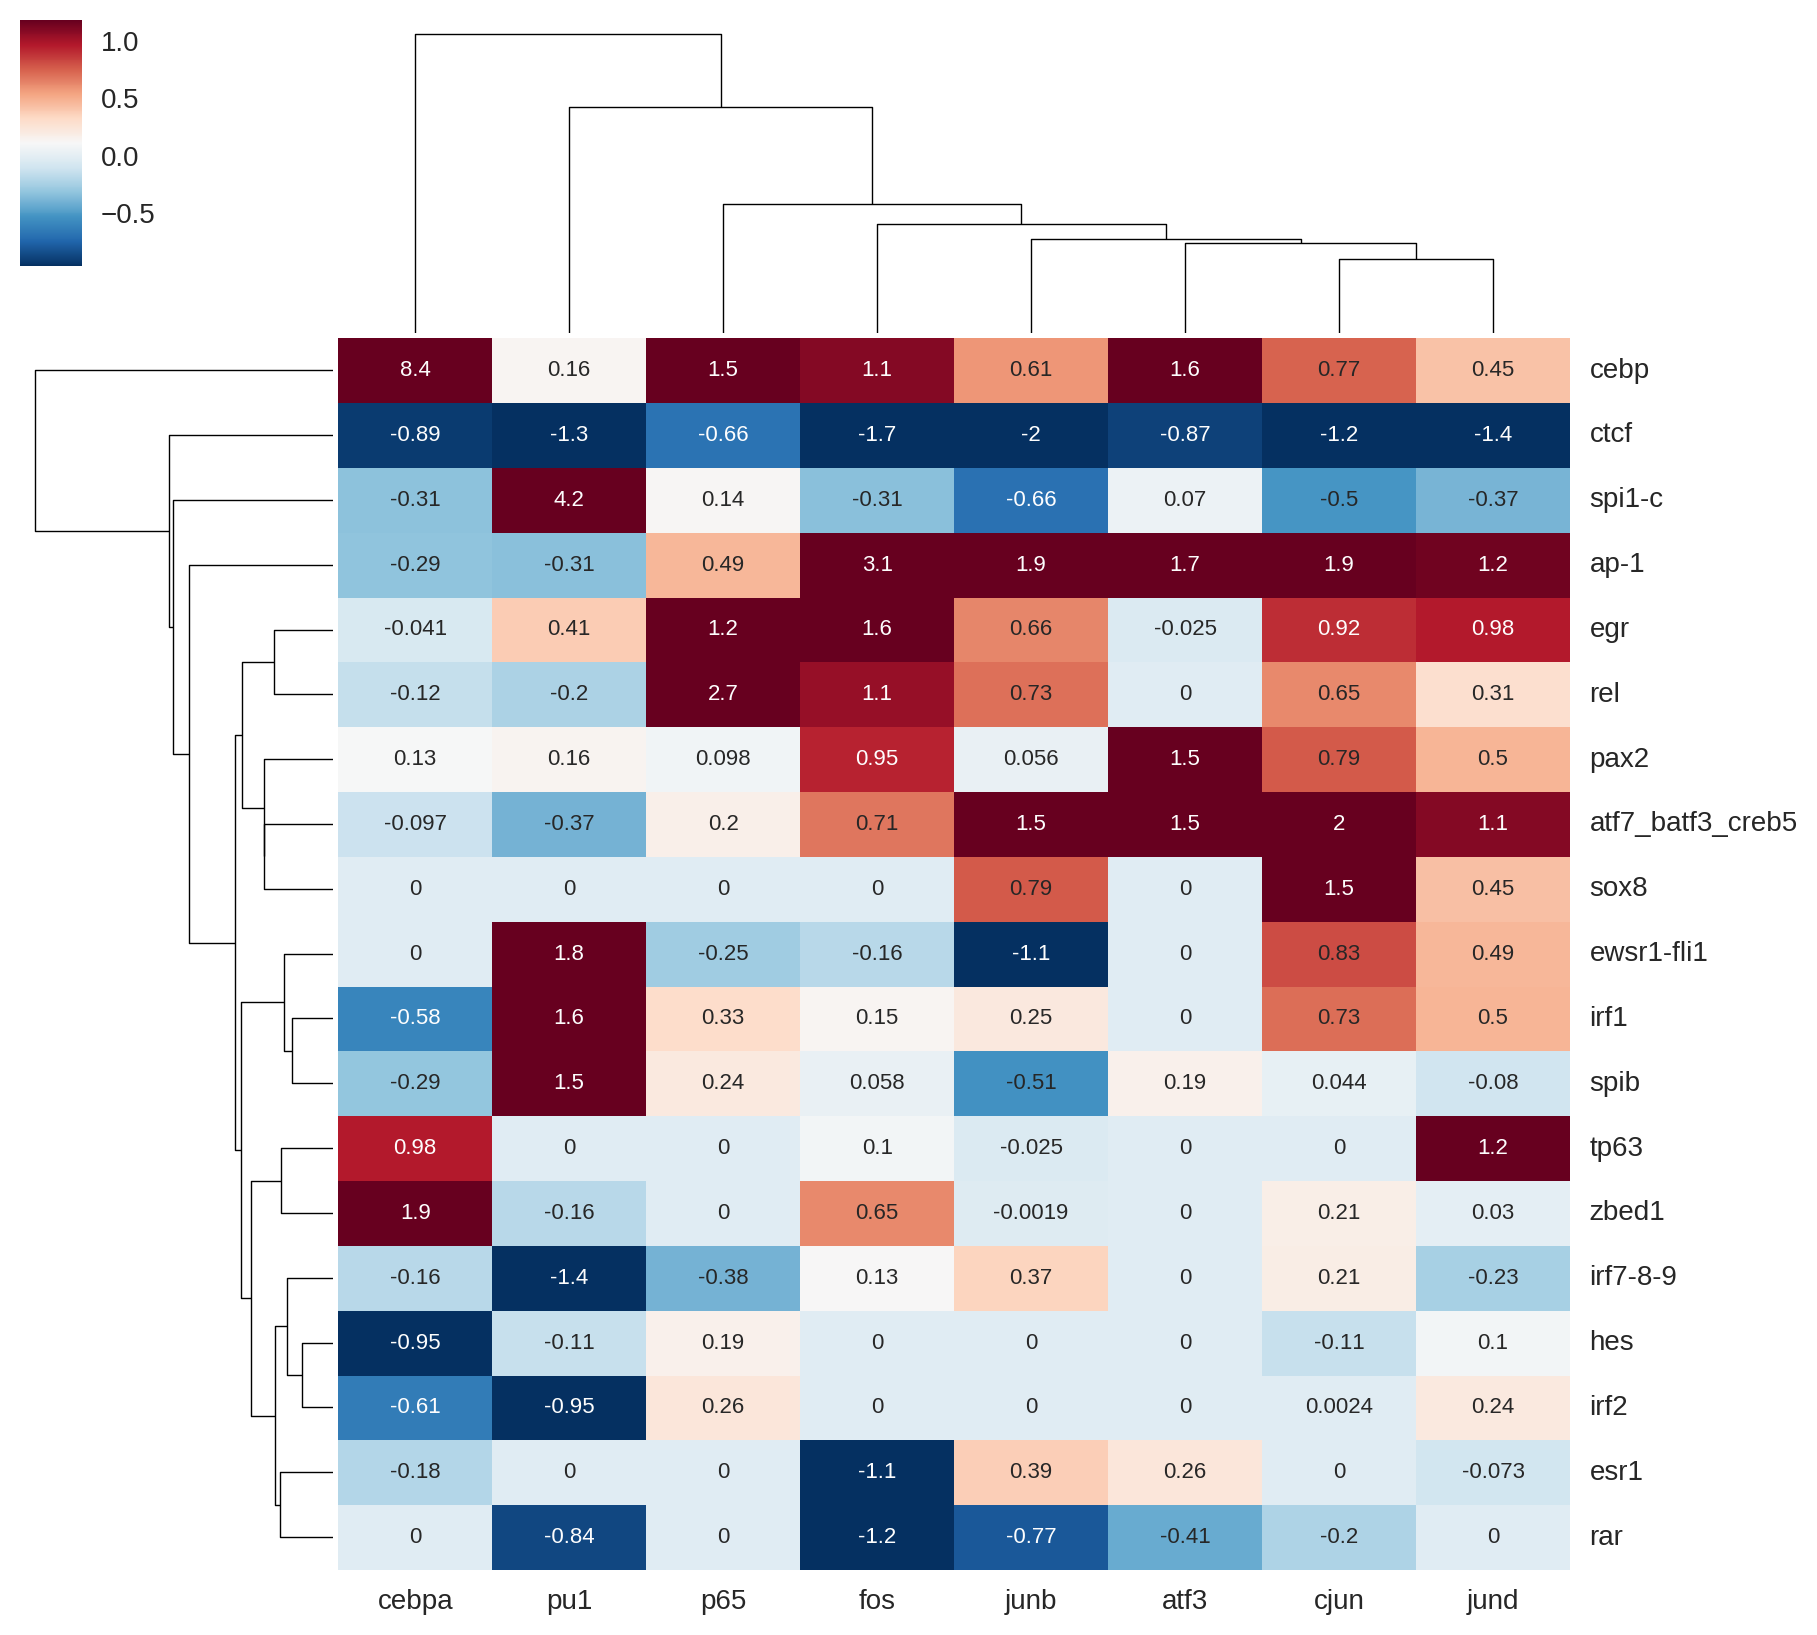

In [23]:
### plot coefficents for both vehicle and kla
threshold = 2.5
coeff_std = np.std(coefficients_frame_all.values.flatten())
coeff_mean = np.mean(coefficients_frame_all.values.flatten())

cg = sns.clustermap(coefficients_frame_all[(coefficients_frame_all.max(axis=1) > coeff_mean + threshold* coeff_std) |
                                       (coefficients_frame_all.min(axis=1) < coeff_mean - threshold* coeff_std)
                                      ],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=True,annot_kws={"size": 8})
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);



In [24]:
coeff_std = np.std(coefficients_frame_veh.values.flatten());
coeff_mean = np.mean(coefficients_frame_veh.values.flatten());
toExclude = ['jund', 'fos', 'junb'];
threshold =2.5;

cg = sns.clustermap(coefficients_frame_veh[
                                       (coefficients_frame_veh[[x for x in _factors if not x in toExclude]].max(axis=1) > coeff_mean + threshold* coeff_std) |
                                       (coefficients_frame_veh[[x for x in _factors if not x in toExclude]].min(axis=1) < coeff_mean - threshold* coeff_std)
                                      ],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=True,annot_kws={"size": 8});

plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
# plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10, rotation=0);

# hm = cg.ax_heatmap.get_position()
# cg.ax_heatmap.set_position([hm.x0, hm.y0, hm.width, hm.height*2])

# rd_pos = cg.ax_row_dendrogram.get_position()
# cg.ax_row_dendrogram.set_position([rd_pos.x0, rd_pos.y0, rd_pos.width, rd_pos.height*2])

# cd_pos = cg.ax_col_dendrogram.get_position()
# cg.ax_col_dendrogram.set_position([cd_pos.x0, cd_pos.y0+0.62, cd_pos.width, cd_pos.height])



NameError: name 'coefficients_frame_veh' is not defined

In [25]:
### plot coefficients for KLA treatment ###
coeff_std = np.std(coefficients_frame_kla.values.flatten())
coeff_mean = np.mean(coefficients_frame_kla.values.flatten())
threshold = 2.5

cg = sns.clustermap(coefficients_frame_kla[(coefficients_frame_kla.max(axis=1) > coeff_mean + threshold* coeff_std) |
                                       (coefficients_frame_kla.min(axis=1) < coeff_mean - threshold* coeff_std)
                                      ],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=True,annot_kws={"size": 8})
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);




NameError: name 'coefficients_frame_kla' is not defined

## Pairs of transcription factors

In [52]:
factorPairs = []
ap1_members = ['atf3','cjun','fos','junb','jund']

# for i in range(len(_factors)-1):
#     for j in range(i+1, len(_factors)):
#         factorPairs.append(('c57bl6_'+_factors[i],'c57bl6_'+ _factors[j]))
        
        
for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

In [ ]:
aucs = []
classifiers = []
metrics = []
factors = []

c67bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
    
for factorPair in factorPairs:
    print(factorPair)
    
    features = normed_motif_frame[normed_motif_frame.index.isin(c67bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c67bl6_indices)]['Factors'].str.contains(
        factorPair[0]) & summary_frame['Factors'].str.contains(factorPair[1])

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)

    # Run classifier
    svm_classifier = svm.SVC(kernel='linear', probability=True)
    rf_classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=50)
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    svm_classifier.fit(training_features, training_labels)
    rf_classifier.fit(training_features, training_labels)
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_svm = svm_classifier.predict_proba(test_features)
    probas_rf = rf_classifier.predict_proba(test_features)
    probas_lr = lr_classifier.predict_proba(test_features)
    
    # roc curv for svm
    fpr_svm, tpr_svm, thresholds_roc_svm = sklearn.metrics.roc_curve(test_labels, probas_svm[:, 1])
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    aucs.append(roc_auc_svm)
    
    # roc curv for rf
    fpr_rf, tpr_rf, thresholds_roc_rf = sklearn.metrics.roc_curve(test_labels, probas_rf[:, 1])
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    aucs.append(roc_auc_rf)
   
    # roc curv for lr
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    aucs.append(roc_auc_lr)
       
    print('training set|', 'num samples:', len(training_labels), 'num True:', np.sum(training_labels))
    print('test set    |', 'num samples:', len(test_labels), 'num True:', np.sum(test_labels))
    print('lr_auc', roc_auc_lr)
    
    classifiers = classifiers + ['svm', 'rf', 'lr']
    factors = factors + ['_'.join(factorPair)] * 3
classifier_frame = pd.DataFrame({'factor':factors, 
                                 'AUC':aucs,
                                'classifier':classifiers})


In [ ]:
sns.factorplot(data = classifier_frame, 
               x='factor', 
               y='AUC', 
               hue='classifier',
              kind='point', size =10)
plt.xticks(rotation=90);
plt.title('ROC AUC')
plt.show()

In [58]:
### for all peaks in vehicle and KLA for all motifs



factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c67bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c67bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c67bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1] +'_kla')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_all_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all_pairs.index = motif_score_frame.columns.values[3:]

total: 27753 filtered: 26971 true gc: 0.49382 false gc: 0.48383 difference: 0.01
('c57bl6_atf3', 'c57bl6_cjun') 0.848211869258
total: 27753 filtered: 27753 true gc: 0.47585 false gc: 0.48318 difference: 0.00733
('c57bl6_atf3', 'c57bl6_fos') 0.85700228564
total: 27753 filtered: 27753 true gc: 0.47857 false gc: 0.48304 difference: 0.00447
('c57bl6_atf3', 'c57bl6_junb') 0.85656320499
total: 27753 filtered: 27753 true gc: 0.4894 false gc: 0.48259 difference: 0.0068
('c57bl6_atf3', 'c57bl6_jund') 0.863036871543
total: 27753 filtered: 21397 true gc: 0.50475 false gc: 0.49475 difference: 0.01
('c57bl6_cjun', 'c57bl6_fos') 0.855815200962
total: 27753 filtered: 20639 true gc: 0.50664 false gc: 0.49664 difference: 0.01
('c57bl6_cjun', 'c57bl6_junb') 0.847810686014
total: 27753 filtered: 19035 true gc: 0.51138 false gc: 0.50138 difference: 0.01
('c57bl6_cjun', 'c57bl6_jund') 0.833972492488
total: 27753 filtered: 27753 true gc: 0.4889 false gc: 0.48037 difference: 0.00853
('c57bl6_fos', 'c57bl6_ju

In [59]:
coefficients_frame_all_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all_pairs = coefficients_frame_all_pairs[sorted(coefficients_frame_all_pairs.columns.values)]
coefficients_frame_all_pairs.index = motif_score_frame.columns.values[3:]

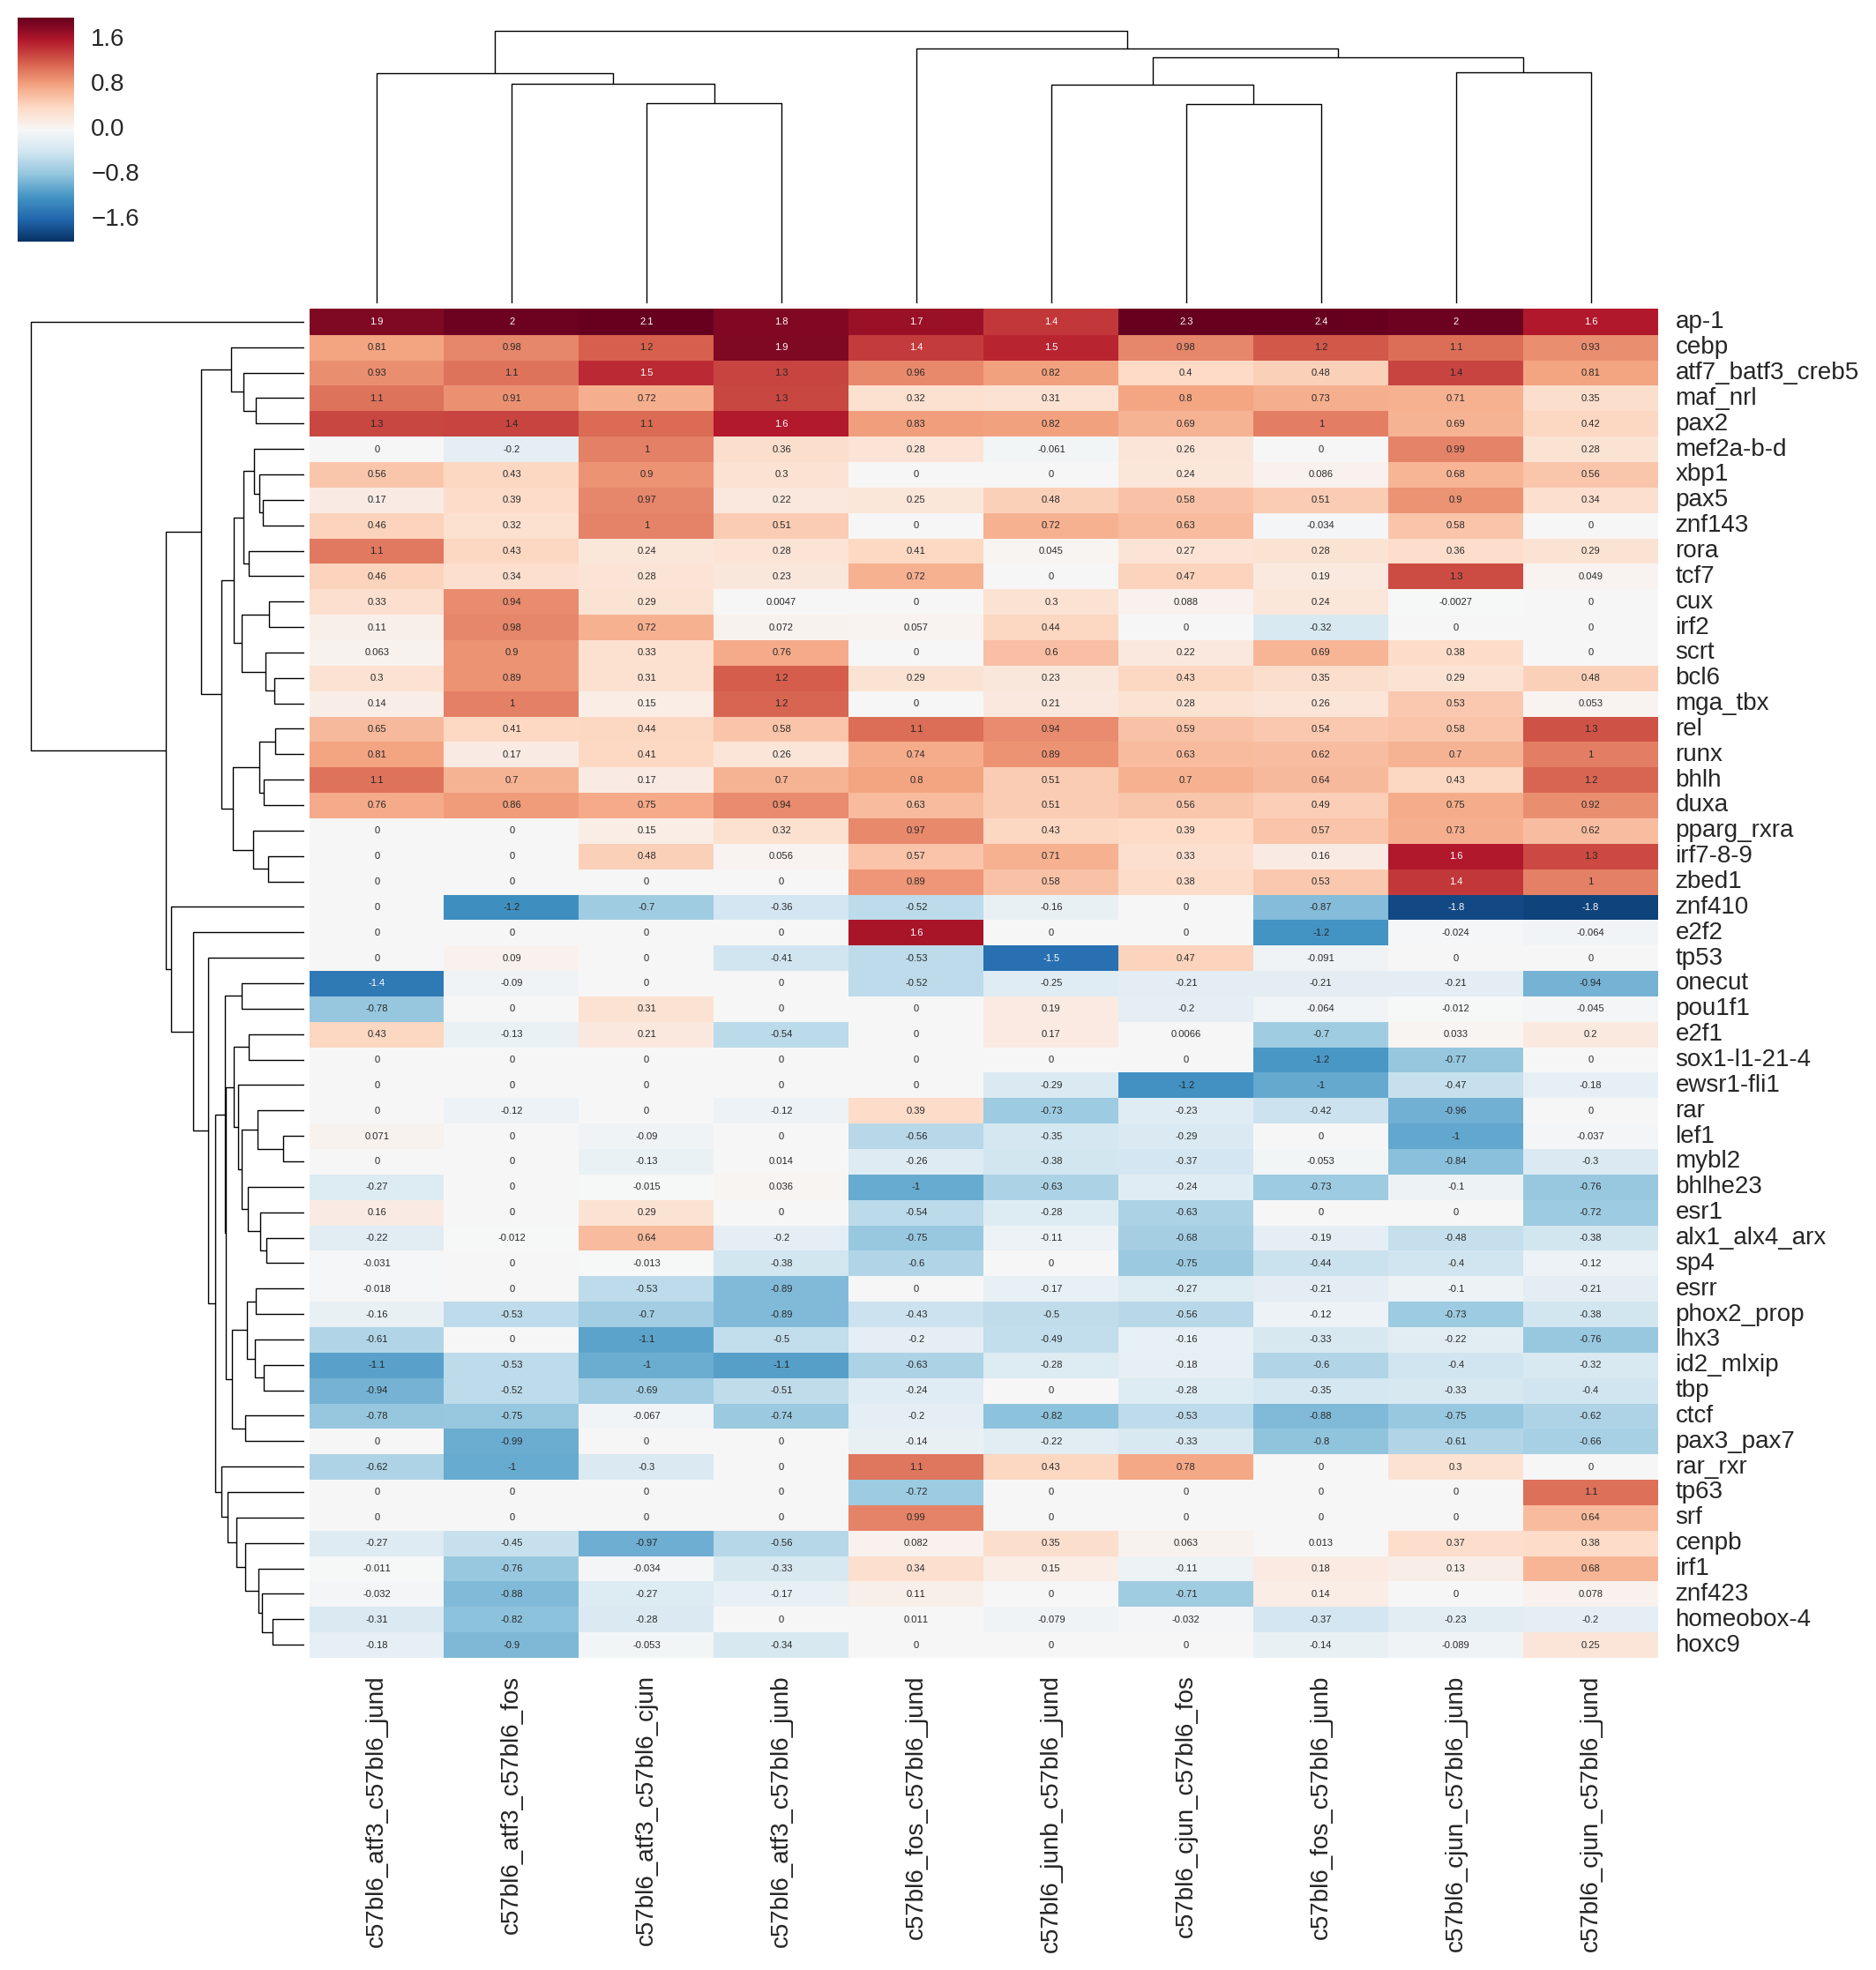

In [60]:
### plot coefficents for both vehicle and kla
threshold = 2.0
coeff_std = np.std(coefficients_frame_all_pairs.values.flatten())
coeff_mean = np.mean(coefficients_frame_all_pairs.values.flatten())

cg = sns.clustermap(coefficients_frame_all_pairs[(coefficients_frame_all_pairs.max(axis=1) > coeff_mean + threshold* coeff_std) |
                                       (coefficients_frame_all_pairs.min(axis=1) < coeff_mean - threshold* coeff_std)
                                      ],
                   vmax=-2,
                   vmin=2,
                   center = 0.0,
                   annot=True,annot_kws={"size": 4},
                   figsize=(12,12))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);




In [63]:
### for all peaks in vehicle and KLA for top motifs
factor_coeff_dict = {}
factor_auc_dict_pairs_top = {}
# motifs = ['ap-1','cebp','rel','spi1-c']
motifs = ['ap-1']
c67bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c67bl6_indices)][motifs]

    
    labels = summary_frame[summary_frame.index.isin(c67bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1]+'_kla')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs_top['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)


coefficients_frame_all_pairs_top = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all_pairs_top.index = motifs

total: 27753 filtered: 27064 true gc: 0.49382 false gc: 0.48383 difference: 0.01
('c57bl6_atf3', 'c57bl6_cjun') 0.750651013475
total: 27753 filtered: 27753 true gc: 0.47585 false gc: 0.48318 difference: 0.00733
('c57bl6_atf3', 'c57bl6_fos') 0.764591447993
total: 27753 filtered: 27753 true gc: 0.47857 false gc: 0.48304 difference: 0.00447
('c57bl6_atf3', 'c57bl6_junb') 0.754971942877
total: 27753 filtered: 27753 true gc: 0.4894 false gc: 0.48259 difference: 0.0068
('c57bl6_atf3', 'c57bl6_jund') 0.75785644015
total: 27753 filtered: 21381 true gc: 0.50475 false gc: 0.49476 difference: 0.01
('c57bl6_cjun', 'c57bl6_fos') 0.747018700951
total: 27753 filtered: 20625 true gc: 0.50664 false gc: 0.49665 difference: 0.00999
('c57bl6_cjun', 'c57bl6_junb') 0.726606722496
total: 27753 filtered: 19137 true gc: 0.51138 false gc: 0.50138 difference: 0.01
('c57bl6_cjun', 'c57bl6_jund') 0.688376386925
total: 27753 filtered: 27753 true gc: 0.4889 false gc: 0.48037 difference: 0.00853
('c57bl6_fos', 'c57bl

In [67]:
### for all peaks in vehicle and KLA using significant motifs

threshold = 2.0
factor_motifs_dict = {}
significant_motifs = set()
for factor in coefficients_frame_all_pairs.columns.values:
    weights = coefficients_frame_all_pairs[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    for m in motif_hits:
        significant_motifs.add(m)
    print(factor, mean-threshold*std, mean+threshold*std)

    factor_motifs_dict[factor] = motif_hits
significant_motifs = sorted(significant_motifs)
    
factor_coeff_dict = {}
factor_auc_dict_all_pairs_best = {}
c67bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c67bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c67bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1] +'_kla')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_all_pairs_best['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_all_pairs_best = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all_pairs_best.index = motif_score_frame.columns.values[3:]




c57bl6_atf3_c57bl6_cjun -0.689581045479 0.90601029711
c57bl6_atf3_c57bl6_fos -0.729661501103 0.905022768471
c57bl6_atf3_c57bl6_junb -0.720312147242 0.930002786339
c57bl6_atf3_c57bl6_jund -0.648057267109 0.823796348436
c57bl6_cjun_c57bl6_fos -0.64060950618 0.827860466451
c57bl6_cjun_c57bl6_junb -0.764937859428 0.992156452557
c57bl6_cjun_c57bl6_jund -0.723682622714 0.946192743926
c57bl6_fos_c57bl6_junb -0.673784305588 0.836161415295
c57bl6_fos_c57bl6_jund -0.658012199057 0.920269404613
c57bl6_junb_c57bl6_jund -0.579270680634 0.819591380669
total: 27753 filtered: 27048 true gc: 0.49382 false gc: 0.48383 difference: 0.01
('c57bl6_atf3', 'c57bl6_cjun') 0.858640591012
total: 27753 filtered: 27753 true gc: 0.47585 false gc: 0.48318 difference: 0.00733
('c57bl6_atf3', 'c57bl6_fos') 0.863061677185
total: 27753 filtered: 27753 true gc: 0.47857 false gc: 0.48304 difference: 0.00447
('c57bl6_atf3', 'c57bl6_junb') 0.862734774096
total: 27753 filtered: 27753 true gc: 0.4894 false gc: 0.48259 differe

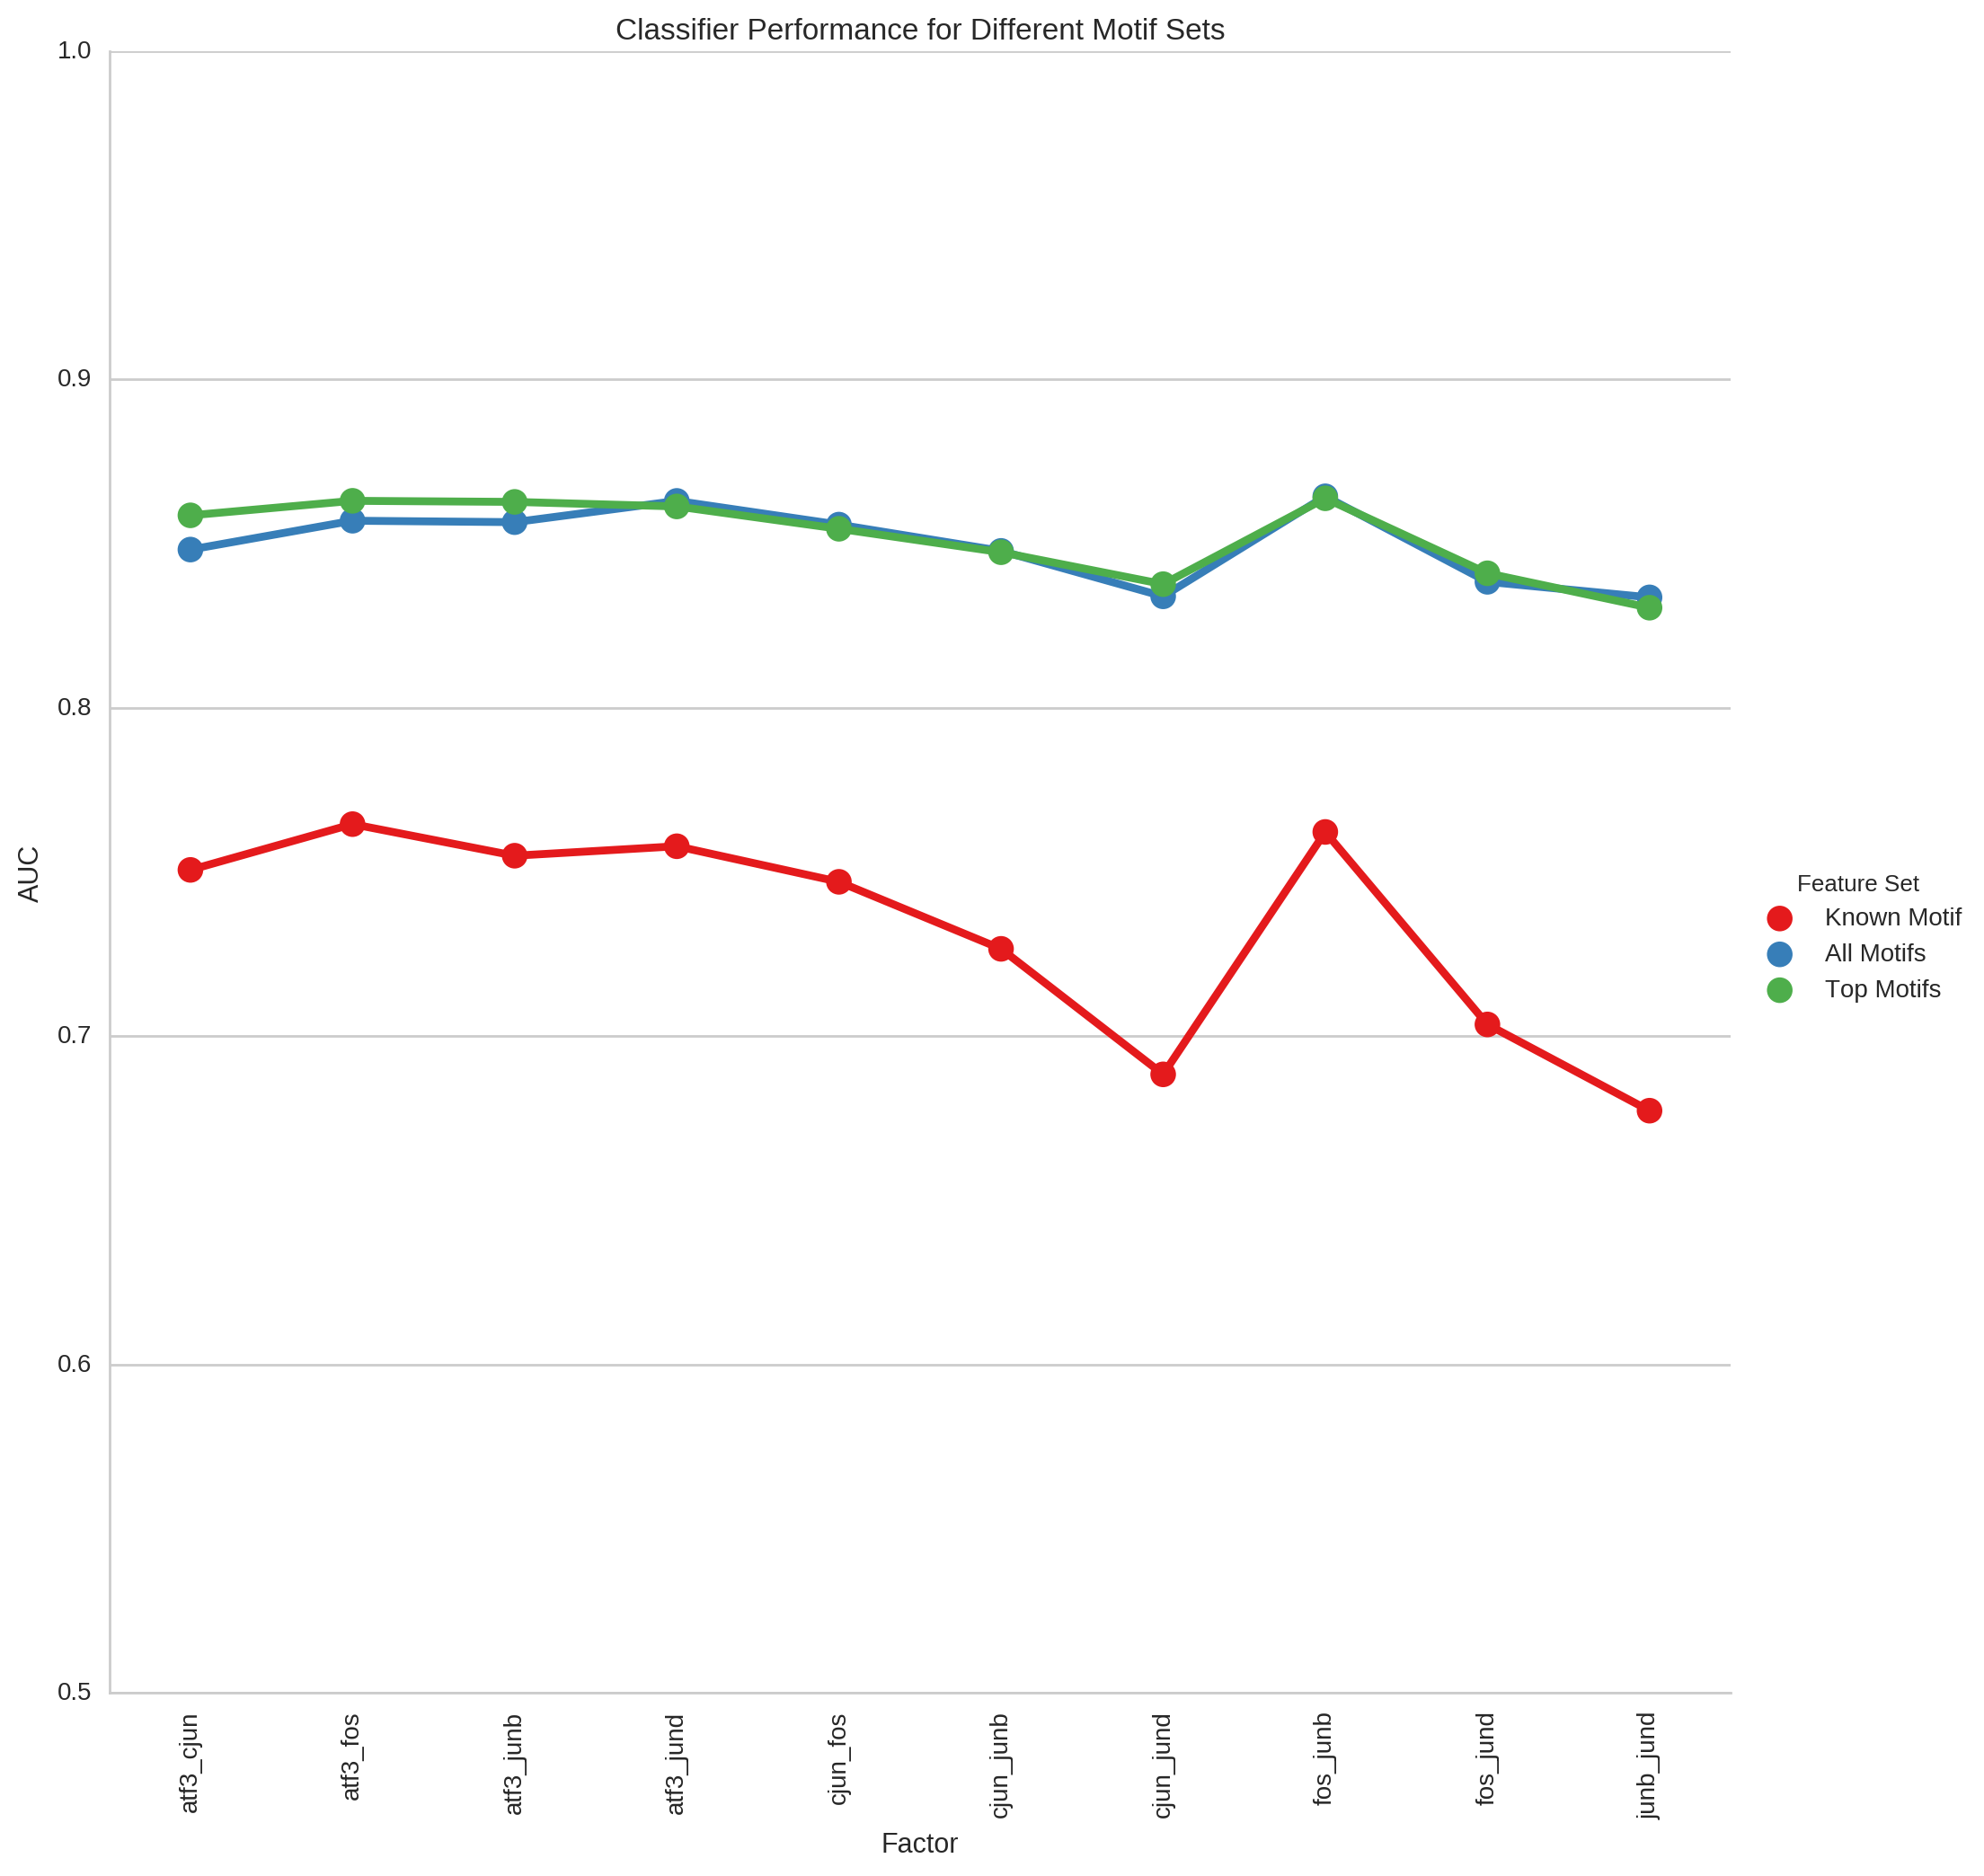

In [69]:
factors = []
aucs = []
features = []
for factor in sorted(factor_auc_dict_pairs.keys()):
#     if factor.split('_')[0] in ap1_members and factor.split('_')[1] in ap1_members:
    if True:
        factors = factors + 3 * [factor]
        features = features + ['Known Motif', 'All Motifs', 'Top Motifs']
        aucs.append(factor_auc_dict_pairs_top[factor])
        aucs.append(factor_auc_dict_pairs[factor])
        aucs.append(factor_auc_dict_all_pairs_best[factor])
with sns.axes_style('whitegrid'):
    plottingFrame = sns.factorplot(data = pd.DataFrame({'Factor':factors,
                                                         'AUC':aucs,
                                                         'Feature Set':features}),
                                x='Factor',
                                y='AUC',
                                hue='Feature Set',
                                palette='Set1',
                                size=10)
    plt.xticks(rotation=90)
    plt.ylim(0.5,1)
    plt.title('Classifier Performance for Different Motif Sets')

In [ ]:
### for all peaks in vehicle for all motifs
factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c67bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c67bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c67bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_veh') & summary_frame['Factors'].str.contains(factorPair[1] + '_veh')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_veh_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh_pairs.index = motif_score_frame.columns.values[3:]

total: 27753 filtered: 24737 true gc: 0.46682 false gc: 0.47682 difference: 0.01
('c57bl6_atf3', 'c57bl6_cebpa') 0.870510596941
total: 27753 filtered: 27232 true gc: 0.47215 false gc: 0.48215 difference: 0.01
('c57bl6_atf3', 'c57bl6_cjun') 0.831517279324
total: 27753 filtered: 27753 true gc: 0.48377 false gc: 0.48282 difference: 0.00094
('c57bl6_atf3', 'c57bl6_fos') 0.5
total: 27753 filtered: 25929 true gc: 0.46914 false gc: 0.47913 difference: 0.00999
('c57bl6_atf3', 'c57bl6_junb') 0.811765484091
total: 27753 filtered: 26894 true gc: 0.49422 false gc: 0.48422 difference: 0.01
('c57bl6_atf3', 'c57bl6_jund') 0.834159137278
total: 27753 filtered: 27753 true gc: 0.48816 false gc: 0.48282 difference: 0.00534
('c57bl6_atf3', 'c57bl6_p65') 0.739800660193
total: 27753 filtered: 26943 true gc: 0.47163 false gc: 0.48162 difference: 0.01
('c57bl6_atf3', 'c57bl6_pu1') 0.830439078789
total: 27753 filtered: 25466 true gc: 0.46861 false gc: 0.47861 difference: 0.01
('c57bl6_cebpa', 'c57bl6_cjun') 0.

In [ ]:
### for all peaks in KLA for all motifs
factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c67bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c67bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c67bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1] + '_kla')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_kla_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_kla_pairs.index = motif_score_frame.columns.values[3:]

### Investingating PU1 and CEBP

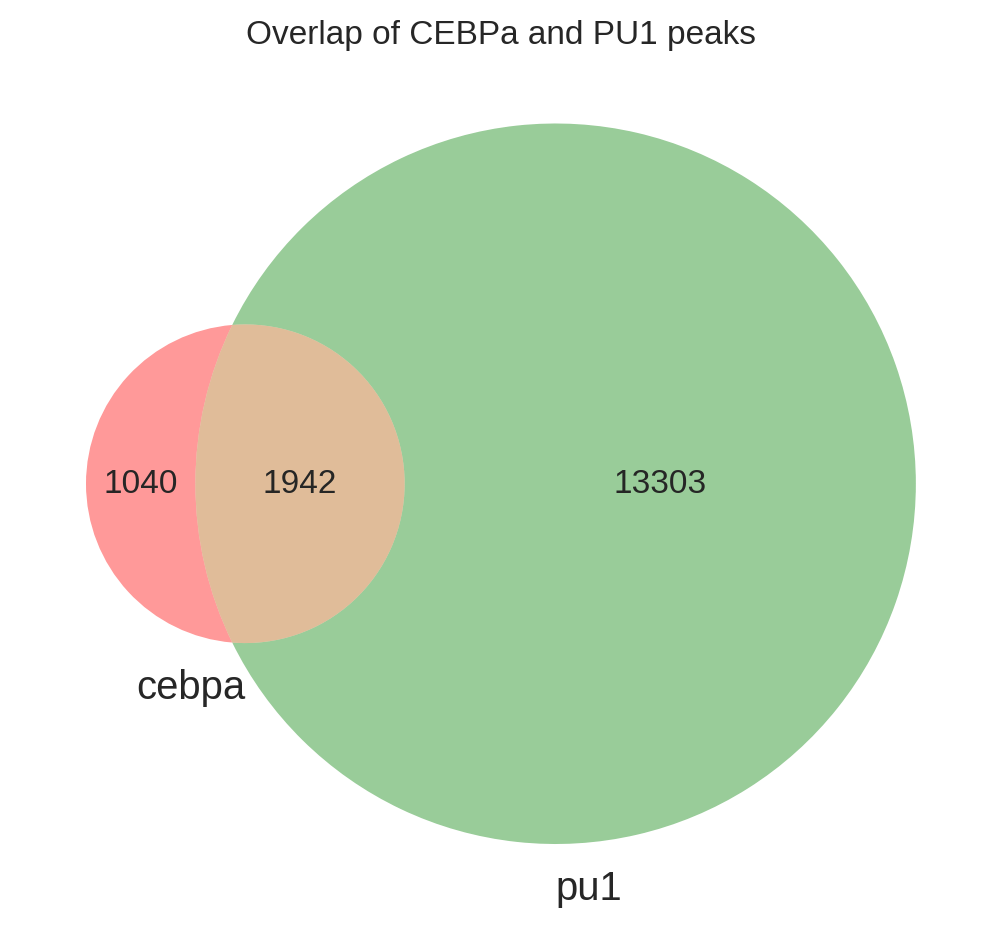

In [44]:
matplotlib_venn.venn2(
[set(summary_frame[summary_frame['Factors'].str.contains('cebpa_veh')].index.values),
 set(summary_frame[summary_frame['Factors'].str.contains('pu1_veh')].index.values)
],
set_labels=['cebpa', 'pu1'])
plt.title('Overlap of CEBPa and PU1 peaks')

In [48]:
factor_coeff_dict = {}
fraction =0.5
lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

feature_frame = normed_motif_frame

### for cebpa only ###
features = feature_frame.copy()
labels = summary_frame['Factors'].str.contains('cebpa_veh') & \
    [not x for x in summary_frame['Factors'].str.contains('pu1_veh')]
training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
lr_classifier.fit(training_features, training_labels)
coefficients = lr_classifier.coef_
factor_coeff_dict['cebpa only'] = coefficients.flatten()


### for pu1 only ###
features = feature_frame.copy()
labels = summary_frame['Factors'].str.contains('pu1_veh') & \
    [not x for x in summary_frame['Factors'].str.contains('cebpa_veh')]
training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
lr_classifier.fit(training_features, training_labels)
coefficients = lr_classifier.coef_
factor_coeff_dict['pu1 only'] = coefficients.flatten()

### for cebpa and pu1 ###
features = feature_frame.copy()
labels = summary_frame['Factors'].str.contains('pu1_veh') & \
    summary_frame['Factors'].str.contains('cebpa_veh')    
training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
lr_classifier.fit(training_features, training_labels)
coefficients = lr_classifier.coef_
factor_coeff_dict['cebpa_pu1'] = coefficients.flatten()

### all cebpa ###
features = feature_frame.copy()
labels = summary_frame['Factors'].str.contains('cebpa_veh')
training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
lr_classifier.fit(training_features, training_labels)
coefficients = lr_classifier.coef_
factor_coeff_dict['all cebpa'] = coefficients.flatten()

### all pu1 ###
features = feature_frame.copy()
labels = summary_frame['Factors'].str.contains('pu1_veh')
training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
lr_classifier.fit(training_features, training_labels)
coefficients = lr_classifier.coef_
factor_coeff_dict['all pu1'] = coefficients.flatten()
frame = pd.DataFrame(factor_coeff_dict)
frame.index = features.columns.values




total: 45441 filtered: 43516 true gc: 0.46199 false gc: 0.47199 difference: 0.01
total: 45441 filtered: 45441 true gc: 0.47582 false gc: 0.47333 difference: 0.00249
total: 45441 filtered: 45441 true gc: 0.46587 false gc: 0.47479 difference: 0.00892
total: 45441 filtered: 45142 true gc: 0.46476 false gc: 0.47476 difference: 0.01
total: 45441 filtered: 45441 true gc: 0.47426 false gc: 0.47417 difference: 8e-05


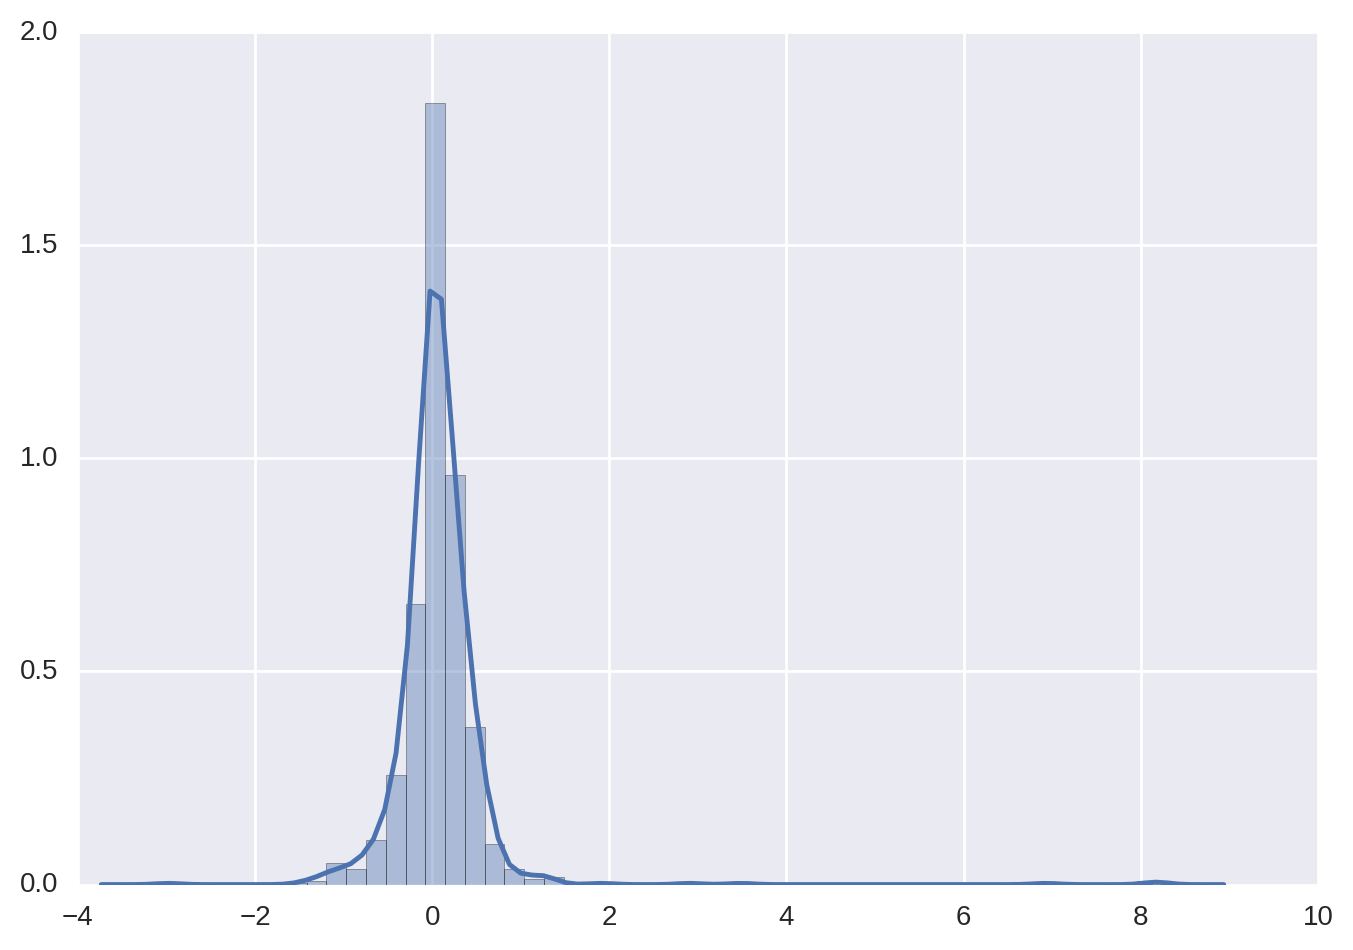

In [49]:
sns.distplot(frame.values.flatten())


1.21334975359 -1.06235090403


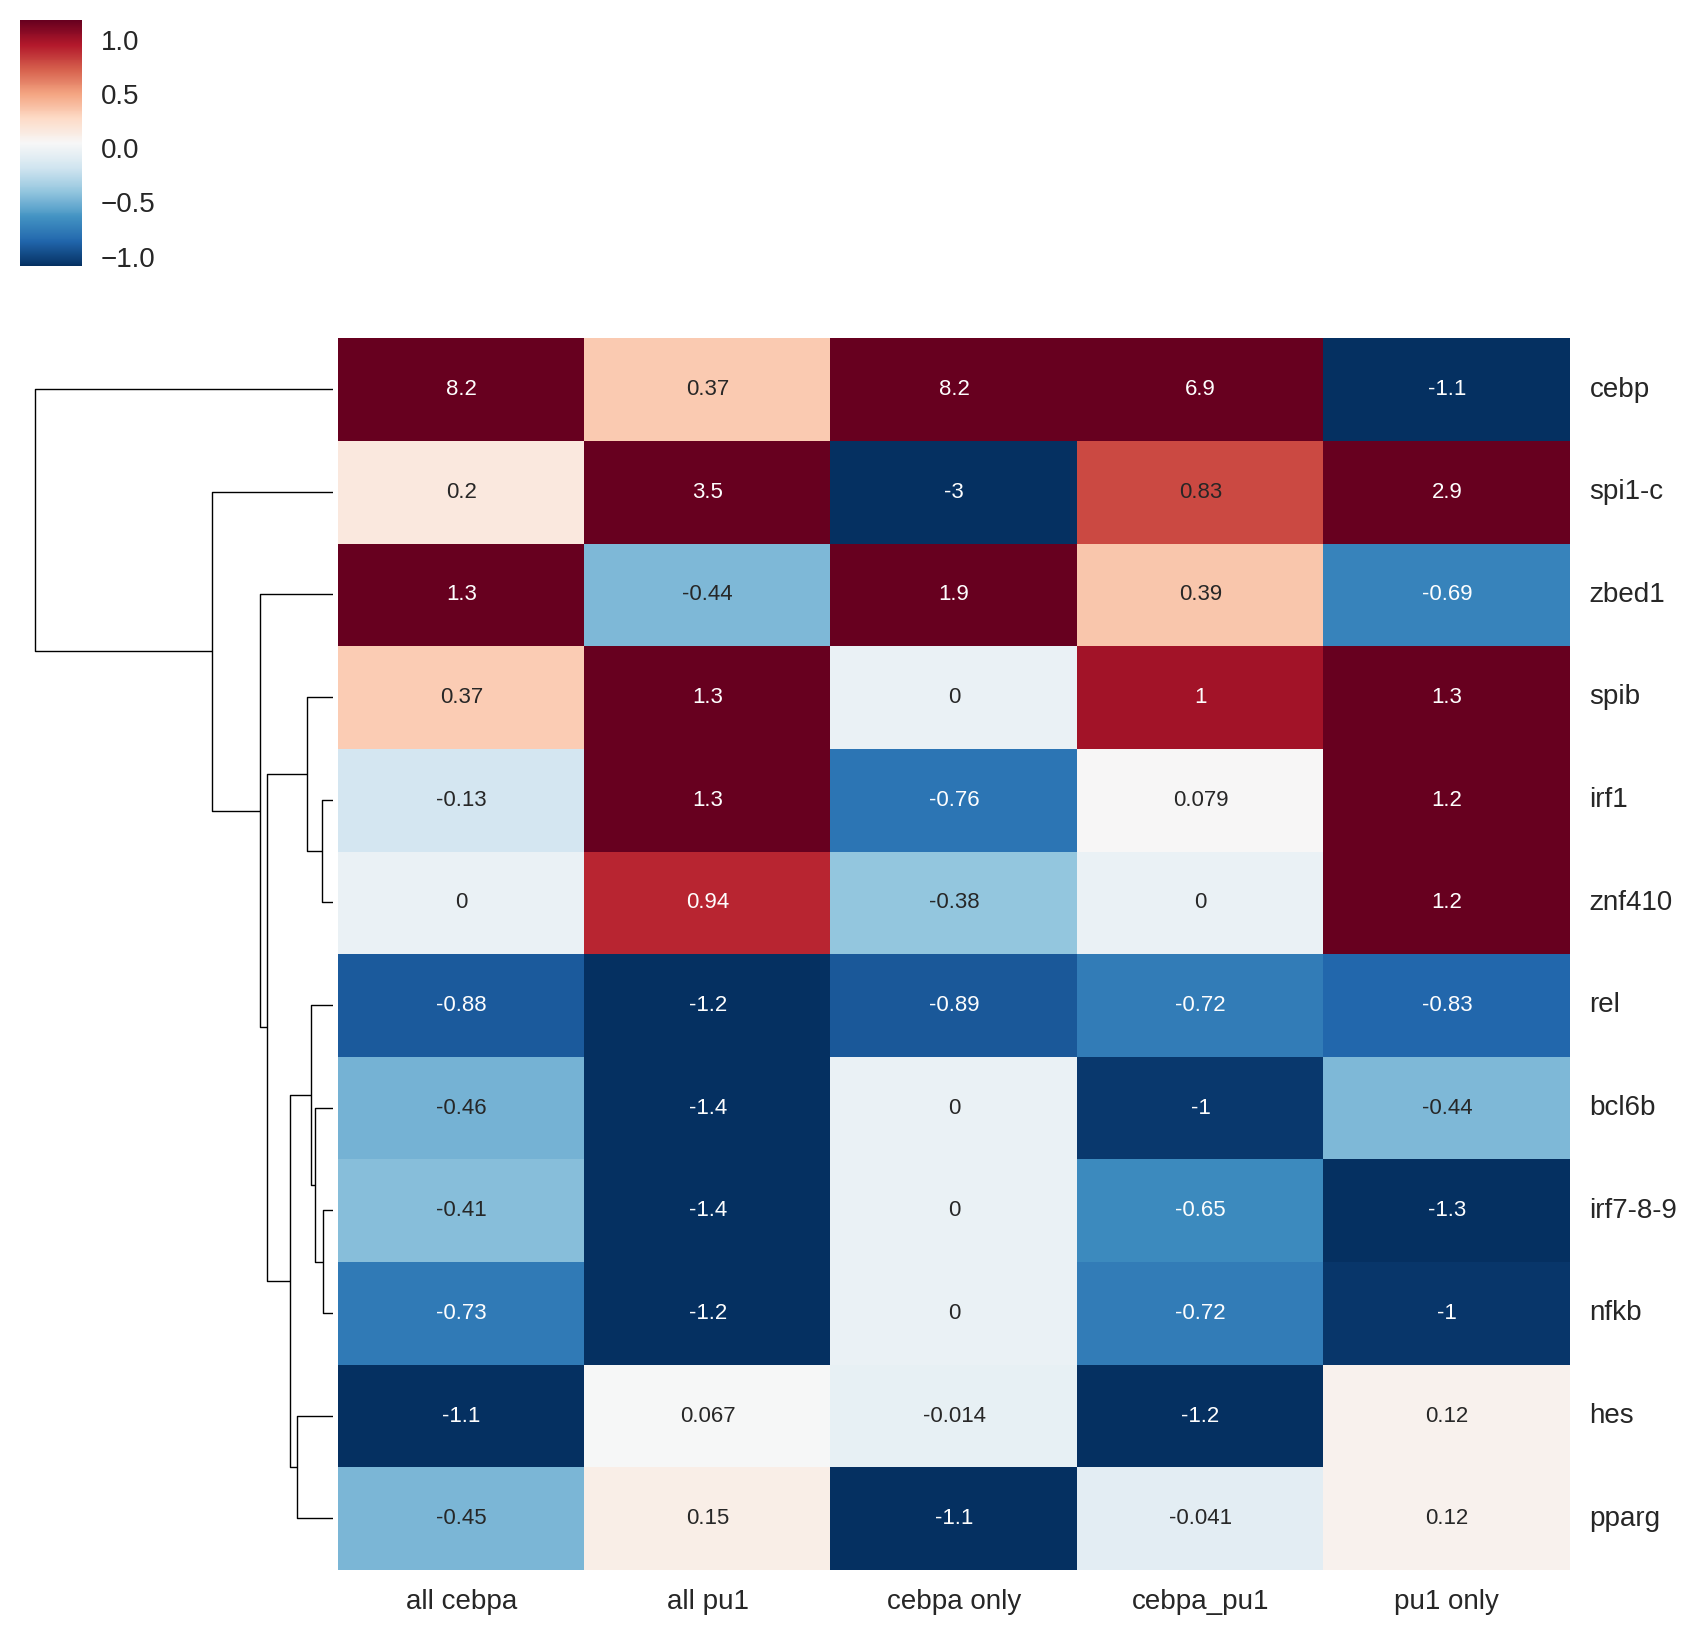

In [50]:
### plot coefficents for both vehicle and kla
threshold = 2
coeff_std = np.std(frame.values.flatten())
coeff_mean = np.mean(frame.values.flatten())
print(coeff_mean + threshold* coeff_std,
       coeff_mean - threshold* coeff_std)
significant_indices = (frame.max(axis=1) > coeff_mean + threshold* coeff_std) | \
                                       (frame.min(axis=1) < coeff_mean - threshold* coeff_std)
significant_motifs = frame[significant_indices].index.values
cg = sns.clustermap(frame[significant_indices],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=True,annot_kws={"size": 8},
#                    figsize=(6,6),
                   col_cluster=False)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);

In [ ]:
### plot distribution of motif scores
# for motif in significant_motifs:
factors = []
motifs = []
scores = []

for motif in significant_motifs:
    print(motif)
    ### all cebpa ###
    currentScores = list(motif_score_frame[motif_score_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('cebpa_veh')
                                                                ].index.values)][motif].values)
    scores = scores + currentScores
    motifs = motifs + len(currentScores) * [motif]
    factors = factors + len(currentScores) * ['all cebpa']
    
    ### all pu1 ###
    currentScores = list(motif_score_frame[motif_score_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('pu1_veh')
                                                                ].index.values)][motif].values)
    scores = scores + currentScores
    motifs = motifs + len(currentScores) * [motif]
    factors = factors + len(currentScores) * ['all pu1']
    
    ### for cebpa only ###
    currentScores = list(motif_score_frame[motif_score_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('cebpa_veh') & \
        [not x for x in summary_frame['Factors'].str.contains('pu1_veh')]].index.values)][motif].values)
    scores = scores + currentScores
    motifs = motifs + len(currentScores) * [motif]
    factors = factors + len(currentScores) * ['cebpa only']
    
    ### for pu1 only ###
    currentScores = list(motif_score_frame[motif_score_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('pu1_veh') & \
        [not x for x in summary_frame['Factors'].str.contains('cebpa_veh')]].index.values)][motif].values)
    scores = scores + currentScores
    motifs = motifs + len(currentScores) * [motif]
    factors = factors + len(currentScores) * ['pu1 only']

    ### for cebpa and pu1 ###
    currentScores = list(motif_score_frame[motif_score_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('pu1_veh') & \
        summary_frame['Factors'].str.contains('cebpa_veh')].index.values)][motif].values)
    scores = scores + currentScores
    motifs = motifs + len(currentScores) * [motif]
    factors = factors + len(currentScores) * ['cebpa and pu1']
    
    
    ### all ###
    currentScores = list(motif_score_frame[motif].values)
    scores = scores + currentScores
    motifs = motifs + len(currentScores) * [motif]
    factors = factors + len(currentScores) * ['all sites']
current_frame = pd.DataFrame({'motif':motifs,
                             'score':scores,
                             'factors':factors})
for motif in significant_motifs:

    sns.factorplot(data=current_frame[current_frame['motif']==motif], y='score', x='factors', kind='box', 
              sharey=True,
              showfliers=False  
#               cut=0,
#               inner='quartile'
                   
              )
    plt.title(motif)
    plt.xticks(rotation=90);
    plt.show()

### Pairs of AP-1 Members

In [ ]:
factorPairs = []
ap1_members = ['atf3','cjun']
for i in range(len(ap1_members)):
    for j in range(i, len(ap1_members)):
        print(ap1_members[i], ap1_members[j])
        factorPairs.append((ap1_members[i], ap1_members[j]))
        labels = summary_frame['Factors'].str.contains(ap1_members[i] + '_veh') & \
        summary_frame['Factors'].str.contains(ap1_members[j] + '_veh')
        print(np.sum(labels))


In [ ]:
### for all peaks in vehicle and KLA
factor_coeff_dict = {}
for factorPair in factorPairs:
    print(factorPair)
    features = normed_motif_frame
#     features = motif_score_frame.ix[:,3:]
    labels = summary_frame['Factors'].str.contains(factorPair[0] + '_veh') & summary_frame['Factors'].str.contains(factorPair[1] + '_veh')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression()
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    predictions_lr = lr_classifier.predict(test_features)
    
    coefficients = lr_classifier.coef_
    intercept = lr_classifier.intercept_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
coefficients_frame_ap1_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_ap1_pairs.index = motif_score_frame.columns.values[3:]

In [ ]:
### plot coefficents for both vehicle and kla
threshold = 2.0
coeff_std = np.std(coefficients_frame_ap1_pairs.values.flatten())
coeff_mean = np.mean(coefficients_frame_ap1_pairs.values.flatten())
print(coeff_mean + threshold* coeff_std,
       coeff_mean - threshold* coeff_std)
significant_indices = (coefficients_frame_ap1_pairs.max(axis=1) > coeff_mean + threshold* coeff_std) | \
                                       (coefficients_frame_ap1_pairs.min(axis=1) < coeff_mean - threshold* coeff_std)
significant_motifs = coefficients_frame_ap1_pairs[significant_indices].index.values
cg = sns.clustermap(coefficients_frame_ap1_pairs.ix[significant_motifs,['atf3_atf3','atf3_cjun','cjun_cjun']],
                   vmax=coeff_mean + threshold* coeff_std,
                   vmin=coeff_mean - threshold* coeff_std,
                   center = coeff_mean,
                   annot=True,annot_kws={"size": 8},
                   figsize=(8,8),
                   col_cluster=False)
            
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);

In [ ]:
matplotlib_venn.venn3(
[set(summary_frame[summary_frame['Factors'].str.contains('cebpa_veh')].index.values),
 set(summary_frame[summary_frame['Factors'].str.contains('atf3_veh')].index.values),
 set(summary_frame[summary_frame['Factors'].str.contains('cjun_veh')].index.values)
],
set_labels=['cebpa', 'atf3', 'cebpa'])
plt.title('Overlap of CEBPa and PU1 peaks')

## Visualization of Overlaps

In [ ]:
import networkx as nx
current_palette = sns.color_palette()


In [ ]:
### create network representation for VEH ###
cols = [x for x in bool_frame.columns if 'veh' in x]
veh_frame = bool_frame[cols]
network = nx.Graph()
for g in cols:
    factor = g.split('_')[0]
    network.add_node(factor, factor=factor)
#     network.add_node(g, environment=environmentDict[g], expression_veh=expressionDict_veh[g], expression_kla = expressionDict_kla[g])

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs)) + 1
        network.add_edge(factor1, factor2, sharedMotifs=num_shared_motifs)
# nx.draw_circular(network, edges=edges, width=weights)
edgewidth=[]
for (u,v,d) in network.edges(data=True):
    edgewidth.append(network.get_edge_data(u,v)['sharedMotifs'])
edgewidth = np.array(edgewidth)/15
  
nx.draw_circular(network, 
                node_size=2000, 
                node_color=current_palette[0],
                width=edgewidth,
                )

plt.gca().set_aspect('equal')
nx.write_graphml(network,'veh_graphml.xml')


In [ ]:
### create network representation for KLA ###
cols = [x for x in bool_frame.columns if 'kla' in x]
veh_frame = bool_frame[cols]
network = nx.Graph()
for g in cols:
    factor = g.split('_')[0]
    network.add_node(factor, factor=factor)
#     network.add_node(g, environment=environmentDict[g], expression_veh=expressionDict_veh[g], expression_kla = expressionDict_kla[g])

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs)) + 1
        network.add_edge(factor1, factor2, sharedMotifs=num_shared_motifs)
# nx.draw_circular(network, edges=edges, width=weights)
edgewidth=[]
for (u,v,d) in network.edges(data=True):
    edgewidth.append(network.get_edge_data(u,v)['sharedMotifs'])
edgewidth = np.array(edgewidth)/25
  
nx.draw_circular(network, 
                node_size=2000, 
                node_color=current_palette[1],
                width=edgewidth,
                )

plt.gca().set_aspect('equal')
nx.write_graphml(network,'kla_graphml.xml')



In [ ]:
### plot how significant motifs overlap with one another

cols = [x for x in bool_motif_frame.columns if 'veh' in x]
matrix = np.zeros((len(cols), len(cols)))

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_motif_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs))
        matrix[i][j] = num_shared_motifs
        matrix[j][i] = num_shared_motifs
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
#     sns.heatmap(matrix, xticklabels = cols, yticklabels=cols, cmap='Blues', mask=mask, vmax=100)
    sns.heatmap(matrix, xticklabels = cols, yticklabels=cols, cmap='Blues', vmax=100)

    plt.xticks(rotation=90);
    plt.title('Overlap of Significant Motifs for Vehicle Peaks')
    plt.show()
    
# for KLA
cols = [x for x in bool_motif_frame.columns if 'kla' in x]
matrix = np.zeros((len(cols), len(cols)))

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_motif_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs))
        matrix[i][j] = num_shared_motifs
        matrix[j][i] = num_shared_motifs
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
#     sns.heatmap(matrix, xticklabels = cols, yticklabels=cols, cmap='Blues', mask=mask, vmax=100)
    sns.heatmap(matrix, xticklabels = cols, yticklabels=cols, cmap='Blues', vmax=100)
    plt.xticks(rotation=90);
    plt.title('Overlap of Significant Motifs for KLA Peaks')

In [ ]:
### plot how significant motifs overlap with one another

cols = [x for x in bool_frame.columns if 'veh' in x]
matrix = np.zeros((len(cols), len(cols)))

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs))
        matrix[i][j] = num_shared_motifs
        matrix[j][i] = num_shared_motifs

with sns.axes_style("white"):
    sns.heatmap(np.log2(matrix+1), xticklabels = cols, yticklabels=cols, cmap='Greens', square=True)
    plt.xticks(rotation=90);
    plt.title('Overlap of Significant Motifs for Vehicle Peaks')
    plt.show()
    
# for KLA
cols = [x for x in bool_frame.columns if 'kla' in x]
matrix = np.zeros((len(cols), len(cols)))

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs))
        matrix[i][j] = num_shared_motifs
        matrix[j][i] = num_shared_motifs
with sns.axes_style("white"):
    sns.heatmap(np.log2(matrix+1), xticklabels = cols, yticklabels=cols, cmap='Greens', square = True)
    plt.xticks(rotation=90);
    plt.title('Overlap of Significant Motifs for KLA Peaks')

## Strains Stuff

In [46]:
### read in strains SNPs ###

# filter away SNPS that didn't pass all qc metrics
!grep PASS ./strains_snps/BALB_cJ.mgp.v5.snps.dbSNP142.vcf  > ./strains_snps/balbcj_passed_snps.txt
!grep PASS ./strains_snps/BALB_cJ.mgp.v5.snps.dbSNP142.vcf  > ./strains_snps/nod_passed_snps.txt

In [77]:
chrom_size_dict = {
    '1':196,
'2':182,
'3':160,
'4':157,
'5':152,
'6':150,
'7':145,
'8':129,
'9':125,
'10':131,
'11':122,
'12':120,
'13':120,
'14':125,
'15':104,
'16':91,
'17':95,
'18':91,
'19':61,
'X':10,
'Y':10,
'MT':10,
}

In [ ]:
balbcj_chr_snp_dict = {}
for chr in [str(x) for x in range(1,20)] + ['X','Y','MT']:
#     balb_chr_snp_dict[chr] = np.array([False] * (chrom_size_dict[chr]*100000))
    balbcj_chr_snp_dict[chr] = np.array([False] * (200*1000000))

print('reading balbcj snps')
with open('./strains_snps/balbcj_passed_snps.txt') as f:
    data = f.readlines()
for line in data:

    tokens = line.split('\t')
    chr = tokens[0]
    position = int(tokens[1])
    
    balbcj_chr_snp_dict[chr][position] = True

    


In [ ]:
motif_balbcj_snp_frame = motif_start_frame[['ID', 'Factors', 'chr']]
motif_balbcj_snp_frame.index = motif_balbcj_snp_frame['ID'].values
for motif in motif_start_frame.columns[3:]:
    print(motif)
    starts = motif_start_frame[motif]
    ends = motif_end_frame[motif]
    chromosomes = motif_balbcj_snp_frame['chr']
    num_snp_list =  []
    for i in range(len(starts)):
        current_start = starts[i]
        current_end = ends[i]
        current_chr = chromosomes[i].replace('chr','')
        if current_start * current_end > 0:
            num_snp_list.append(np.sum(balbcj_chr_snp_dict[current_chr][current_start:current_end+1]))
        else:
            num_snp_list.append(0)
    motif_balbcj_snp_frame[motif] = num_snp_list

In [102]:
motif_balbcj_snp_frame.to_pickle('./motif_balbcj_snp_frame.pickle')

In [178]:
nod_chr_snp_dict = {}
for chr in [str(x) for x in range(1,20)] + ['X','Y','MT']:

    nod_chr_snp_dict[chr] = np.array([False] * (200*1000000))

print('reading nod snps')
with open('./strains_snps/nod_passed_snps.txt') as f:
    data = f.readlines()
for line in data:
    counter +=1
    tokens = line.split('\t')
    chr = tokens[0]
    position = int(tokens[1])
    
    nod_chr_snp_dict[chr][position] = True

reading nod snps


In [ ]:
motif_nod_snp_frame = motif_start_frame[['ID', 'Factors', 'chr']]
motif_nod_snp_frame.index = motif_balbcj_snp_frame['ID'].values
for motif in motif_start_frame.columns[3:]:
    print(motif)
    starts = motif_start_frame[motif]
    ends = motif_end_frame[motif]
    chromosomes = motif_nod_snp_frame['chr']
    num_snp_list =  []
    for i in range(len(starts)):
        current_start = starts[i]
        current_end = ends[i]
        current_chr = chromosomes[i].replace('chr','')
        if current_start * current_end > 0:
            num_snp_list.append(np.sum(nod_chr_snp_dict[current_chr][current_start:current_end+1]))
        else:
            num_snp_list.append(0)
    motif_nod_snp_frame[motif] = num_snp_list

In [180]:
motif_nod_snp_frame.to_pickle('./motif_nod_snp_frame.pickle')

balbc junb kla


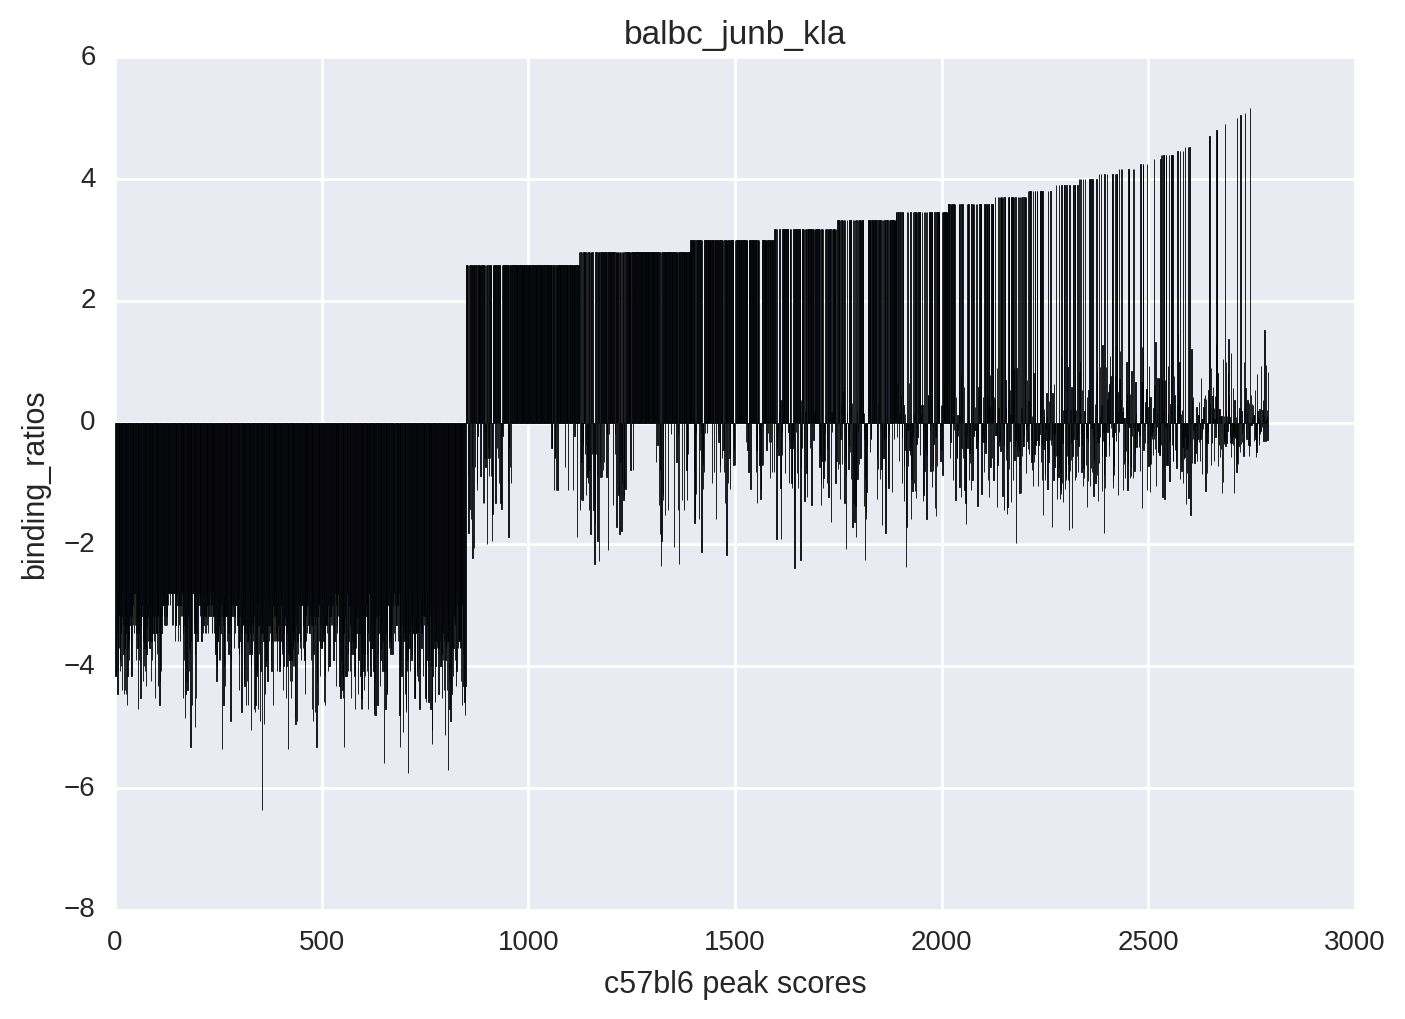

In [155]:
# strains_factors = ['pu1',
# 'fos',
# 'cjun',
# 'junb',
# 'jund']
strains_factors = ['junb']
# strains = ['balbc', 'nod']
strains=['balbc']
# treatments = ['veh','kla']
treatments=['kla']
for strain in strains:
    for factor in strains_factors:
        for treatment in treatments:
            print(strain, factor, treatment)
            strain_factor_treatment_1 = 'c57bl6'+'_'+factor+'_'+treatment
            strain_factor_treatment_2 = strain+'_'+factor+'_'+treatment
            indices = summary_frame[(summary_frame['Factors'].str.contains(strain_factor_treatment_1)) |
                                   (summary_frame['Factors'].str.contains(strain_factor_treatment_2))].index.values
            
            snp_indices = motif_balbcj_snp_frame[(motif_balbcj_snp_frame.sum(axis=1) > 0)
                                                ].index.values
#             snp_indices = motif_balbcj_snp_frame[motif_balbcj_snp_frame.sum(axis=1) >0].index.values
            indices = [x for x in indices if x in snp_indices]
            
            peakScores_1 = summary_frame.ix[indices,strain_factor_treatment_1]
            peakScores_2 = summary_frame.ix[indices,strain_factor_treatment_2]
            binding_ratios = (peakScores_1 + 1)/(peakScores_2+1)
            motif_scores = normed_motif_frame.ix[indices, 'ap-1'] + \
                normed_motif_frame.ix[indices, 'spib'] +\
                normed_motif_frame.ix[indices, 'cebp']
            
#             plt.scatter(np.log2(binding_ratios), motif_scores)
#             plt.ylabel('Motif Score')
#             plt.xlabel('c57bl6/'+strain+' binding')
            plt.bar(scipy.stats.rankdata(peakScores_1, method='ordinal'), np.log2(binding_ratios))
            plt.xlabel('c57bl6 peak scores')
            plt.ylabel('binding_ratios')
            plt.title(strain_factor_treatment_2)

            plt.show()

In [251]:
motif_1 = 'spi1-c'
motif_2 = 'ap-1'
factor_1 = 'c57bl6_pu1_veh'
factor_2 = 'c57bl6_cjun_veh'

motif_state_1s = []
motif_state_2s = []
peak_state_1s = []
peak_state_2s = []
counts = []
for peak_state_1 in [True, False]:
    for peak_state_2 in [True, False]:
        for motif_state_1 in [True, False]:
            for motif_state_2 in [True, False]:
#                 if np.sum([peak_state_1, peak_state_2]) > 0:
                if True:
                    motif_state_1s.append(motif_state_1)
                    motif_state_2s.append(motif_state_2)
                    peak_state_1s.append(peak_state_1)
                    peak_state_2s.append(peak_state_2)
                    peak_indices = summary_frame[(summary_frame['Factors'].str.contains(factor_1) == peak_state_1) &
                                                 (summary_frame['Factors'].str.contains(factor_2) == peak_state_2)].index.values
                    current_motif_frame = motif_score_frame[motif_score_frame.index.isin(peak_indices)]
                    motif_indices = current_motif_frame[((current_motif_frame[motif_1] > 0) == motif_state_1) &
                                                        ((current_motif_frame[motif_2] > 0) == motif_state_2)].index.values                   
                    count = len(motif_indices)
                    counts.append(count)
current_count_frame = pd.DataFrame({factor_1 +' binding':peak_state_1s,
                                   factor_2 +' binding':peak_state_2s,
                                   motif_1 + ' motif':motif_state_1s,
                                   motif_2 + ' motif':motif_state_2s,
                                   'num peaks': counts})               
current_count_frame = current_count_frame[[factor_1 +' binding',
                                   factor_2 +' binding',
                                   motif_1 + ' motif',
                                   motif_2 + ' motif',
                                   'num peaks']]

In [244]:
motif_1 = 'spi1-c'
motif_2 = 'ap-1'
factor_1 = 'c57bl6_pu1_kla'
factor_2 = 'c57bl6_cjun_kla'

motif_state_1s = []
motif_state_2s = []
peak_state_1s = []
peak_state_2s = []
snp_state_1s = []
snp_state_2s = []
counts = []
for peak_state_1 in [True, False]:
    for peak_state_2 in [True, False]:
        for motif_state_1 in [True, False]:
            for motif_state_2 in [True, False]:
                for snp_state_1 in [True, False]:
                    for snp_state_2 in [True, False]:
                        motif_state_1s.append(motif_state_1)
                        motif_state_2s.append(motif_state_2)
                        peak_state_1s.append(peak_state_1)
                        peak_state_2s.append(peak_state_2)
                        snp_state_1s.append(snp_state_1)
                        snp_state_2s.append(snp_state_2)
                        
                        peak_indices = summary_frame[(summary_frame['Factors'].str.contains(factor_1) == peak_state_1) &
                                                     (summary_frame['Factors'].str.contains(factor_2) == peak_state_2)].index.values

                        current_motif_frame = motif_score_frame[motif_score_frame.index.isin(peak_indices)]
                        motif_indices = current_motif_frame[((current_motif_frame[motif_1] > 0) == motif_state_1) &
                                                            ((current_motif_frame[motif_2] > 0) == motif_state_2)].index.values                   
                        current_snp_frame = motif_balbcj_snp_frame[motif_balbcj_snp_frame.index.isin(motif_indices)]
                        snp_indices = current_snp_frame[((current_snp_frame[motif_1] > 0) == snp_state_1) &
                                                            ((current_snp_frame[motif_2] > 0) == snp_state_2)].index.values   
                        
                        count = len(snp_indices)
                        counts.append(count)
current_count_frame = pd.DataFrame({factor_1 +' binding':peak_state_1s,
                                   factor_2 +' binding':peak_state_2s,
                                   motif_1 + ' motif':motif_state_1s,
                                   motif_2 + ' motif':motif_state_2s,
                                   motif_1 + ' snp':snp_state_1s,
                                   motif_2 + ' snp':snp_state_2s,
                                   'num peaks': counts})               
current_count_frame = current_count_frame[[factor_1 +' binding',
                                   factor_2 +' binding',
                                   motif_1 + ' motif',
                                   motif_2 + ' motif',
                                   motif_1 + ' snp',
                                   motif_2 + ' snp',
                                   'num peaks']]